In [30]:
import numpy as np
import glob, os, json
import pickle

import matplotlib.pyplot as plt
import corner
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import multiprocessing as mp

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import healpy as hp
import time
import scipy

from corner import corner

from astropy.time import Time
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize


from enterprise.pulsar import Pulsar

from la_forge.core import Core
from la_forge.diagnostics import plot_chains

nano12_pkl = '/home/nima/nanograv/12p5yr_bwm/channelized_12yr_v3_partim_py3.pkl'
with open(nano12_pkl, 'rb') as f:
    allpsrs=pickle.load(f)

In [31]:
chartdir= '/home/nima/nanograv/12p5yr_bwm/ULvT_charts_crnmarg_detpriors_mapgamma/'
charts=os.listdir(chartdir)
print(len(charts))
print("expected {} charts".format(48*8))

print(charts)

384
expected 384 charts
['31_3.txt', '11_6.txt', '11_4.txt', '36_2.txt', '16_7.txt', '9_1.txt', '16_6.txt', '18_3.txt', '33_2.txt', '44_1.txt', '12_6.txt', '21_0.txt', '44_3.txt', '5_7.txt', '47_3.txt', '15_1.txt', '35_1.txt', '5_1.txt', '35_2.txt', '8_4.txt', '26_3.txt', '27_2.txt', '23_2.txt', '12_4.txt', '27_4.txt', '42_7.txt', '8_2.txt', '26_1.txt', '11_1.txt', '1_2.txt', '7_4.txt', '18_0.txt', '46_0.txt', '43_4.txt', '22_2.txt', '22_6.txt', '16_4.txt', '9_4.txt', '7_7.txt', '28_1.txt', '38_0.txt', '19_2.txt', '42_1.txt', '17_2.txt', '40_2.txt', '2_3.txt', '3_5.txt', '30_1.txt', '23_6.txt', '39_5.txt', '37_2.txt', '3_7.txt', '2_4.txt', '45_3.txt', '13_0.txt', '26_7.txt', '45_2.txt', '17_4.txt', '10_3.txt', '1_0.txt', '13_7.txt', '29_5.txt', '0_6.txt', '46_3.txt', '8_5.txt', '0_4.txt', '30_6.txt', '38_7.txt', '29_3.txt', '33_7.txt', '13_1.txt', '9_0.txt', '38_1.txt', '44_6.txt', '32_0.txt', '41_5.txt', '13_2.txt', '20_7.txt', '29_0.txt', '43_2.txt', '15_5.txt', '29_4.txt', '14_4.txt

In [32]:
skypixs = np.arange(hp.nside2npix(2))
npix = hp.nside2npix(2)
bwm_pols = np.arange(0, np.pi, np.pi/8)
amps = np.linspace(-17,-11,45, endpoint=True)
nano11_Ts = np.linspace(53216.13175403874+180,57387.78760427694-180, 134, endpoint=True)
nano12_Ts = np.linspace(53216.13175403865+180, 57933.45642396011-180, 157)

In [33]:
import random
def sample_hist(weights, centers, num_points=int(1e5), sample_bounds=None, verbose=False):
    #make sure the weights are properly normalized
    #print(weights)
    #print(centers)
    norm = np.sum(weights)
    normed_weights = weights/norm
    #print(normed_weights)
    
    #go through weights and see if there are lower and upper bounds. This will speed up resampling
    
            
            
    #print("lower, upper bounds are: {} and {}\nthe likelihoods between are {}:".format(lower, upper, normed_weights[lower:upper]))    
    
    
    accepted = 0
    resampled_chain = []    
    likelihood_interp = scipy.interpolate.interp1d(centers, normed_weights)
    if sample_bounds is None:
        while accepted < num_points:
            amp = random.uniform(centers[0], centers[-1])
            #print("trying amplitude: {}".format(amp))

            likelihood = likelihood_interp(amp)
            #print(likelihood)
            #print("likelihood of amp = {}".format(likelihood))
            if random.random() < likelihood:
                accepted+=1
                if accepted/num_points % 0.02 == 0 and verbose:
                    print("completed {}%".format(accepted/num_points * 100))
                resampled_chain.append(amp)
    else:
        while accepted < num_points:
            amp = random.uniform(sample_bounds[0], sample_bounds[1])
            #print("trying amplitude: {}".format(amp))

            likelihood = likelihood_interp(amp)
            #print(likelihood)
            #print("likelihood of amp = {}".format(likelihood))
            if random.random() < likelihood:
                accepted+=1
                if accepted/num_points % 0.02 == 0 and verbose:
                    print("completed {}%".format(accepted/num_points * 100))
                resampled_chain.append(amp)

        
    #print(sorted(resampled_chain))
    return sorted(resampled_chain)

In [34]:
# Let's make a worker function that does this for a particular epoch and multiprocessify this

def epoch_sample_worker(epoch_idx):
    this_epoch_samples = [] #this should be a list of amplitudes
    
    outdir = '/home/nima/nanograv/12p5yr_bwm/ULvT_samples_crnmarg_detpriors_mapgamma/'
    os.makedirs(outdir, exist_ok=True)
    outf = outdir + '{}.txt'.format(epoch_idx)
    chartdir = '/home/nima/nanograv/12p5yr_bwm/ULvT_charts_crnmarg_detpriors_mapgamma/'
    
    
    
    amps = np.linspace(-17,-11, 60, endpoint=True)

    
    for pol_idx, pol in enumerate(bwm_pols):
        for skypix in range(npix):
            chart = np.loadtxt(chartdir + '{}_{}.txt'.format(skypix, pol_idx))
            epoch_max = np.amax(chart[:, epoch_idx])
            
            # we want to get the weights/centers for the amplitudes
            logweights = np.zeros(len(amps))
            for amp_idx in range(len(logweights)):
                like = np.exp(chart[amp_idx, epoch_idx] - epoch_max) 
                logweights[amp_idx] = np.log(like) + epoch_max
                #reweight so that we have uniform priors in the bwm_amplitude
            #plt.close("all")
            #plt.xscale('log')
            #plt.plot(amps, weights)
            #plt.show()
            # Now we need to build weights from logweights
            weights=np.zeros(len(amps))
            
            maxlogweight = np.amax(logweights)
            for logweight_idx, logweight in enumerate(logweights):
                weights[logweight_idx] = 10**amps[logweight_idx] * np.exp(logweight - maxlogweight)

            
            #now we can resample and add the elements of the chain to this epochs samples.
            sampled = sample_hist(weights, amps, num_points=150, sample_bounds=[-17,-11])


            #now we just want to dump this into this_epoch_samples
            for el in sampled:
                this_epoch_samples.append(el)  
    
    #Now we've resampled this entire time bin for every source location
    #let's just plot some for now
    plt.close("all")
    plt.hist(this_epoch_samples,histtype='step',bins=30 )
    plt.title("Histogram for epoch {}".format(epoch_idx))
    plt.show()
    
    np.savetxt(outf, this_epoch_samples)
    

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max
/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max
/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max
/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max
/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max
/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max
/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max
/tmp/ipykernel_31545/2304554045.py

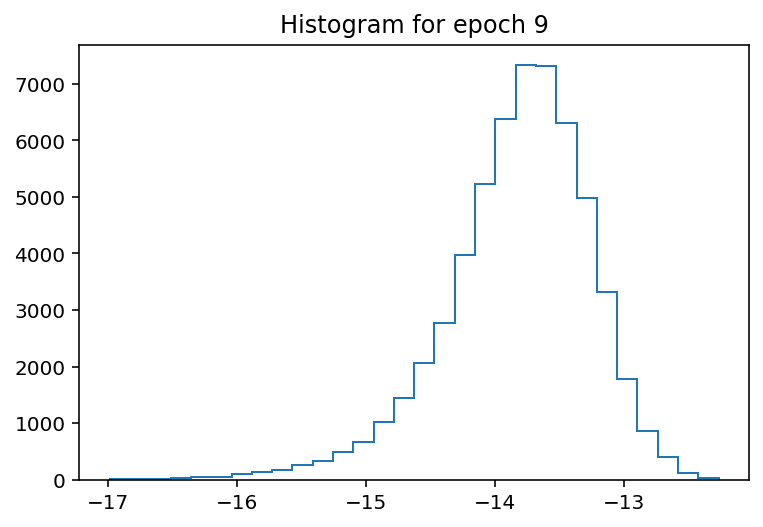

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


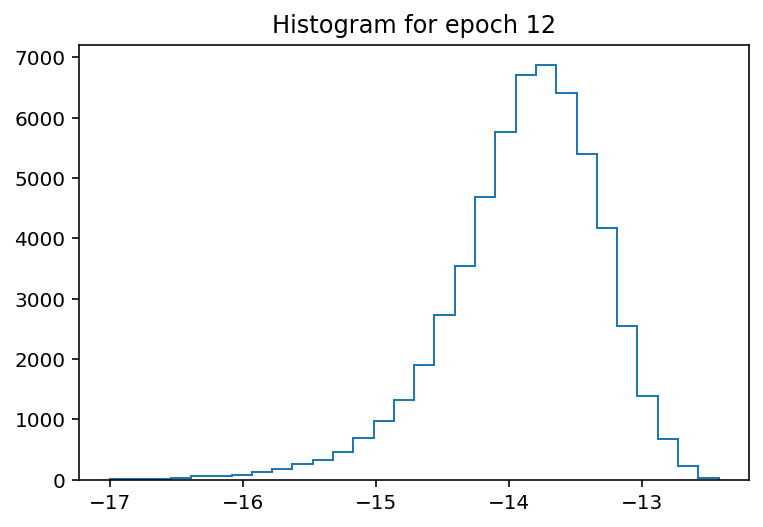

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


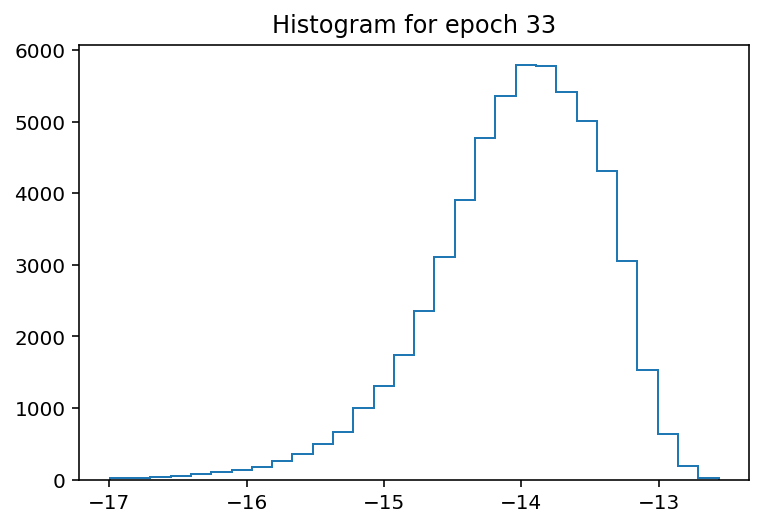

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


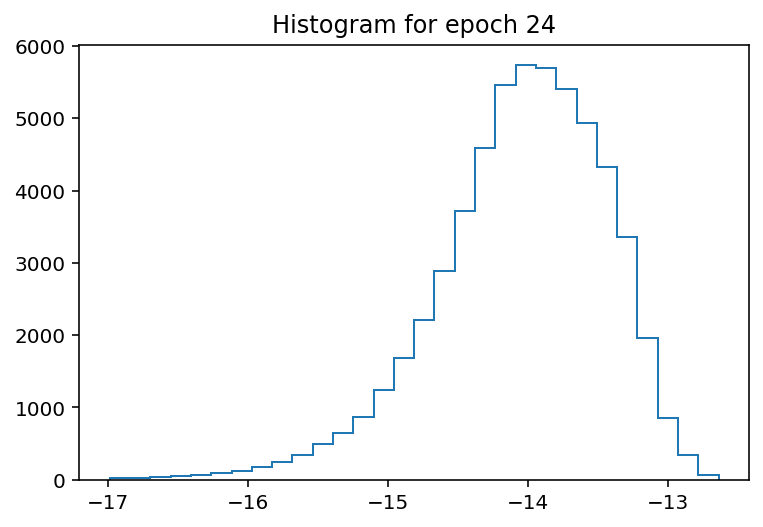

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


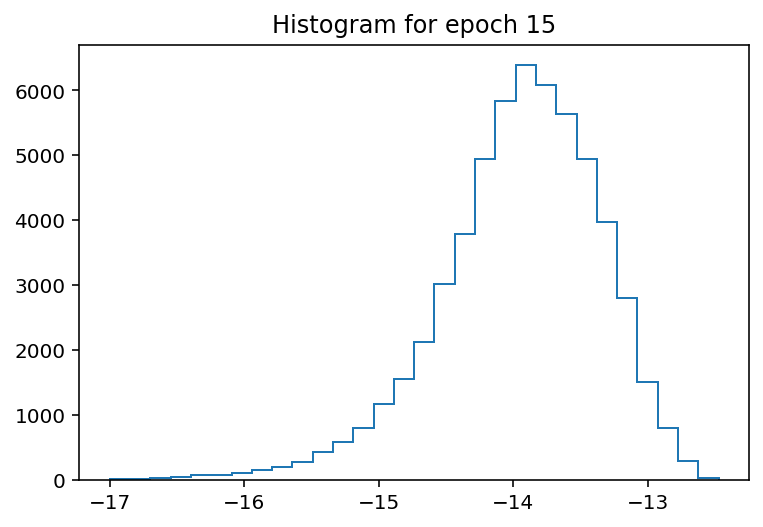

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


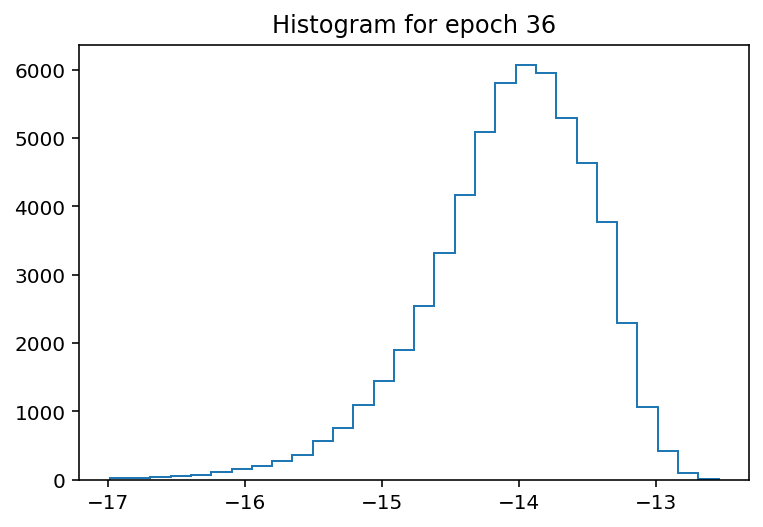

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


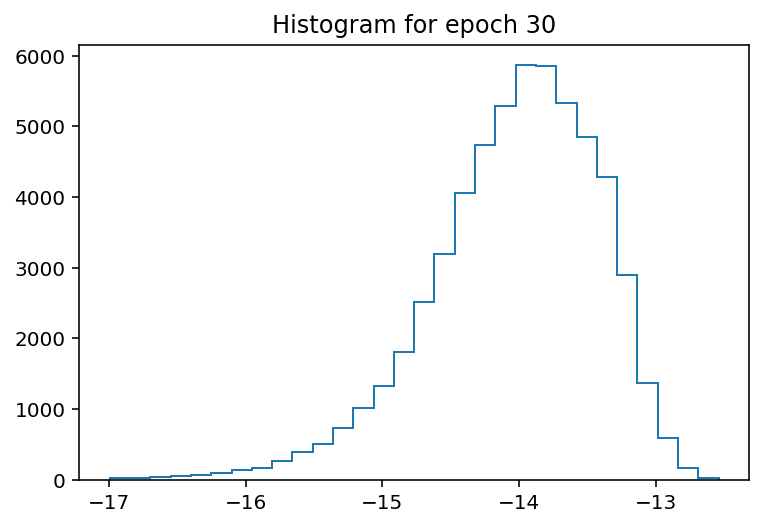

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


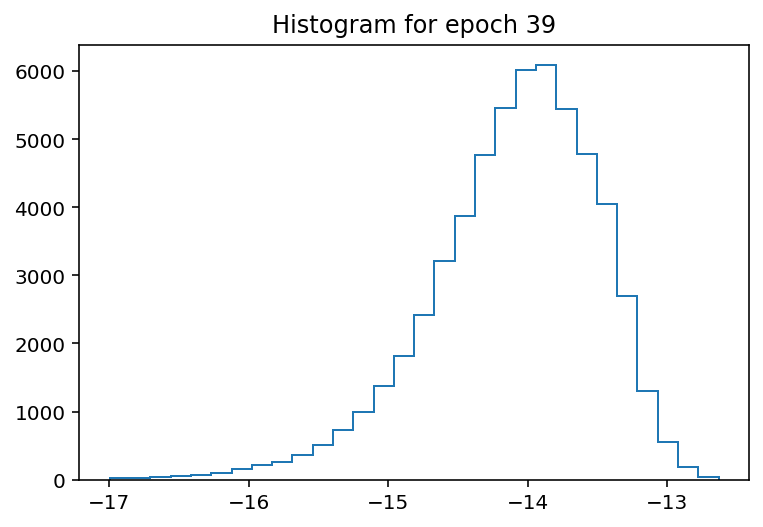

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


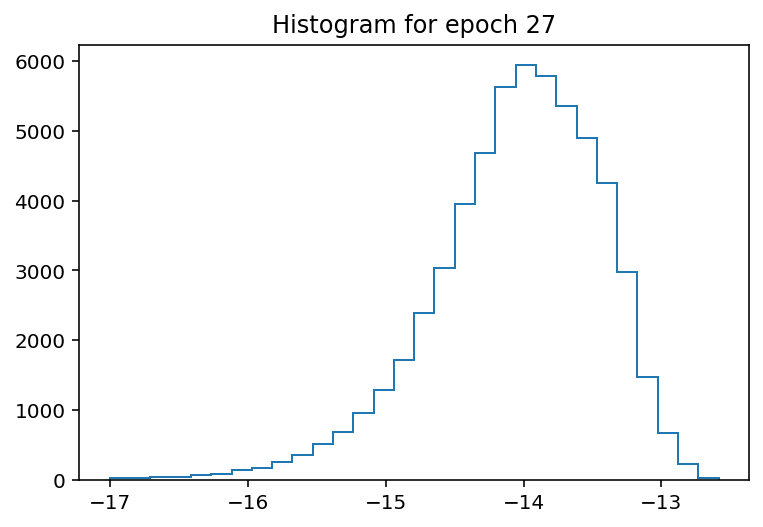

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


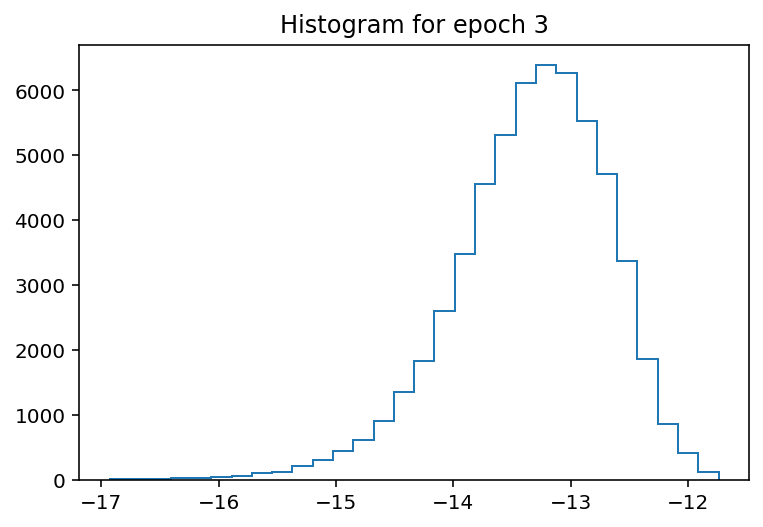

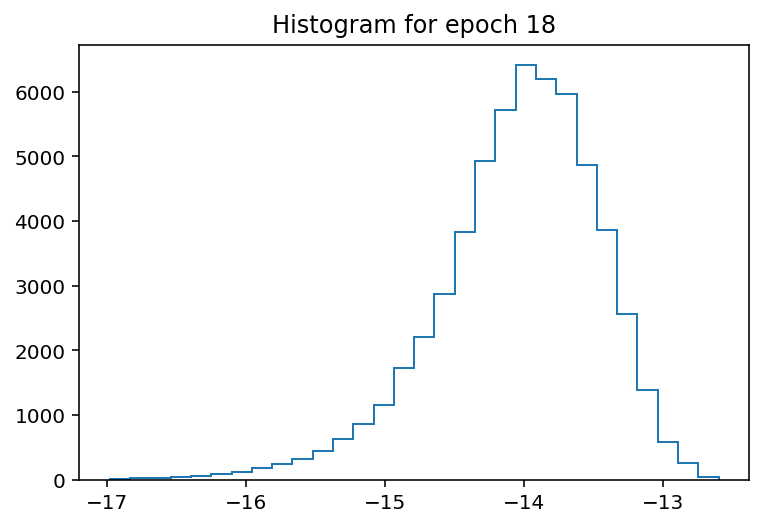

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


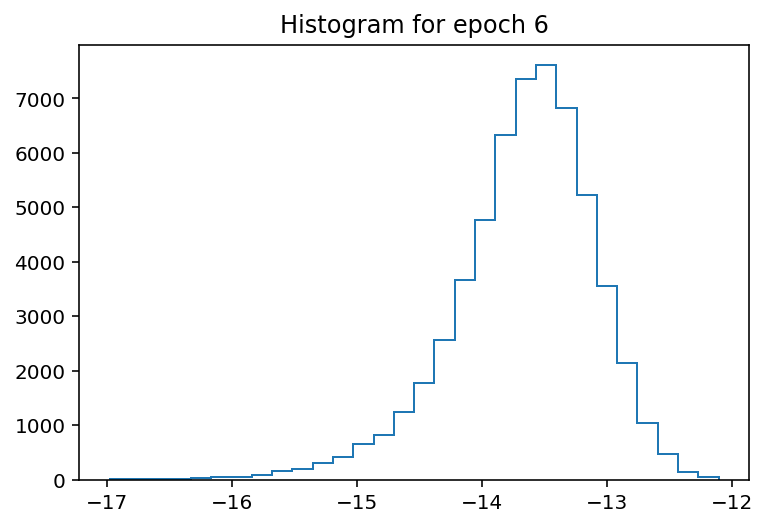

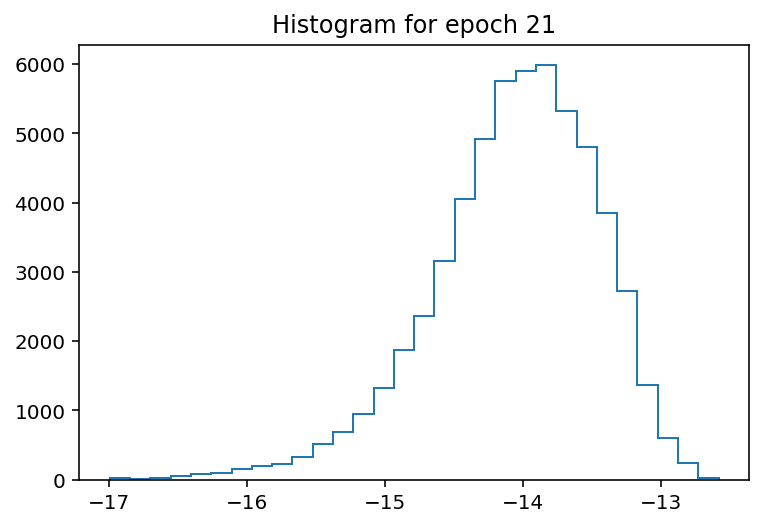

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max
/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max
/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


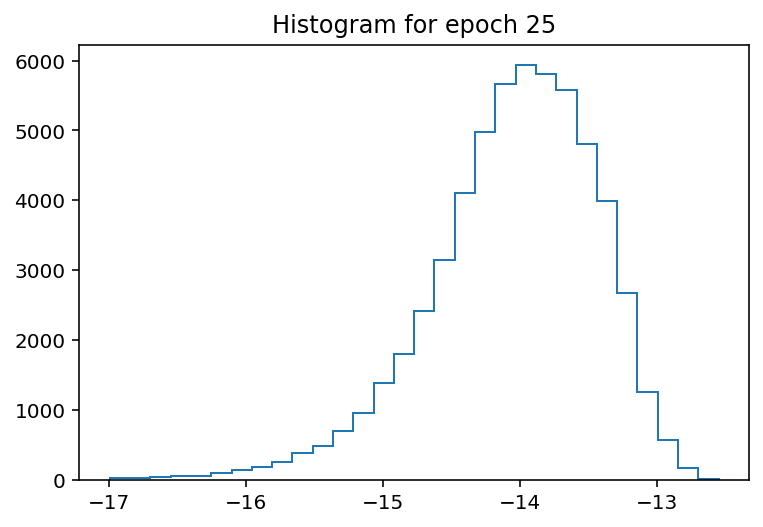

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


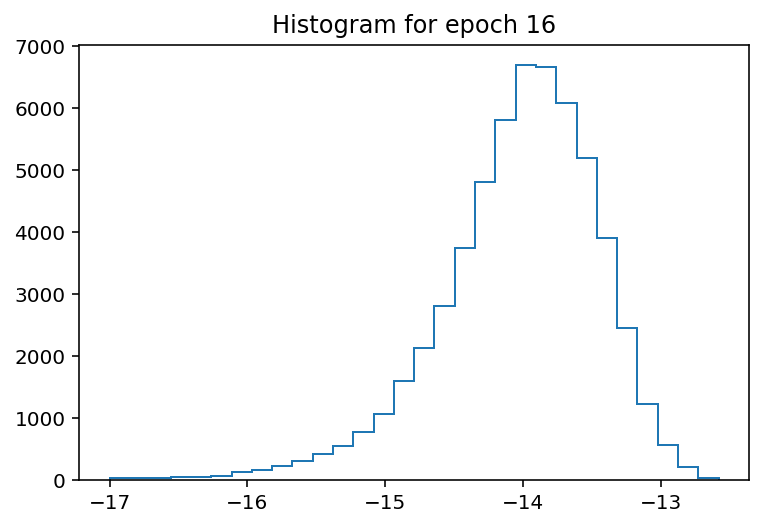

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


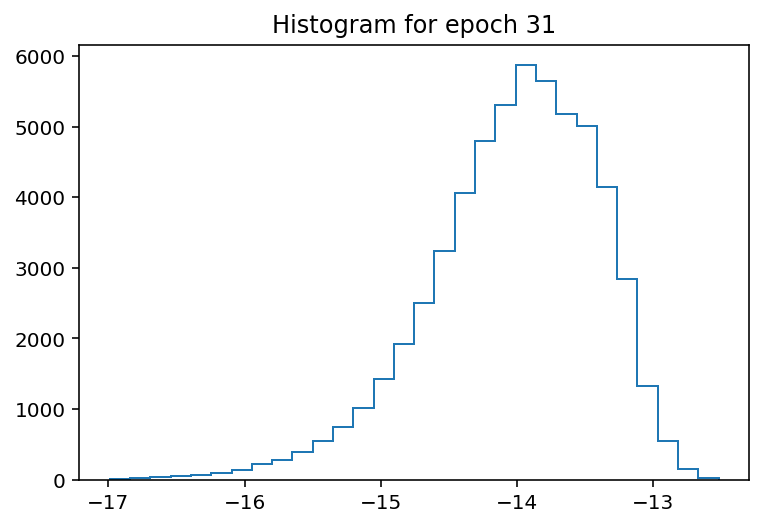

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


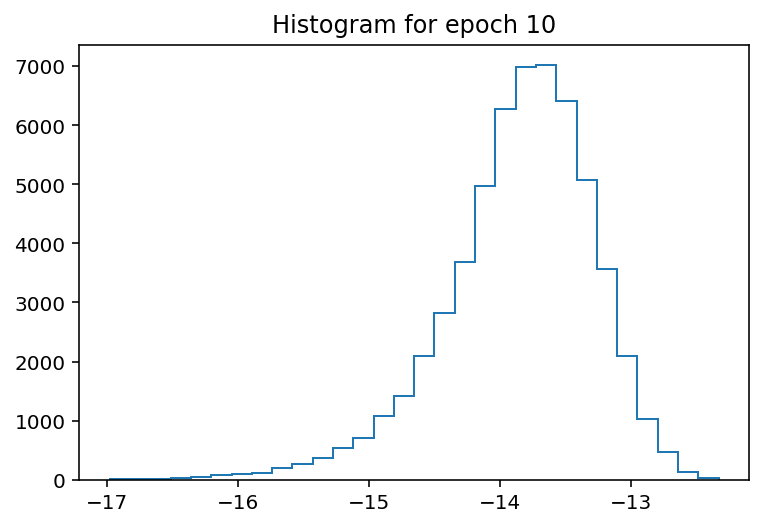

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


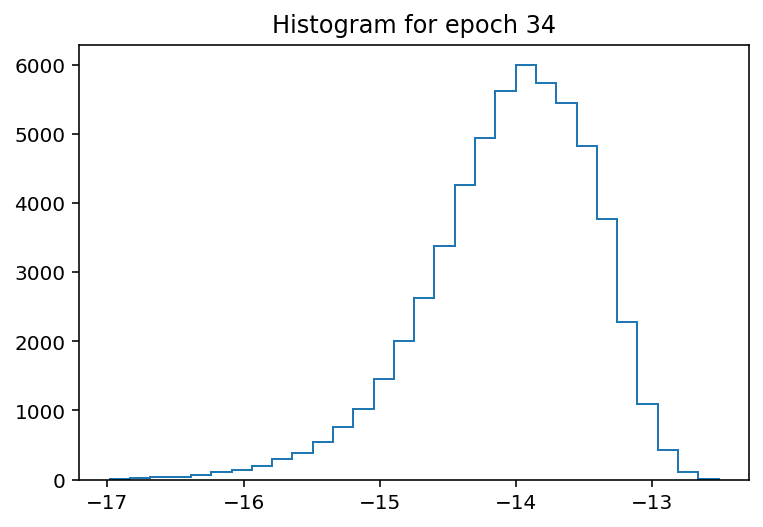

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


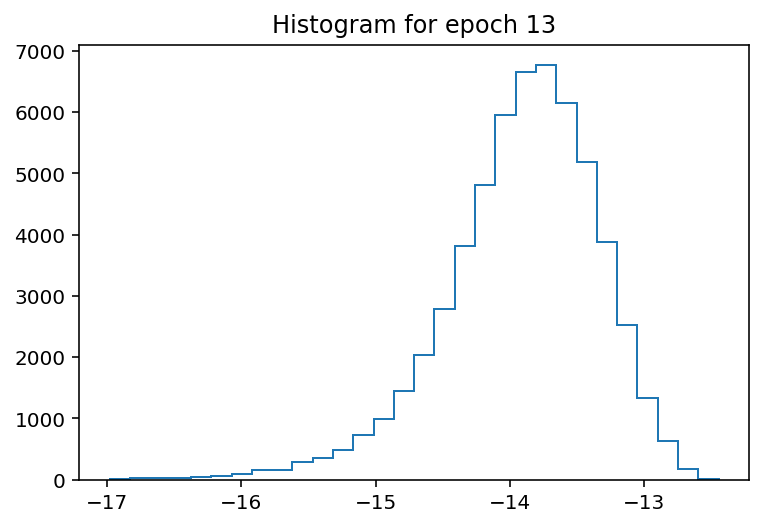

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max
/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


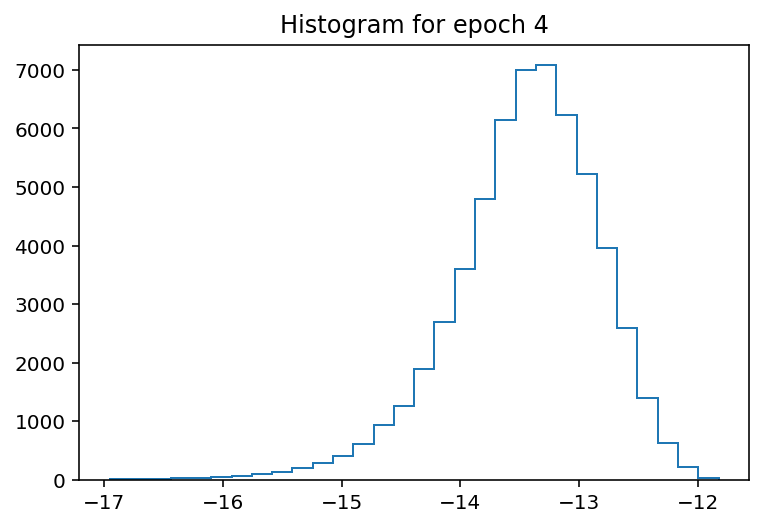

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


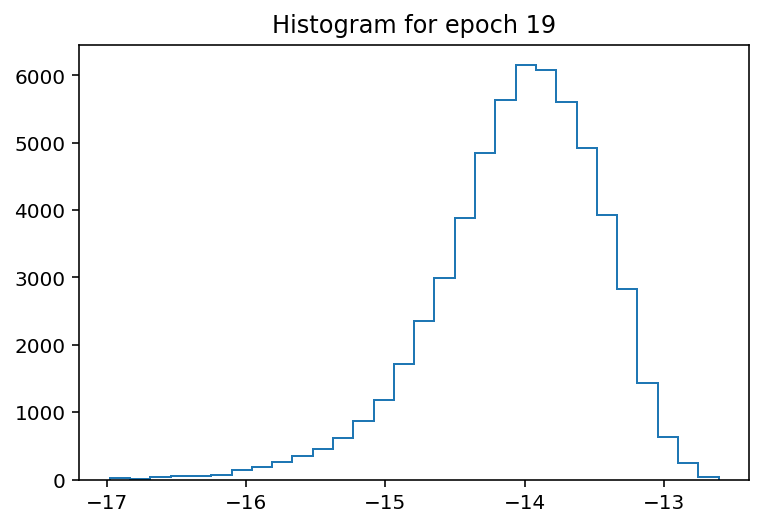

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


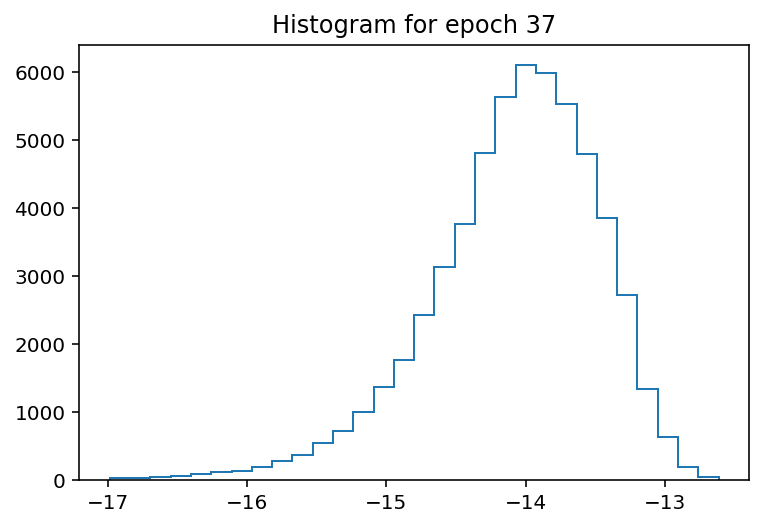

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


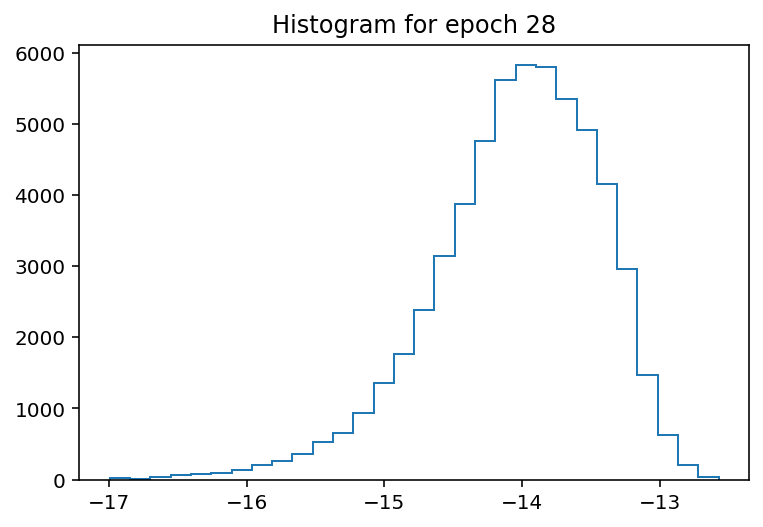

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


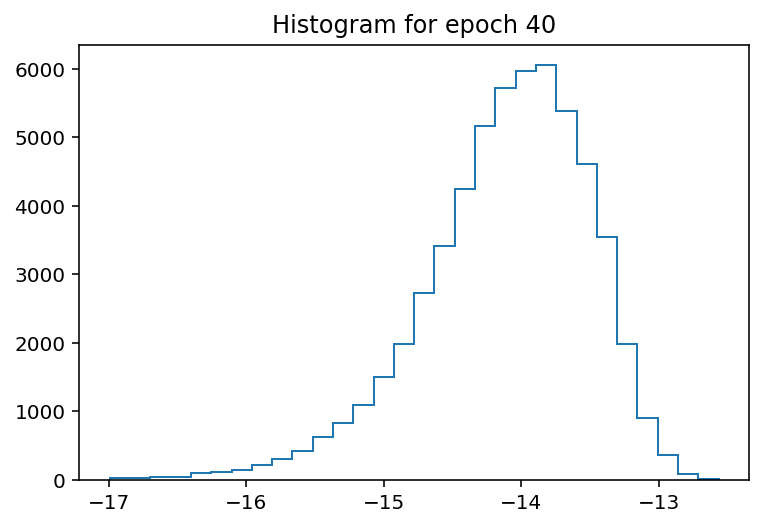

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


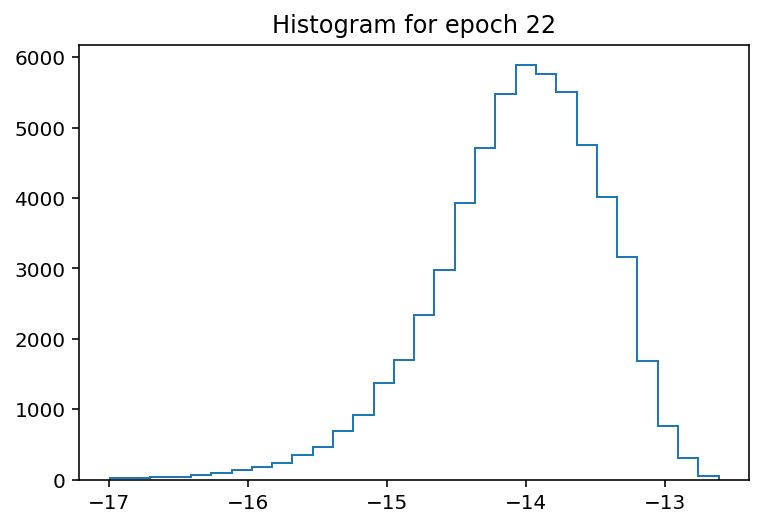

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


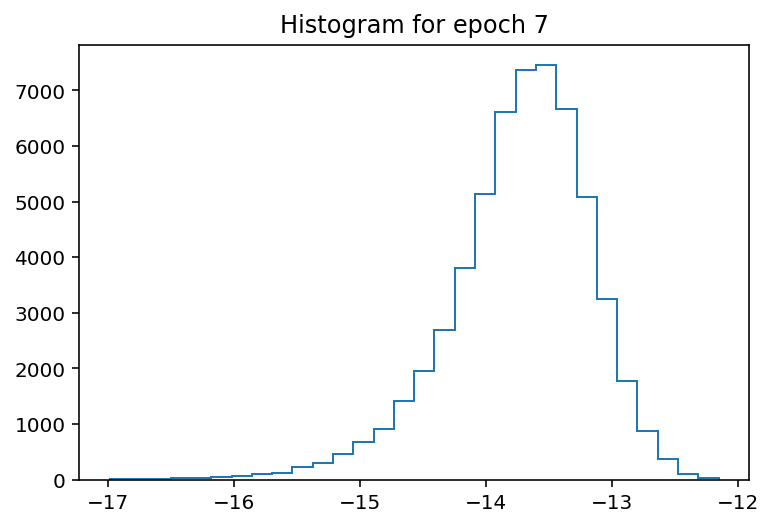

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


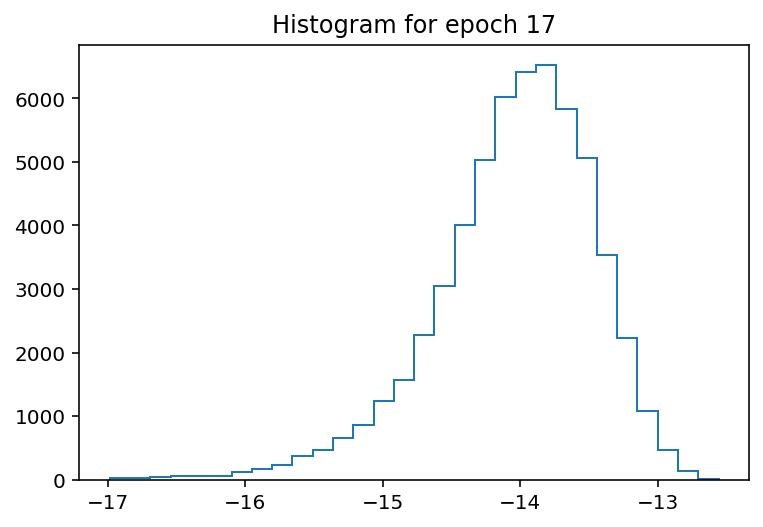

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


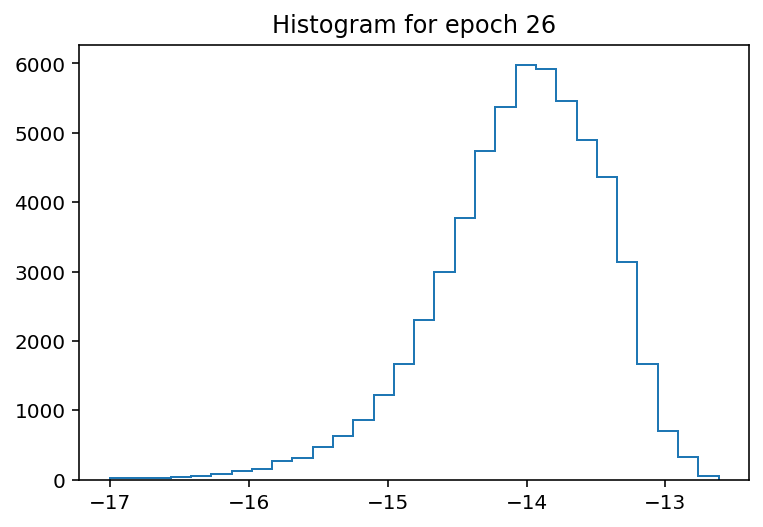

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


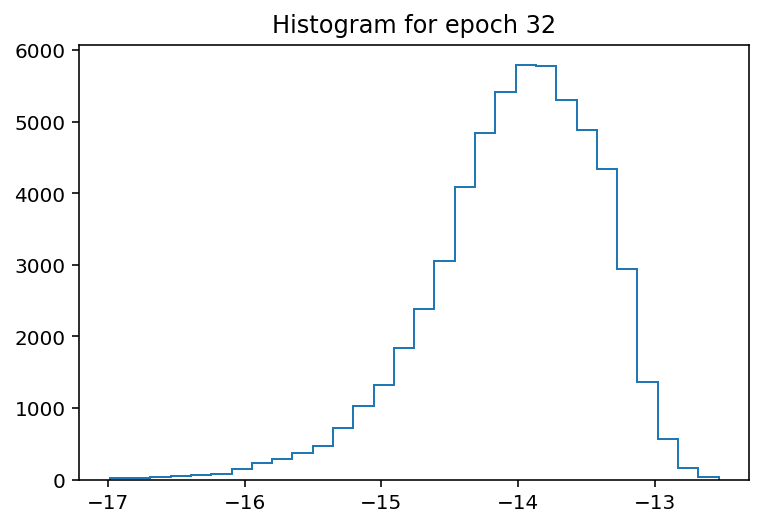

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


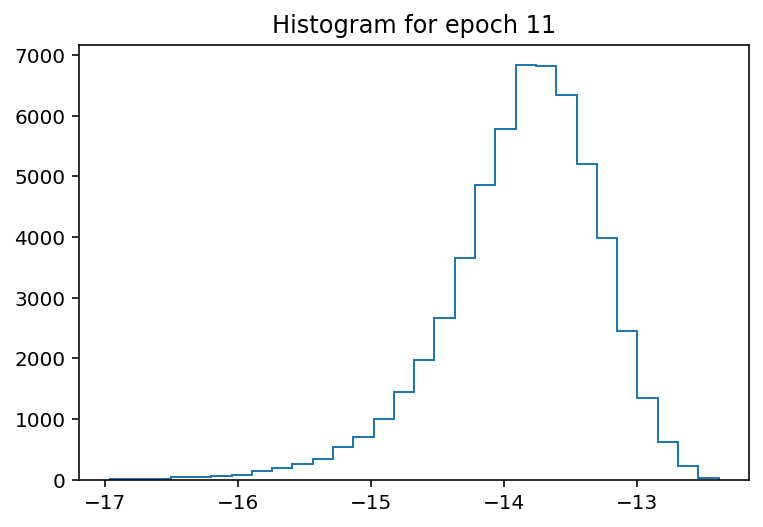

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


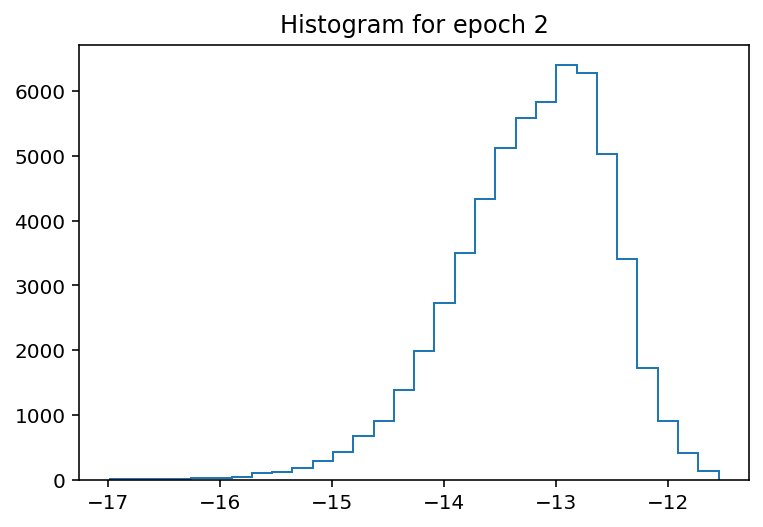

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


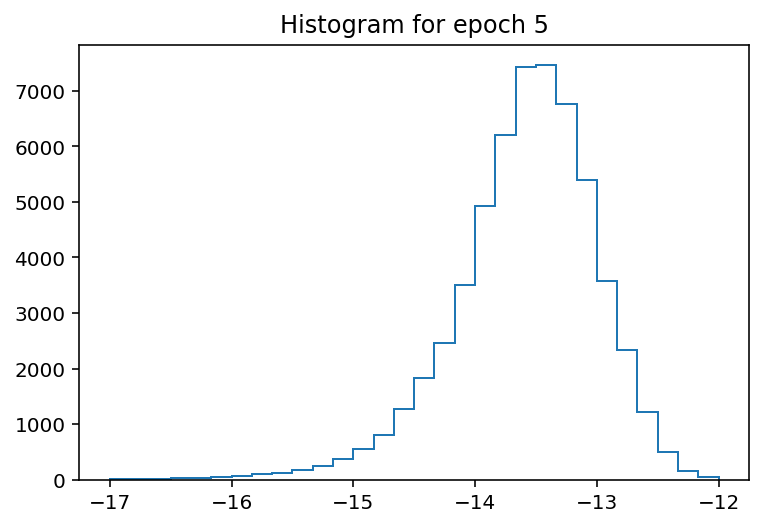

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


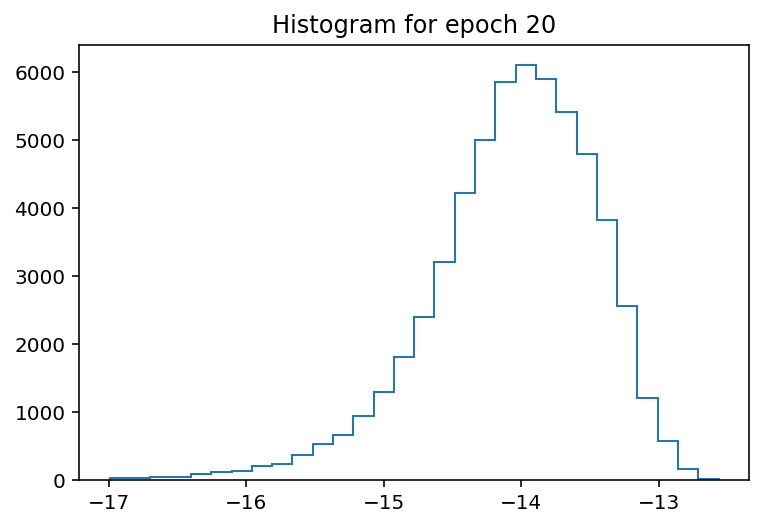

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


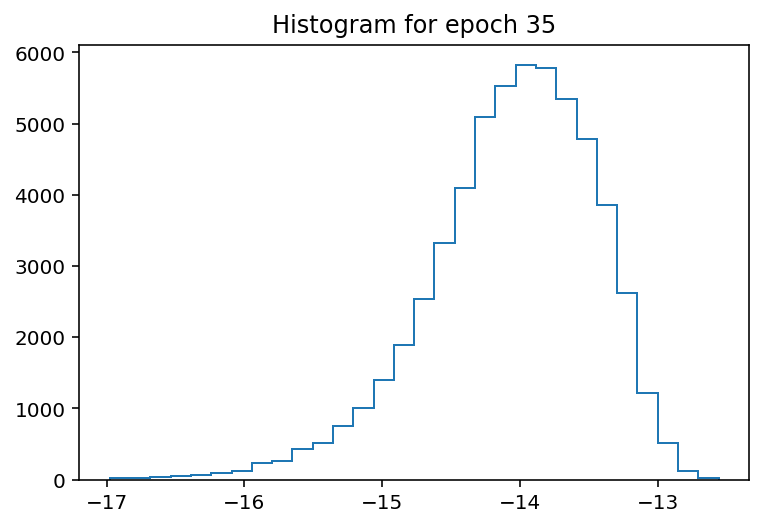

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


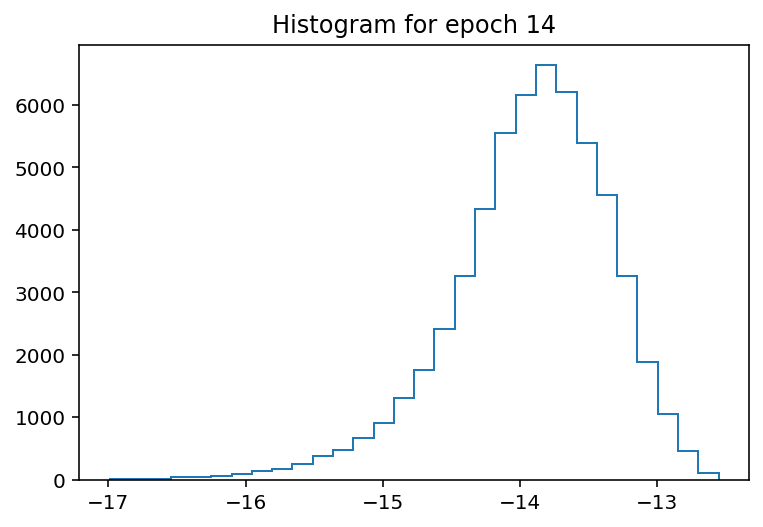

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


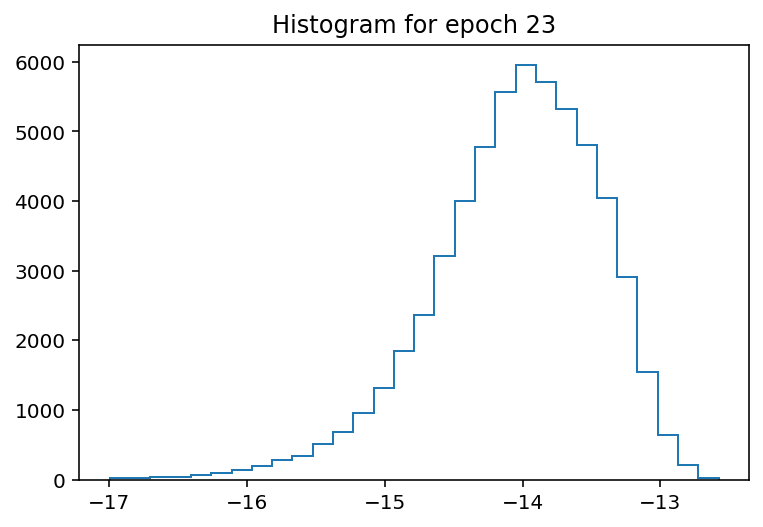

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


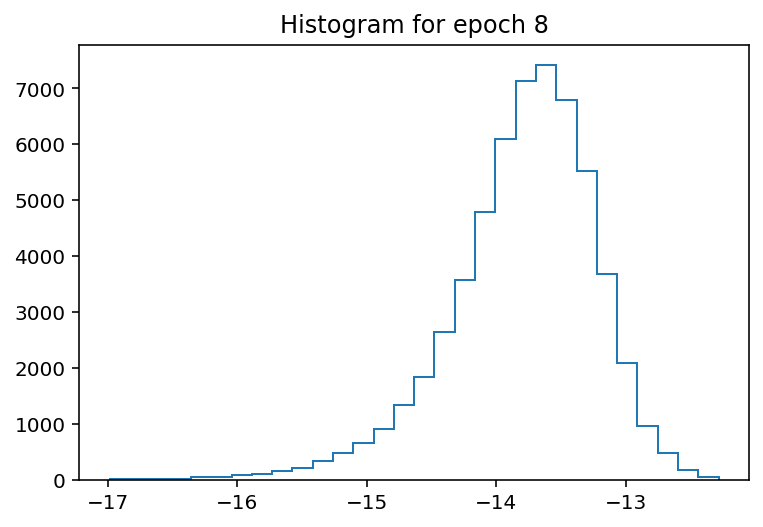

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


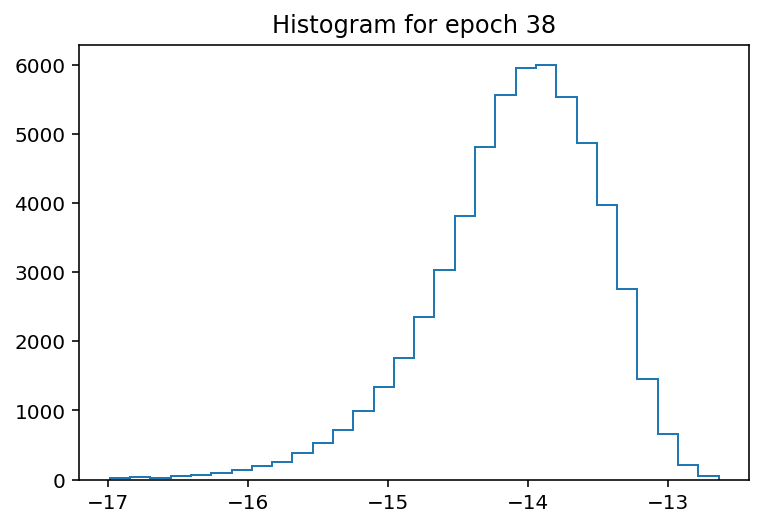

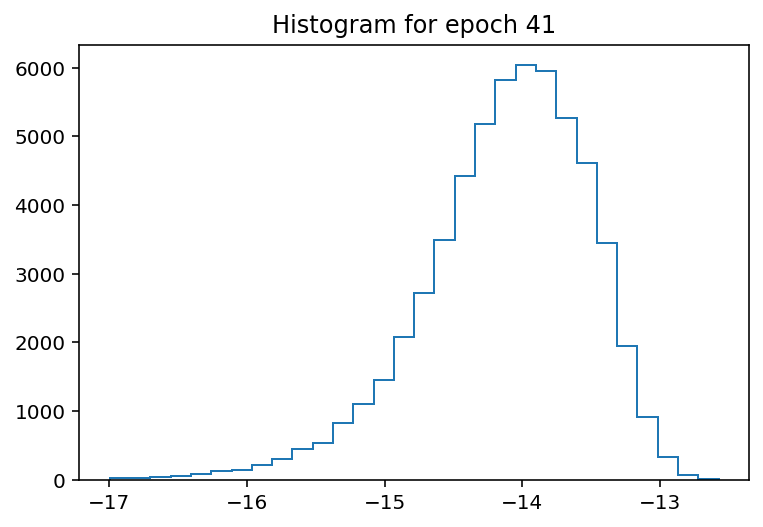

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max
/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


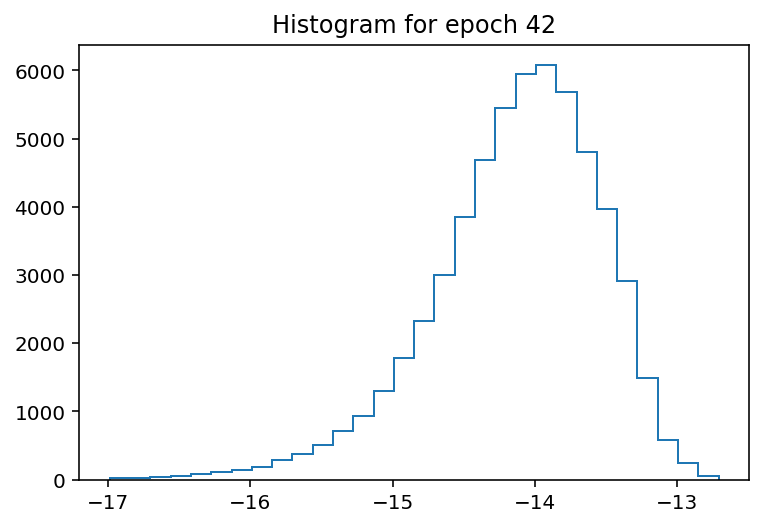

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


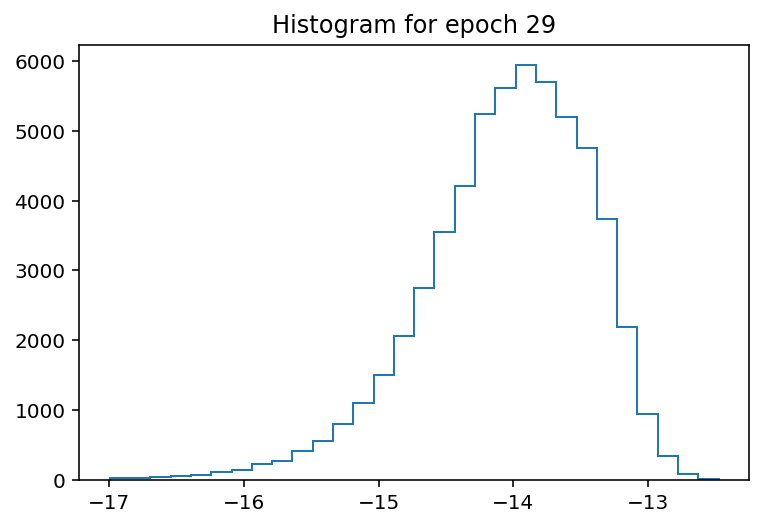

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


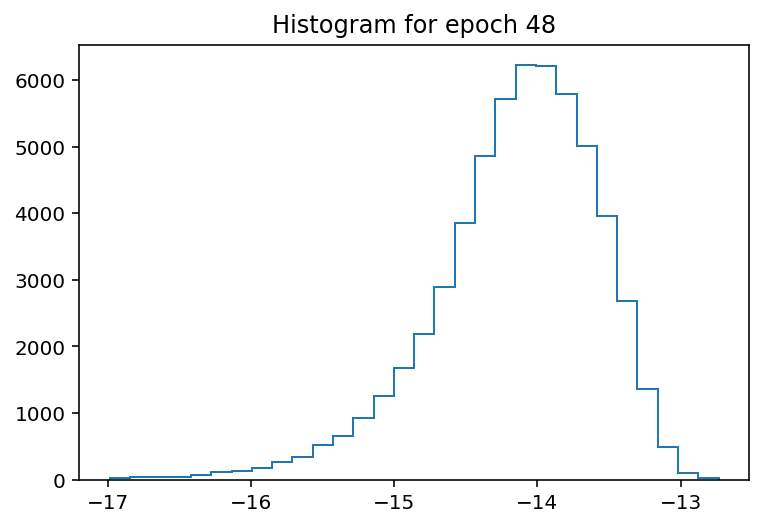

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


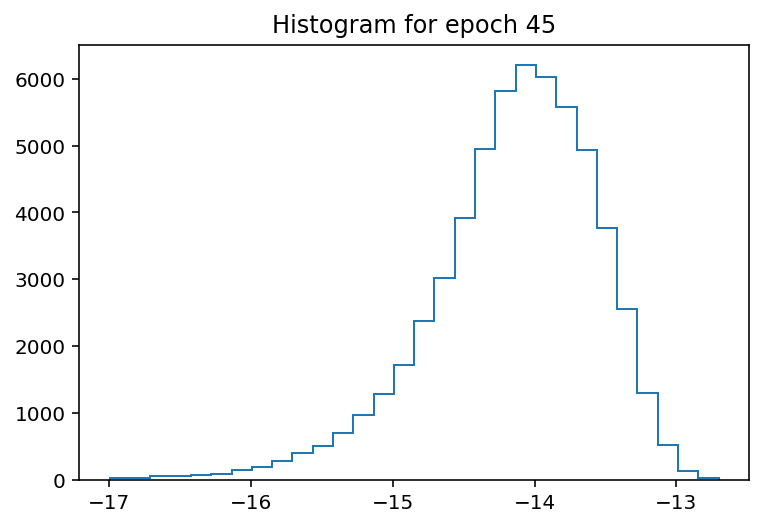

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


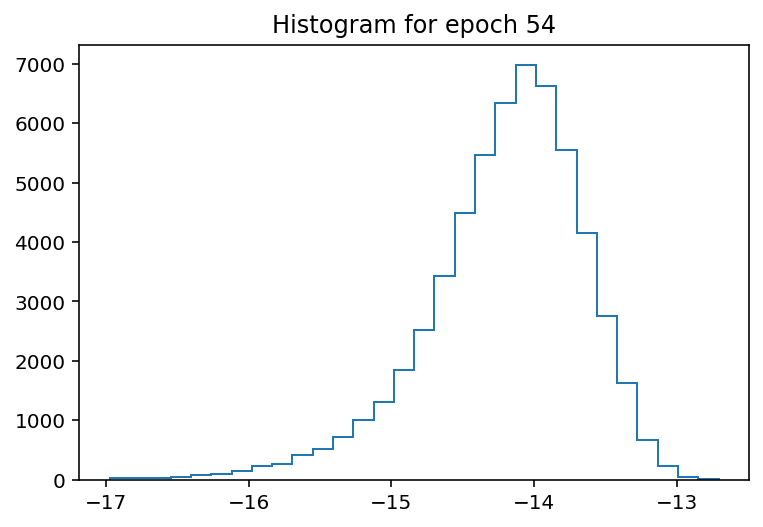

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


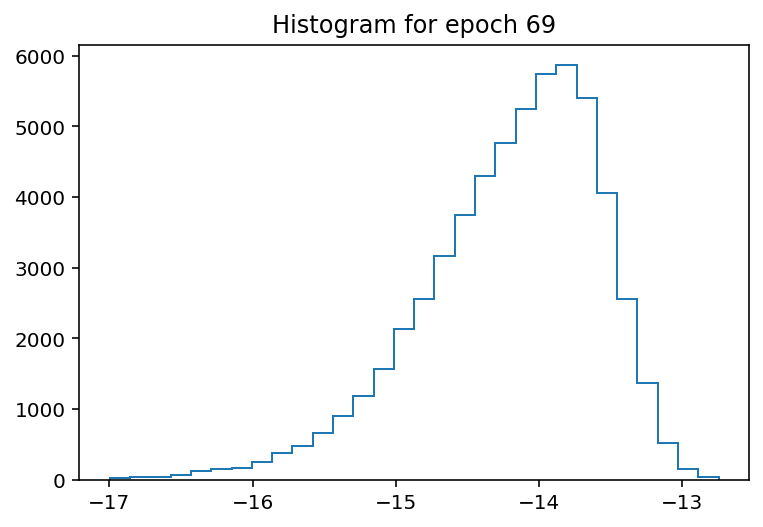

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


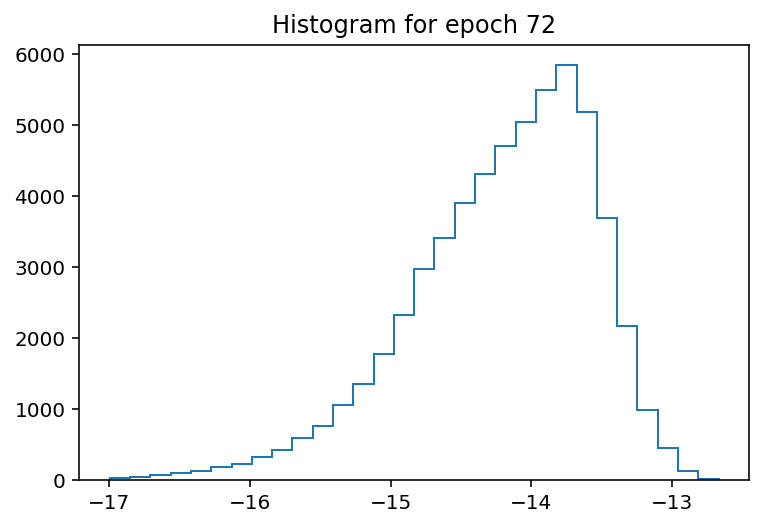

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


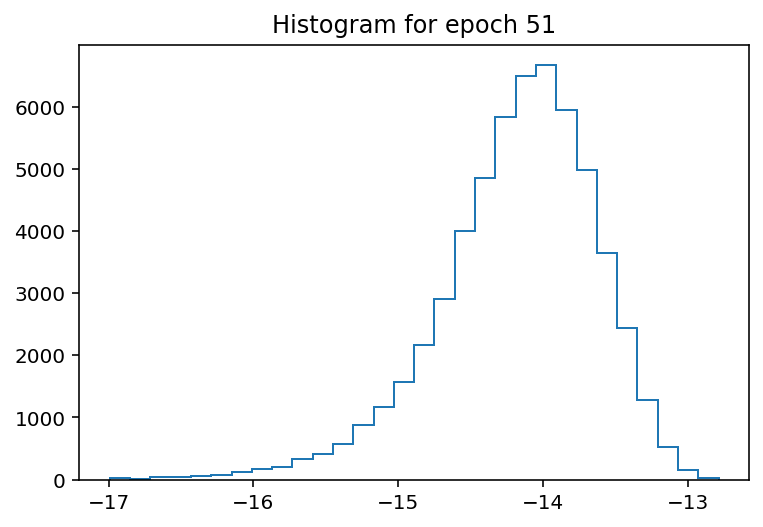

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


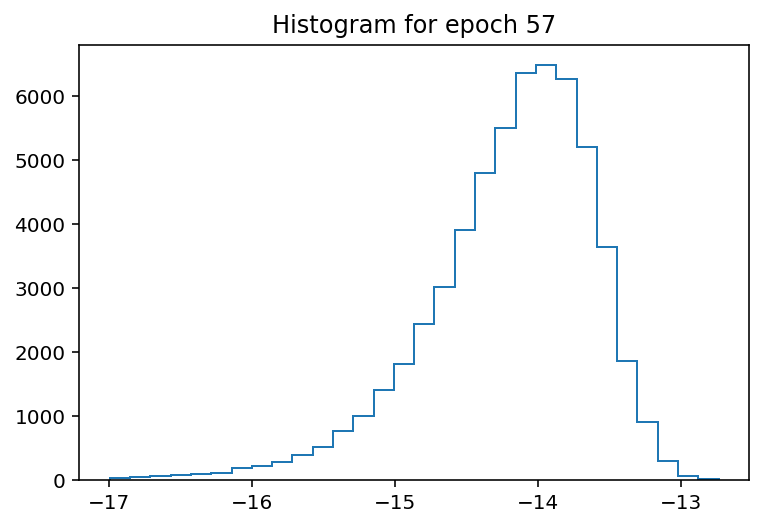

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


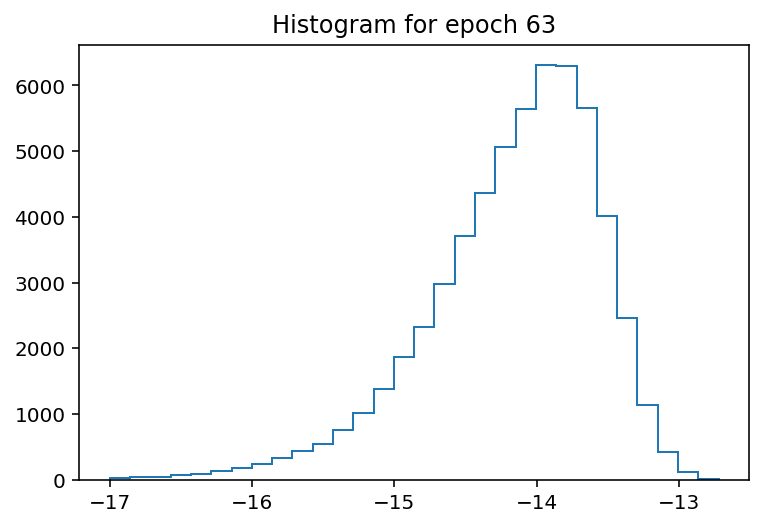

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


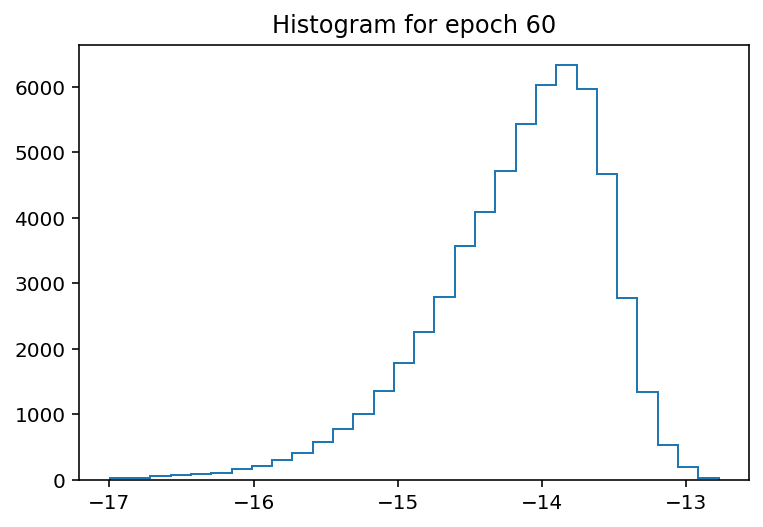

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


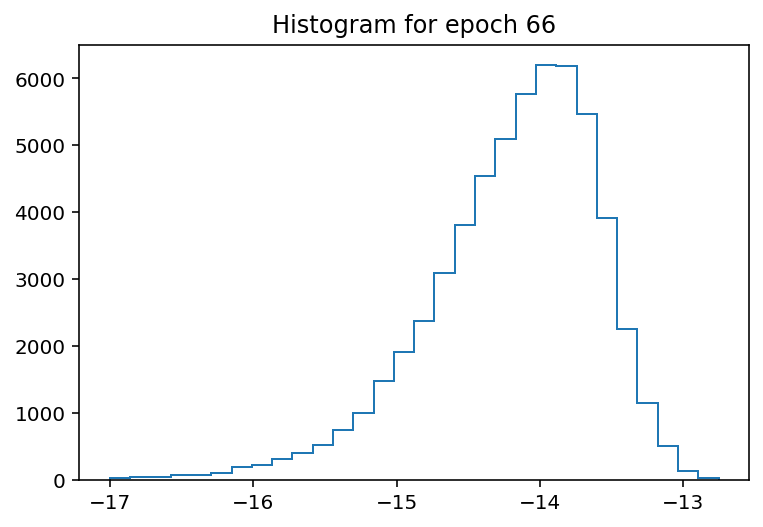

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


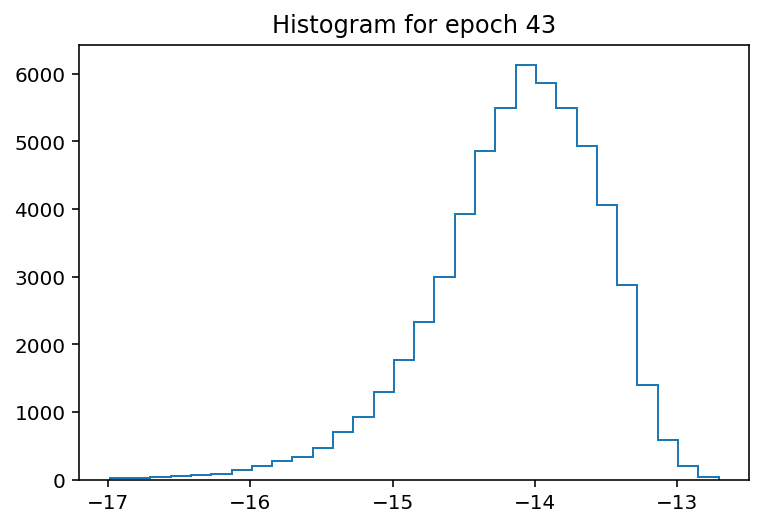

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


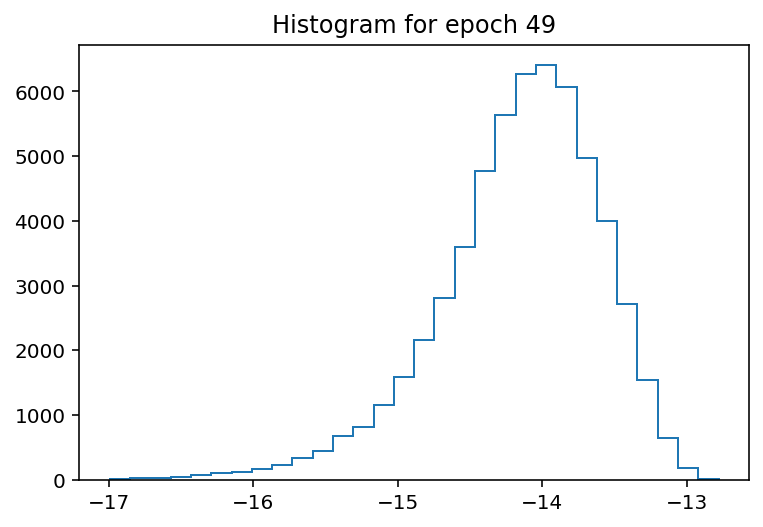

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


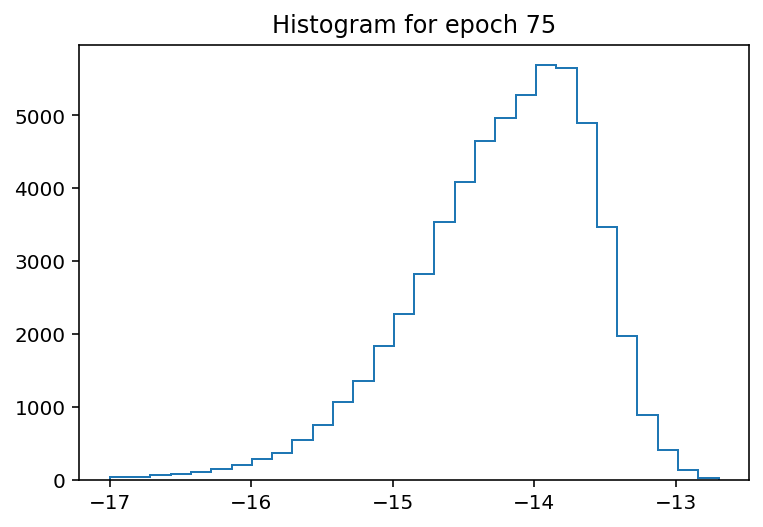

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


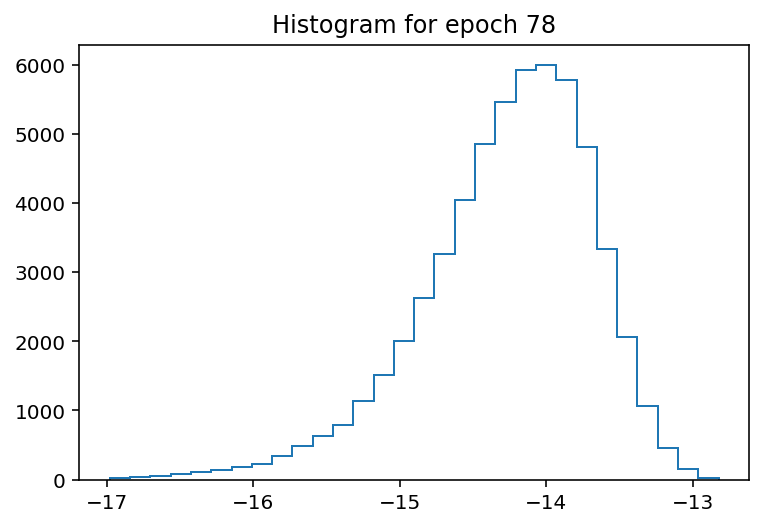

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


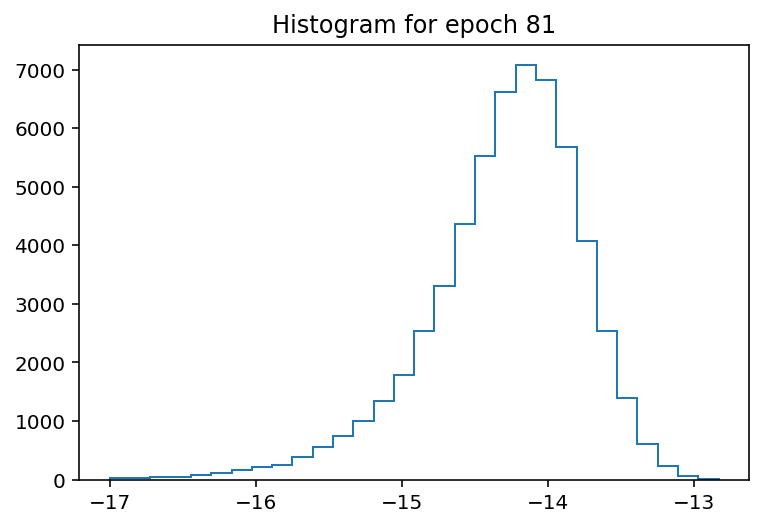

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


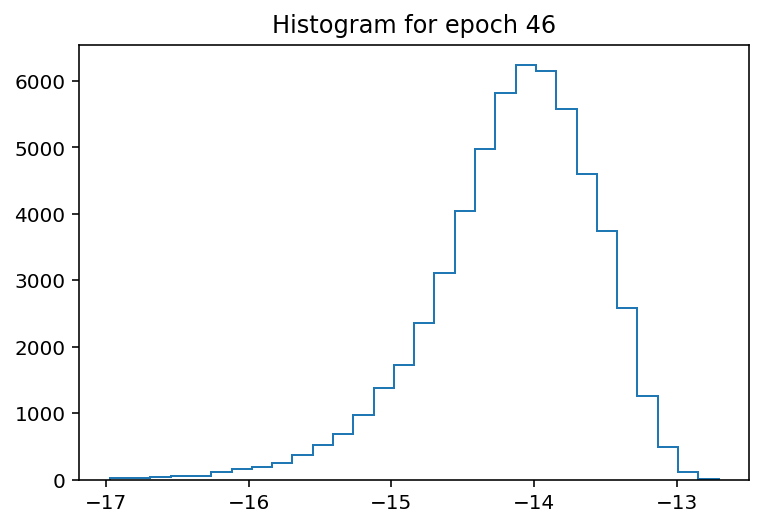

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


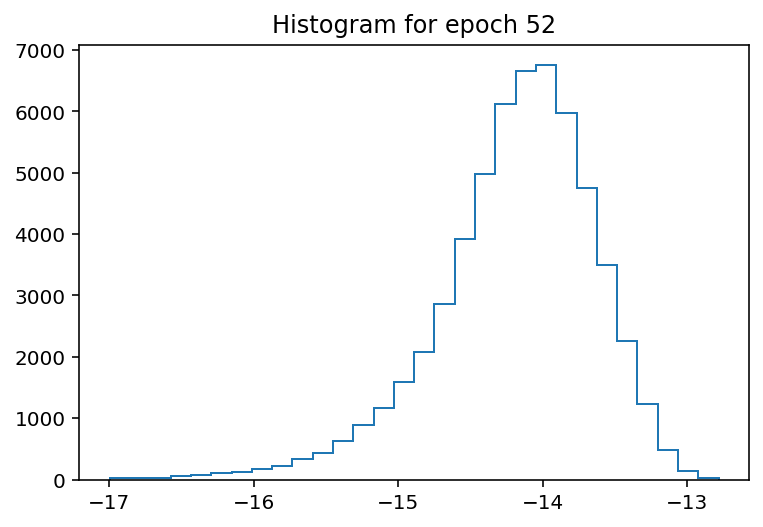

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


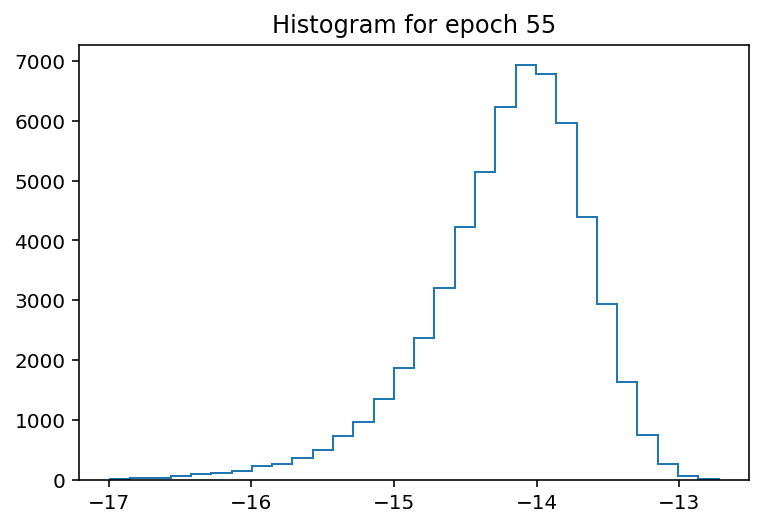

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


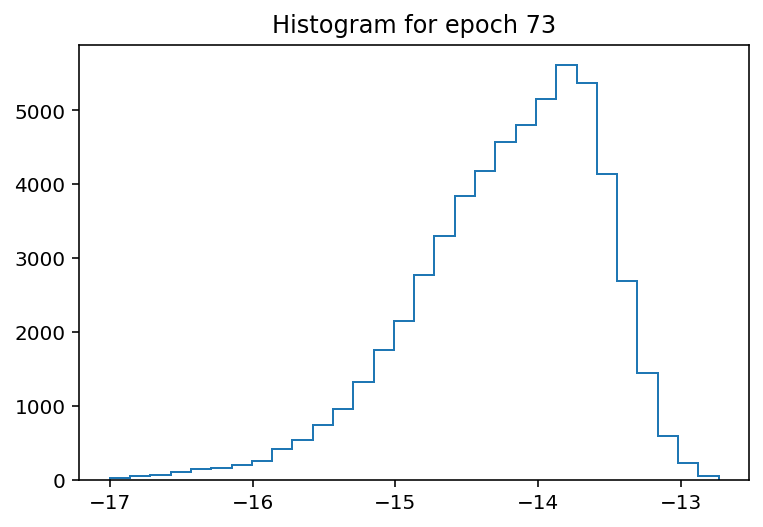

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


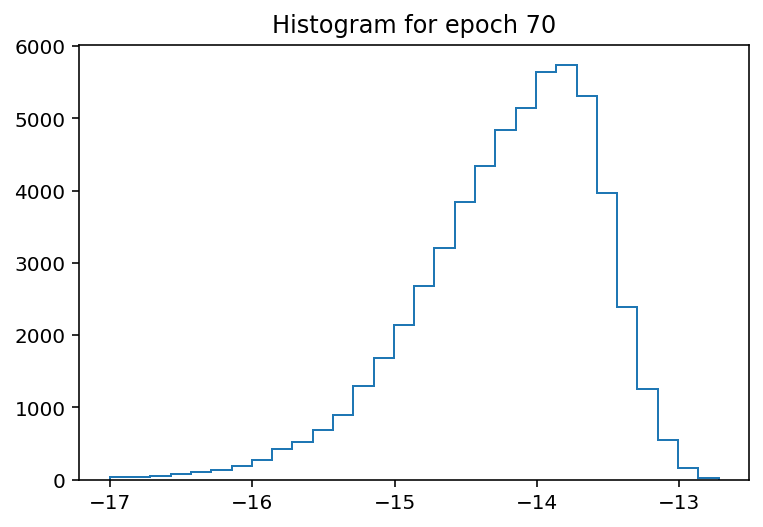

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


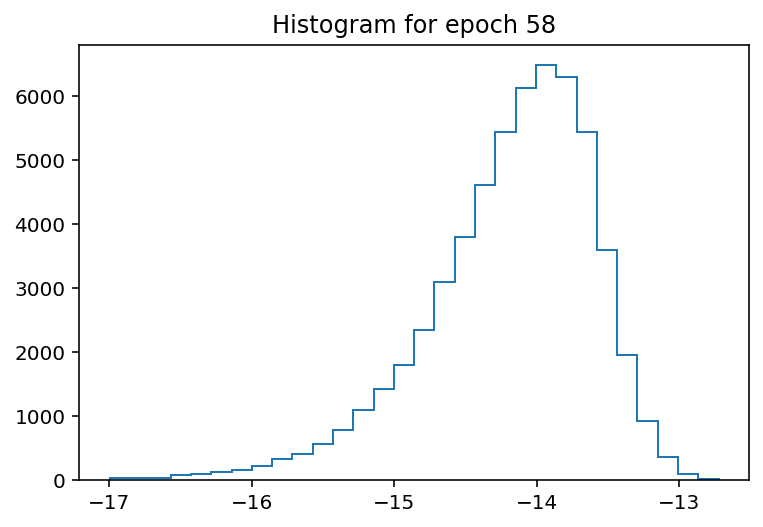

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


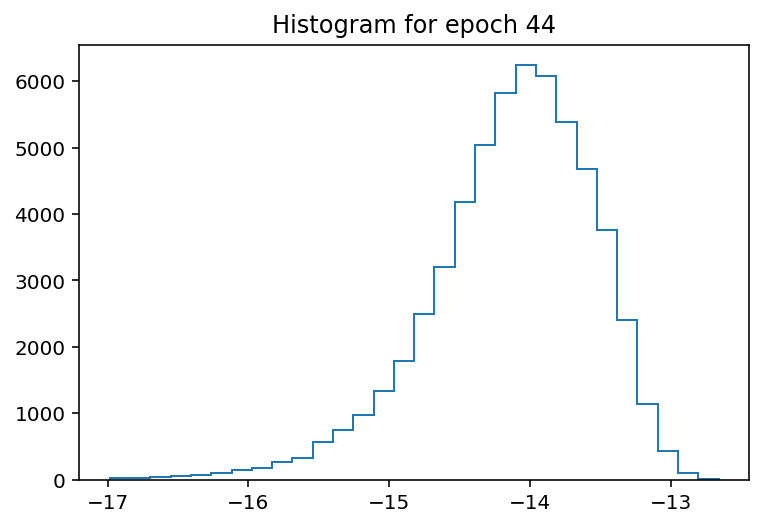

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


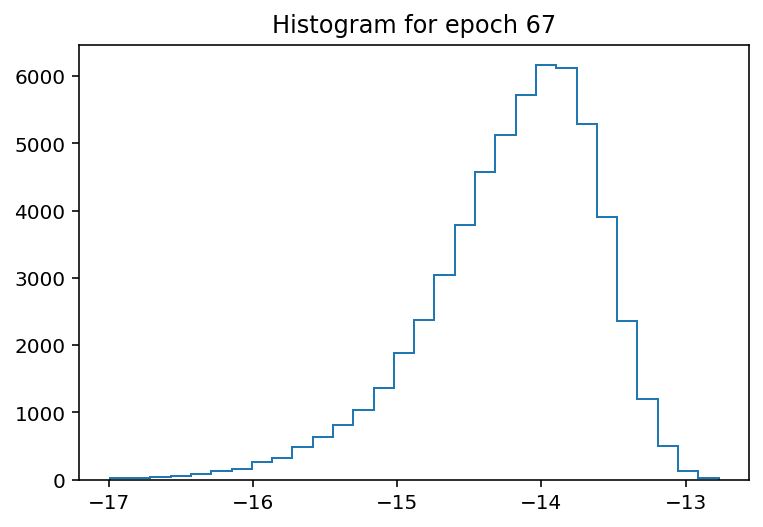

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


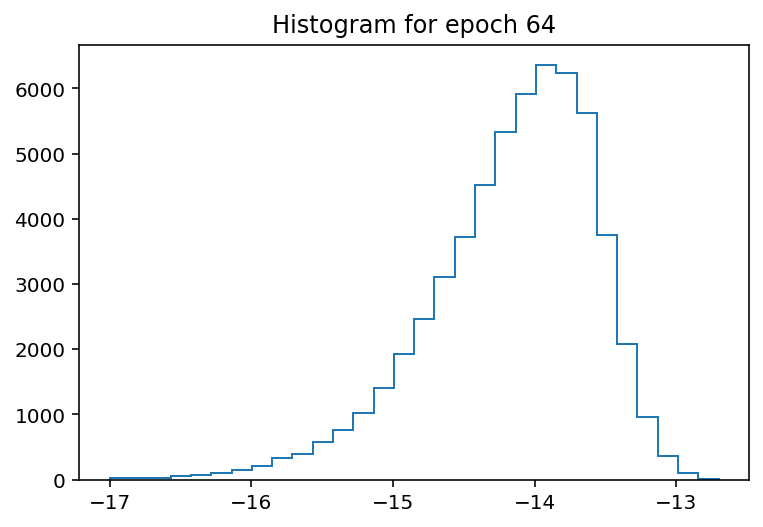

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


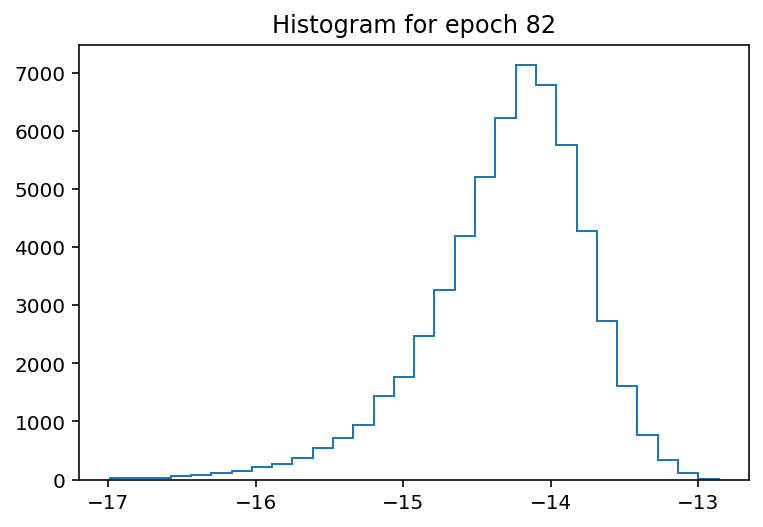

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


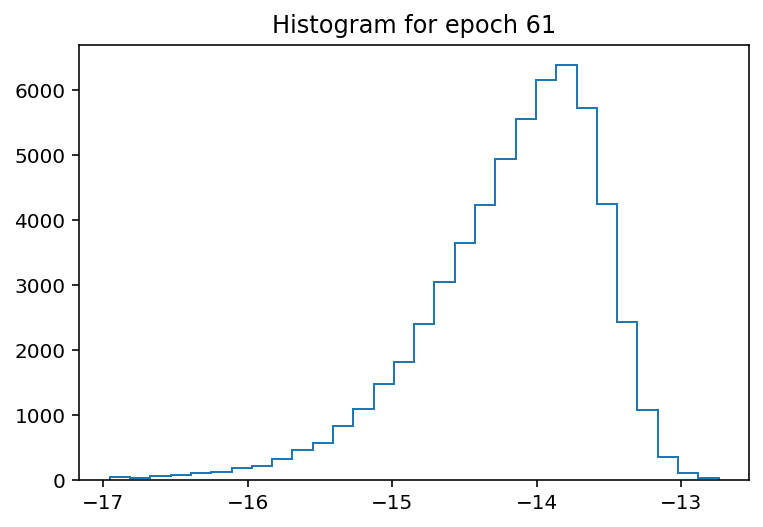

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


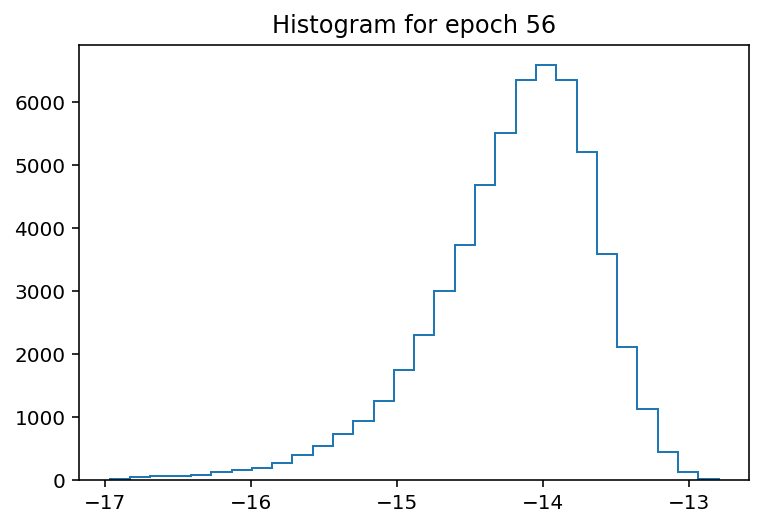

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


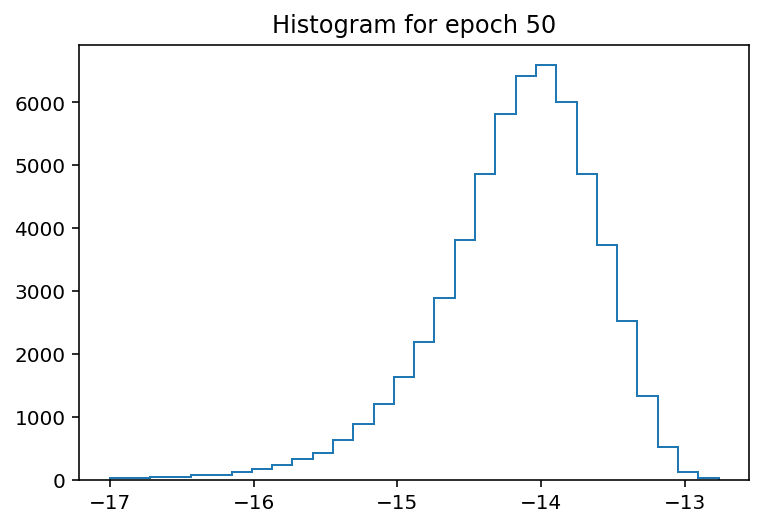

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


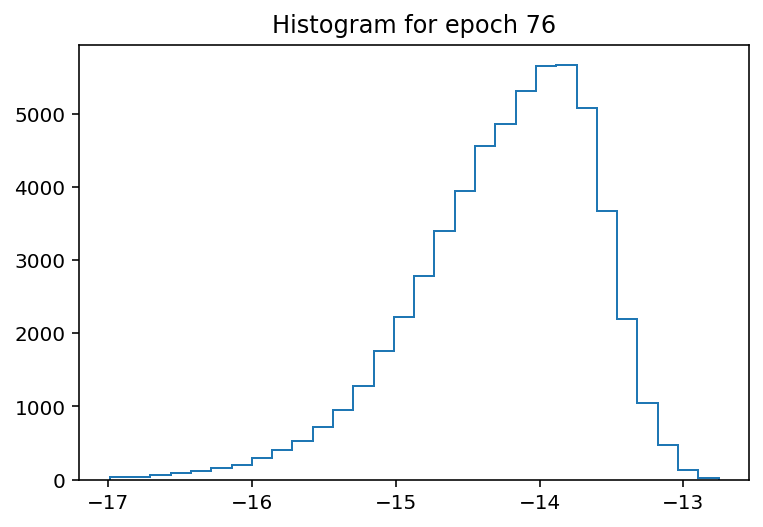

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


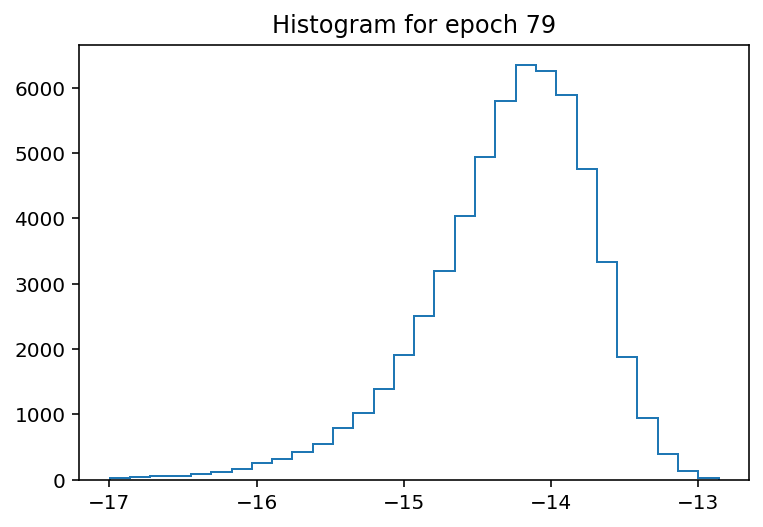

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


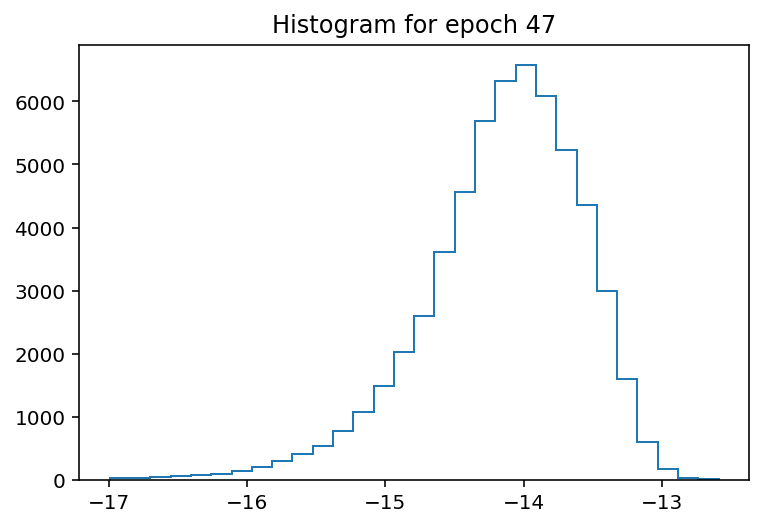

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


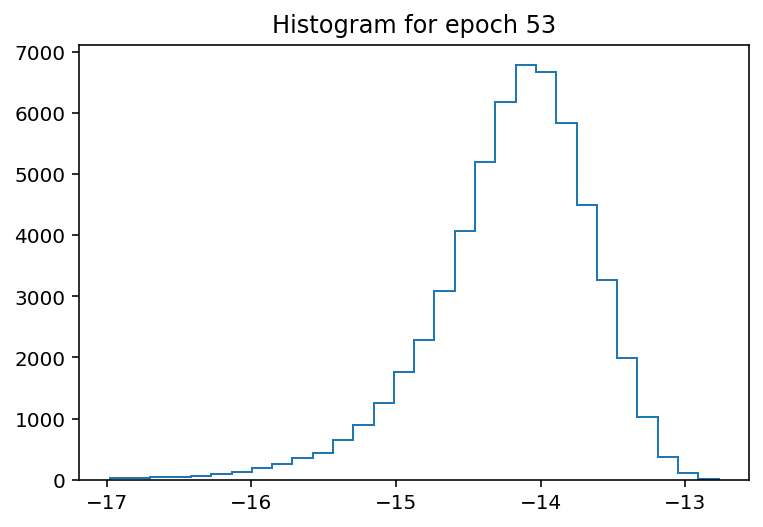

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


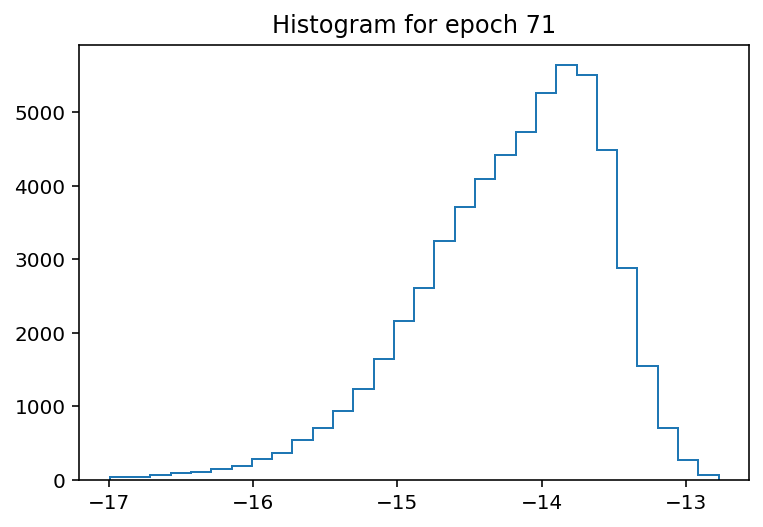

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


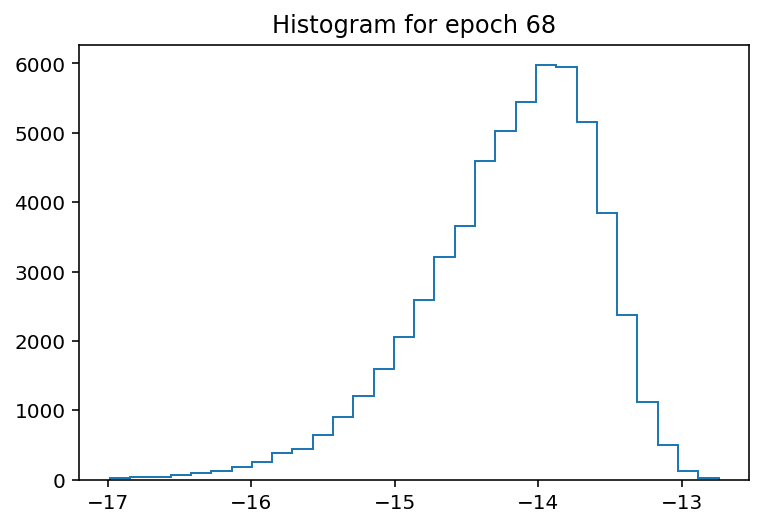

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


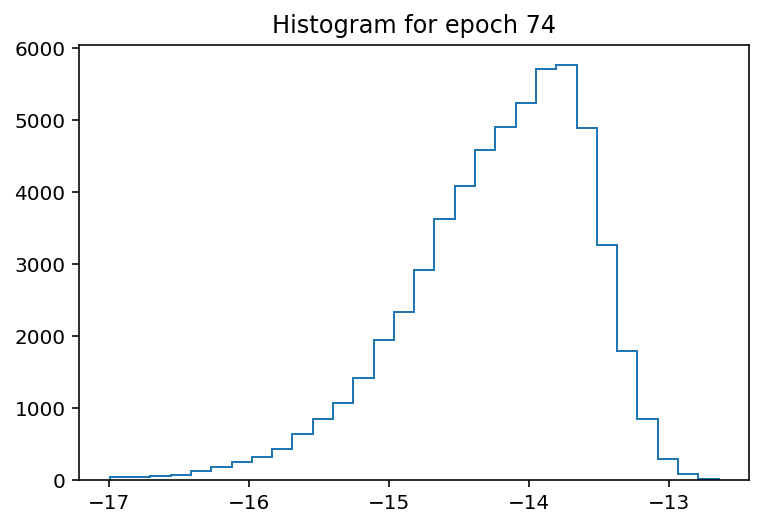

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


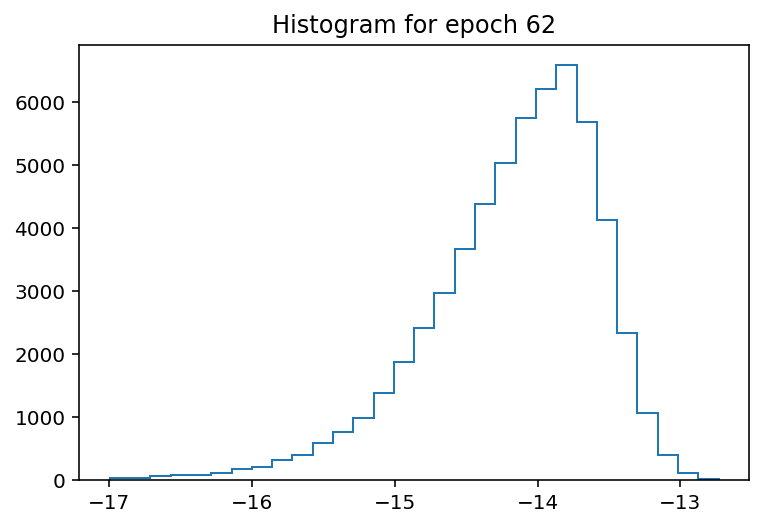

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


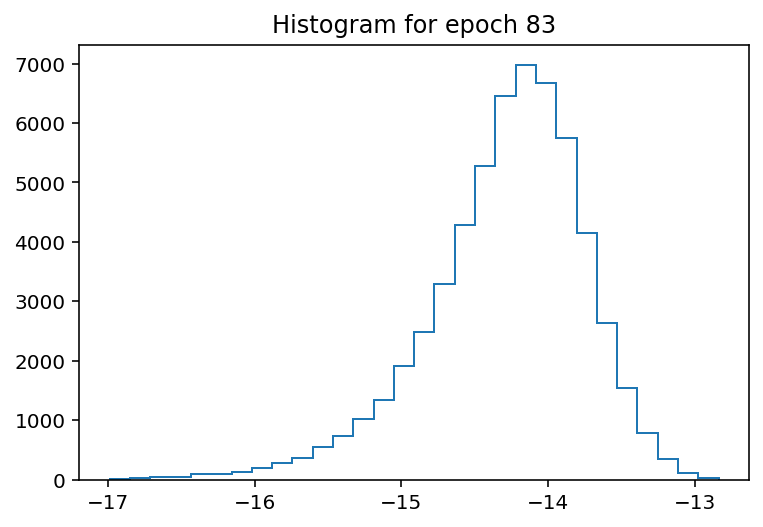

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


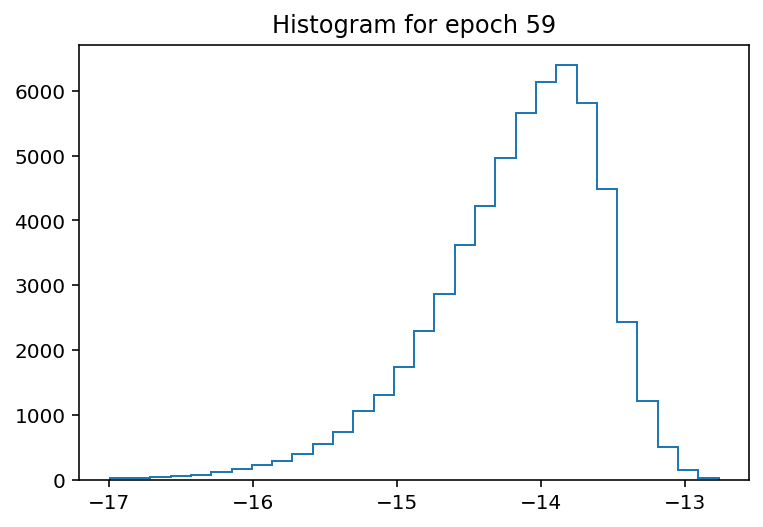

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


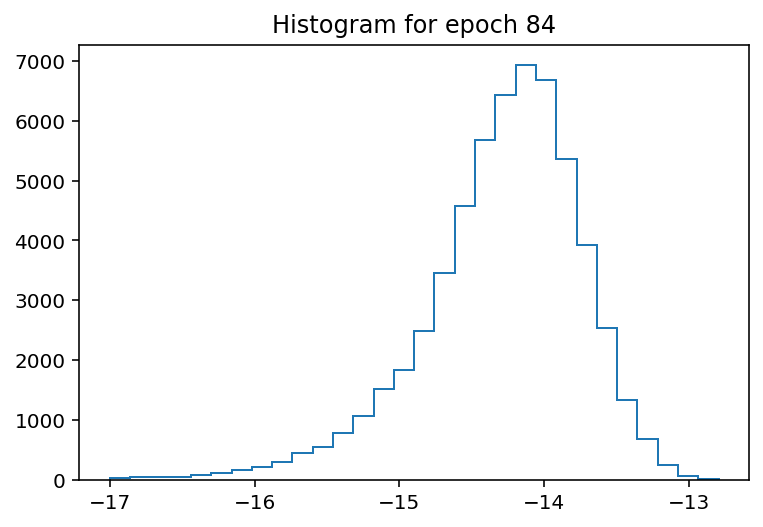

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


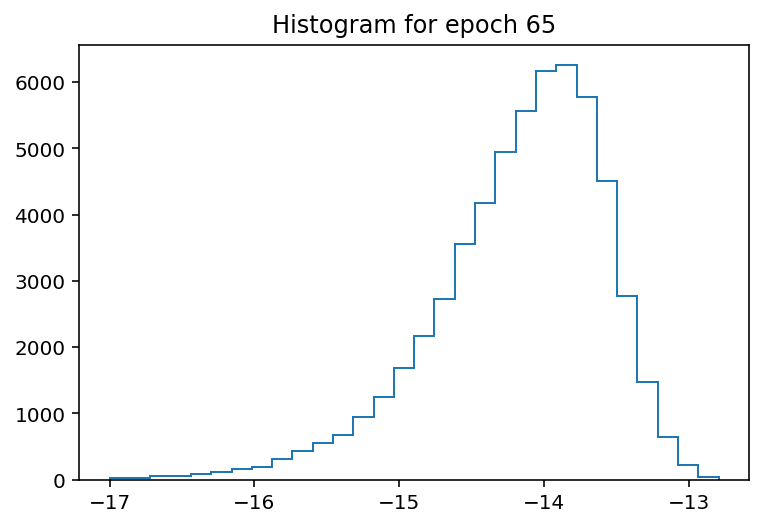

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


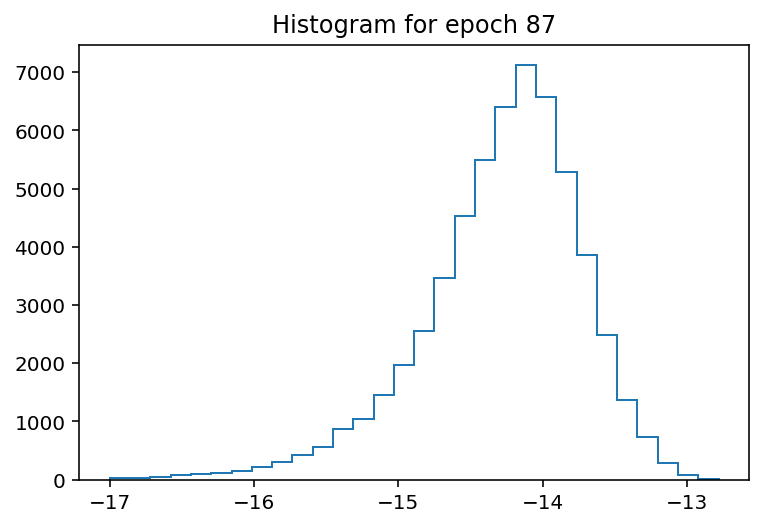

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


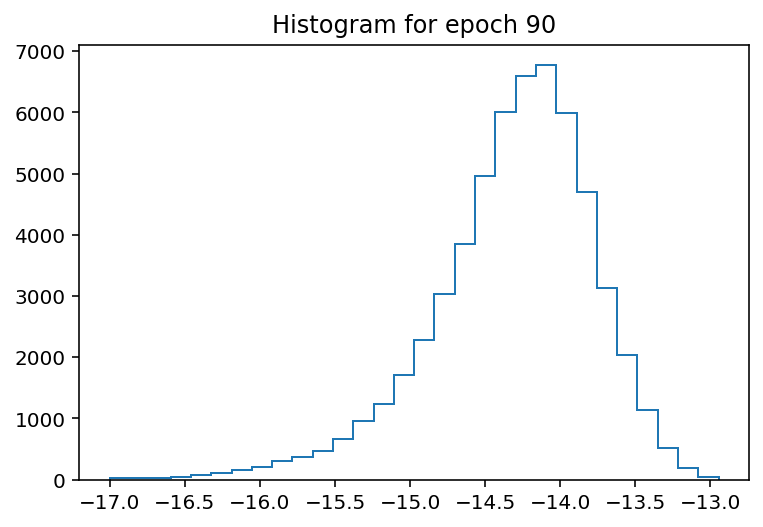

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


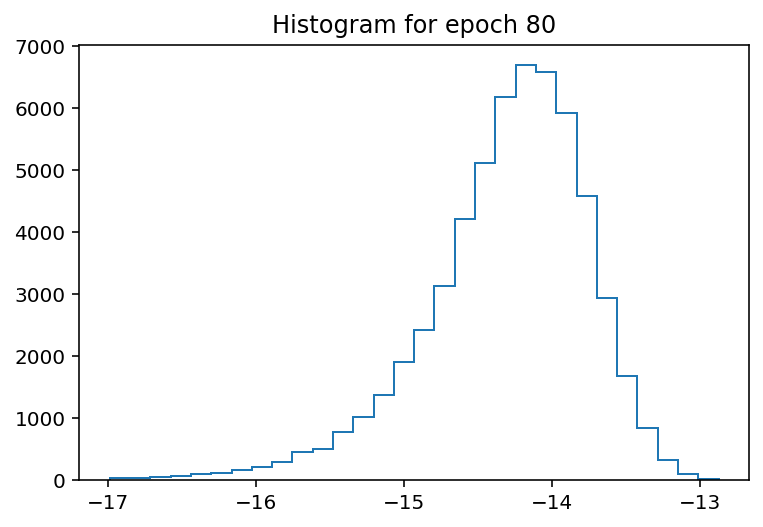

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


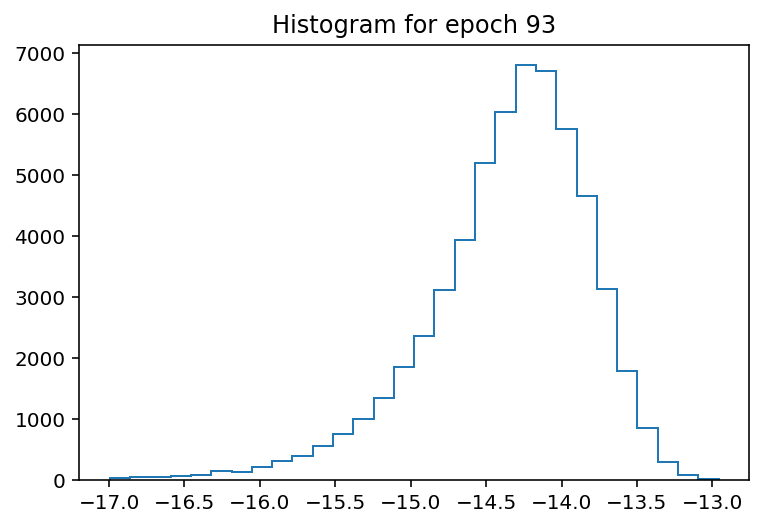

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


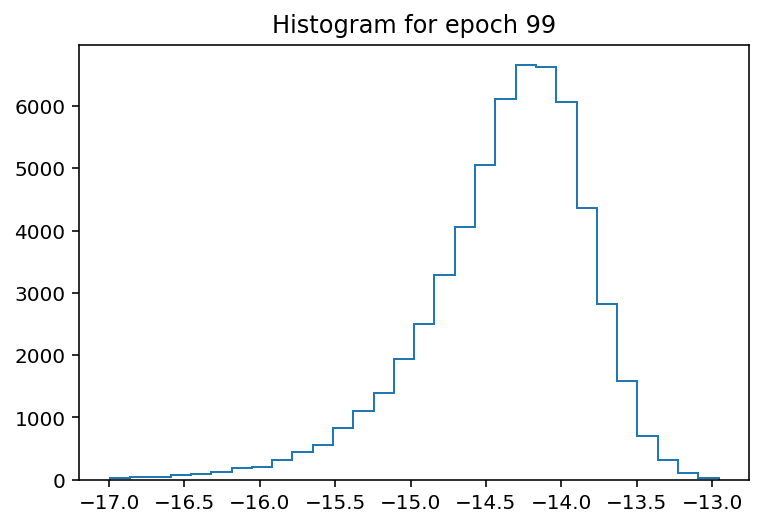

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


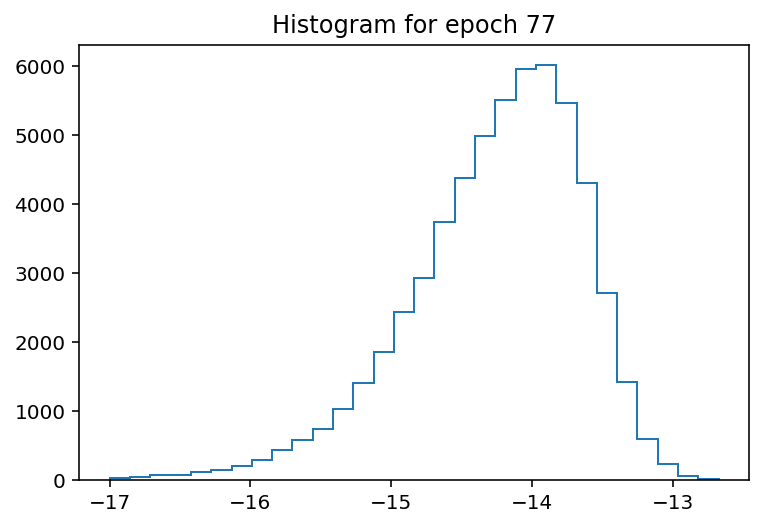

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


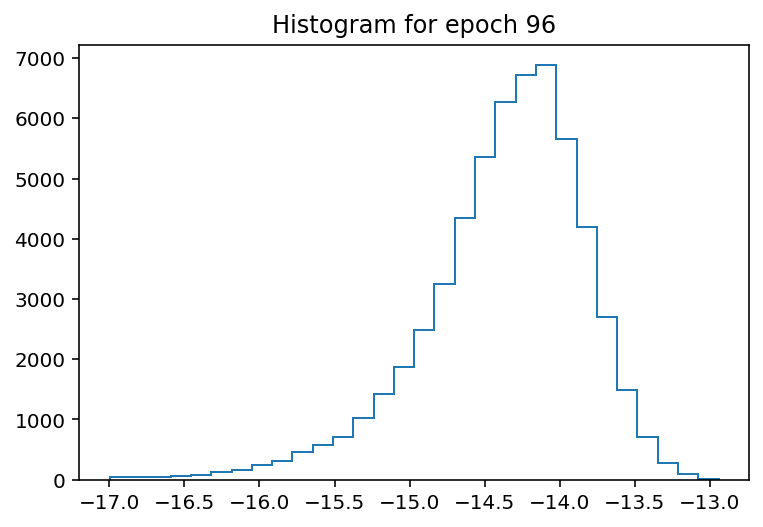

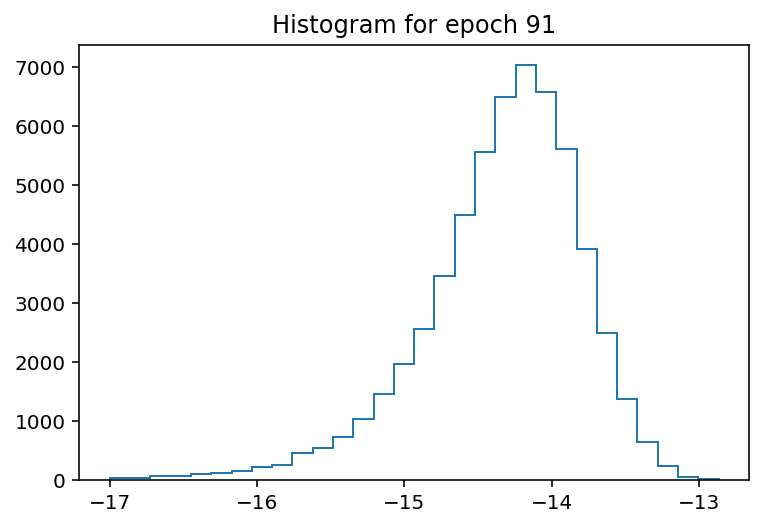

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max
/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


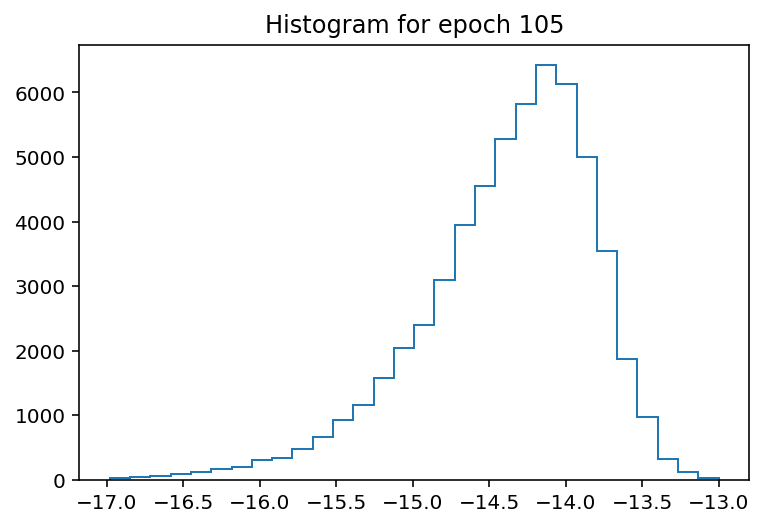

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


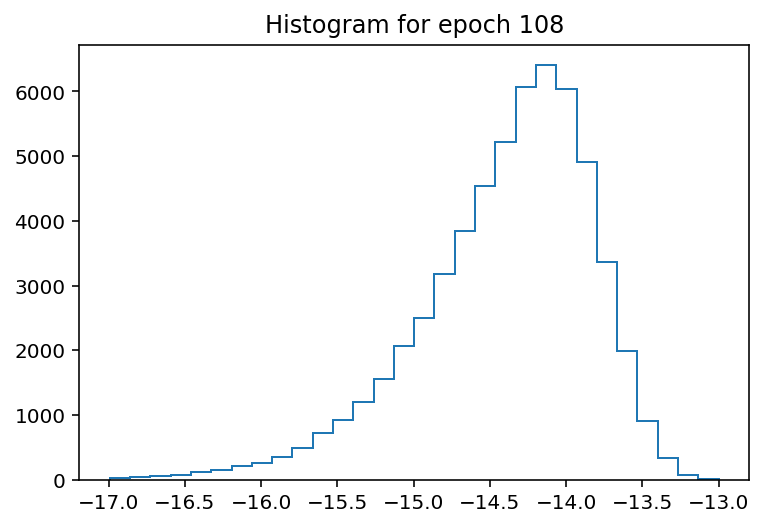

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


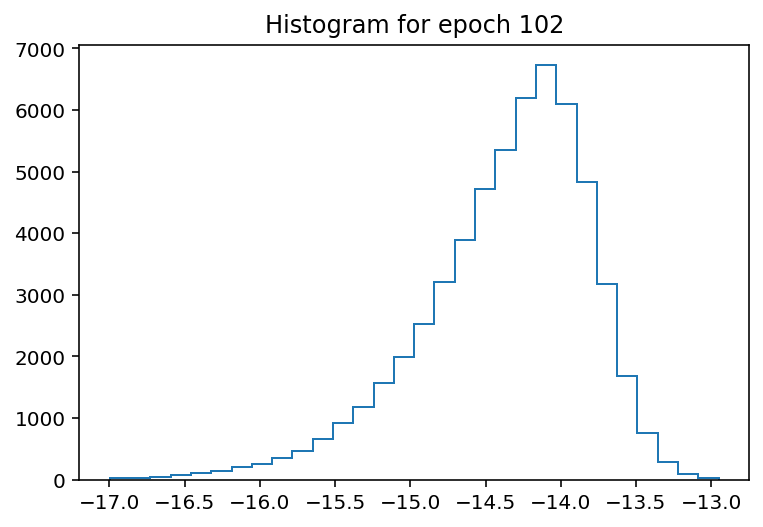

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


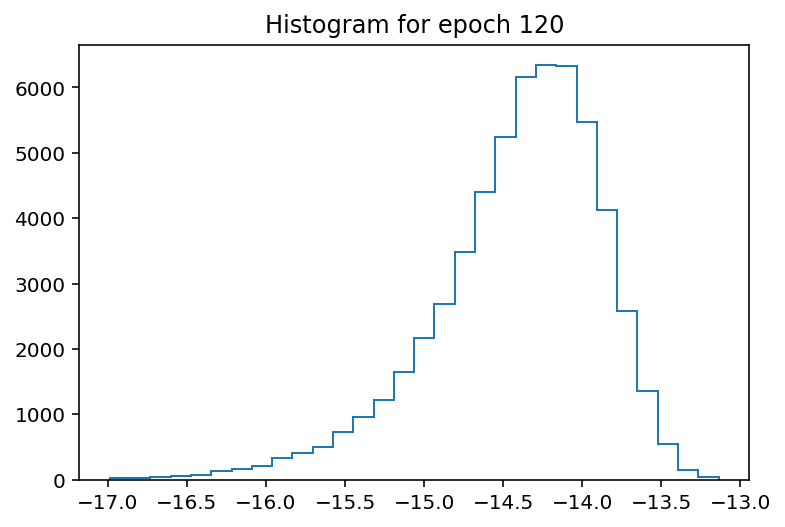

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


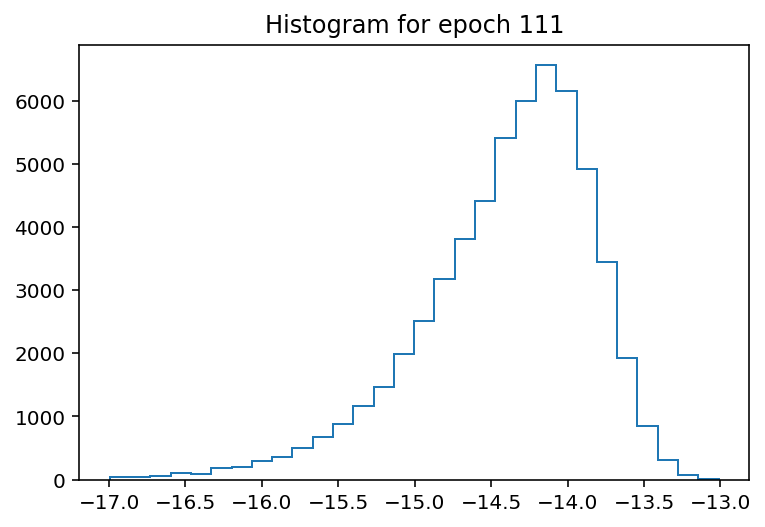

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


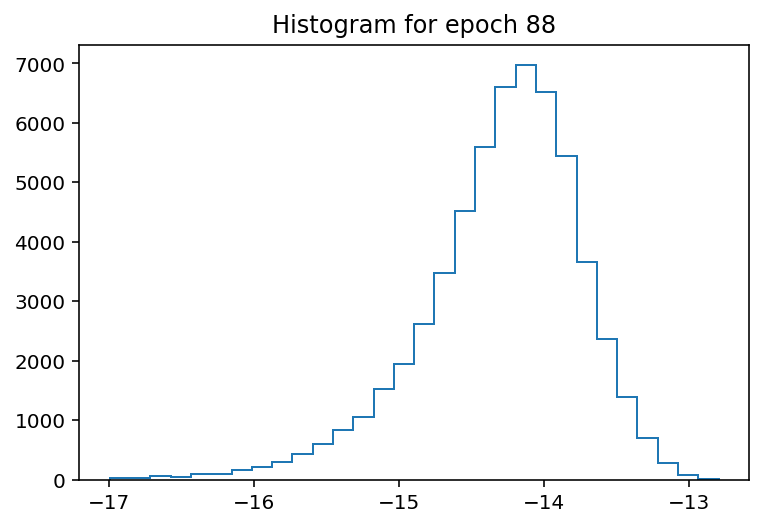

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


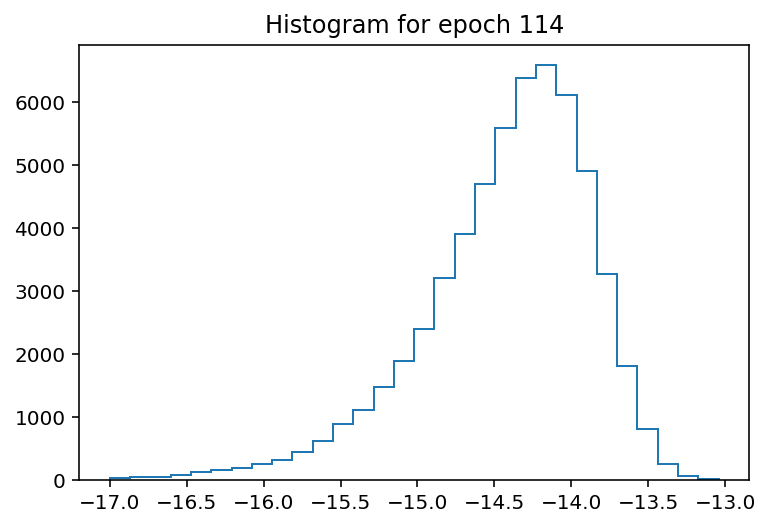

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


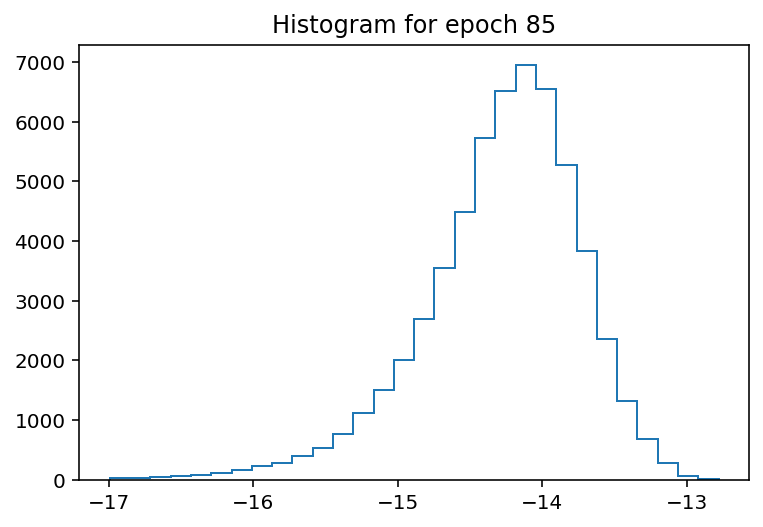

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


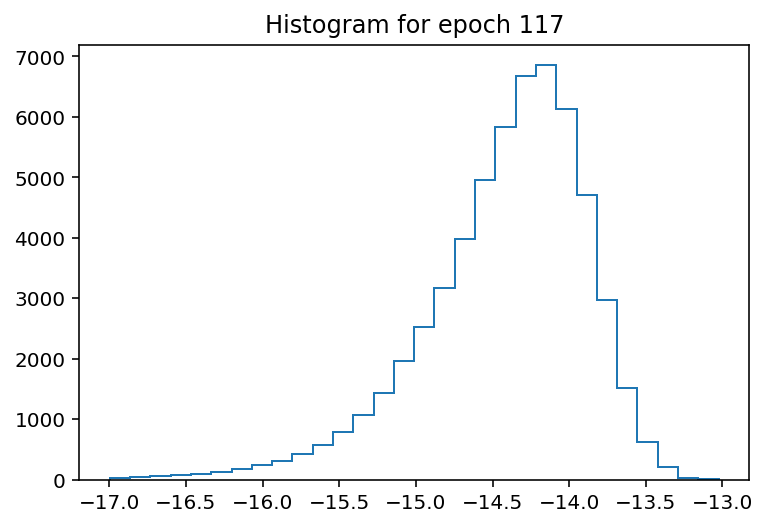

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


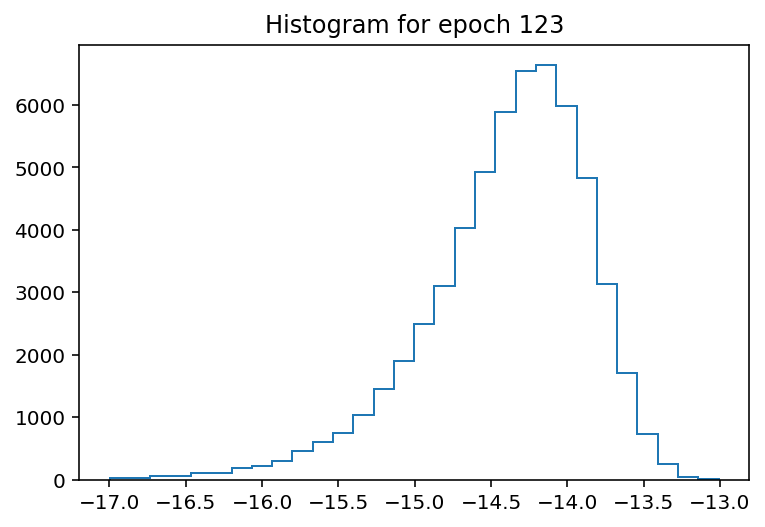

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


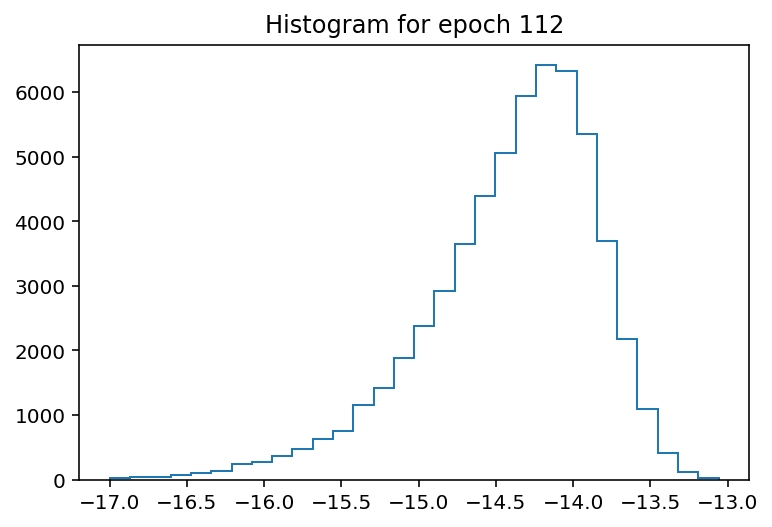

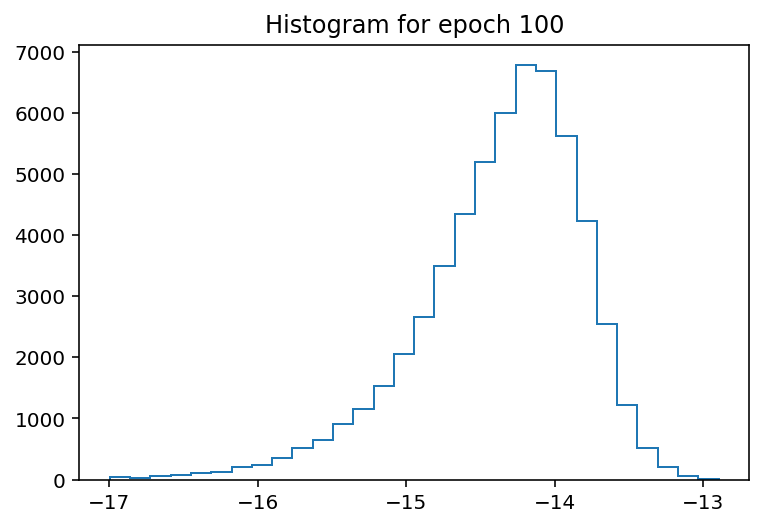

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max
/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


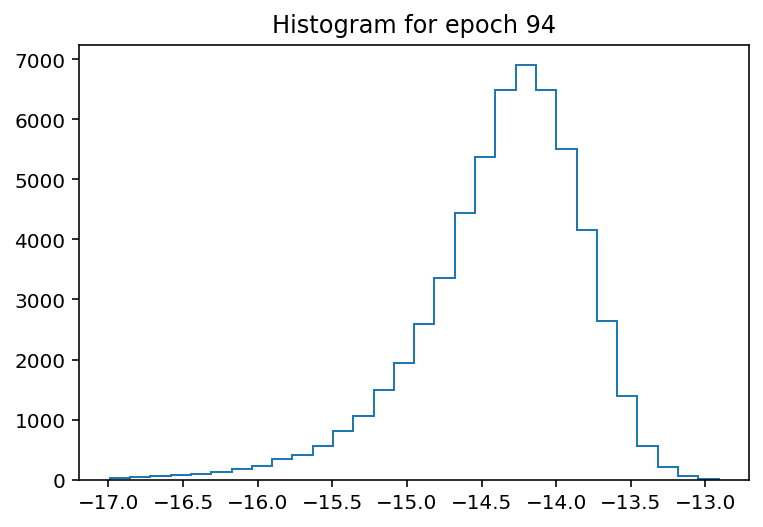

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


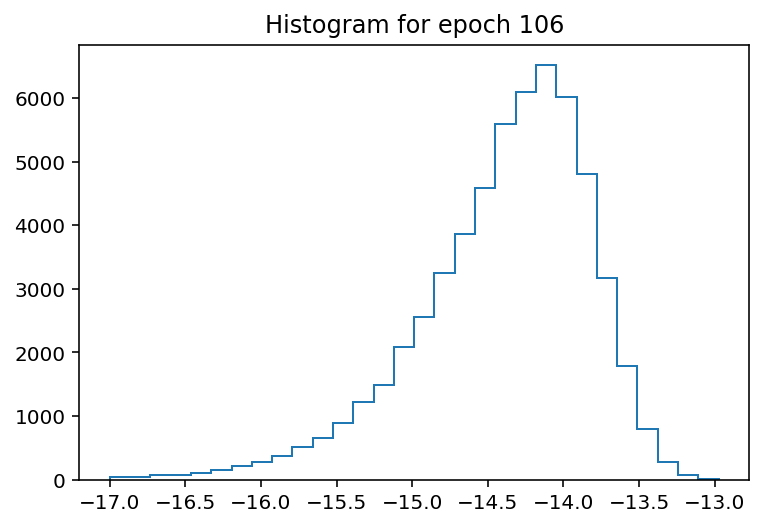

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


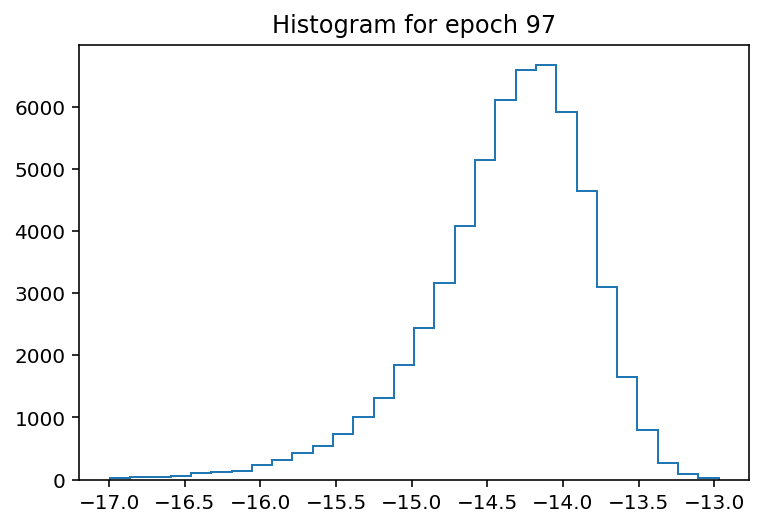

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


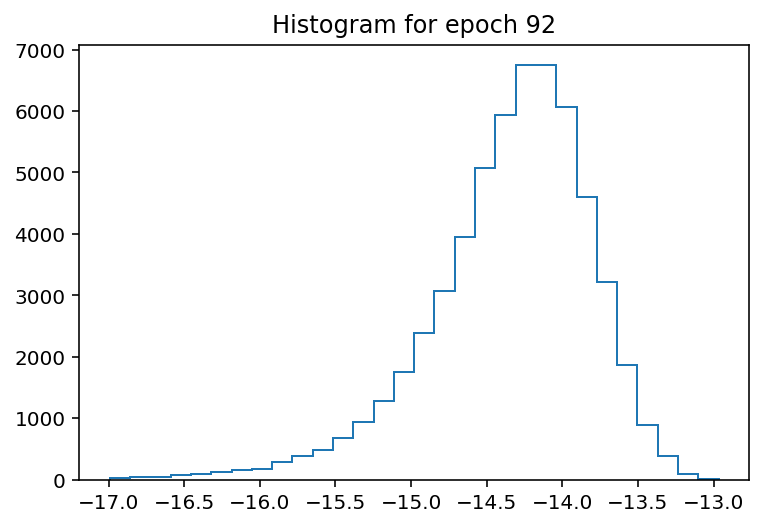

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


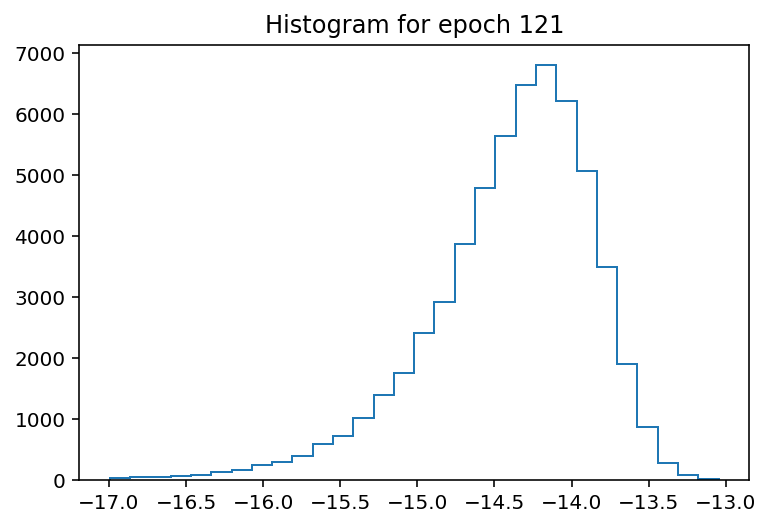

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


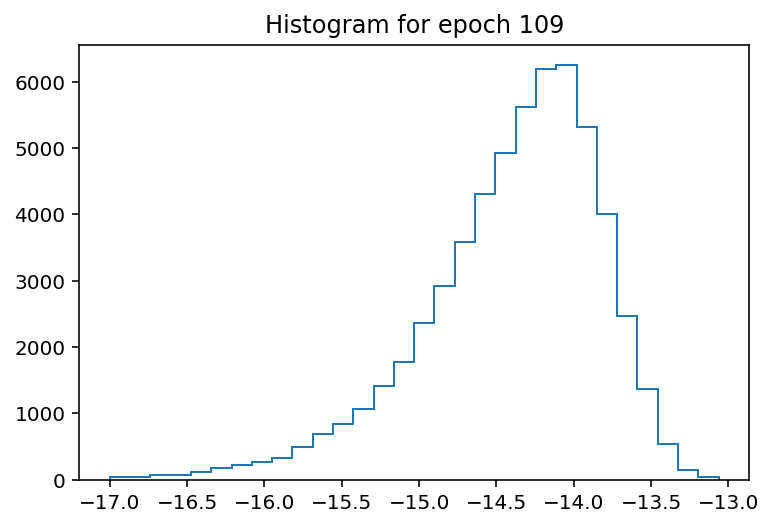

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


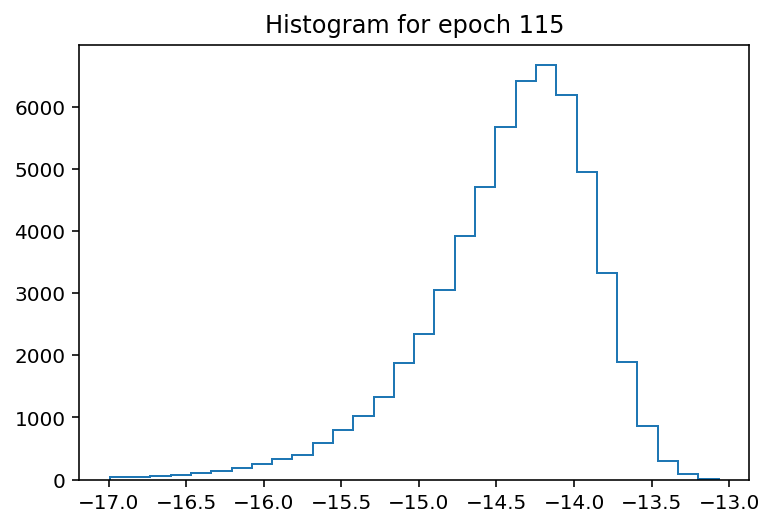

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


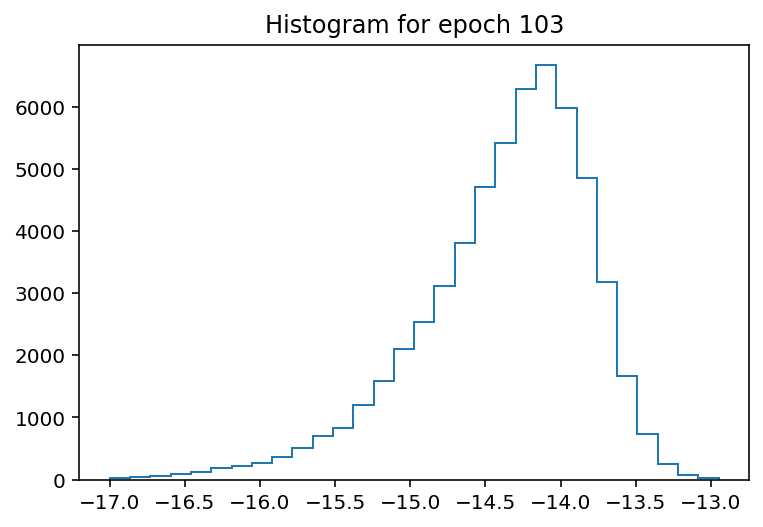

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


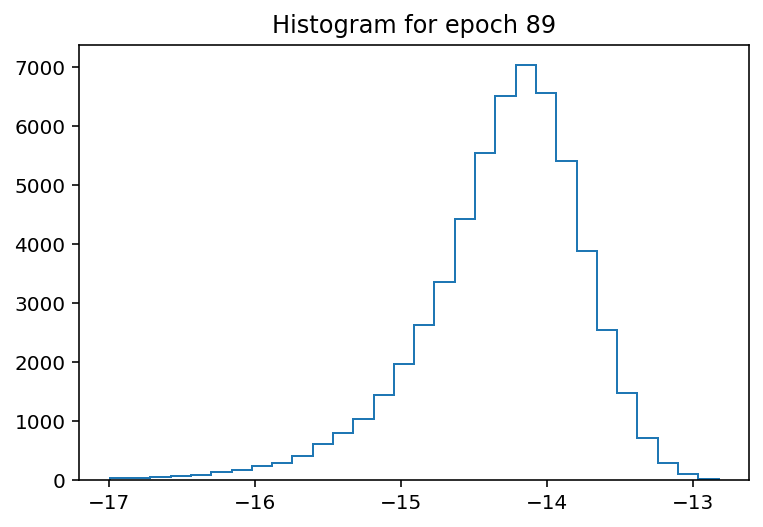

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


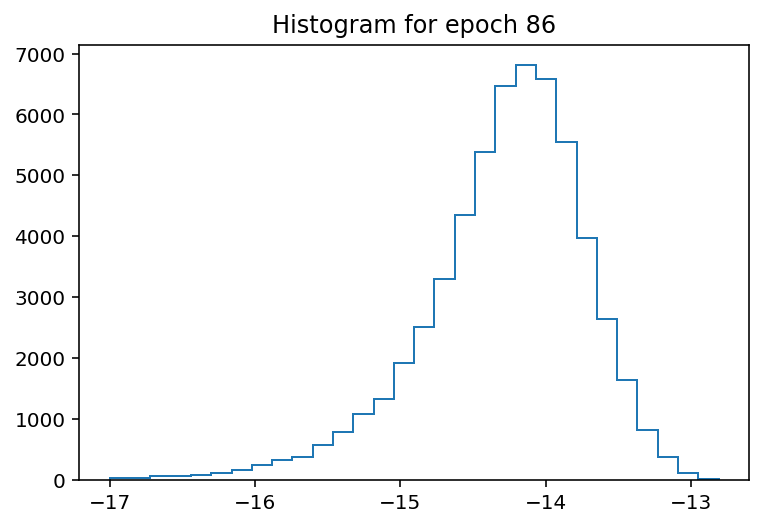

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


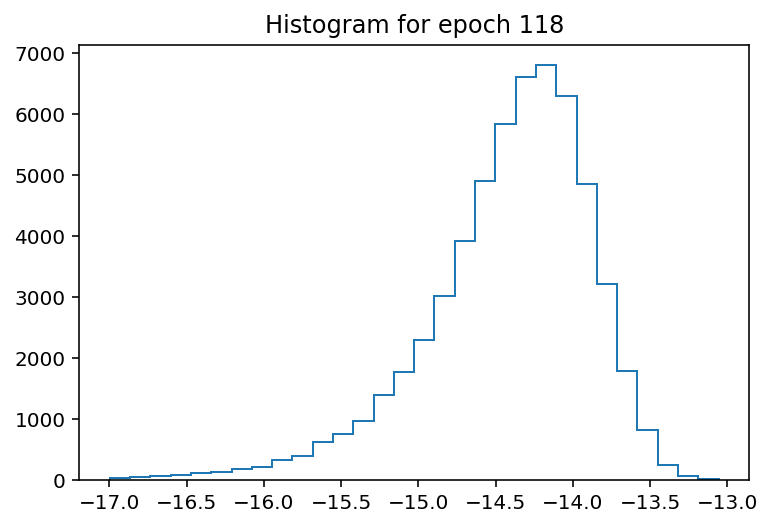

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


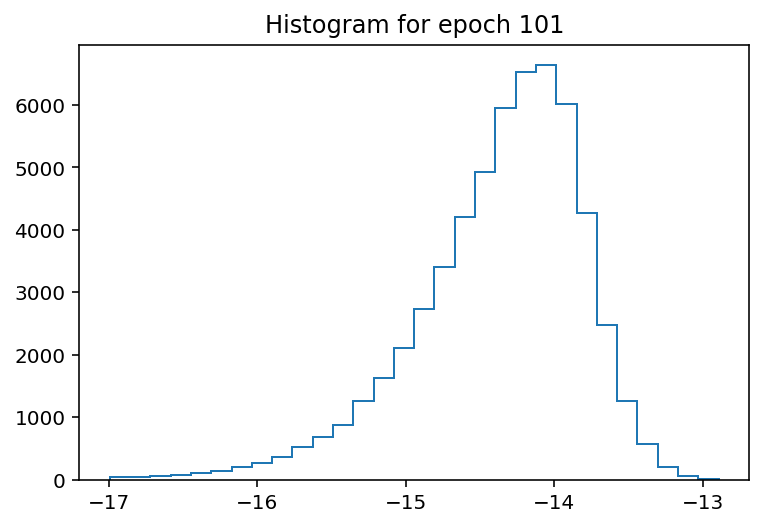

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


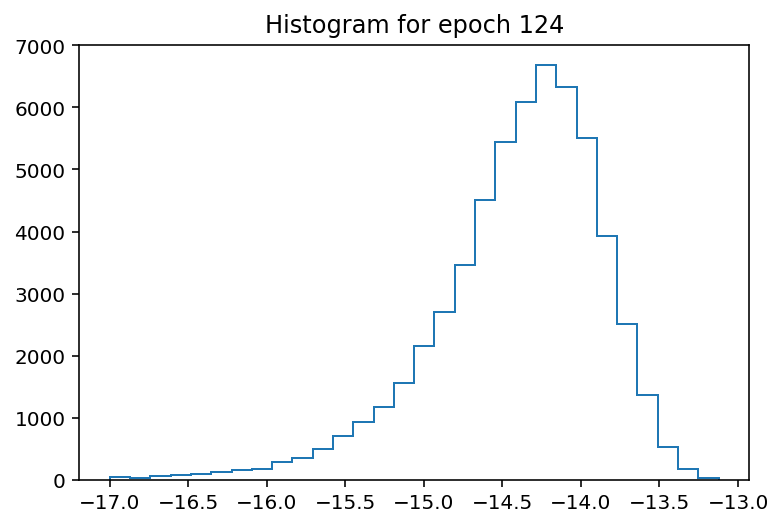

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


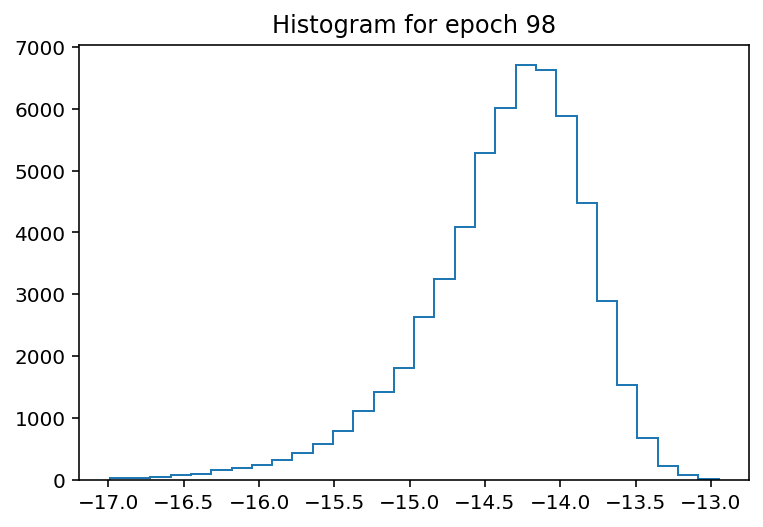

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


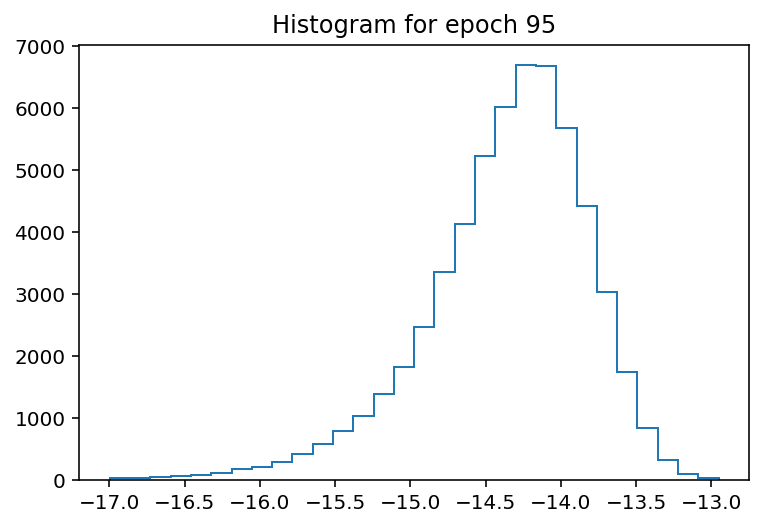

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


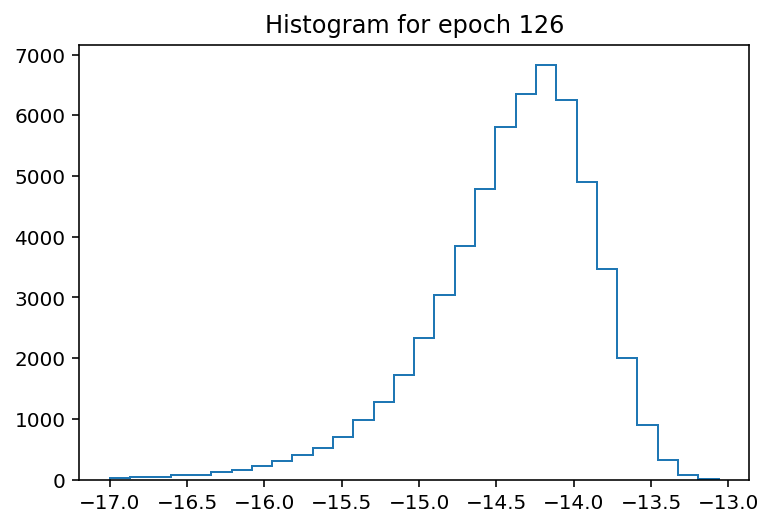

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


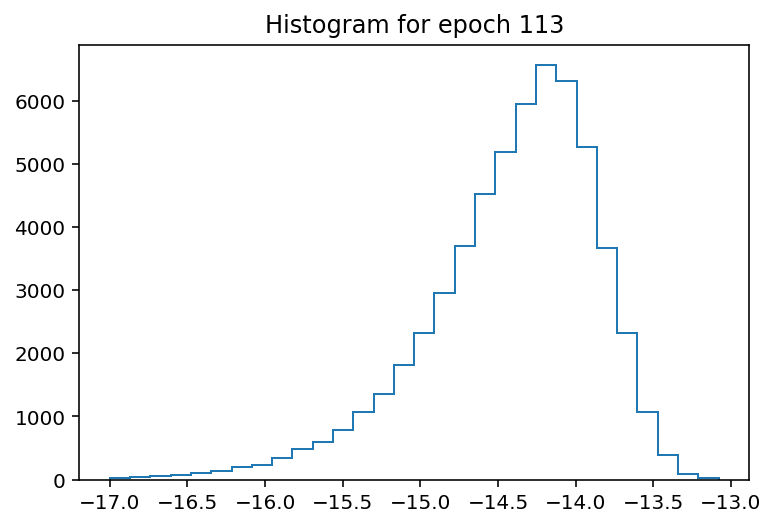

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


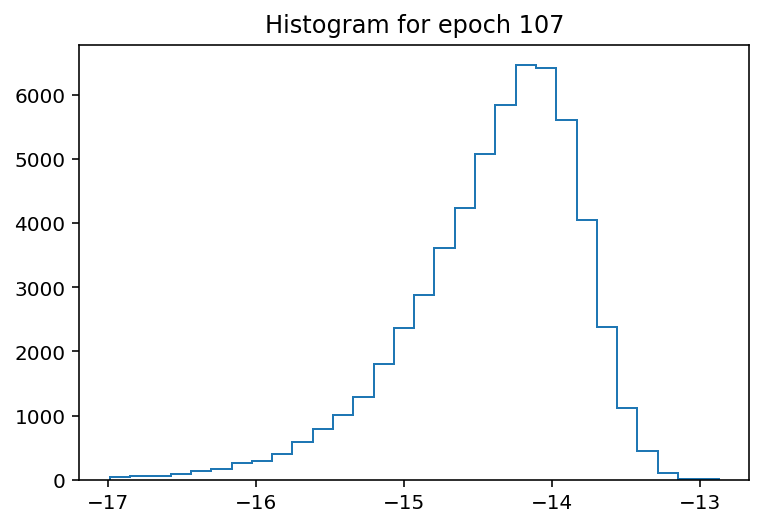

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


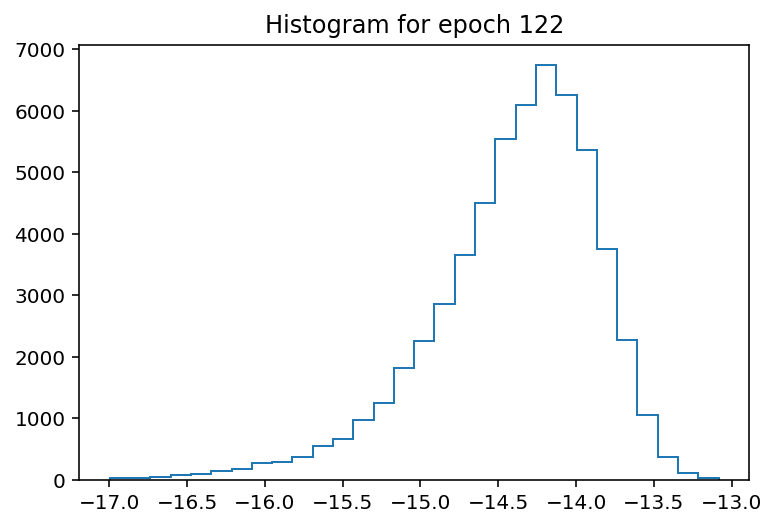

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


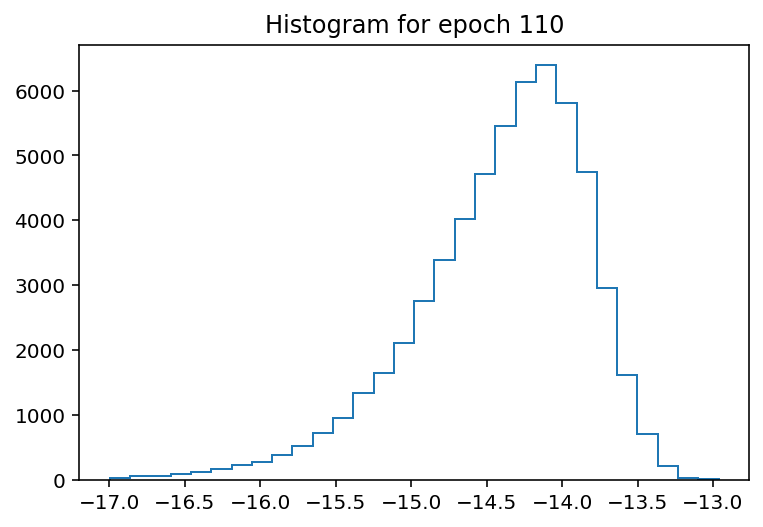

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


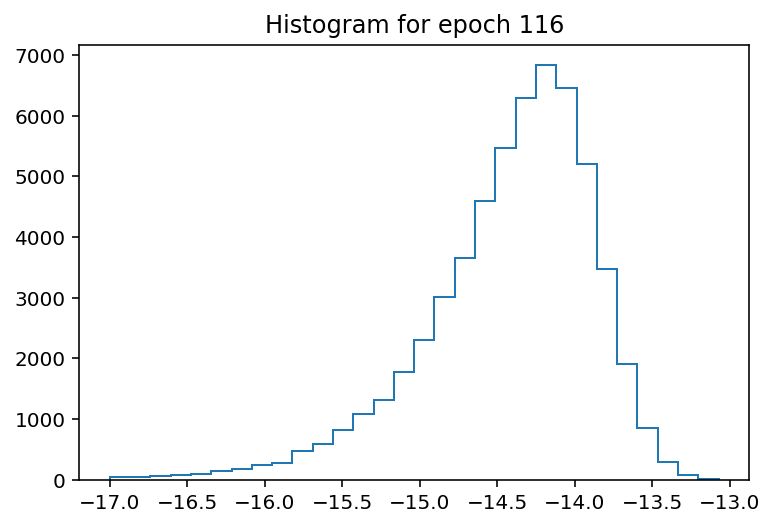

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


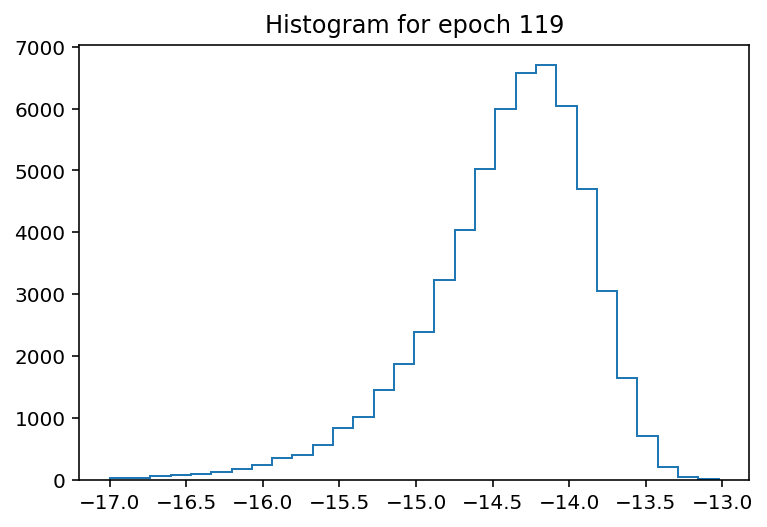

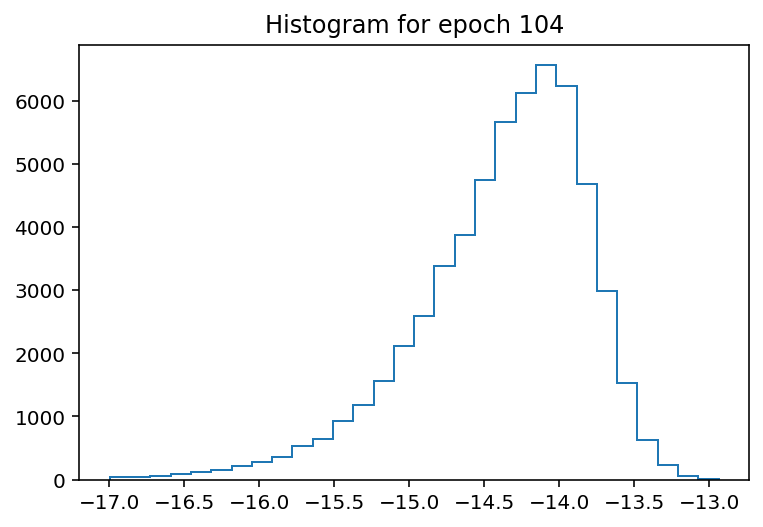

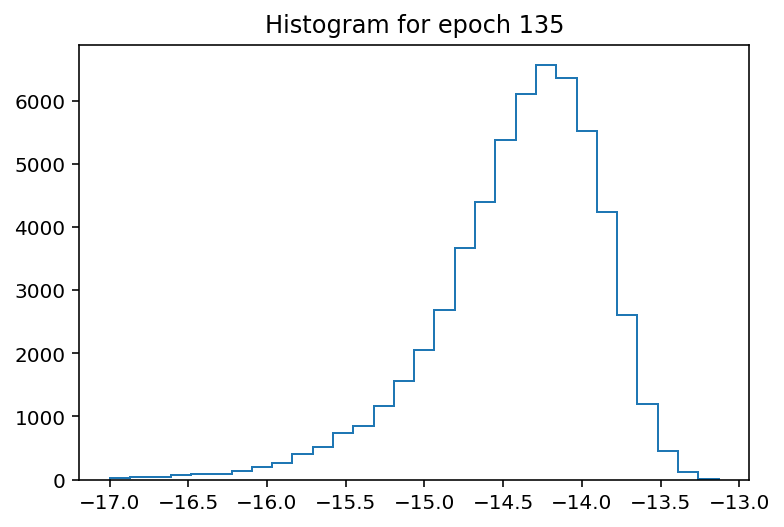

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


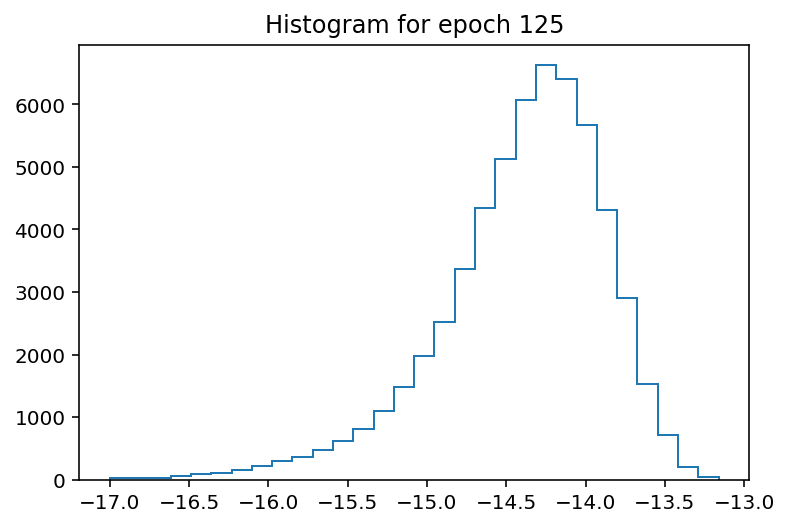

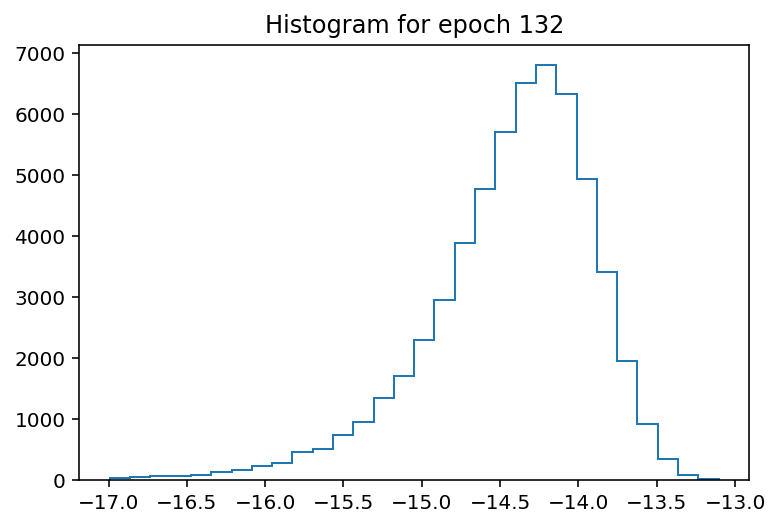

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


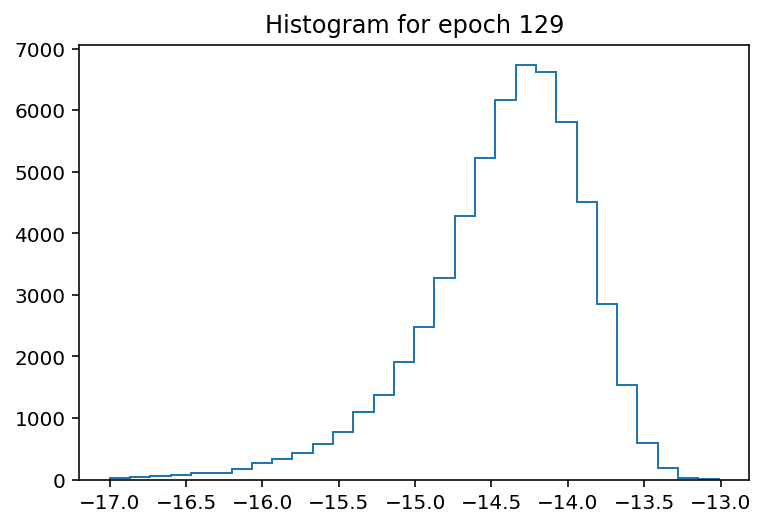

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


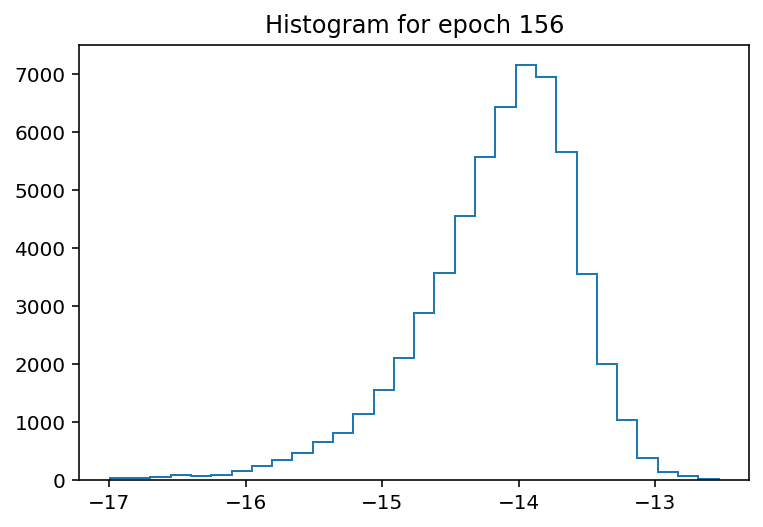

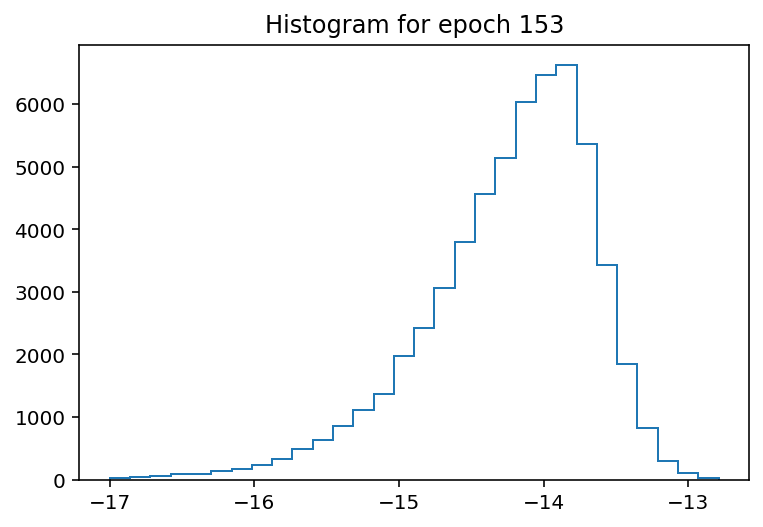

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


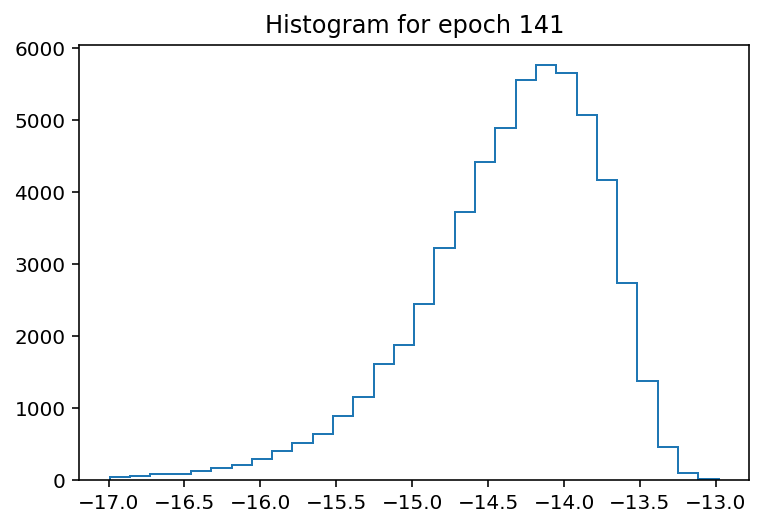

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


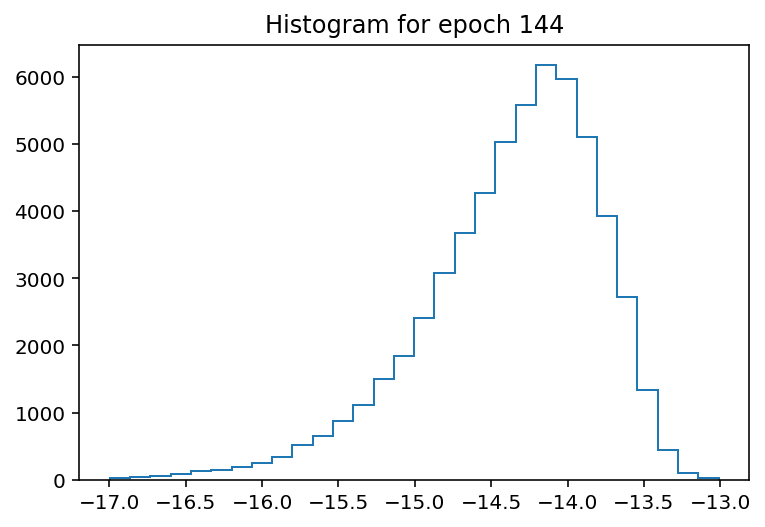

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


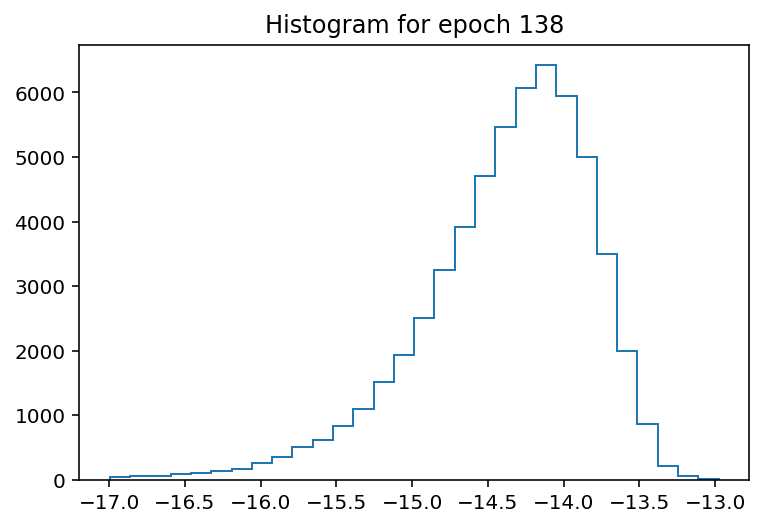

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


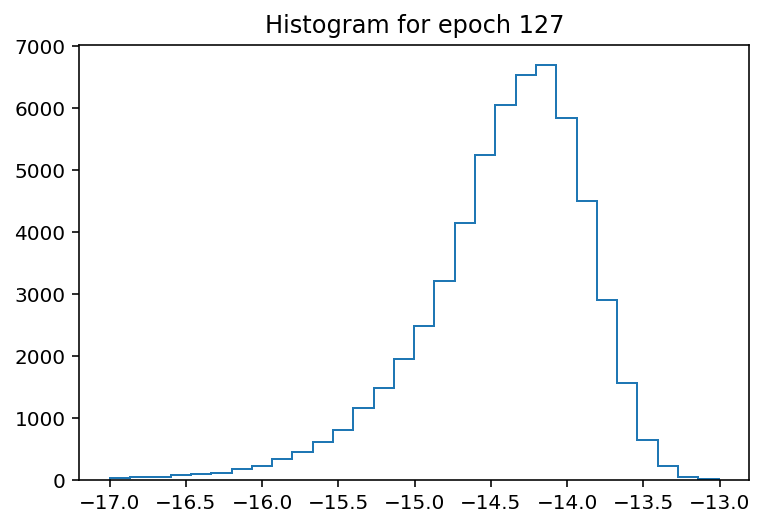

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


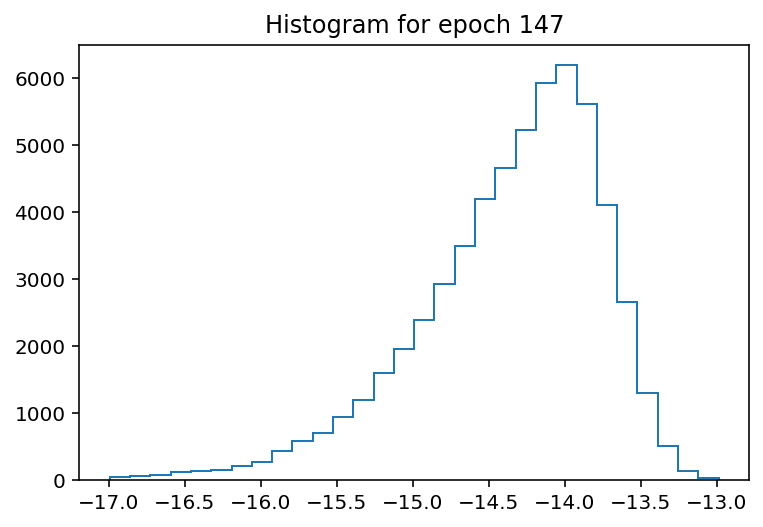

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


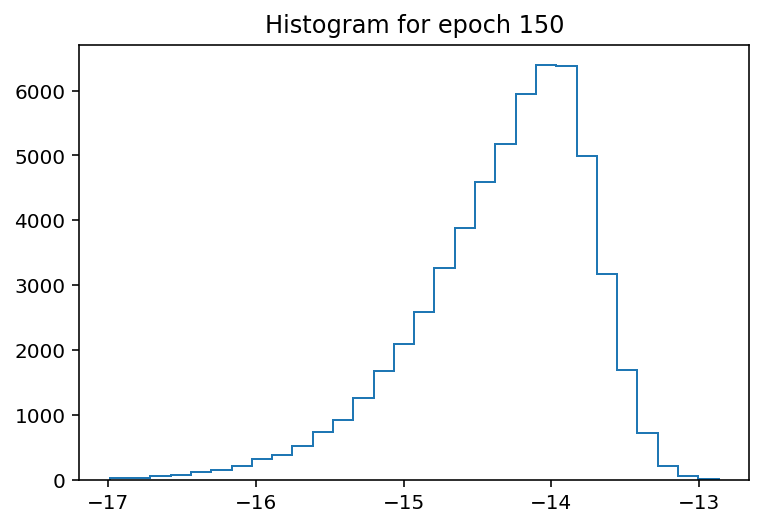

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


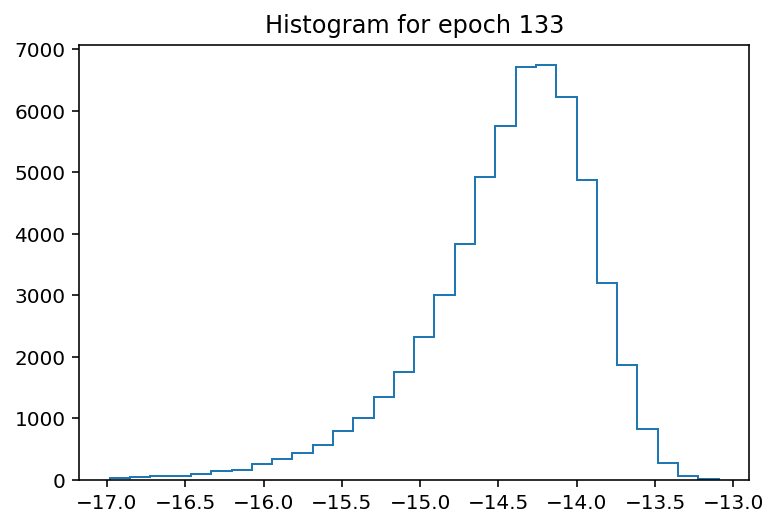

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


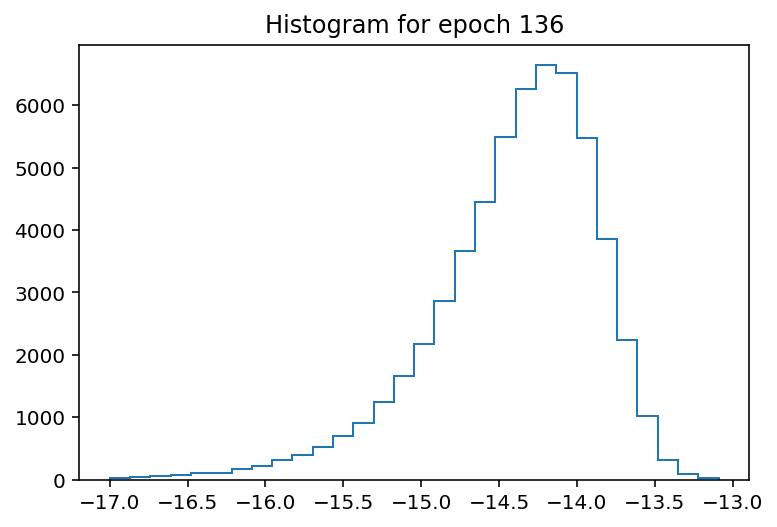

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


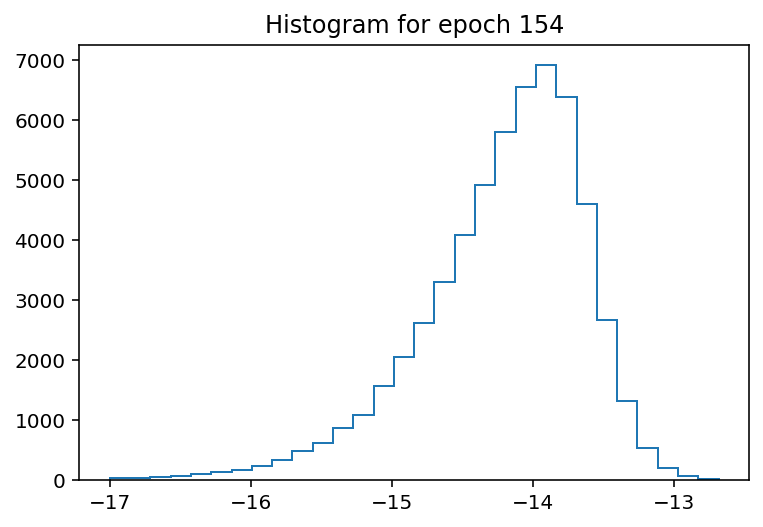

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


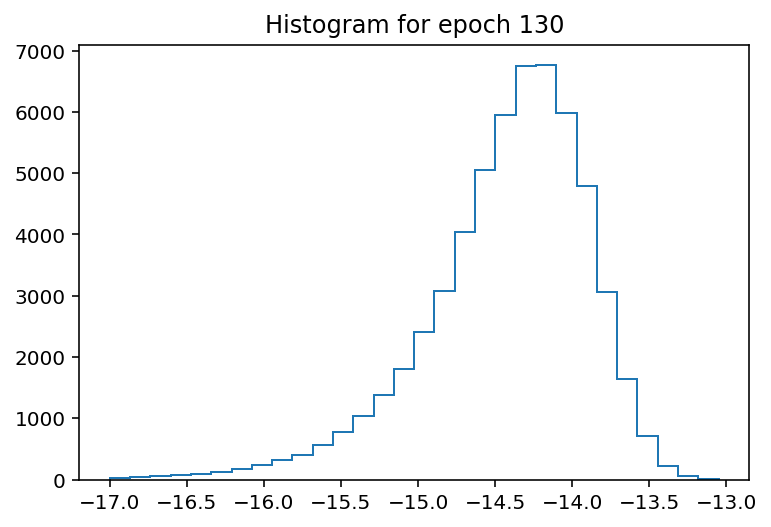

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


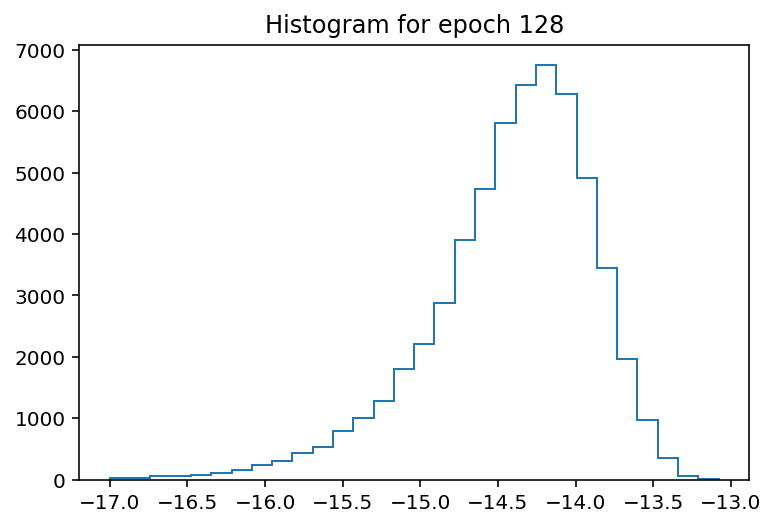

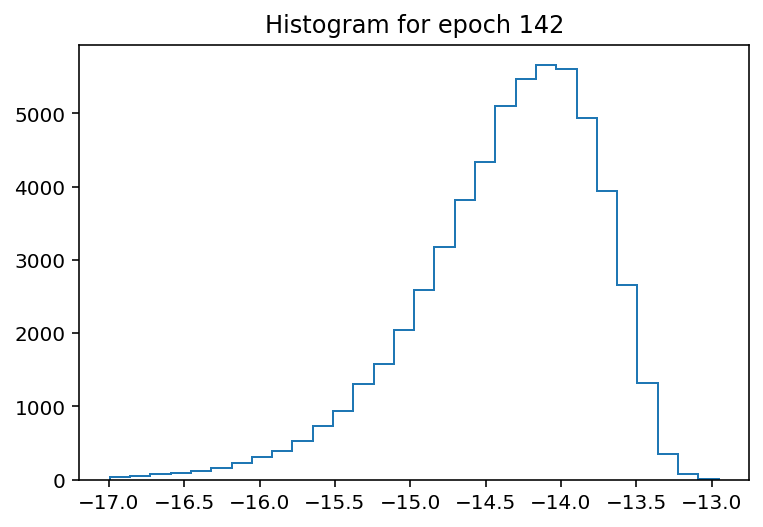

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


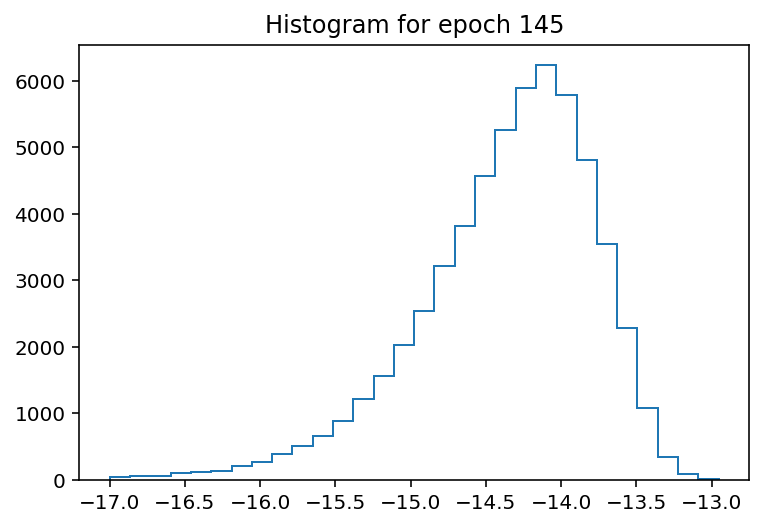

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


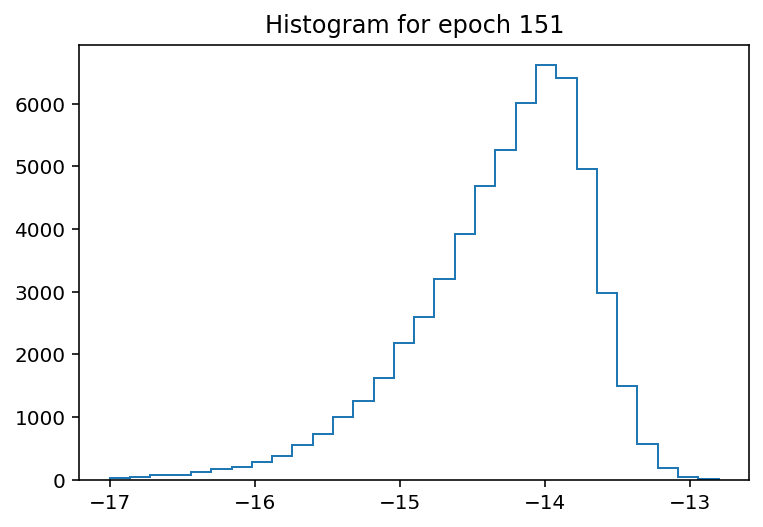

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


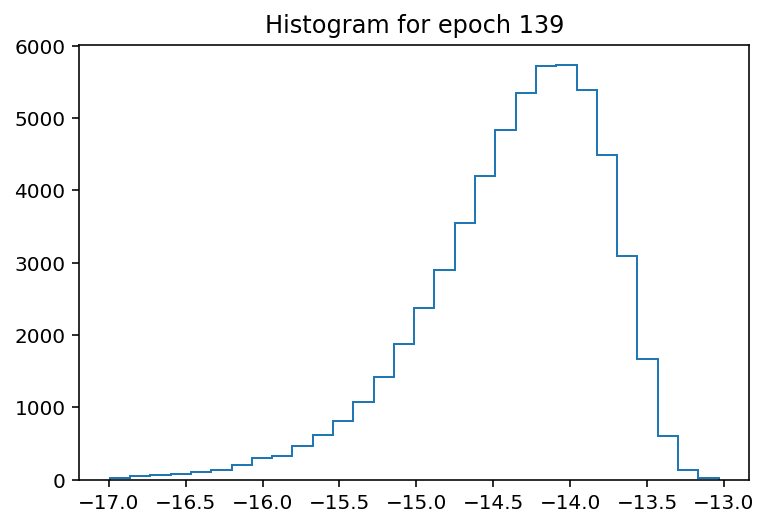

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


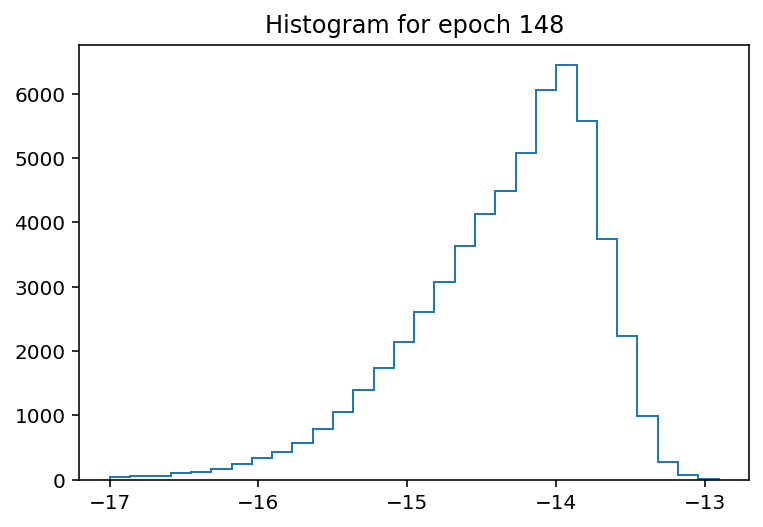

/tmp/ipykernel_31545/2304554045.py:25: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


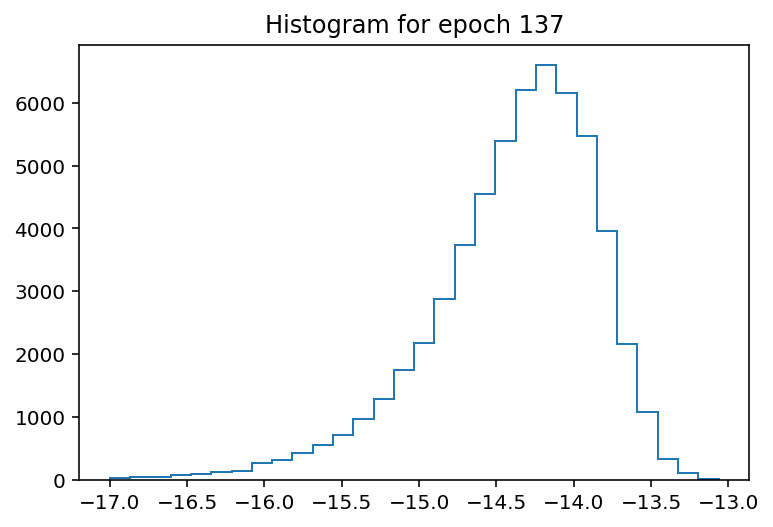

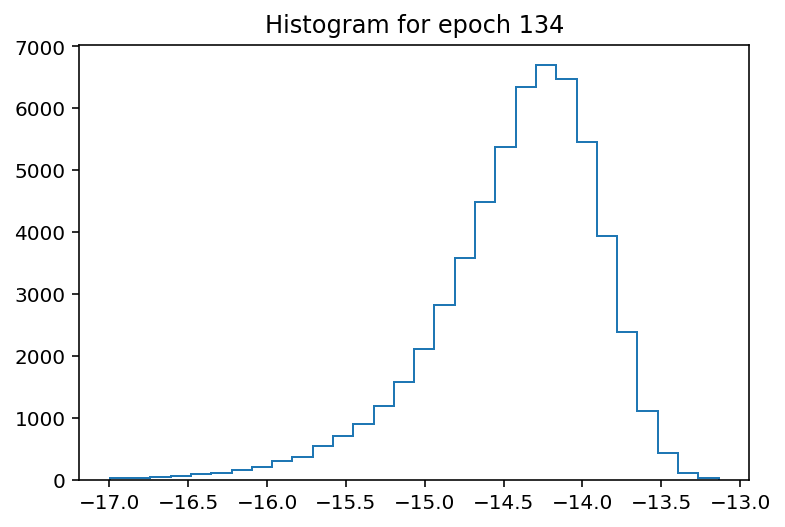

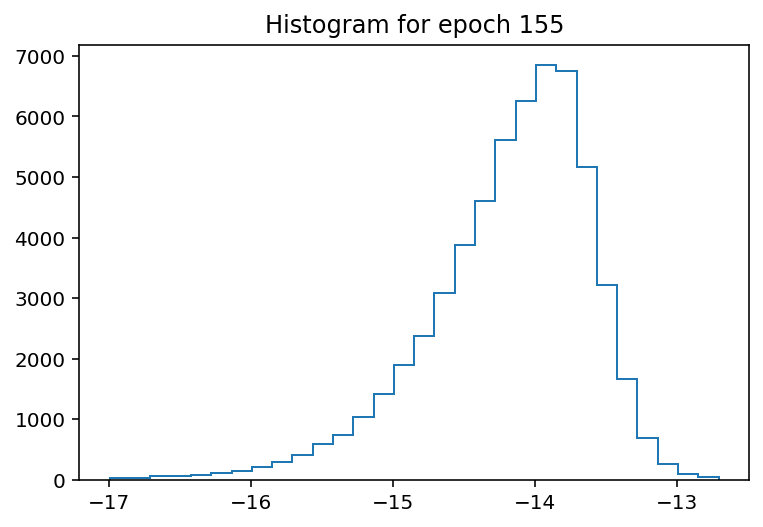

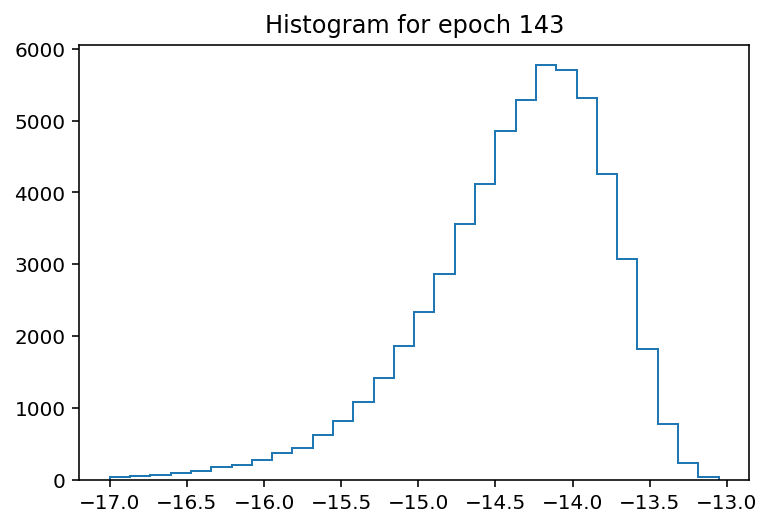

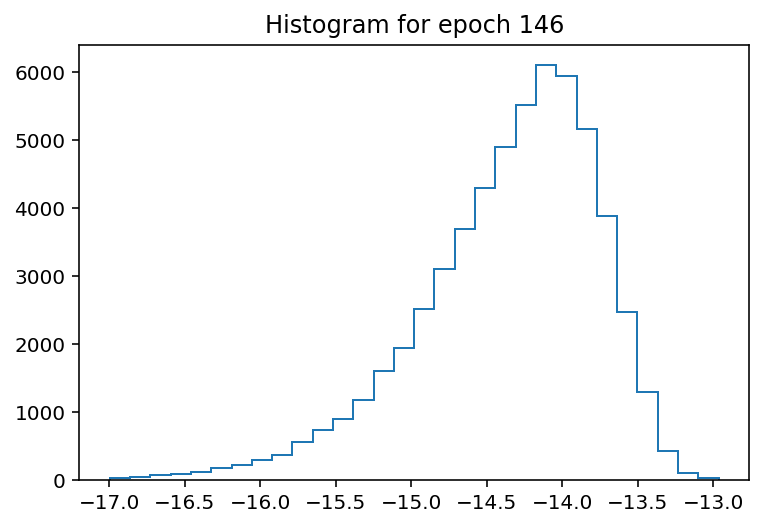

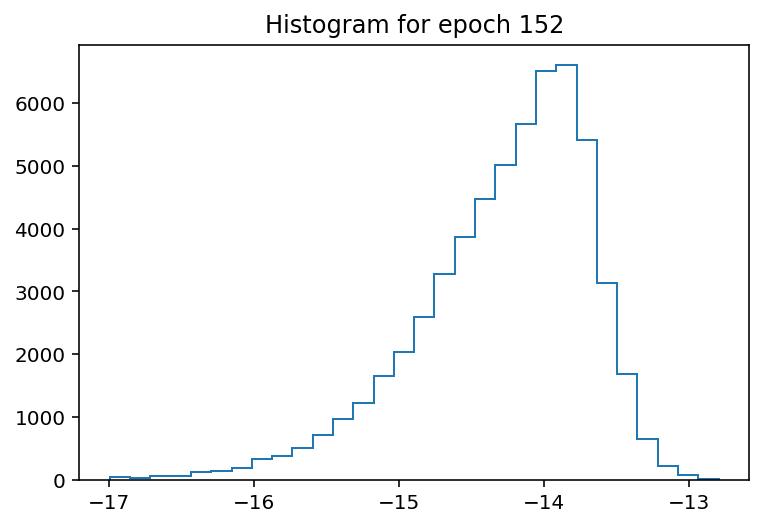

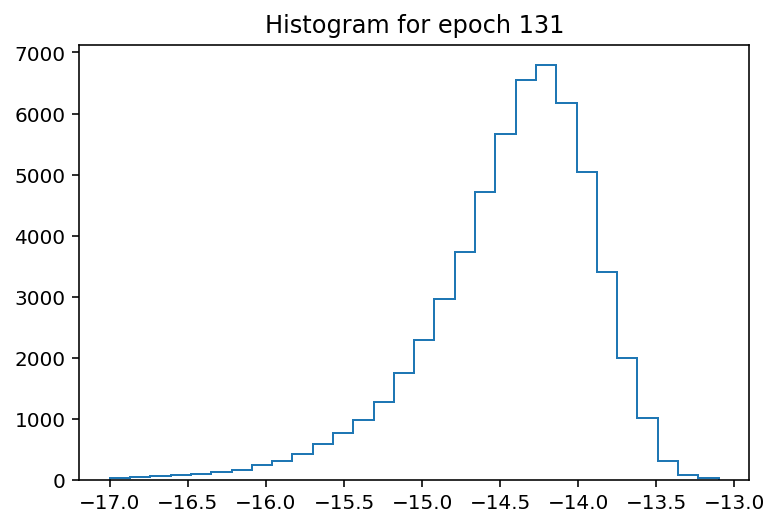

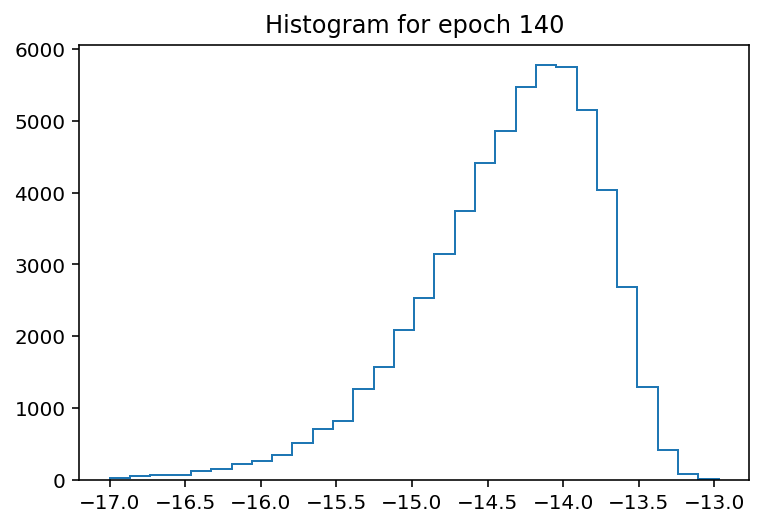

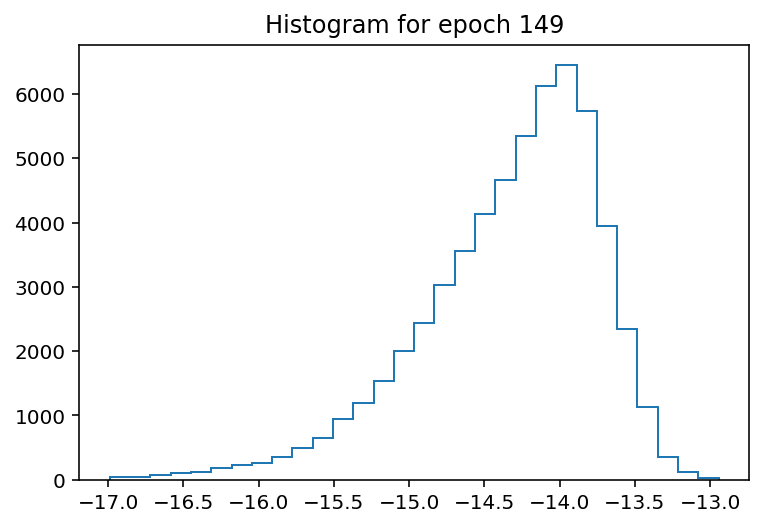

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [6]:
pool=mp.Pool(processes=14)
pool.map(epoch_sample_worker, np.arange(len(nano12_Ts)))

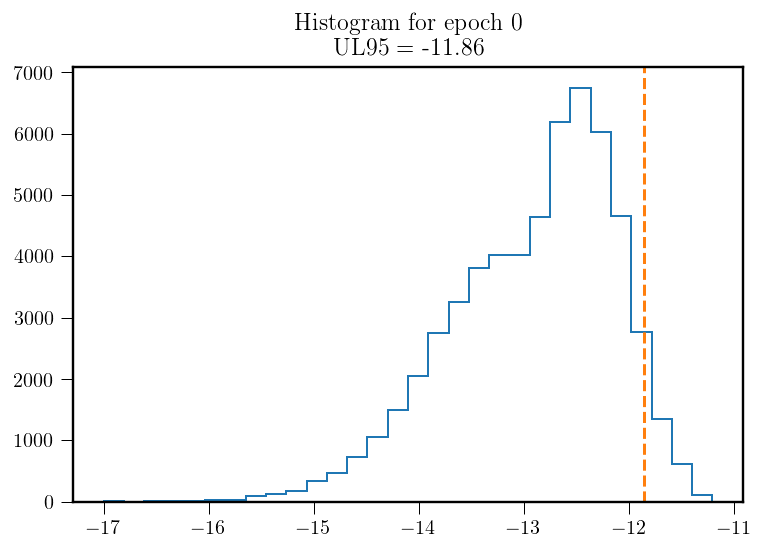

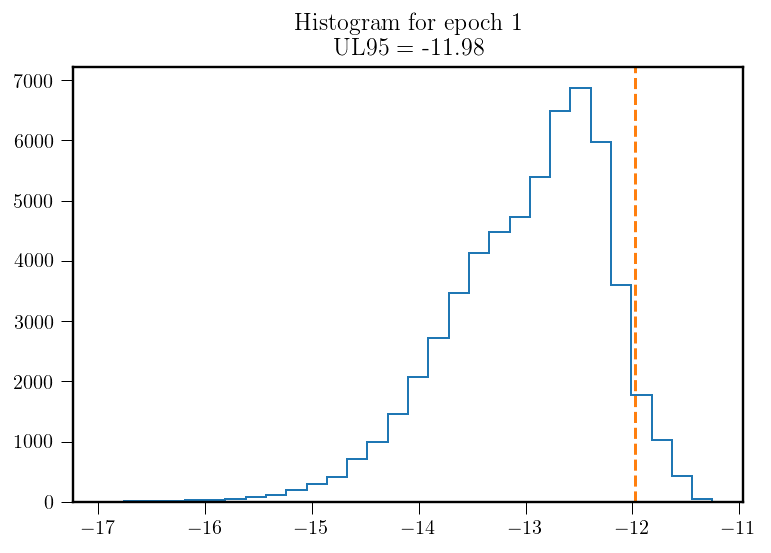

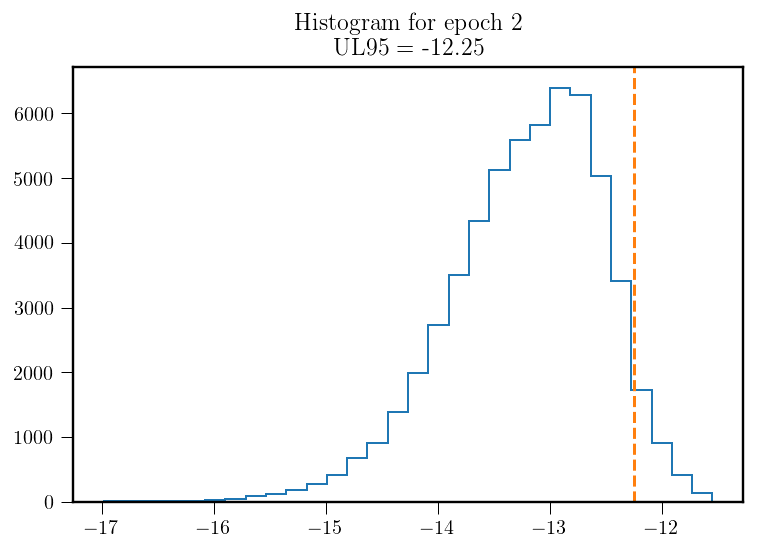

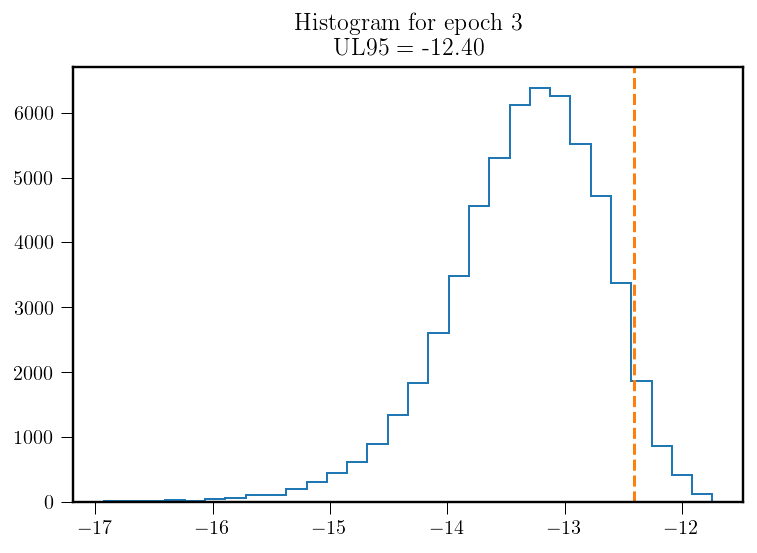

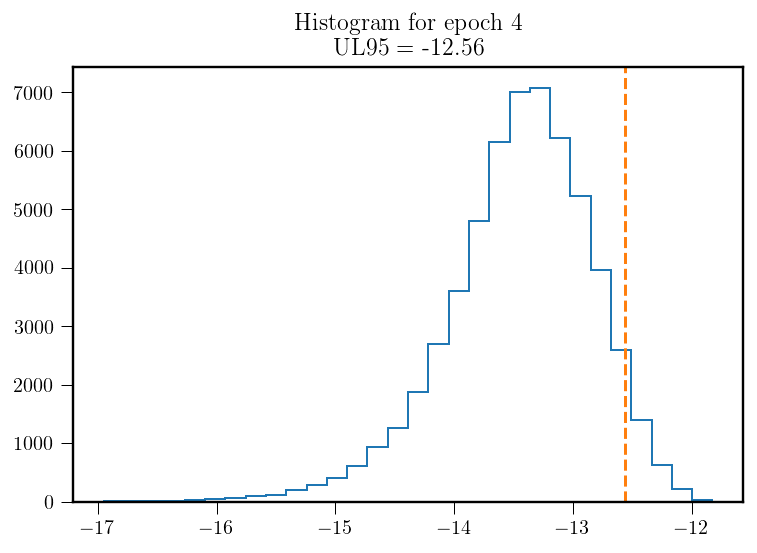

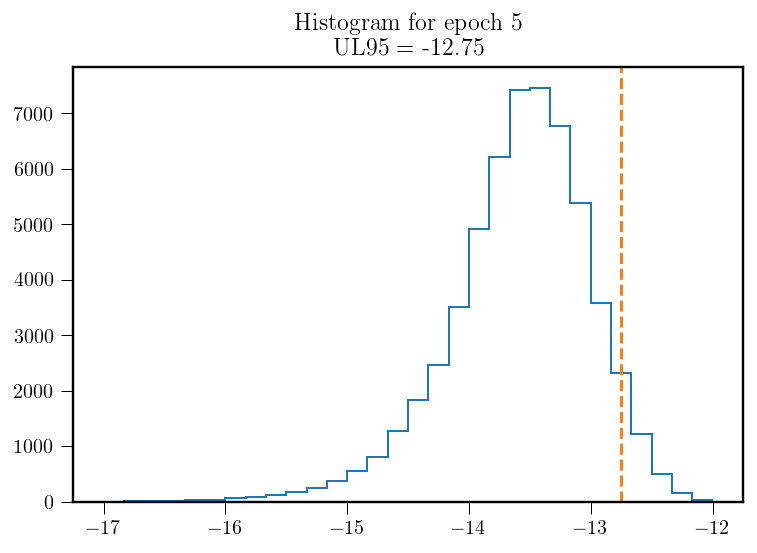

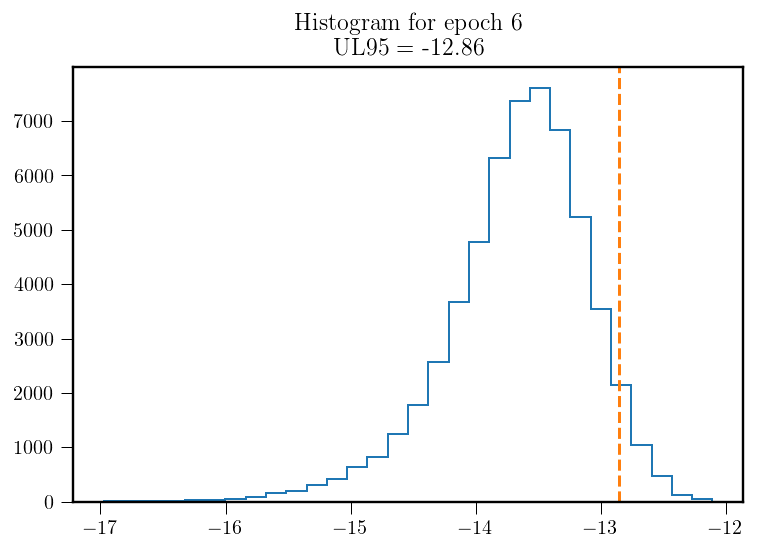

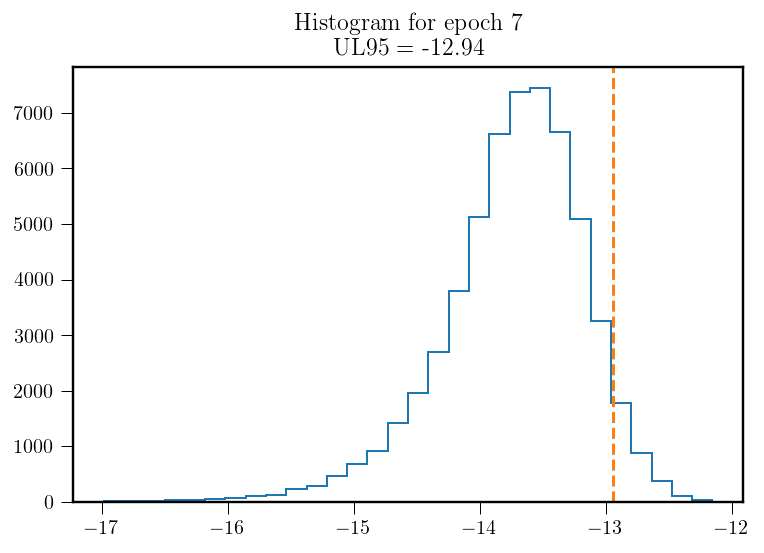

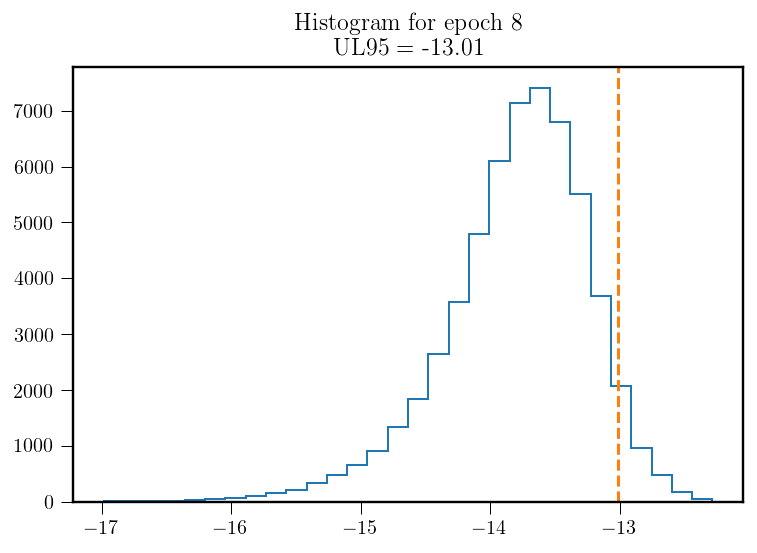

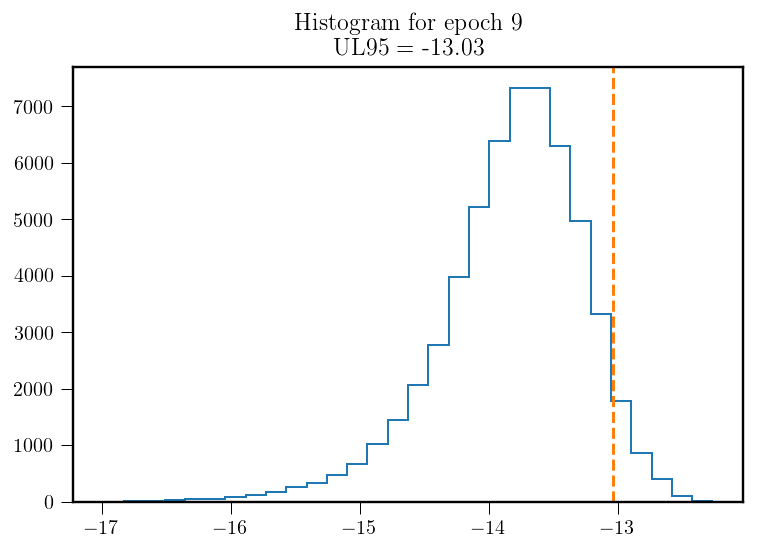

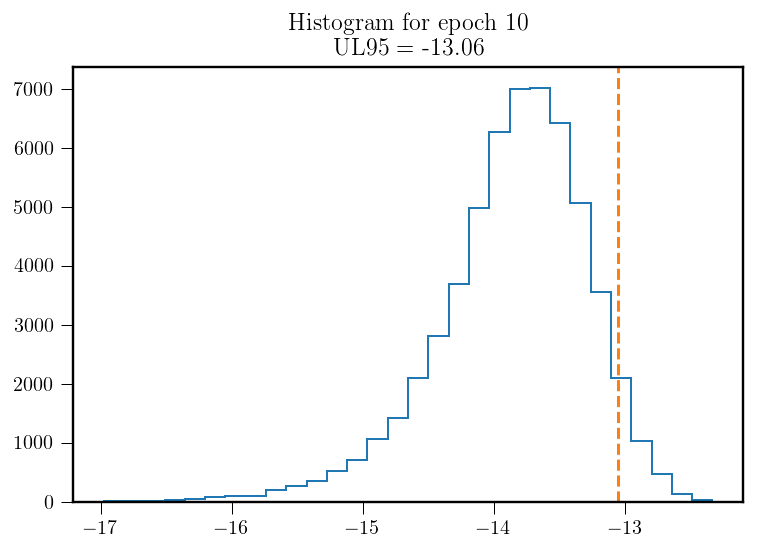

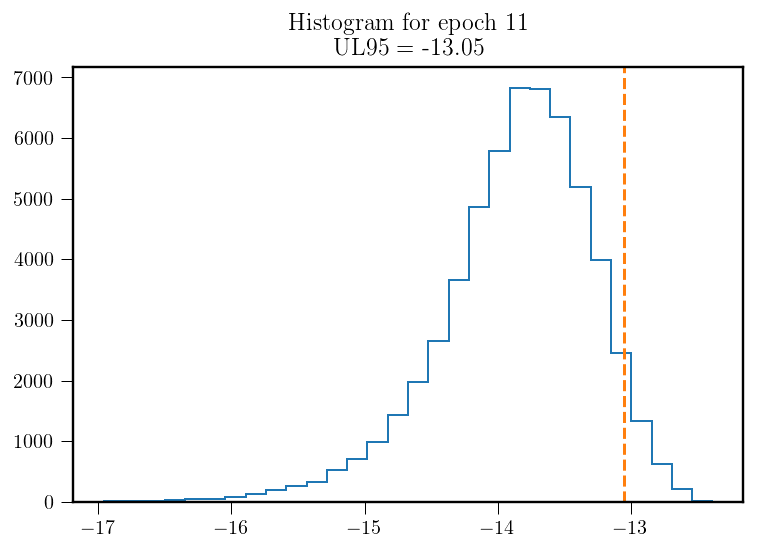

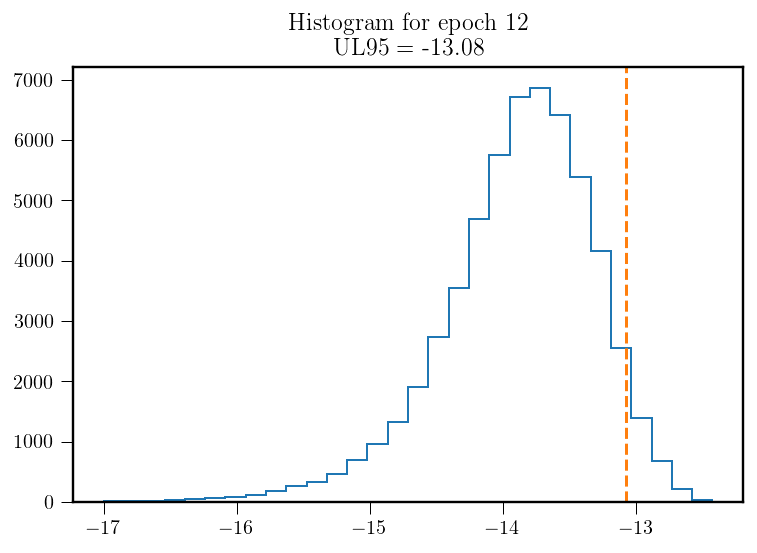

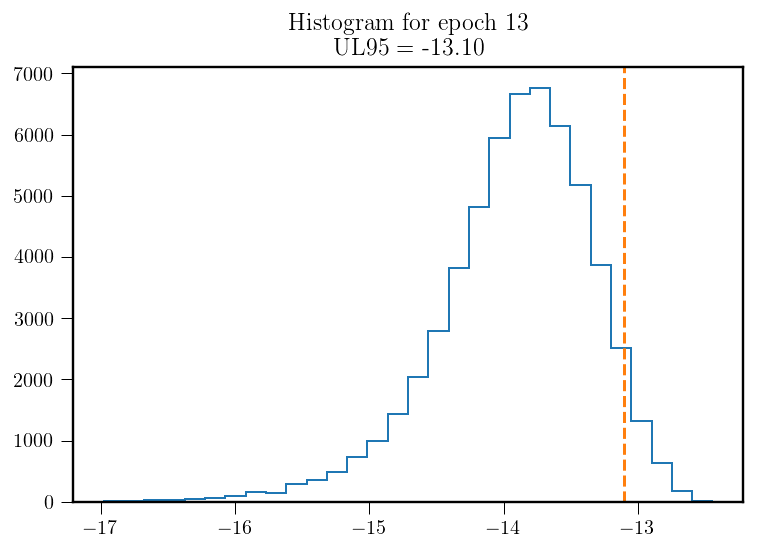

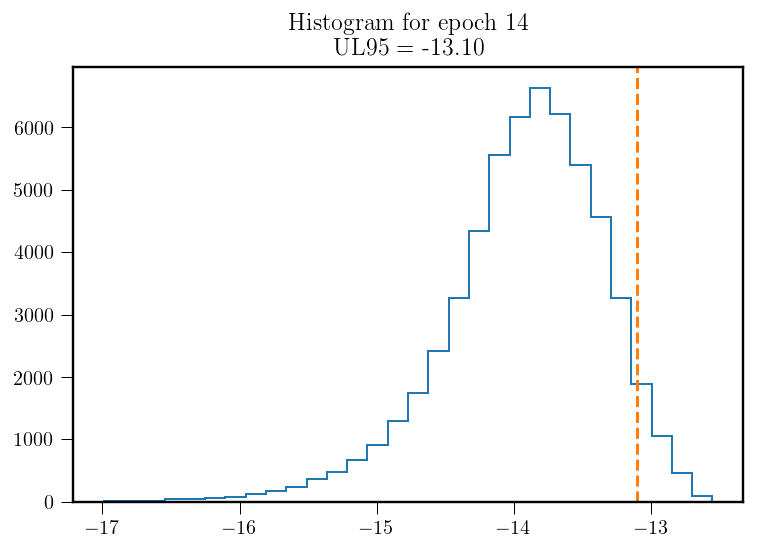

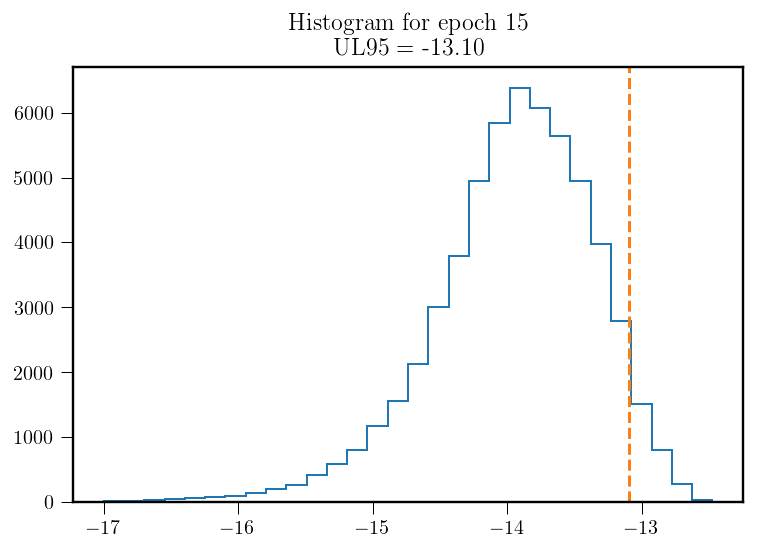

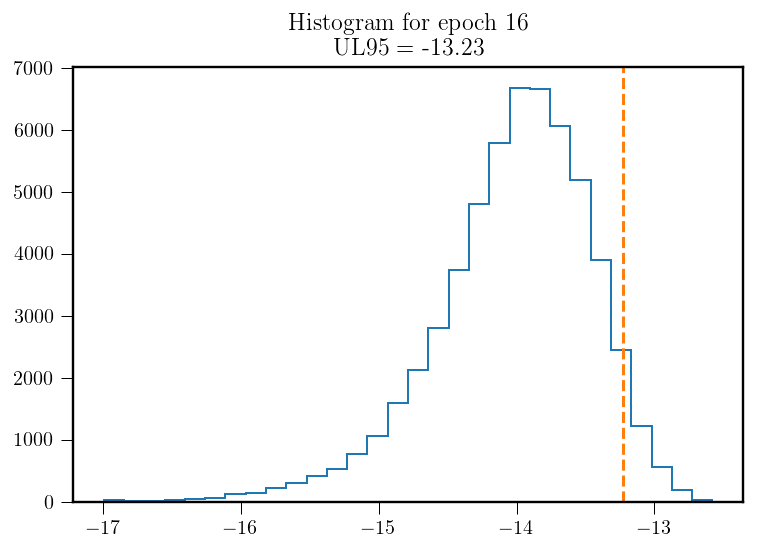

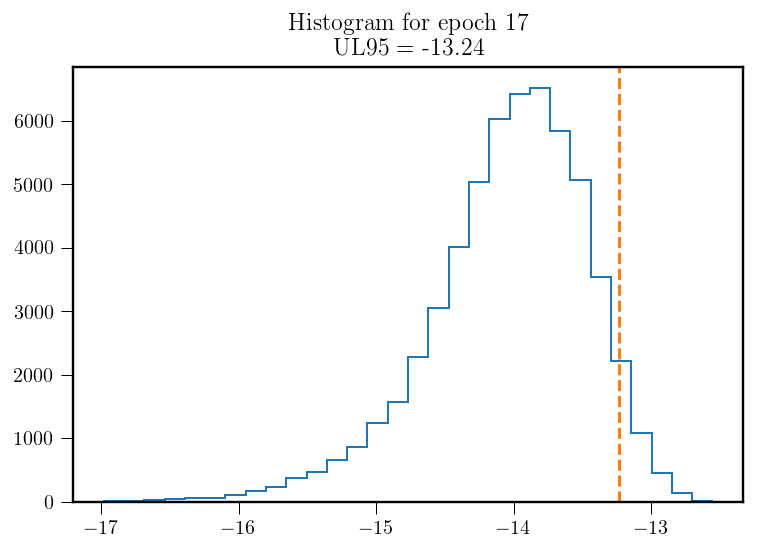

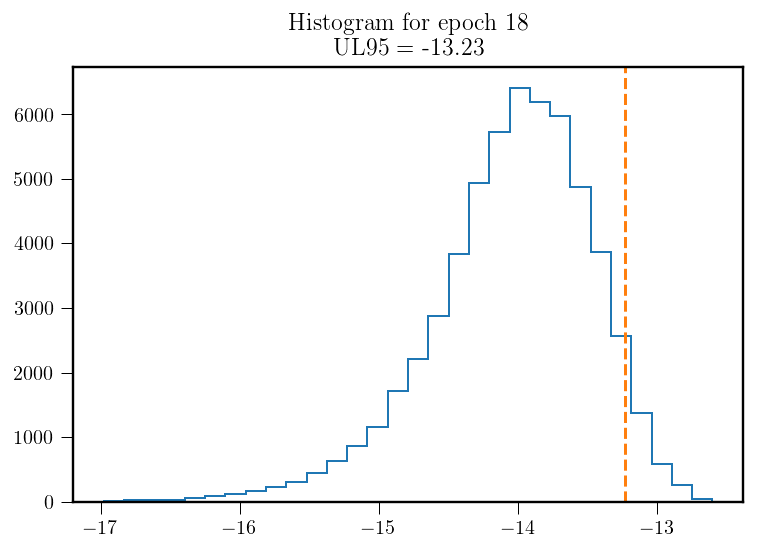

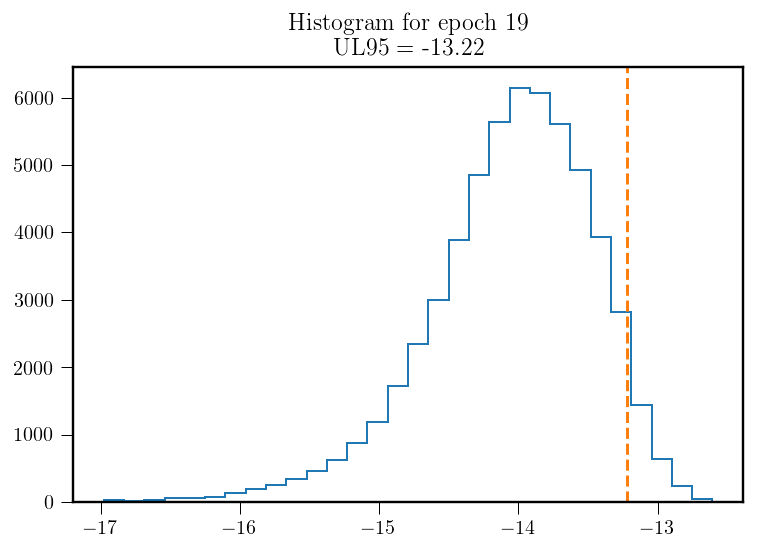

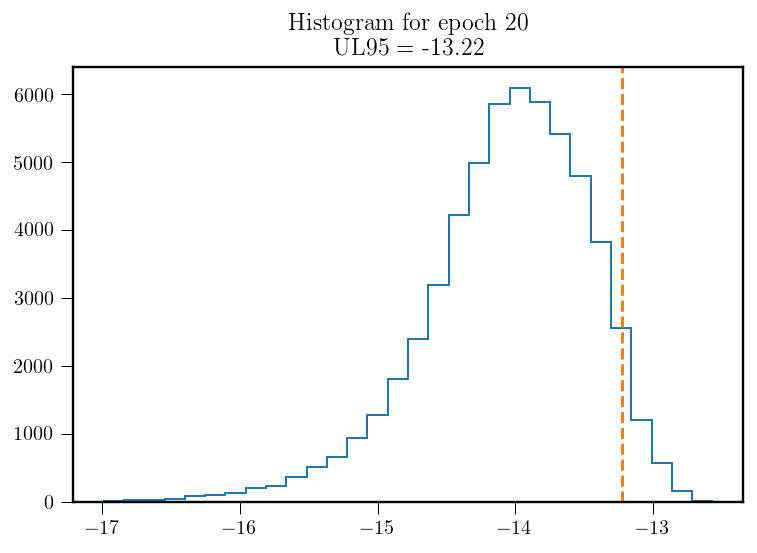

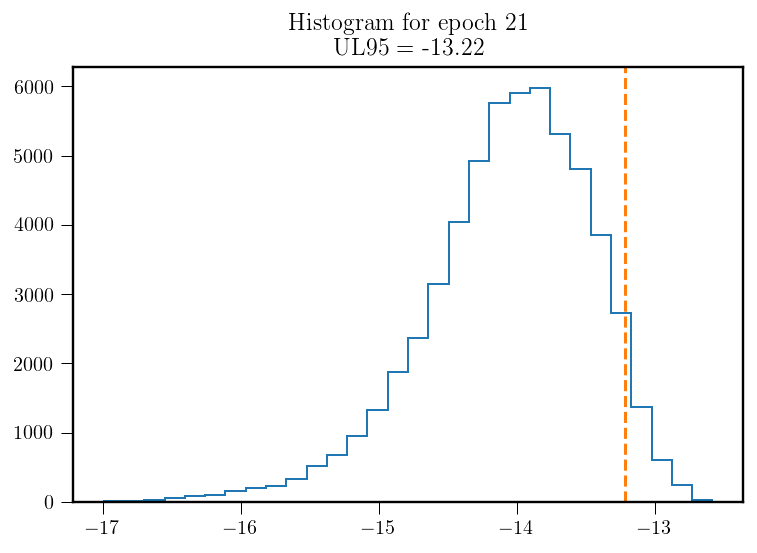

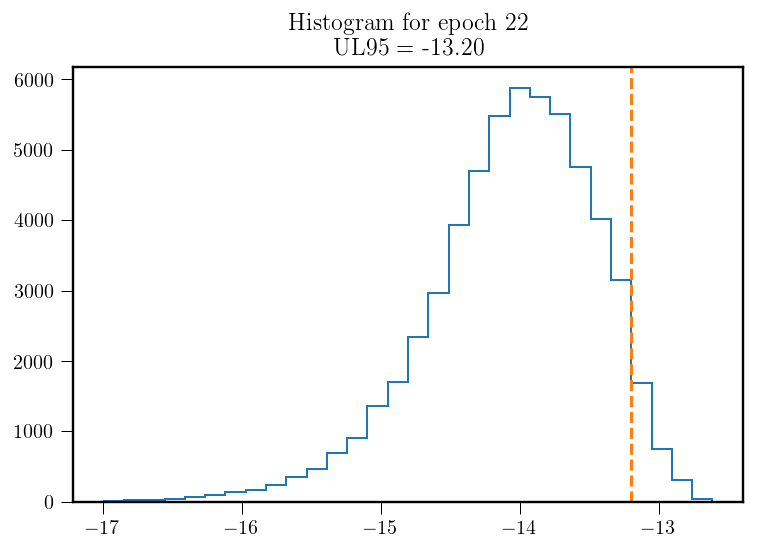

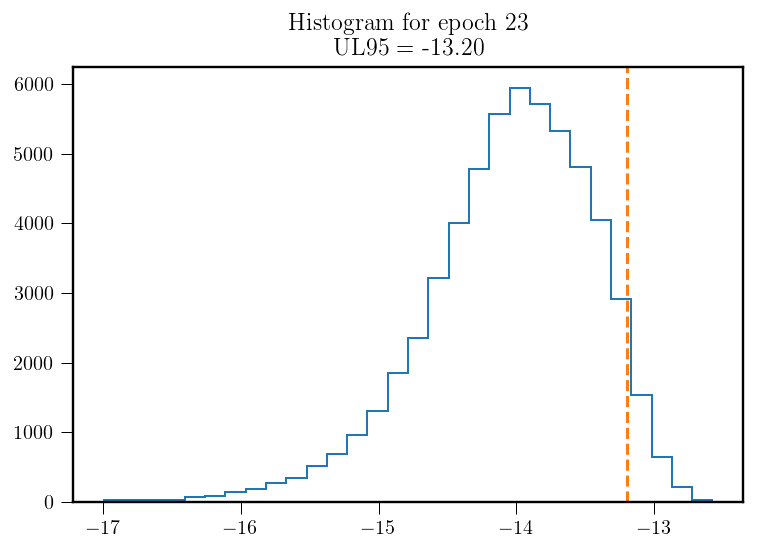

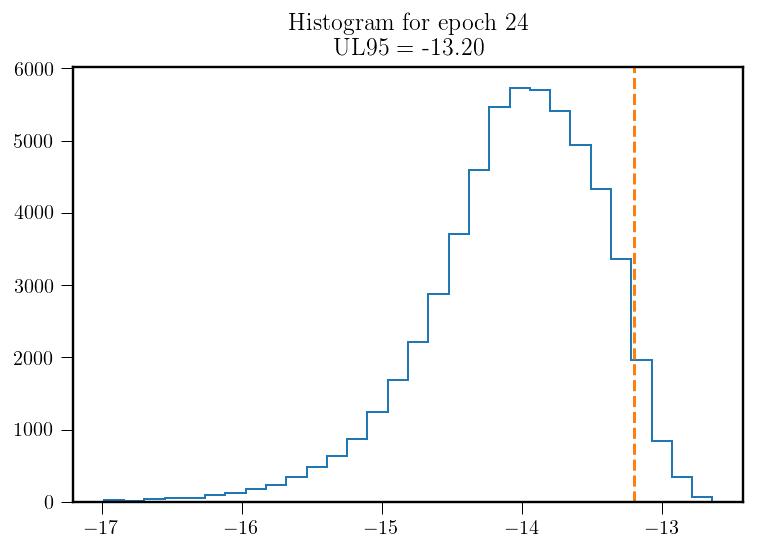

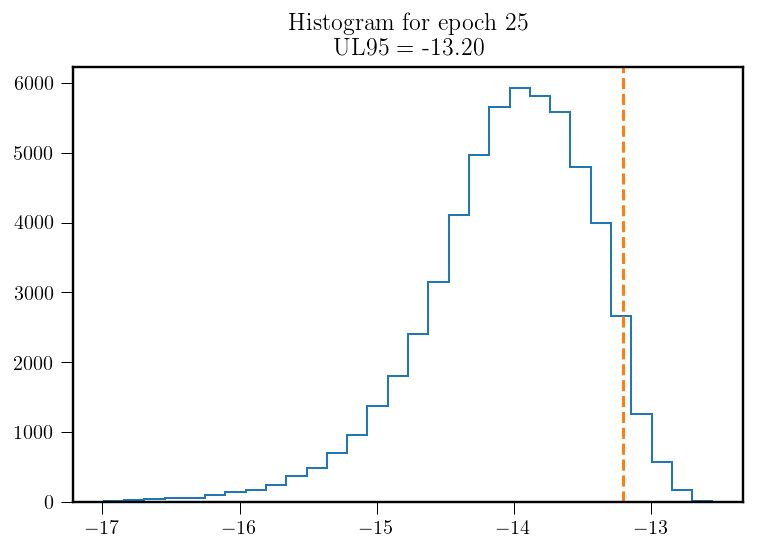

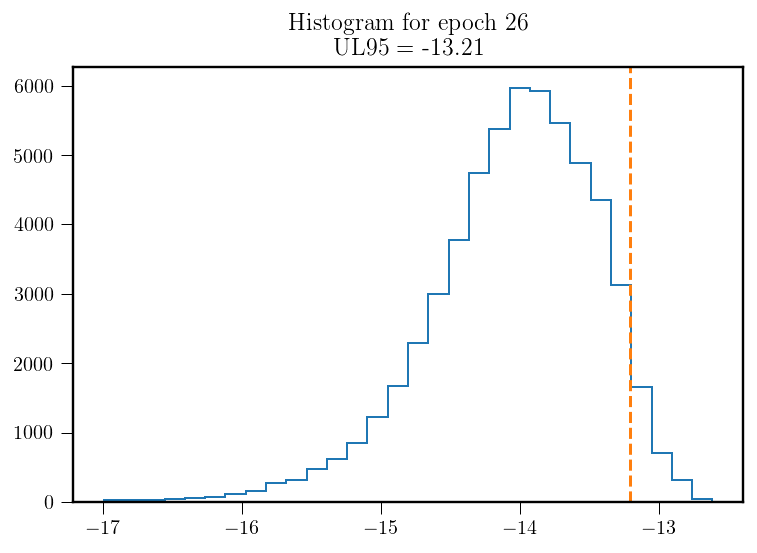

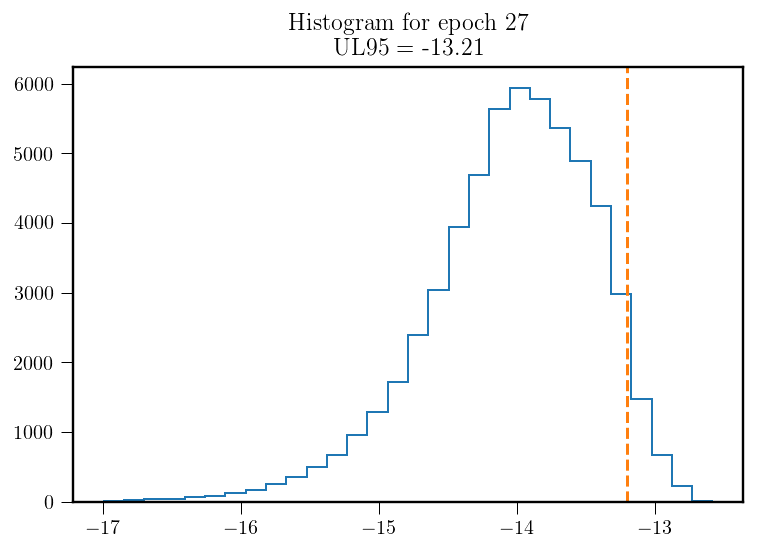

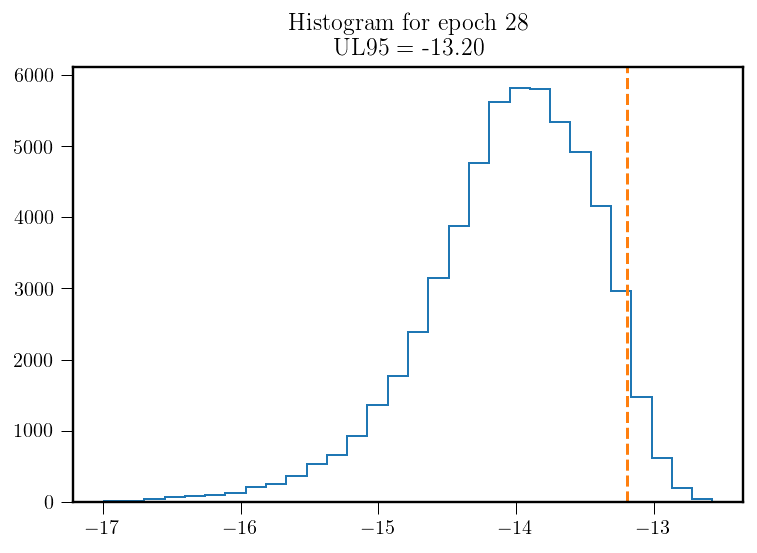

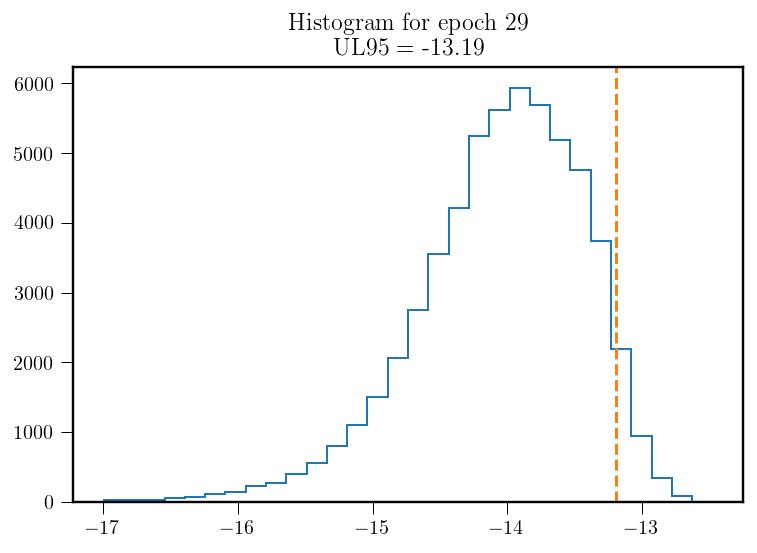

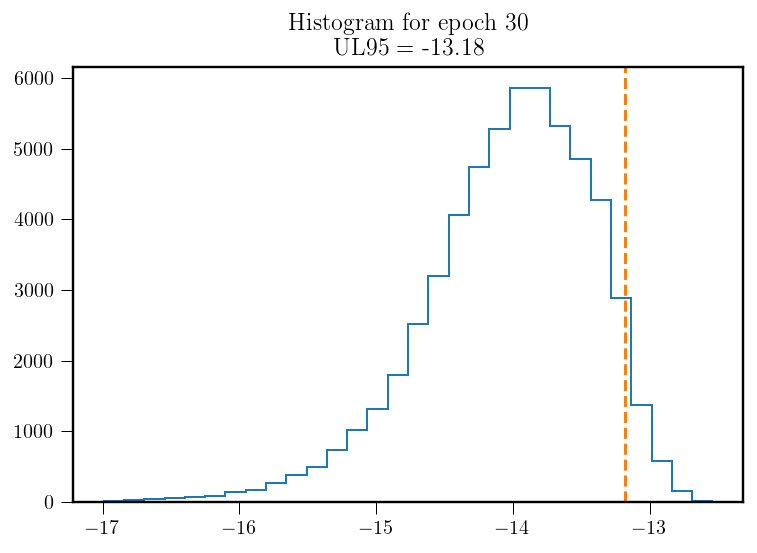

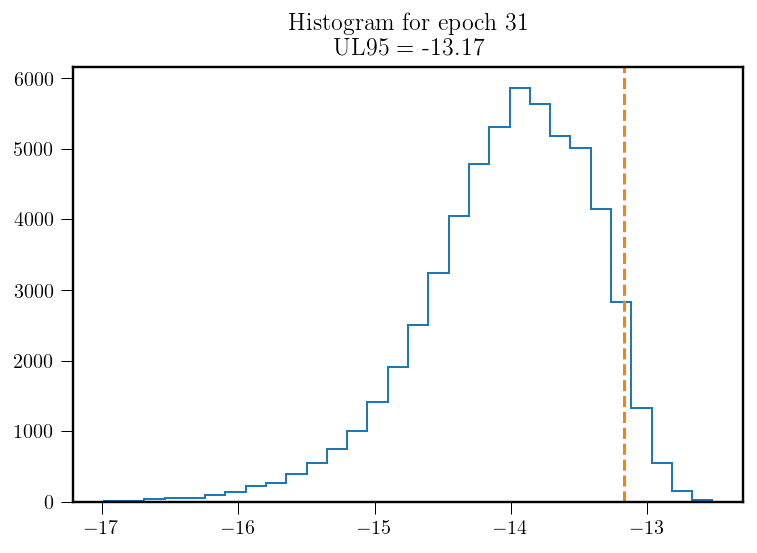

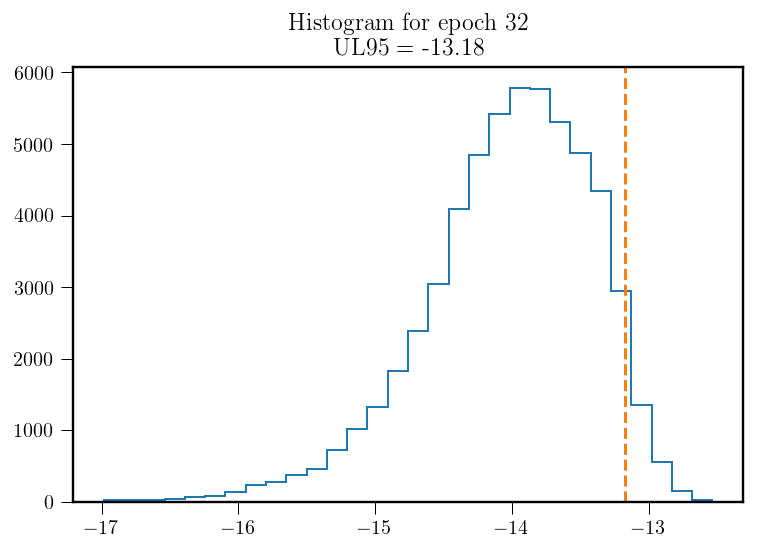

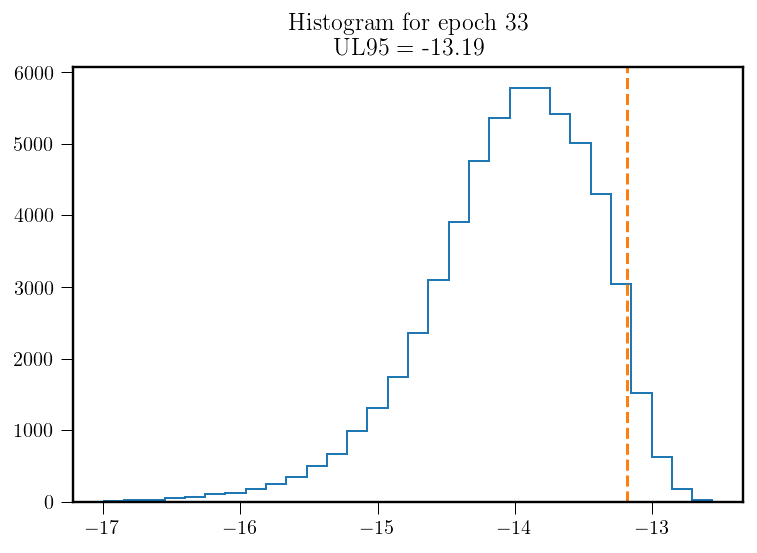

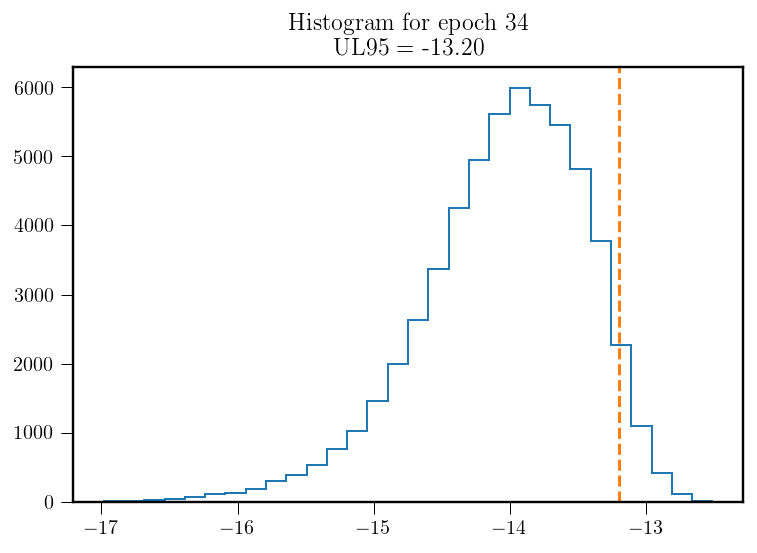

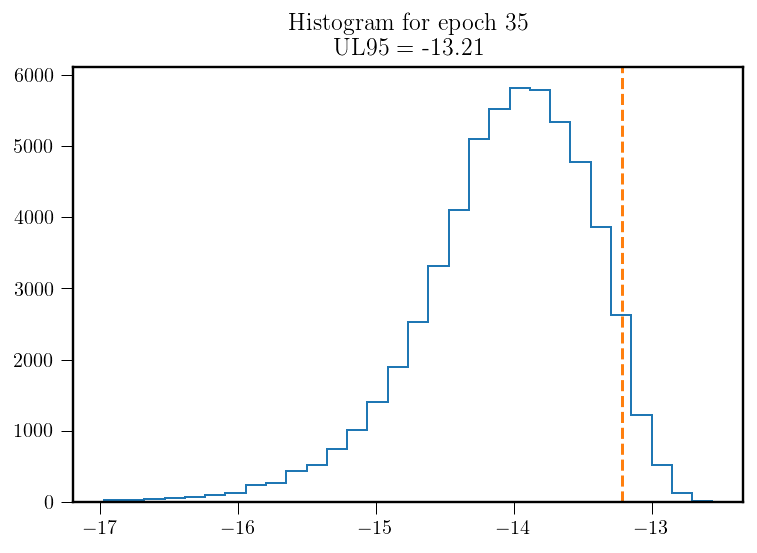

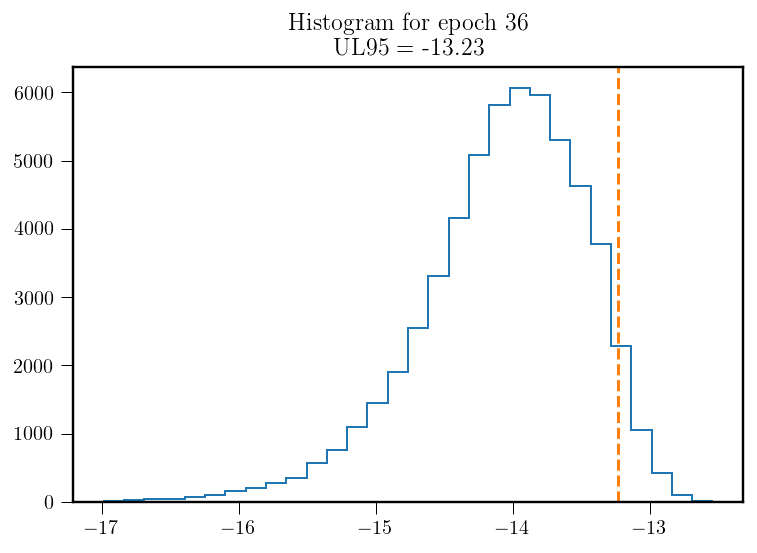

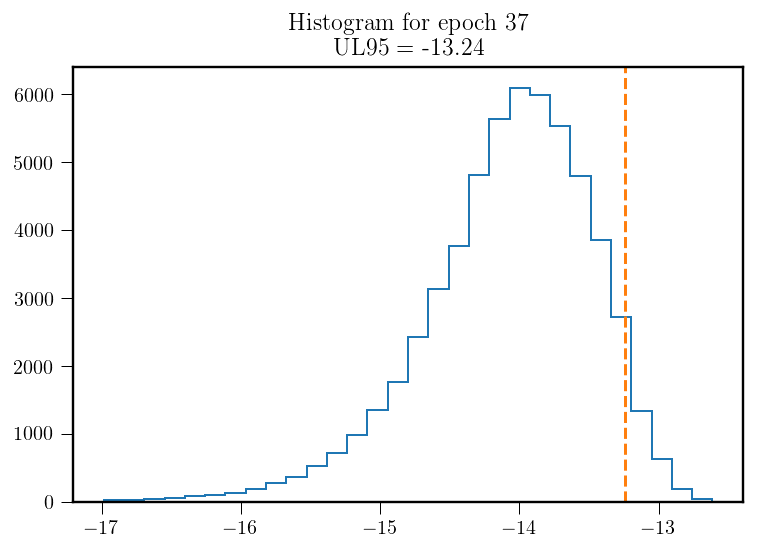

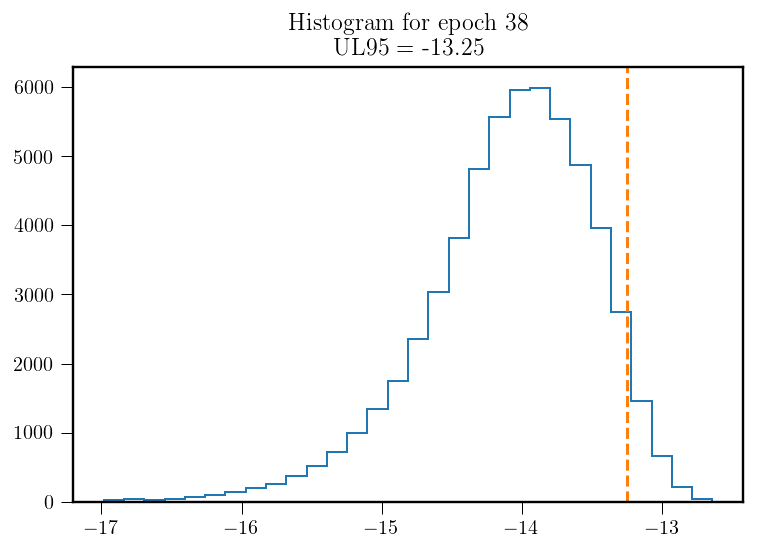

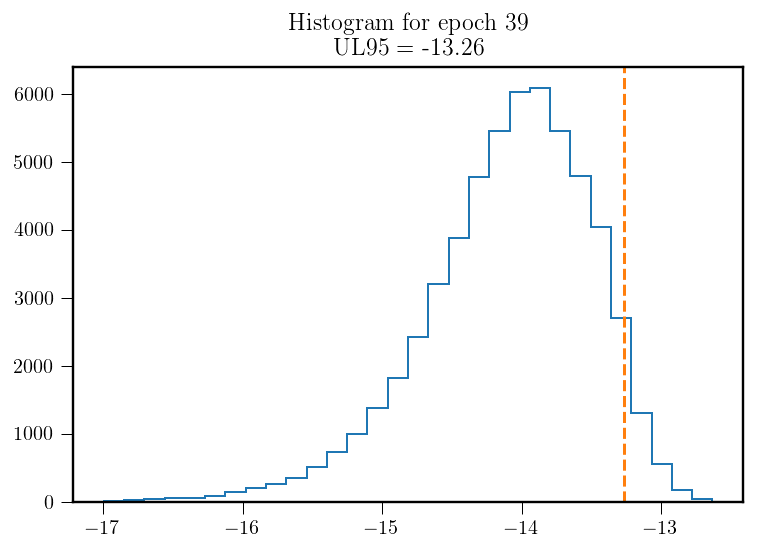

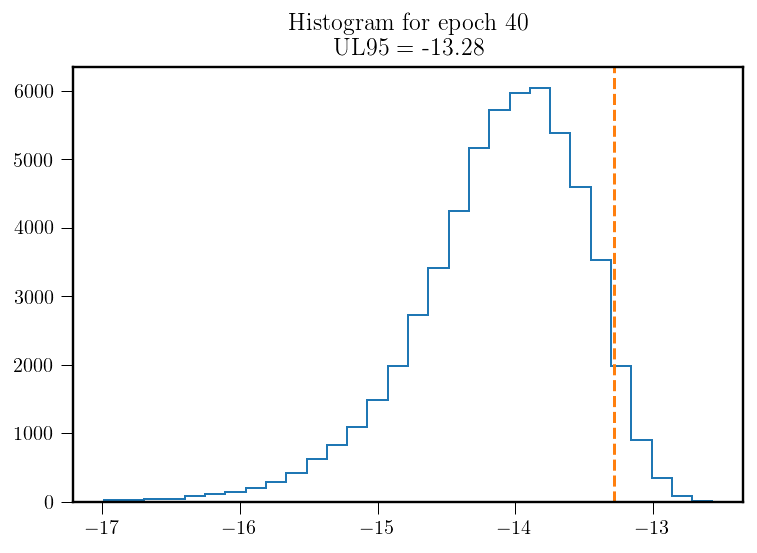

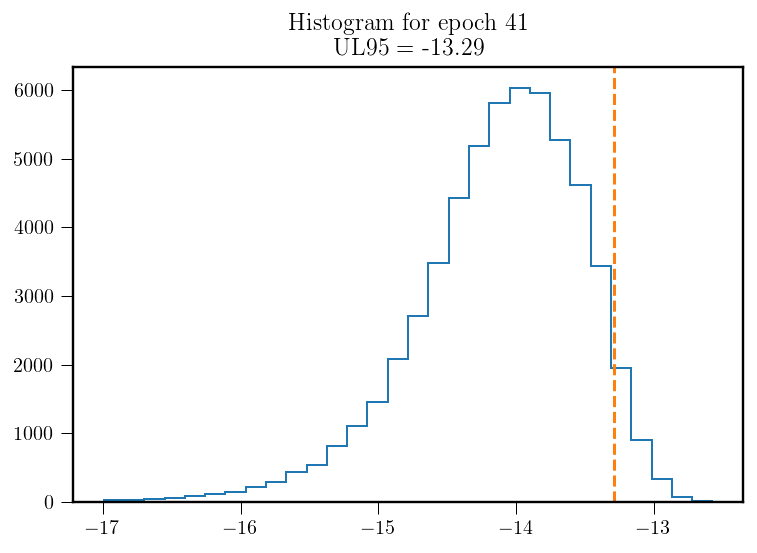

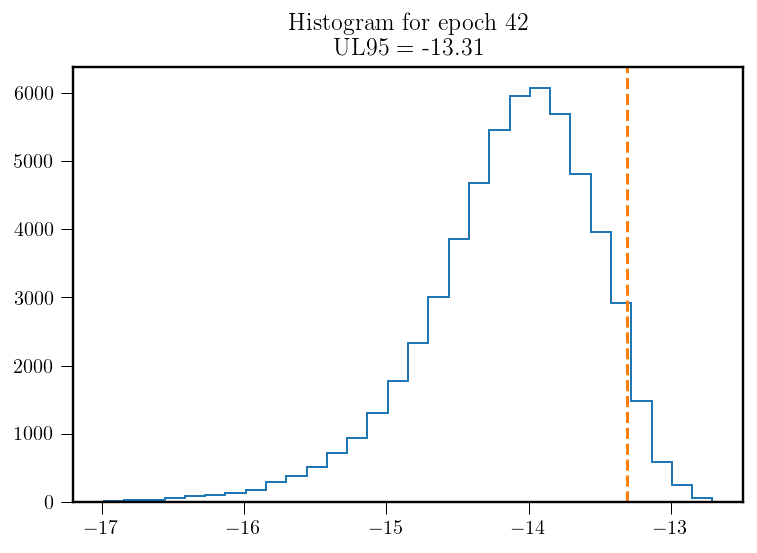

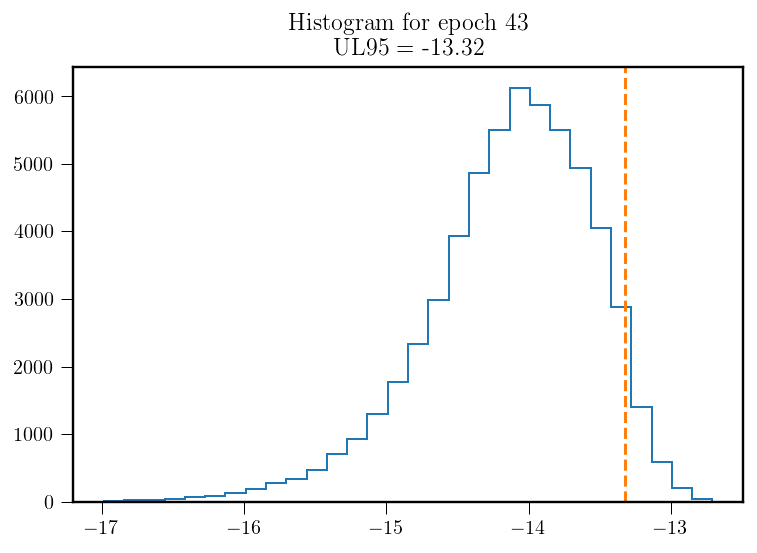

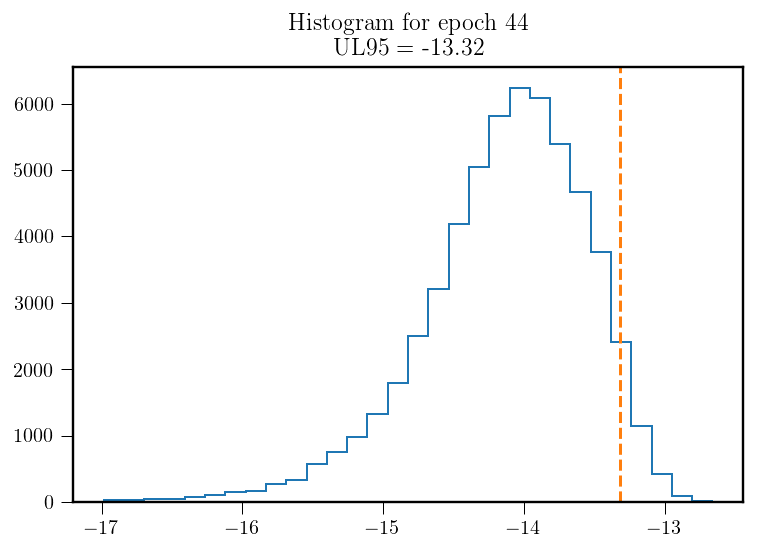

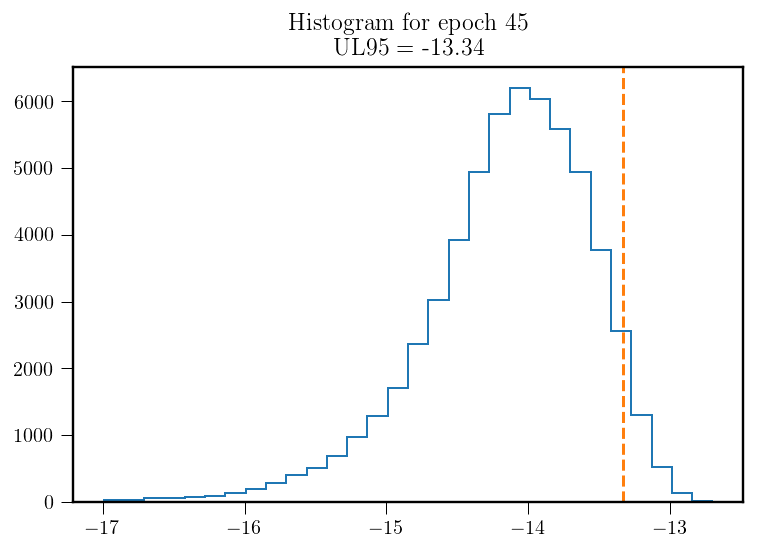

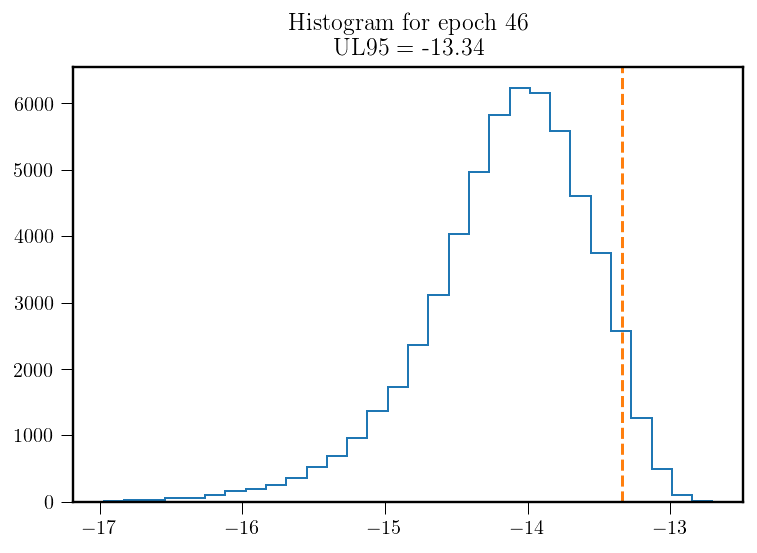

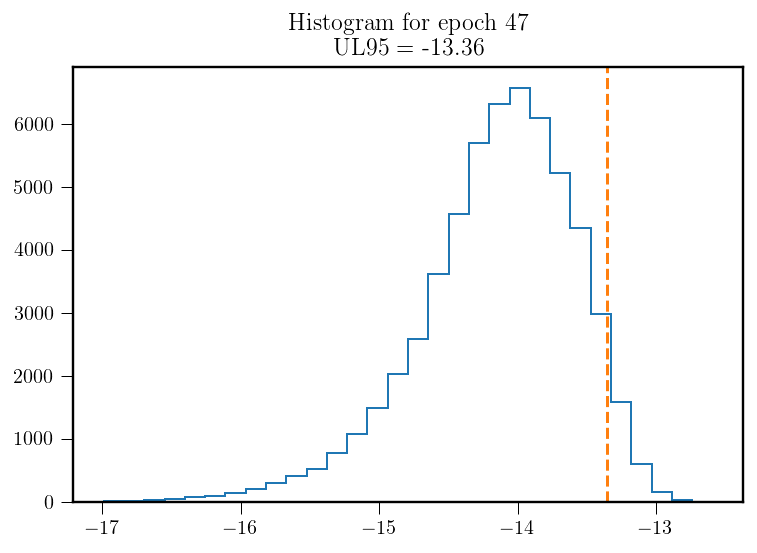

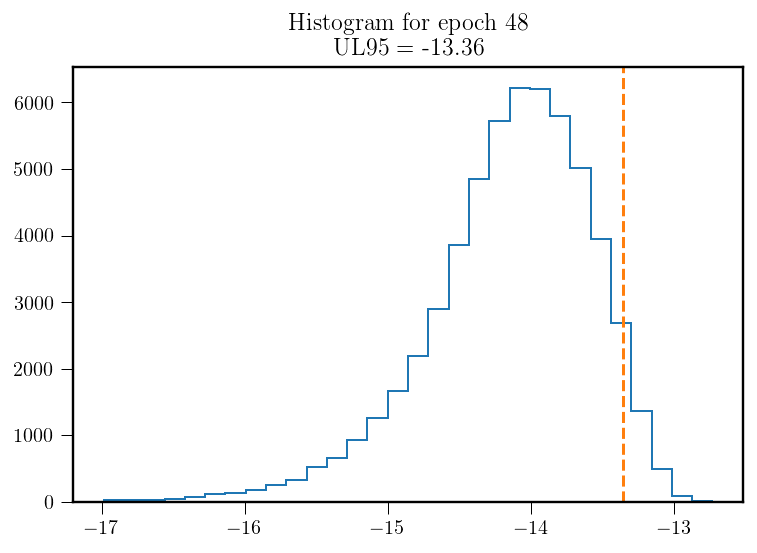

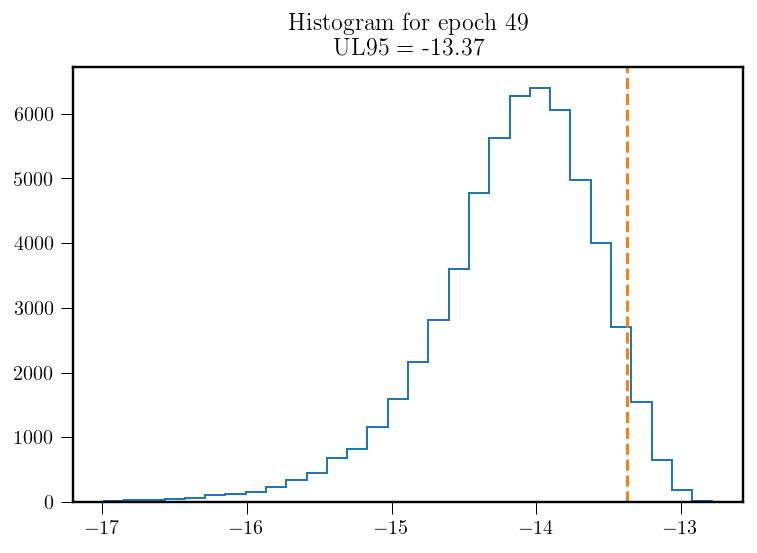

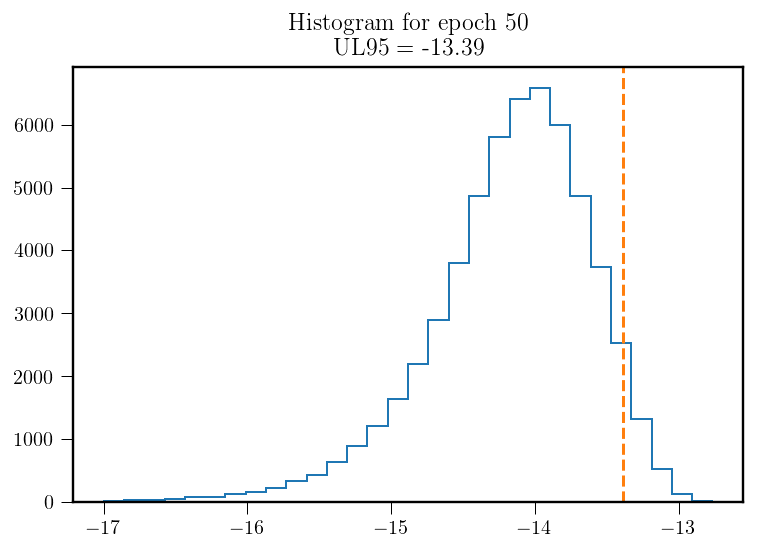

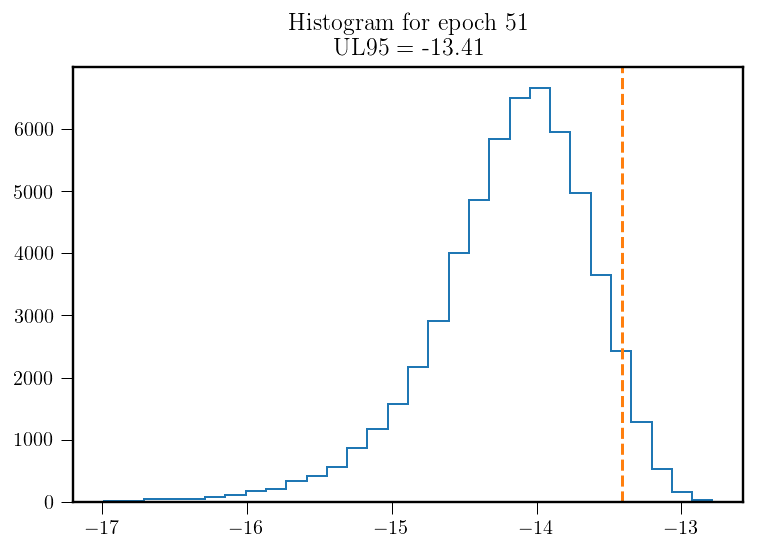

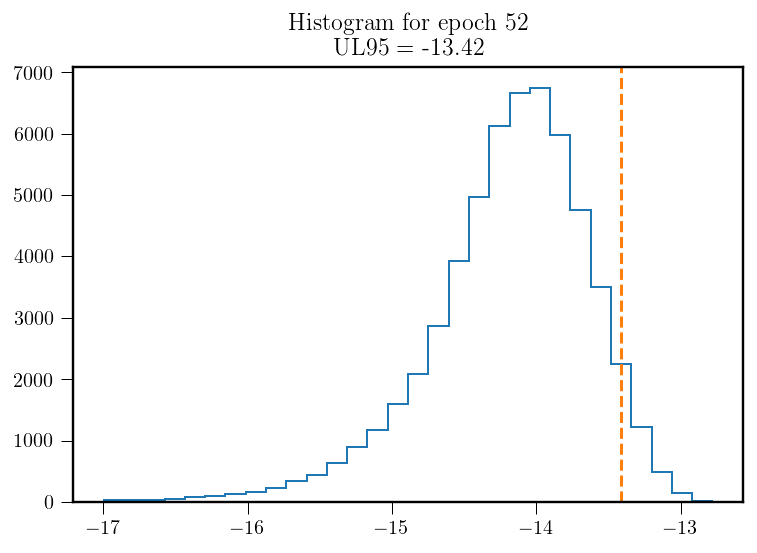

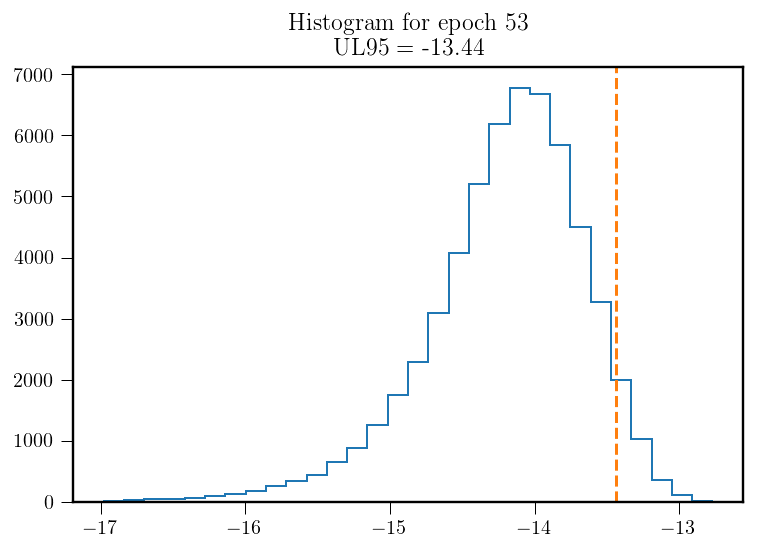

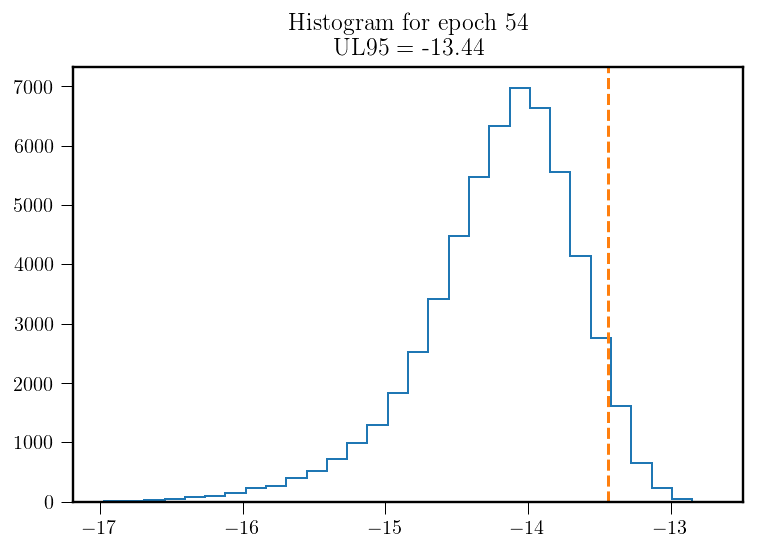

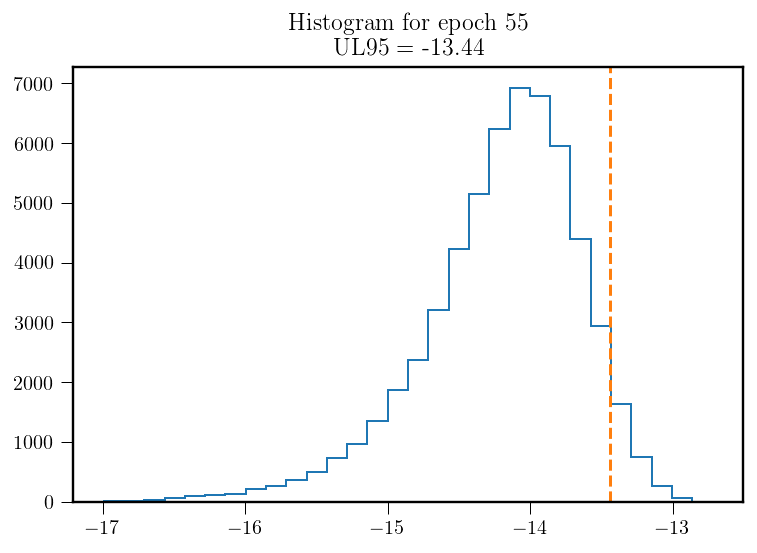

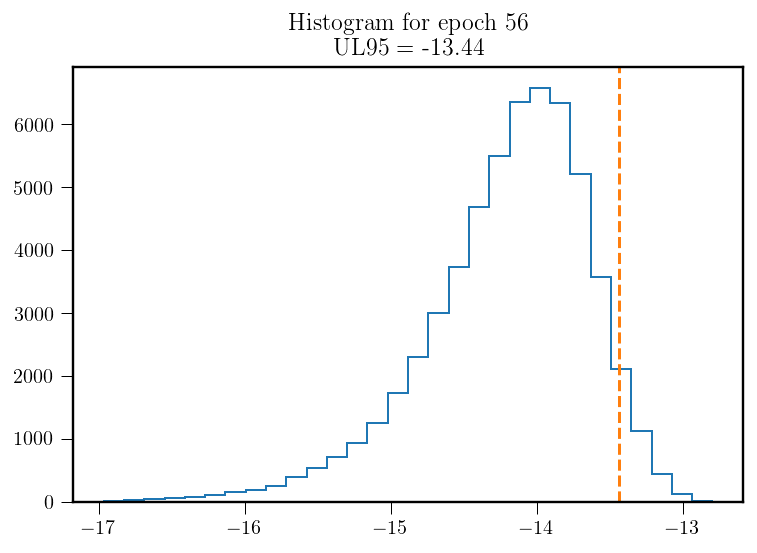

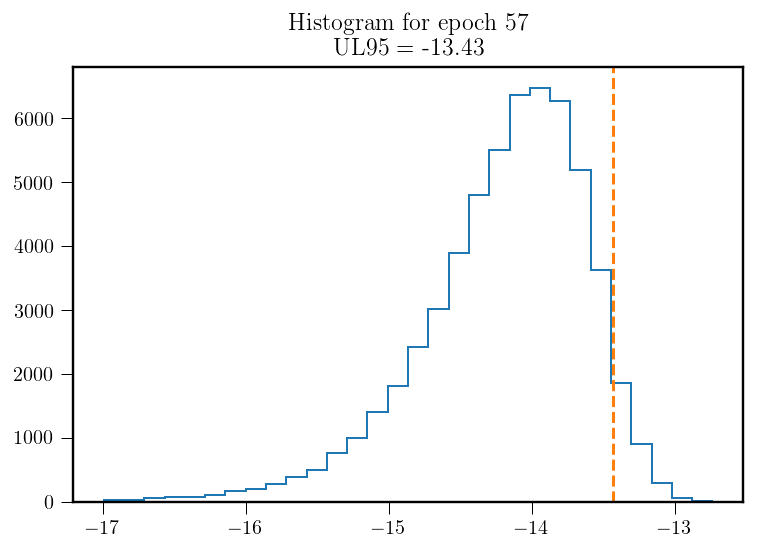

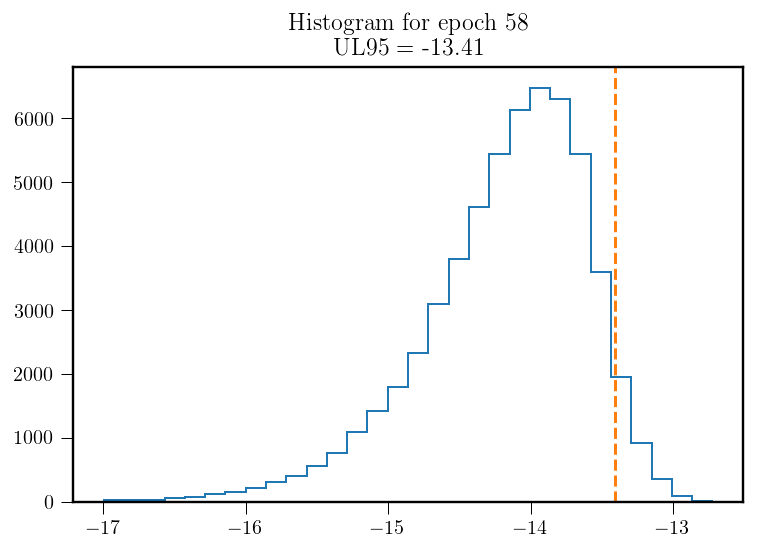

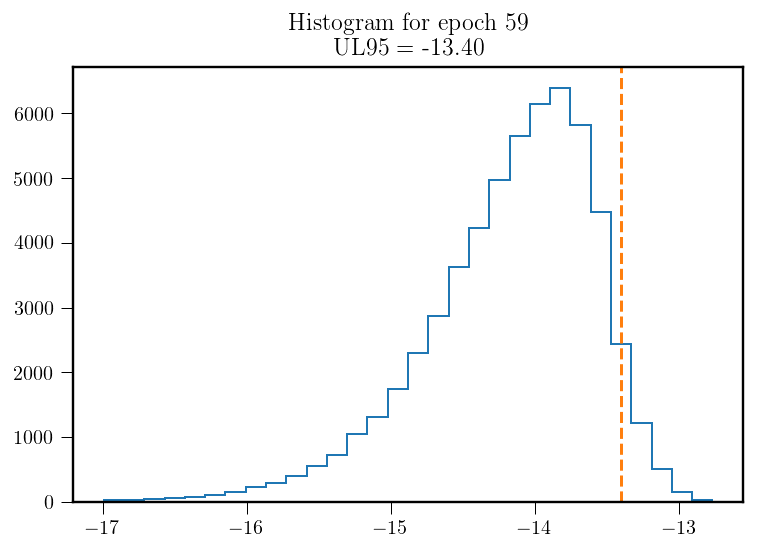

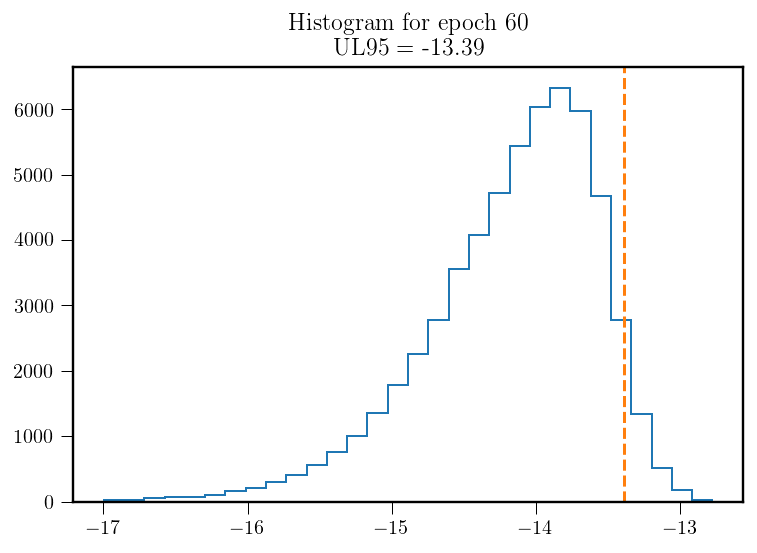

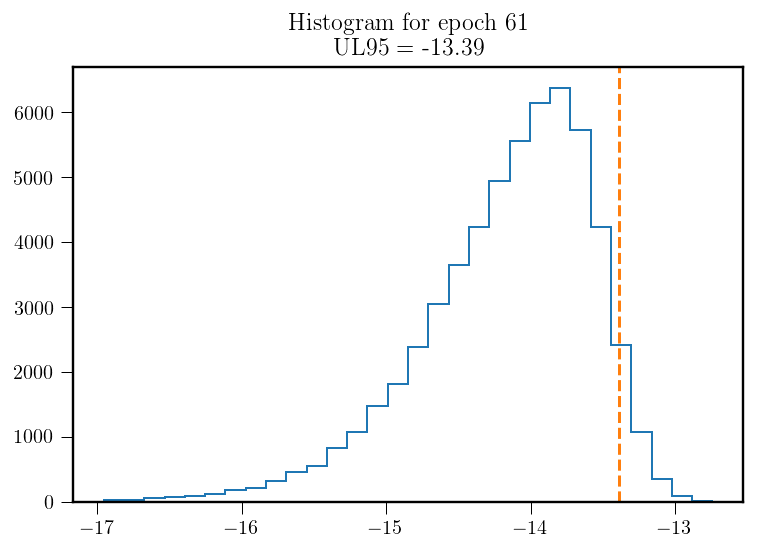

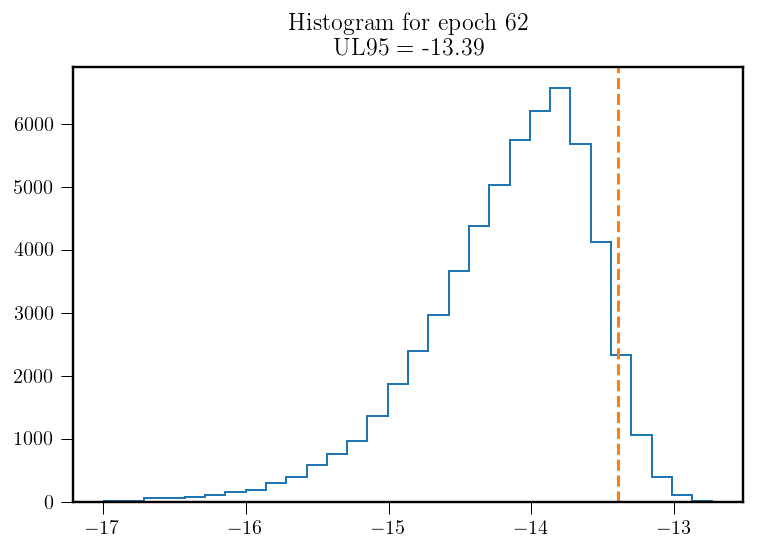

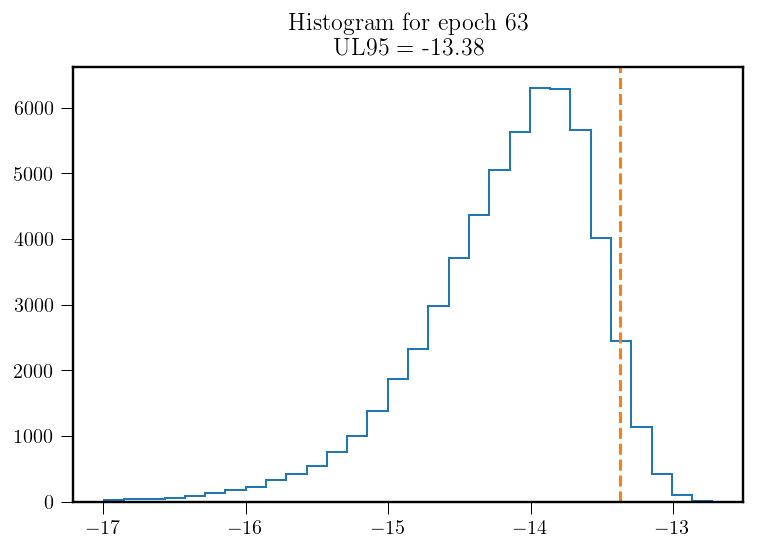

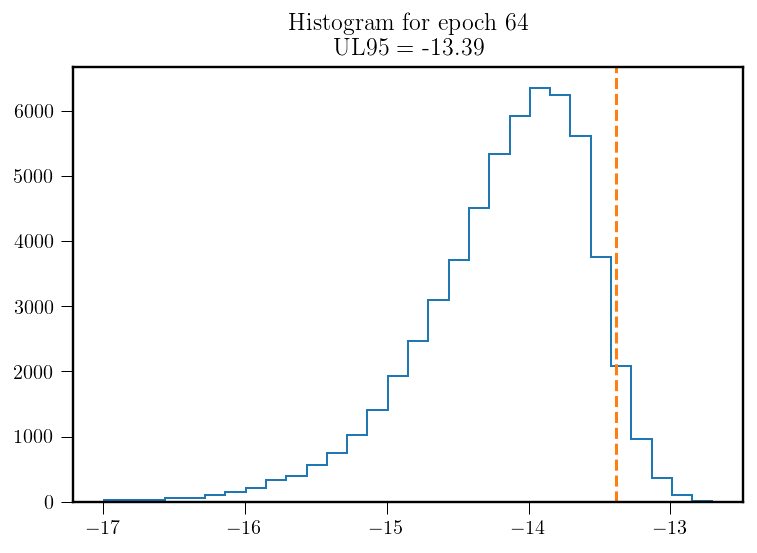

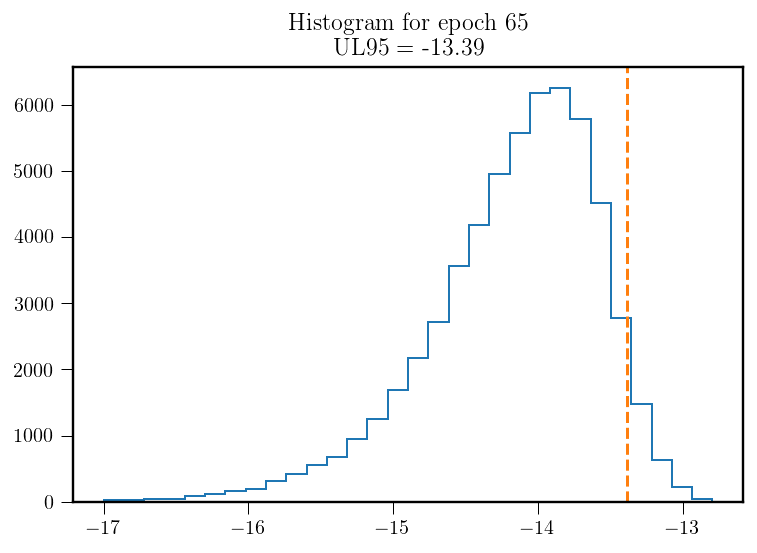

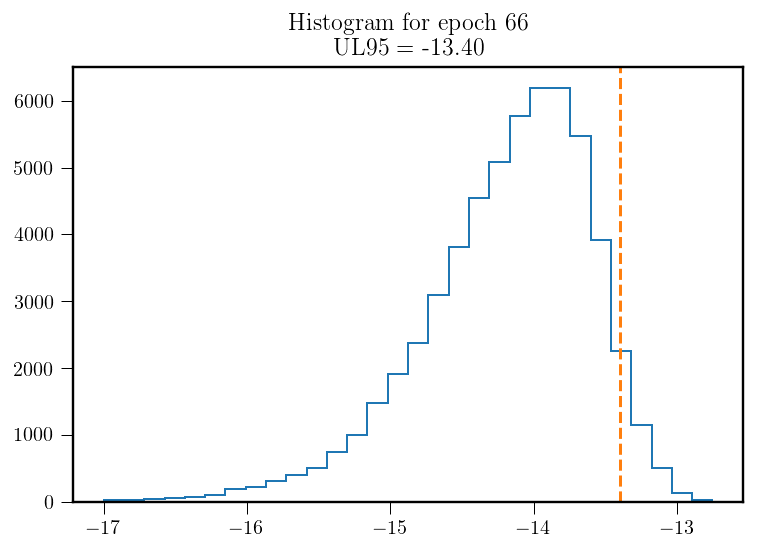

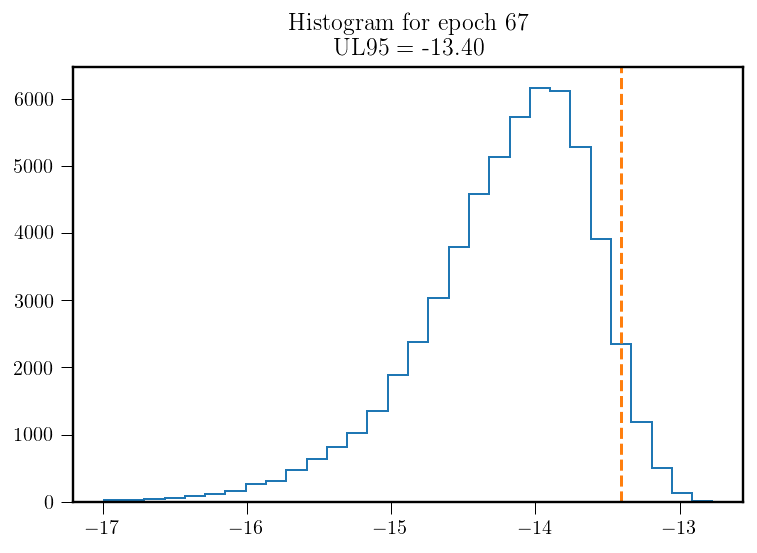

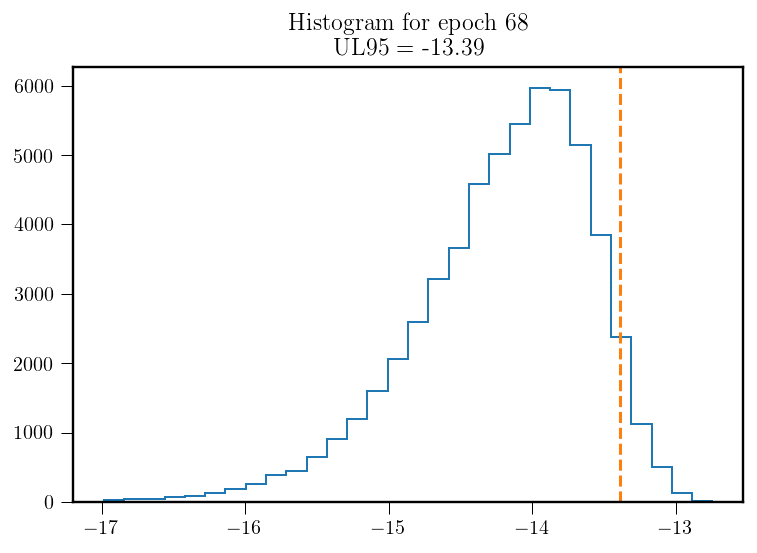

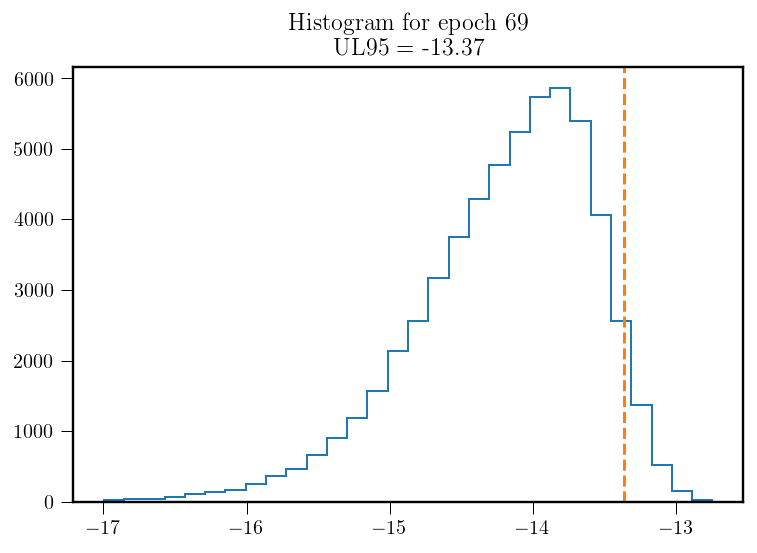

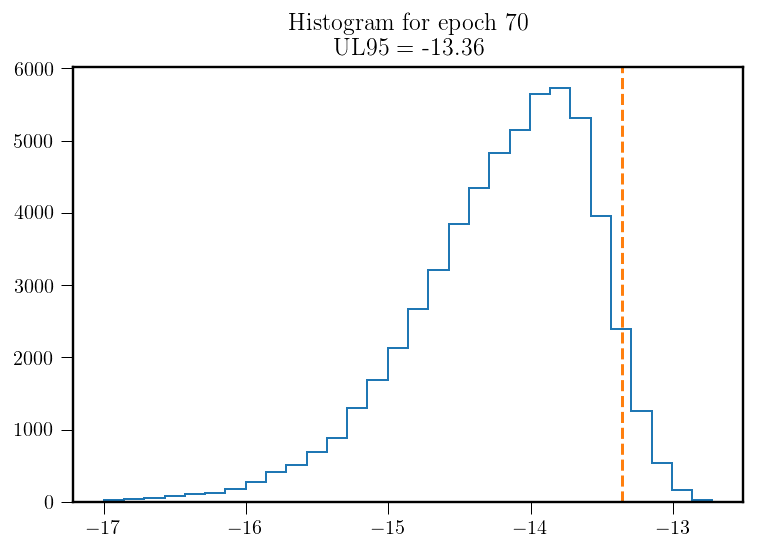

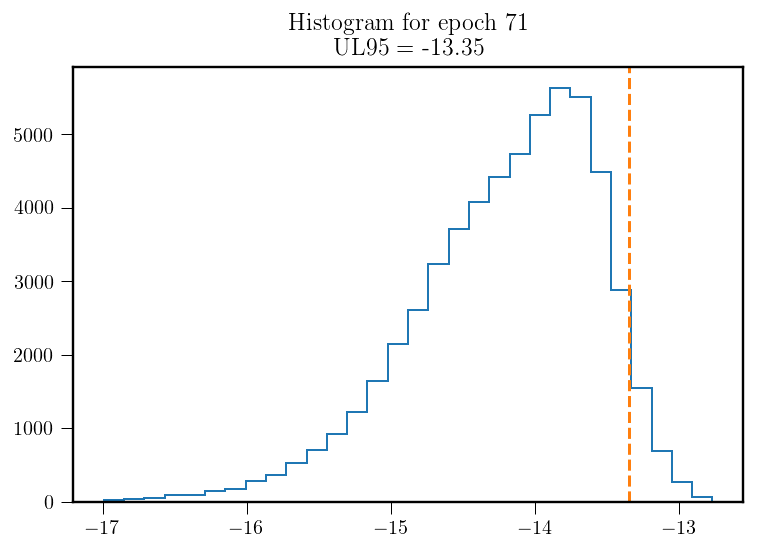

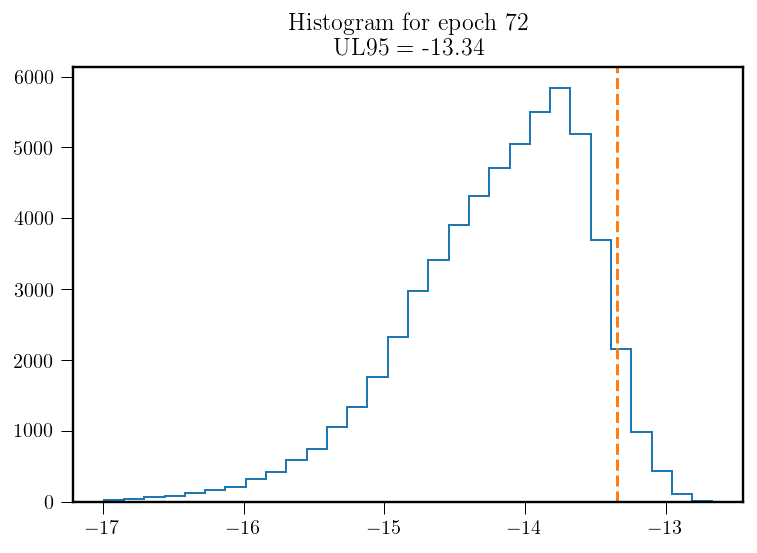

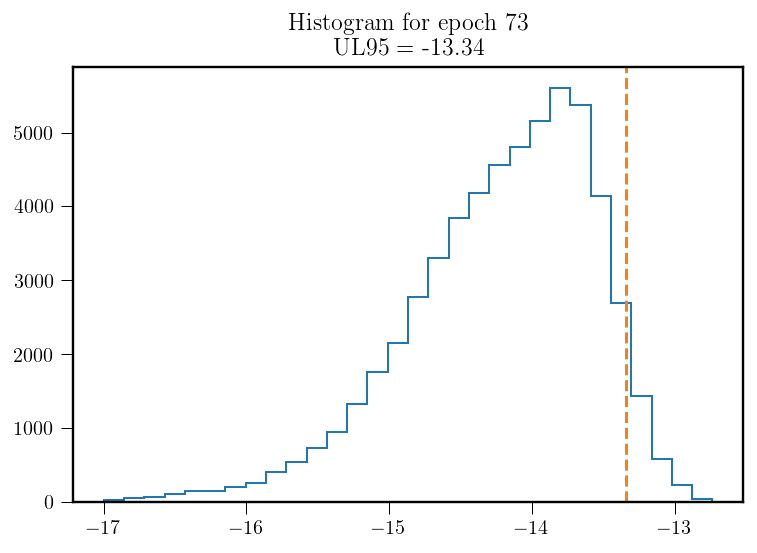

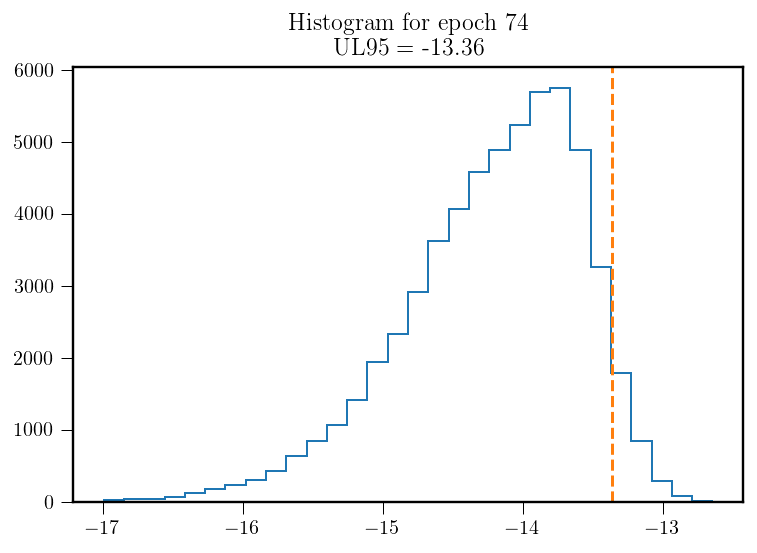

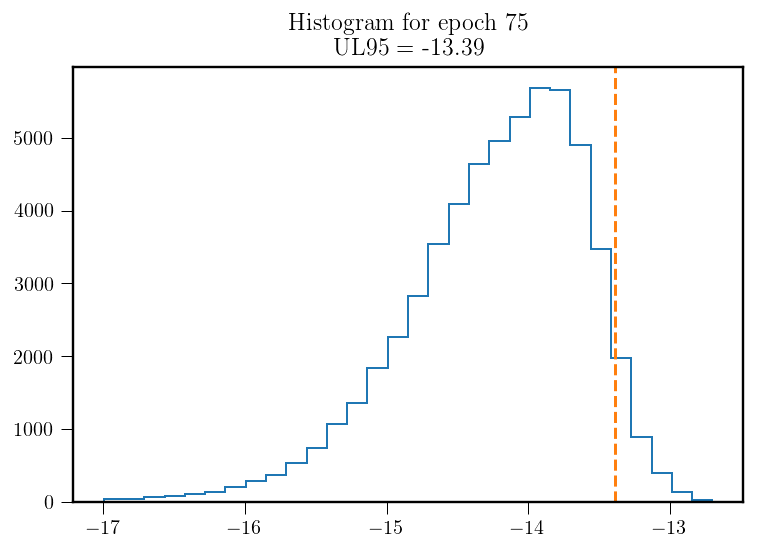

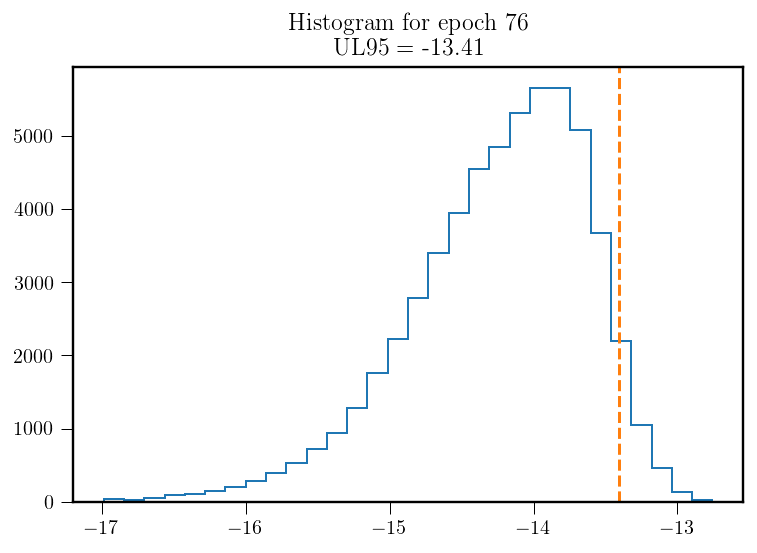

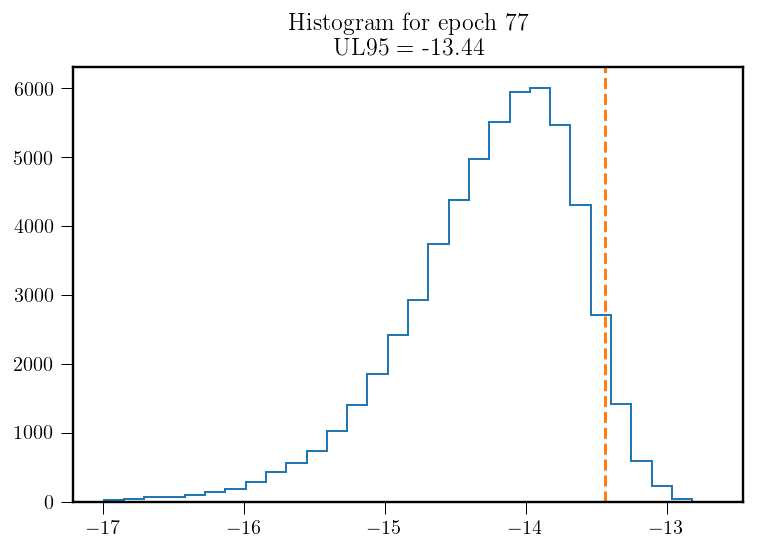

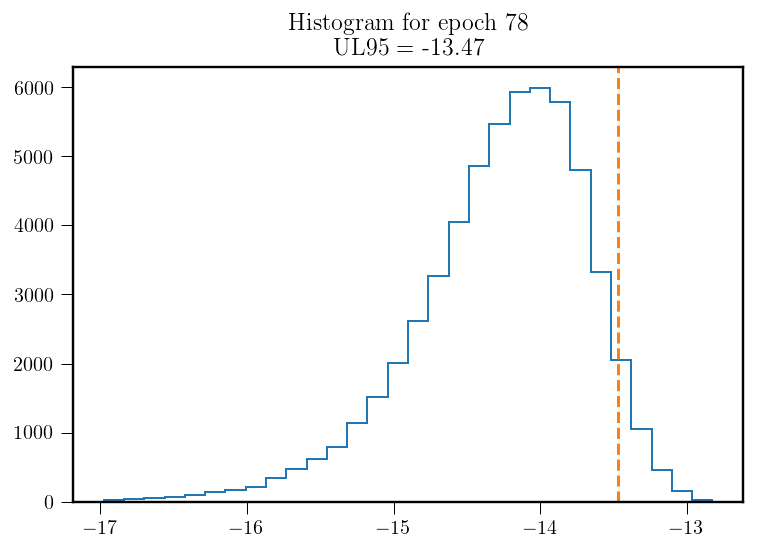

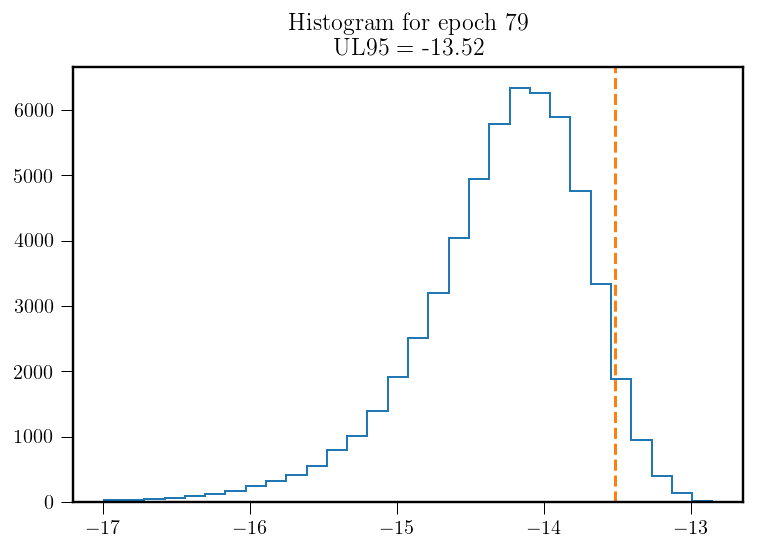

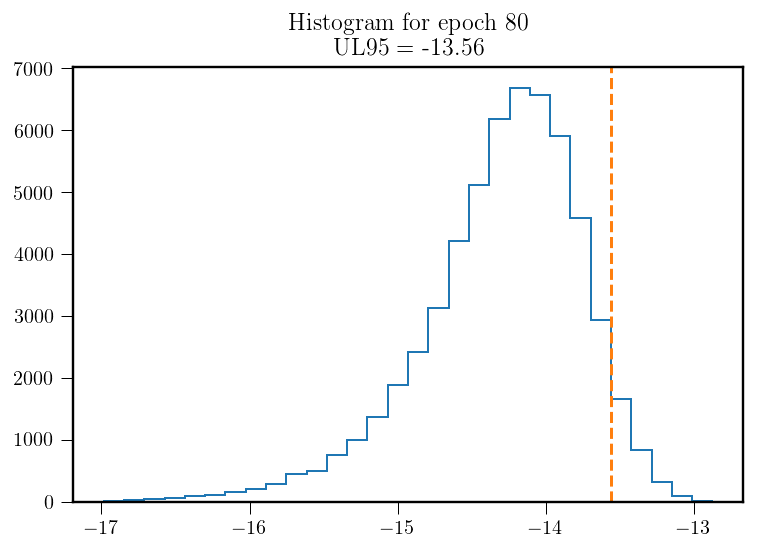

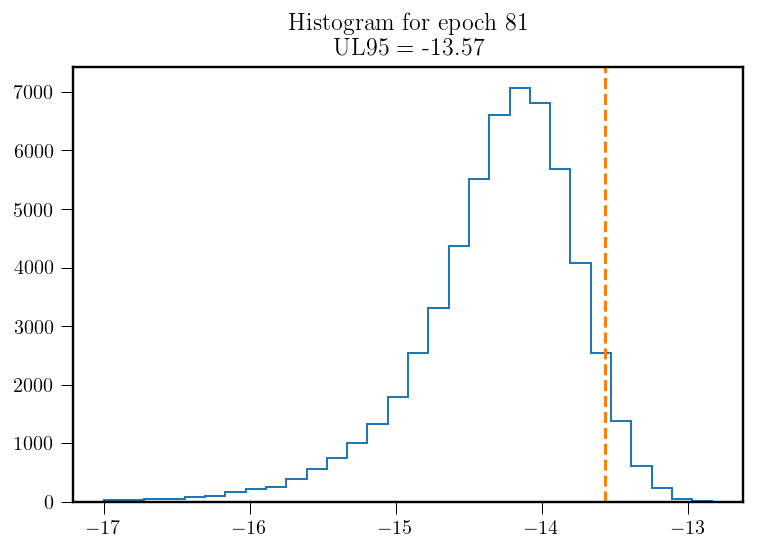

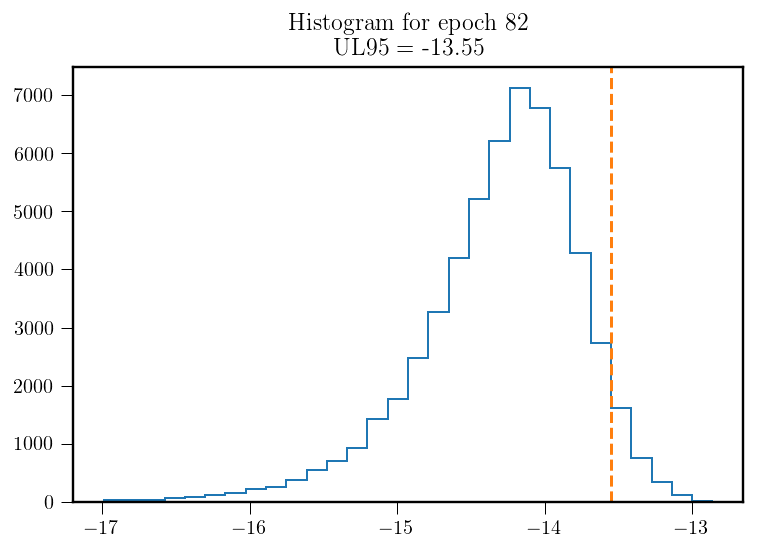

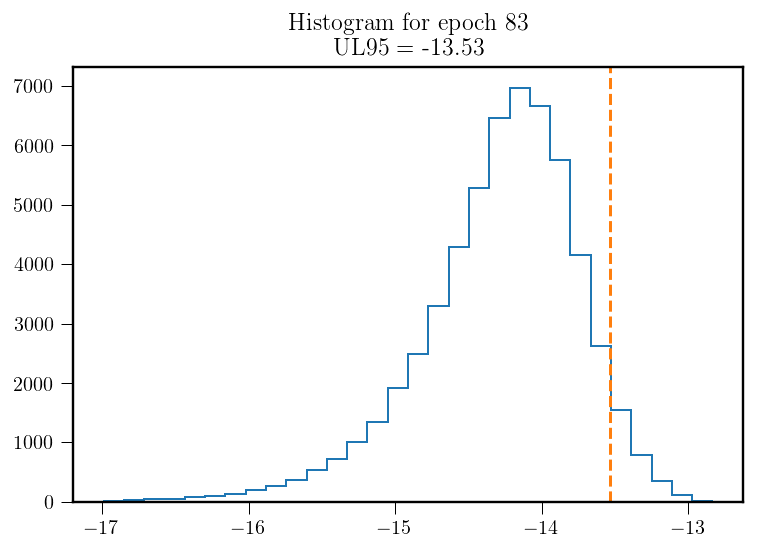

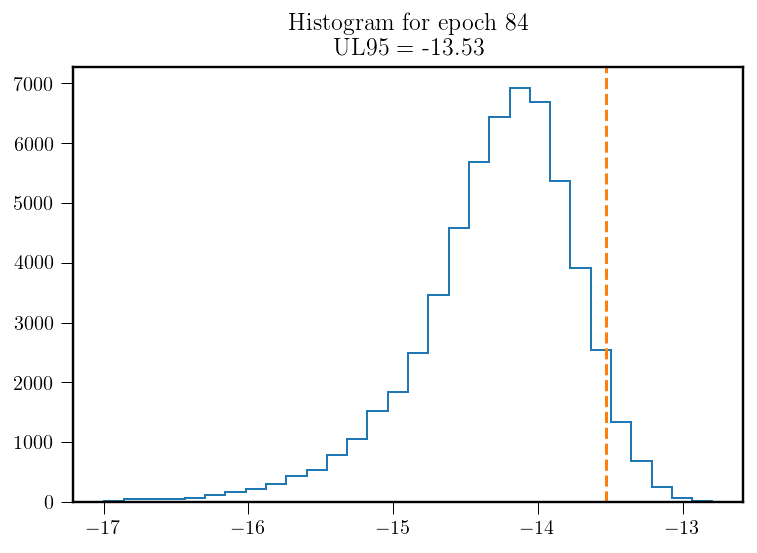

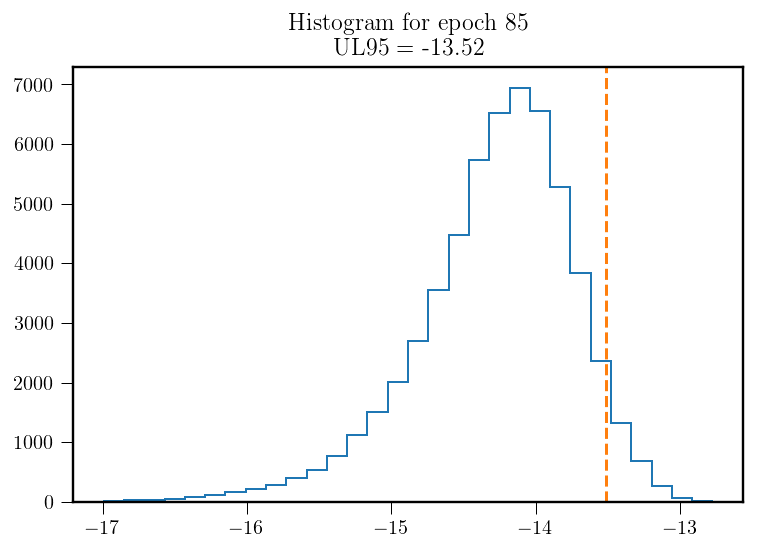

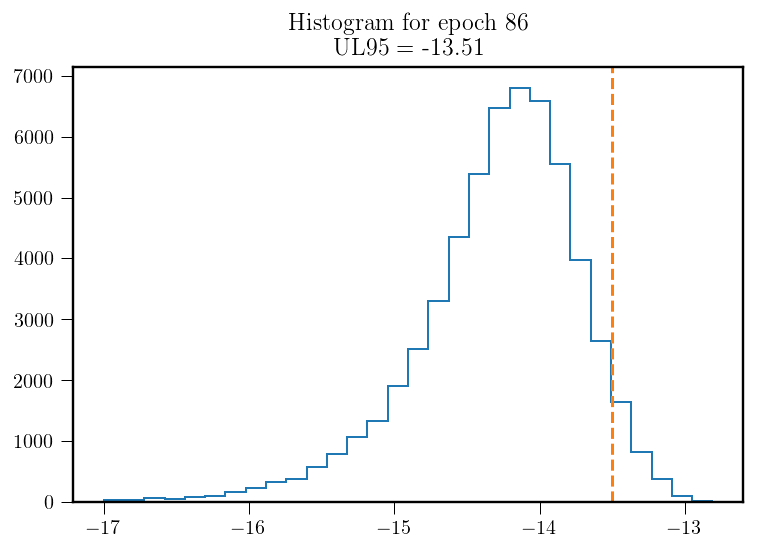

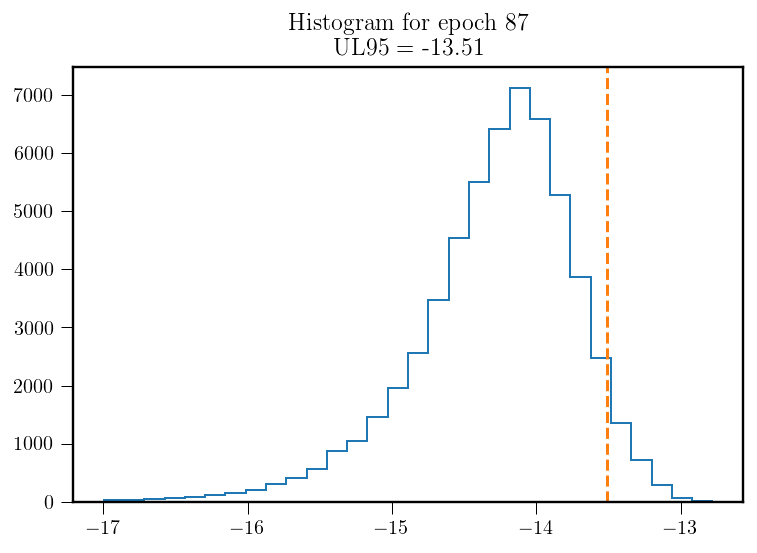

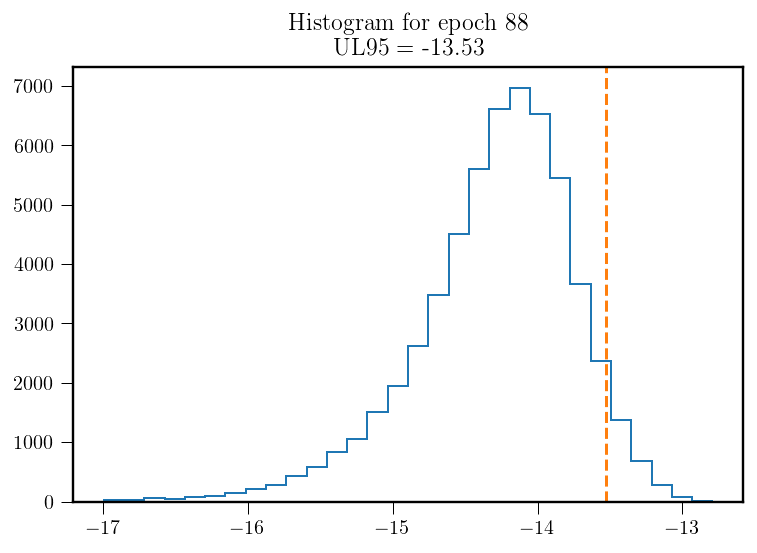

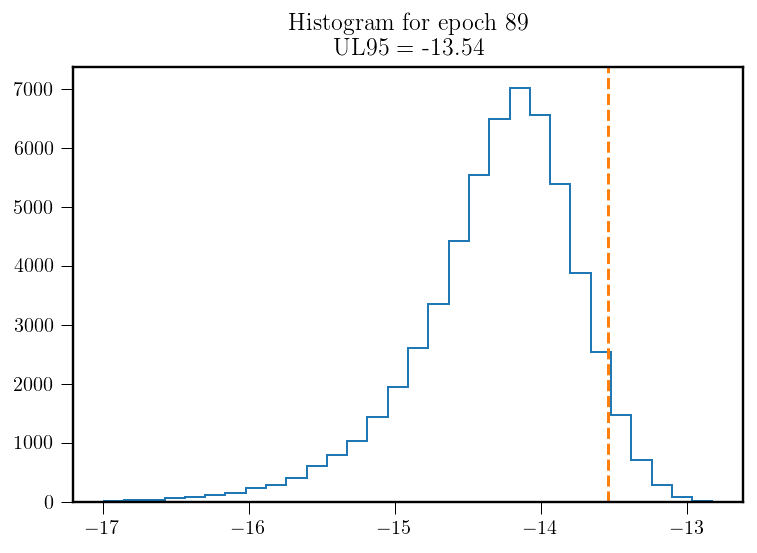

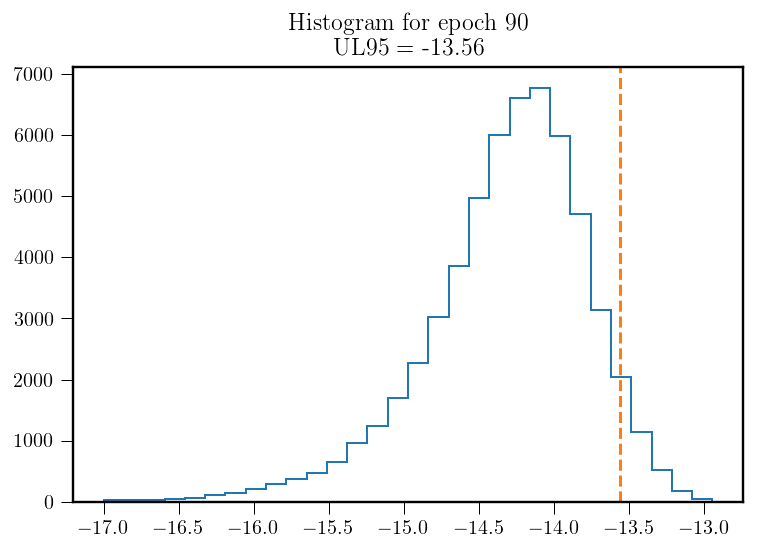

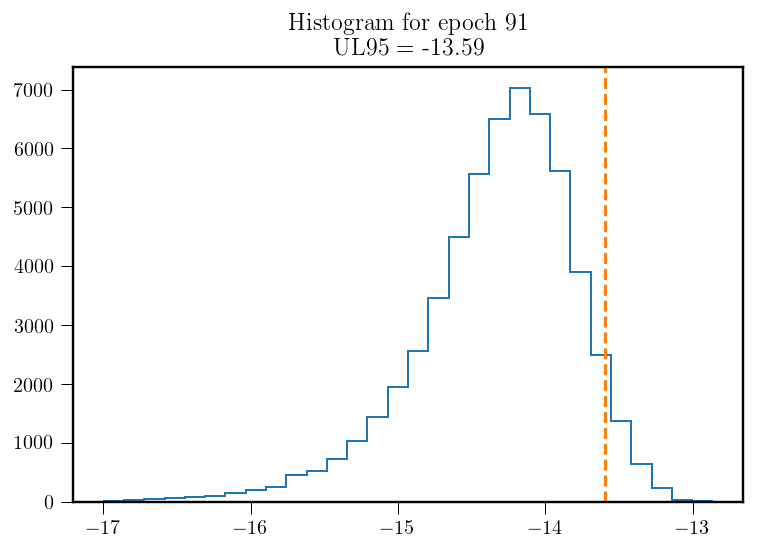

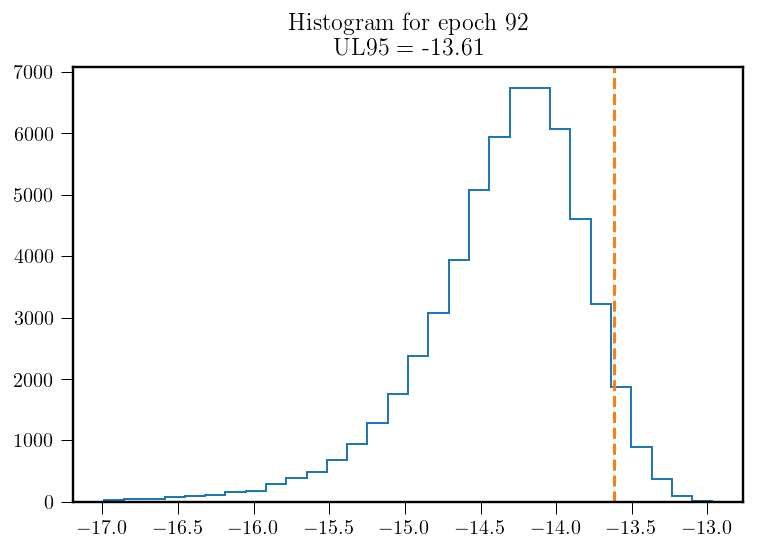

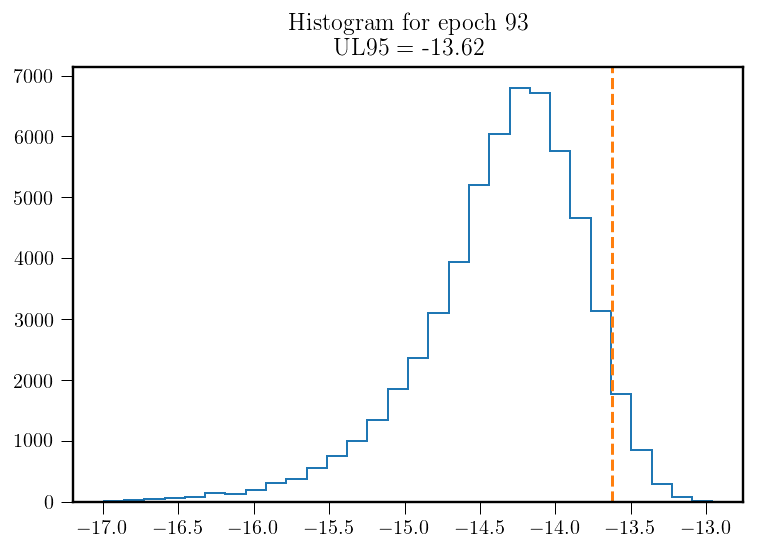

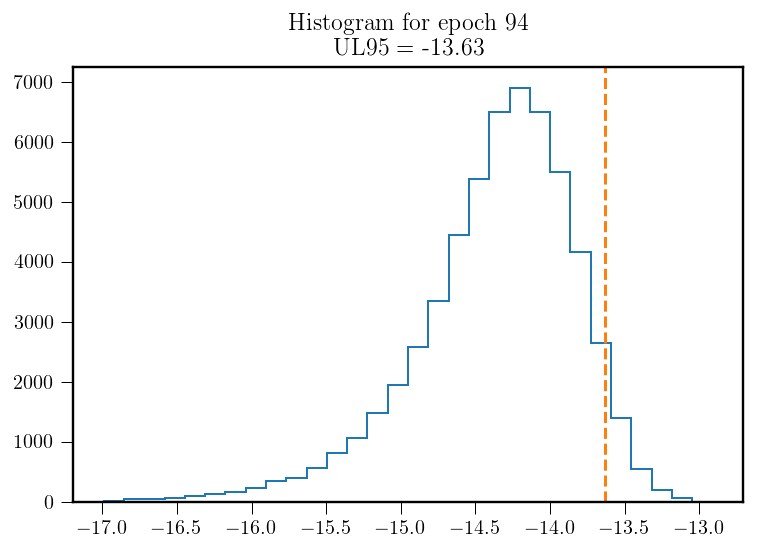

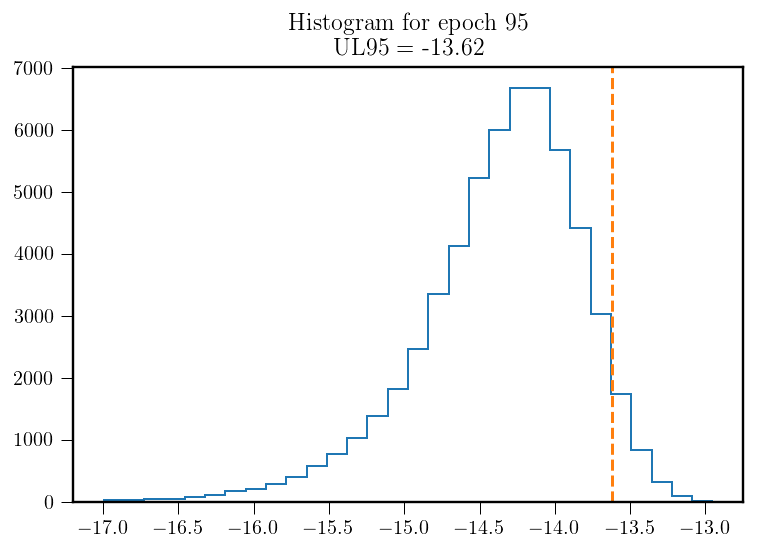

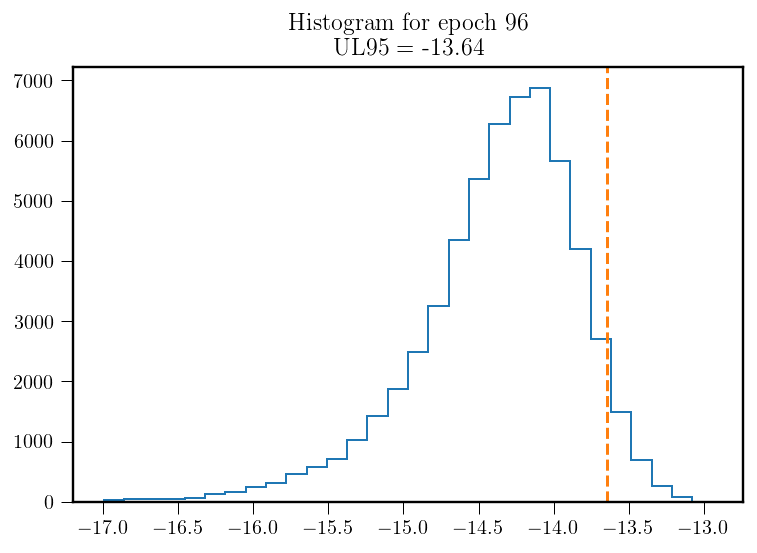

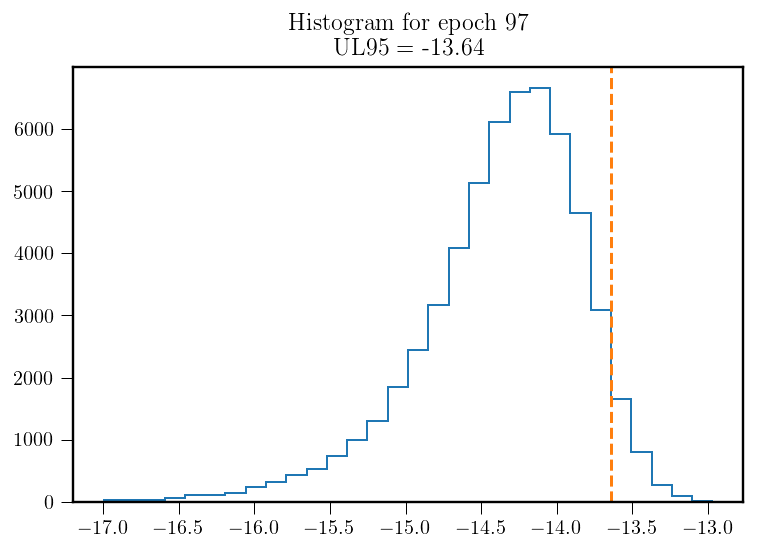

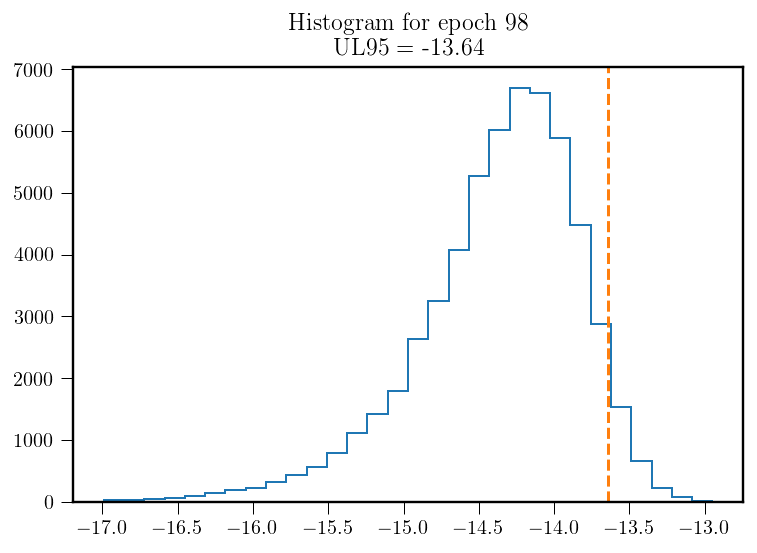

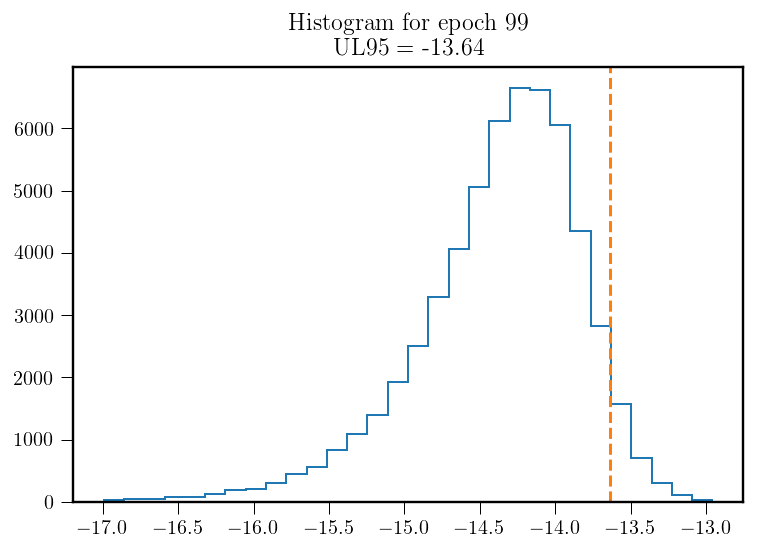

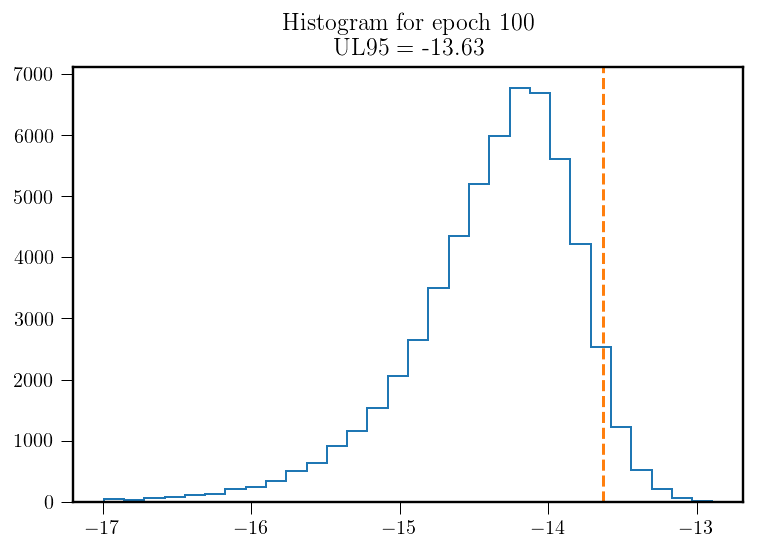

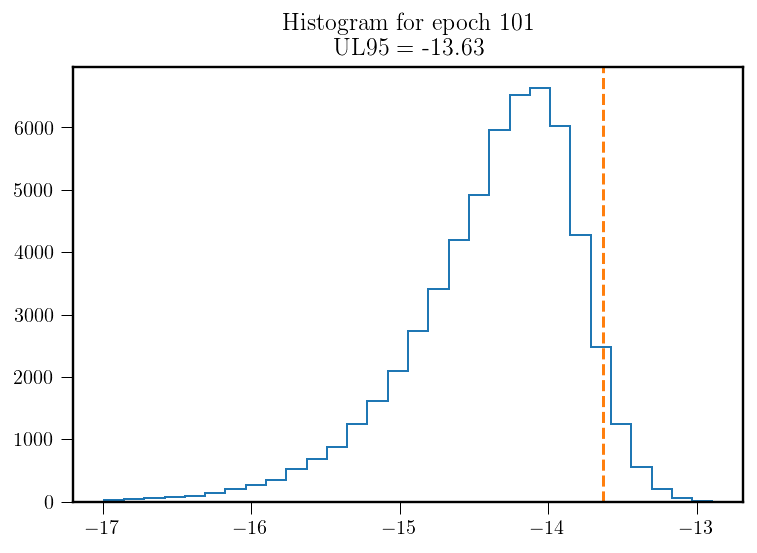

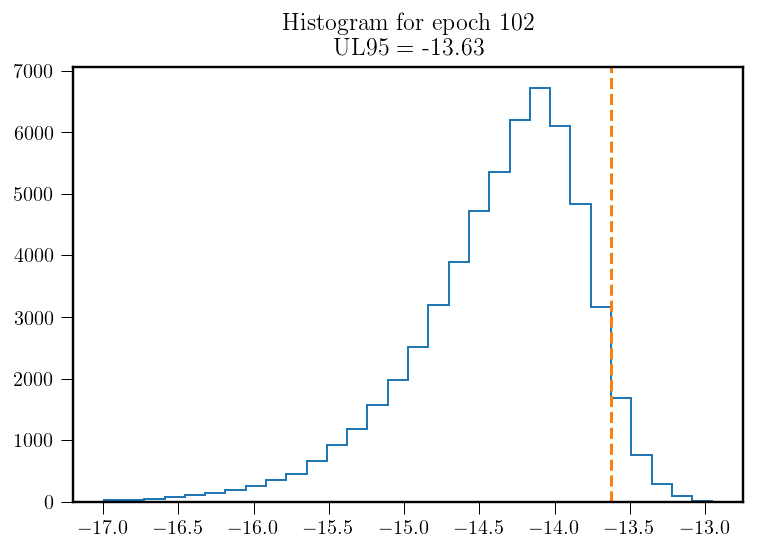

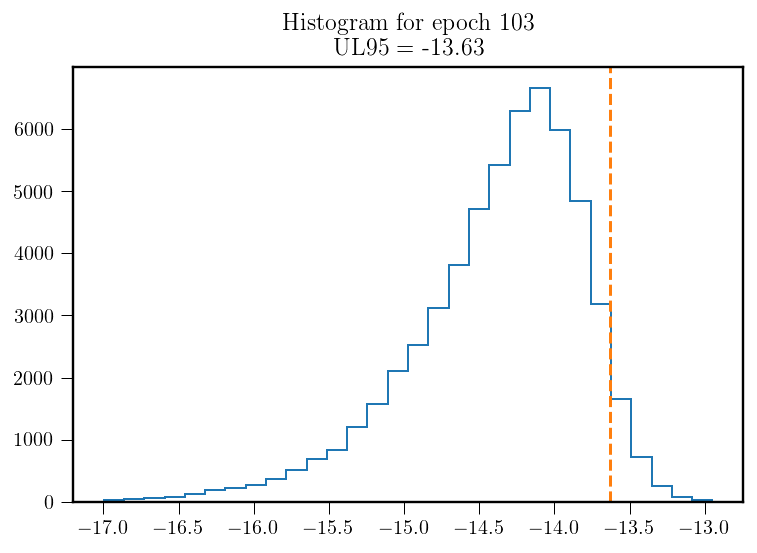

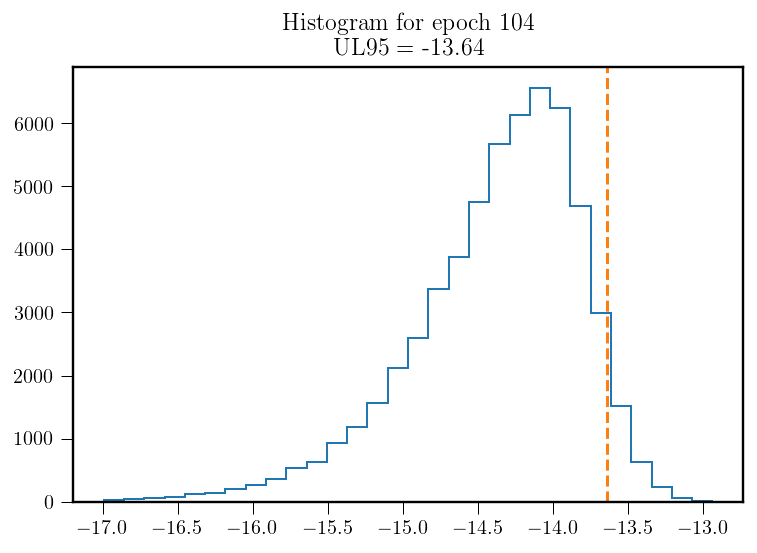

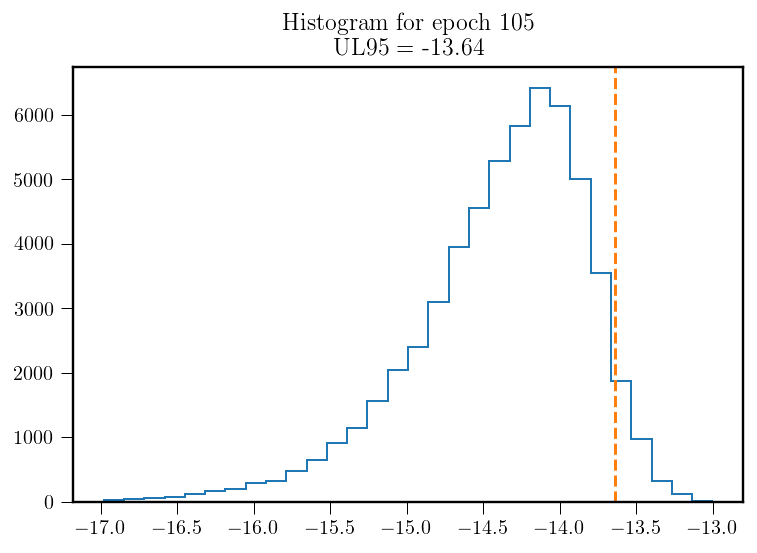

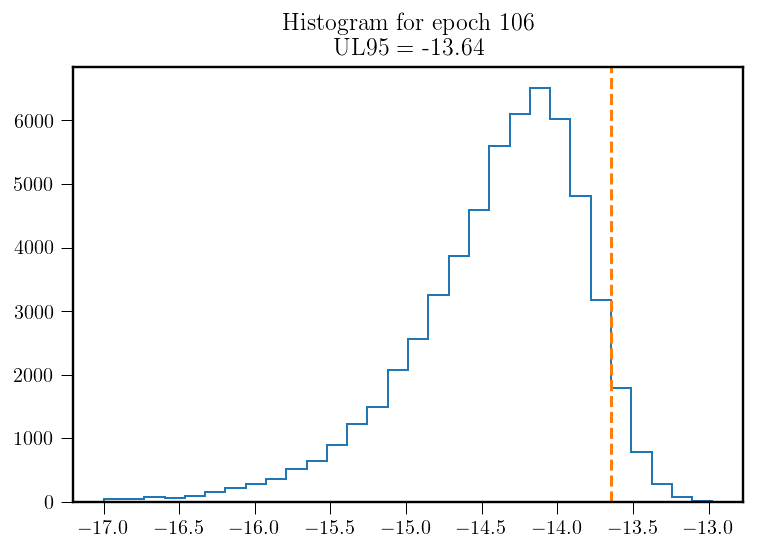

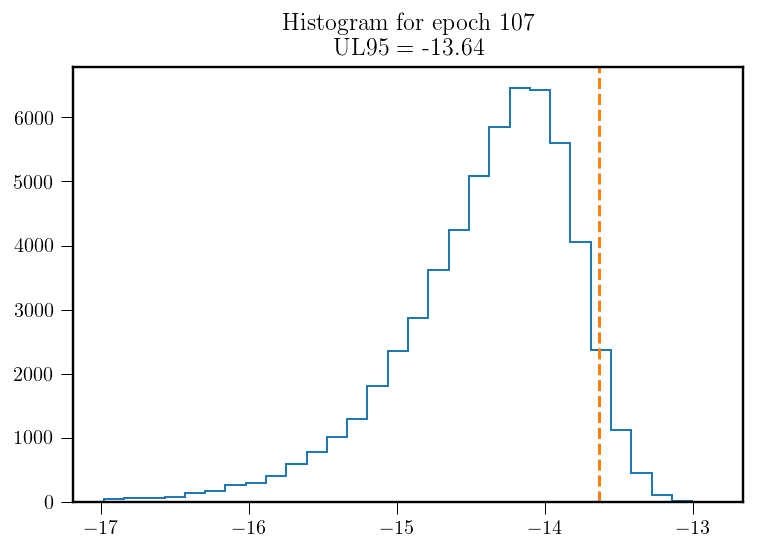

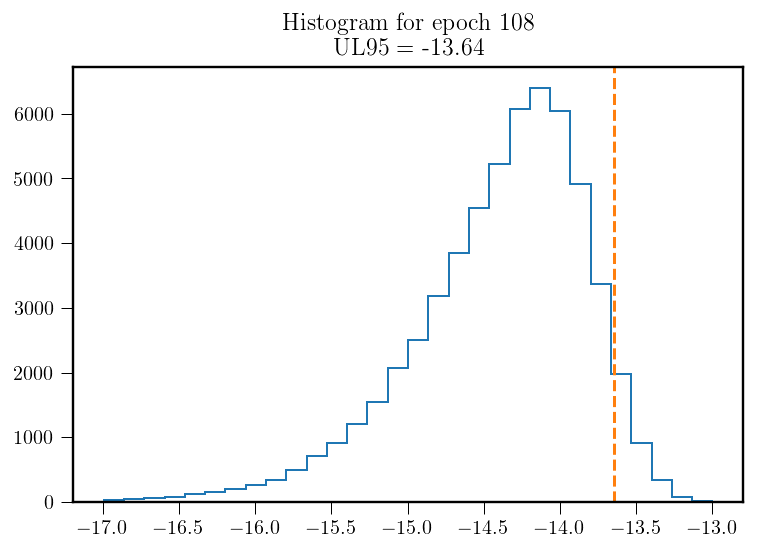

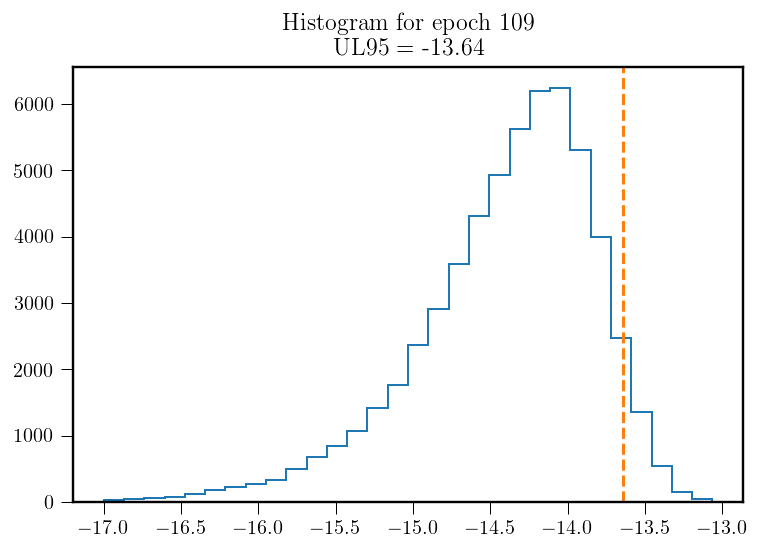

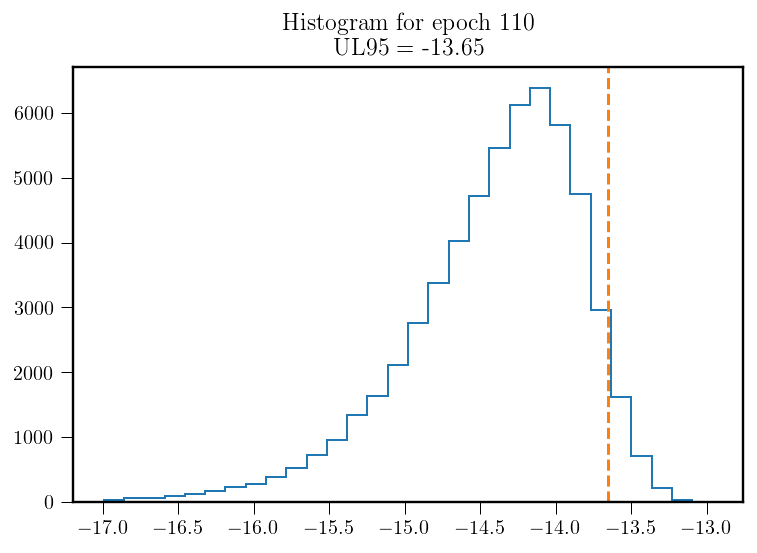

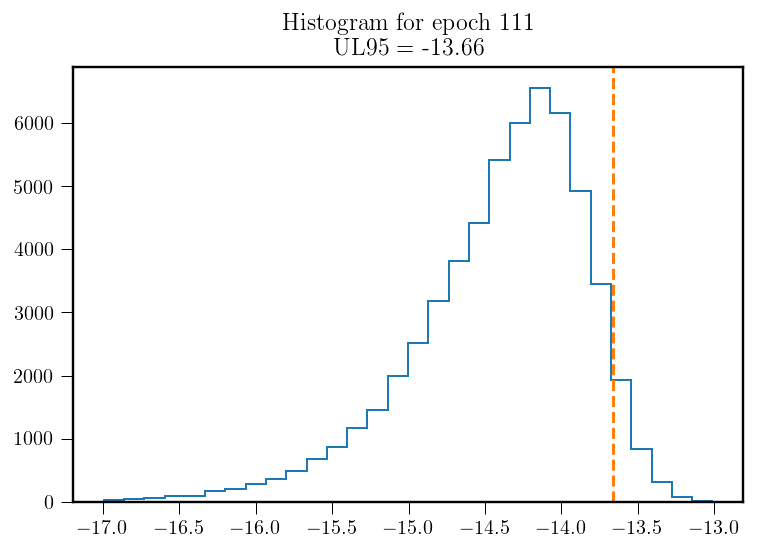

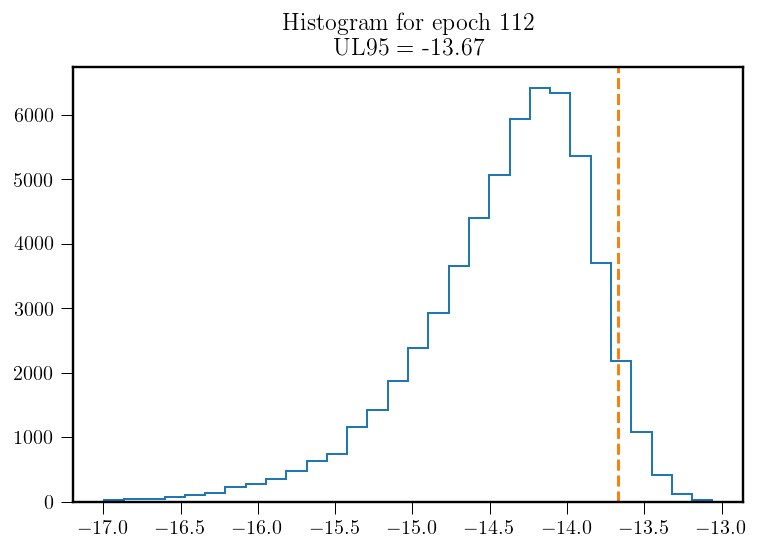

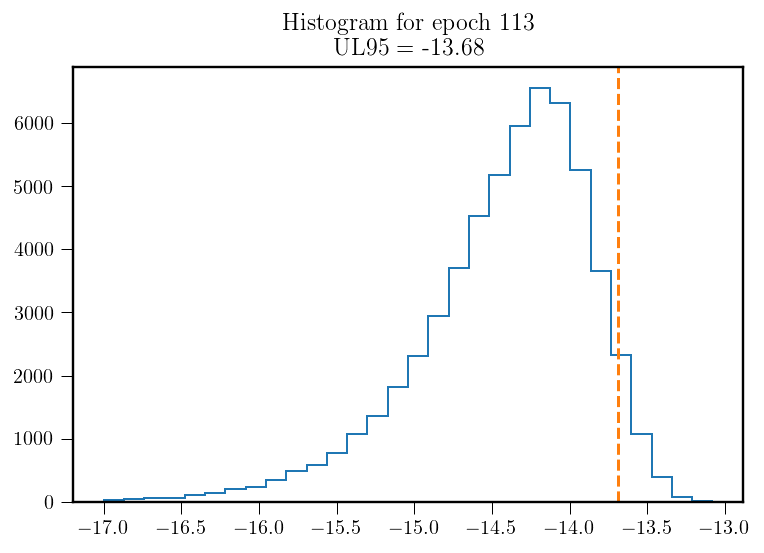

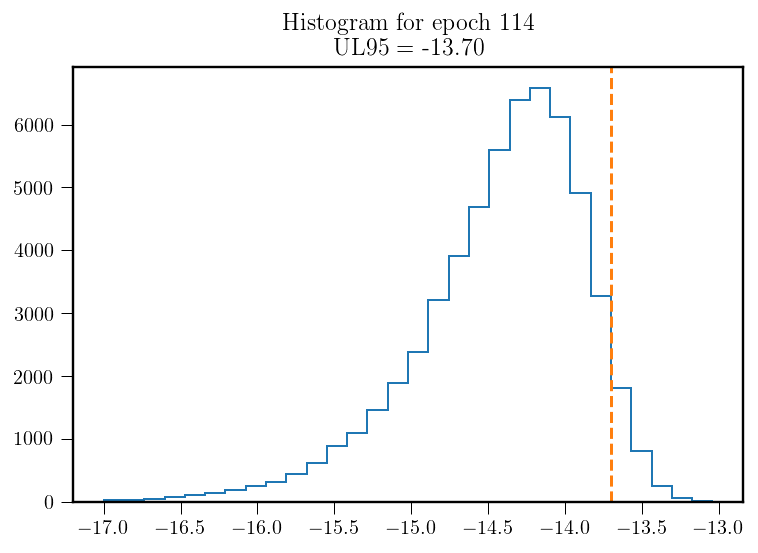

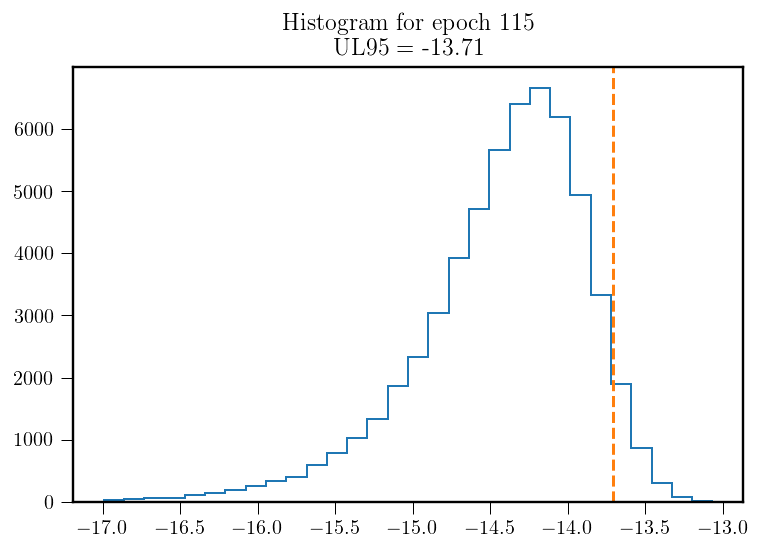

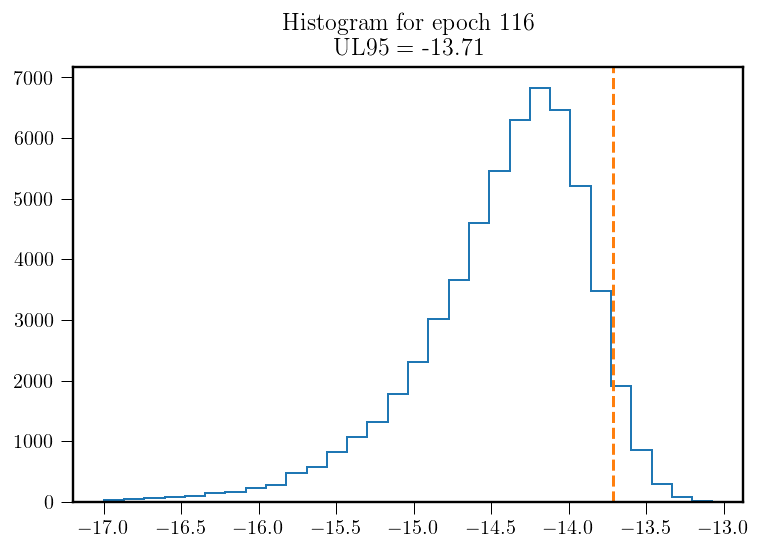

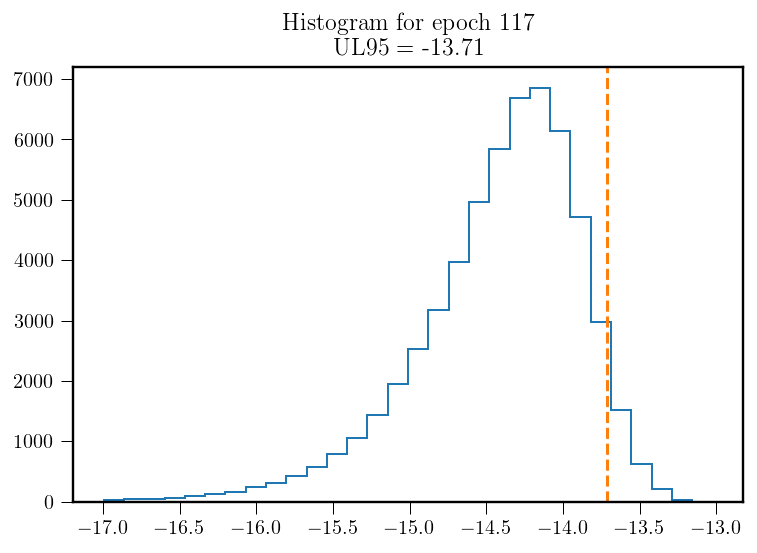

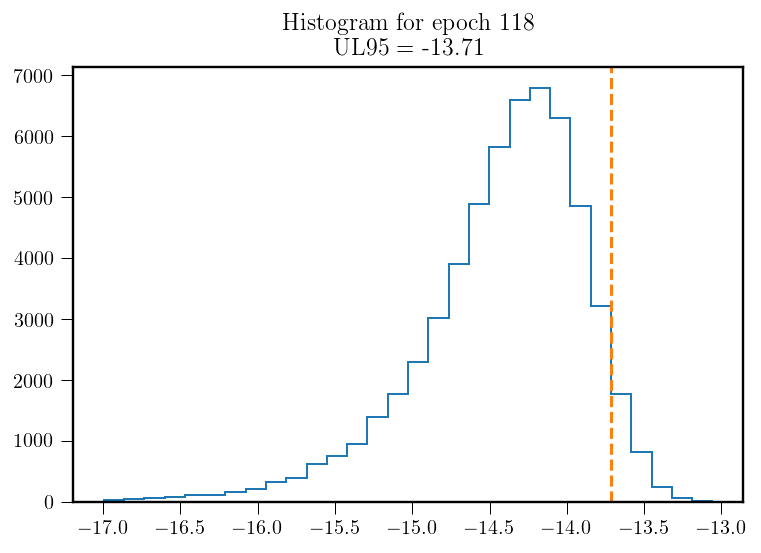

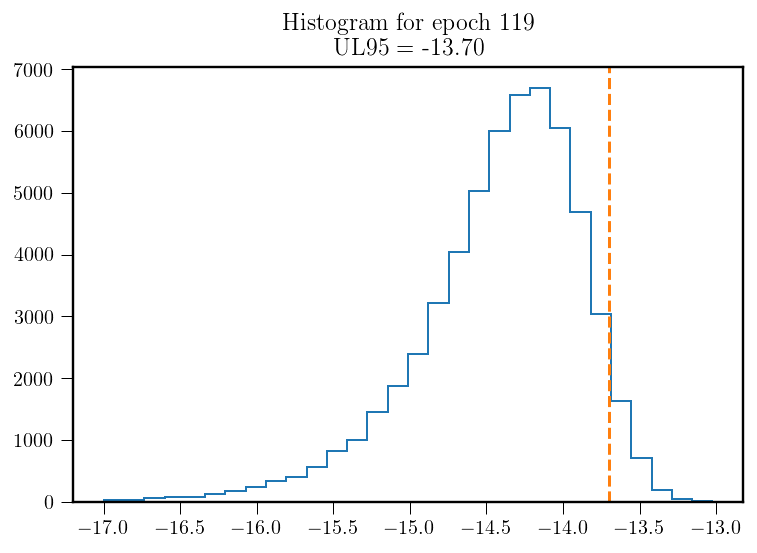

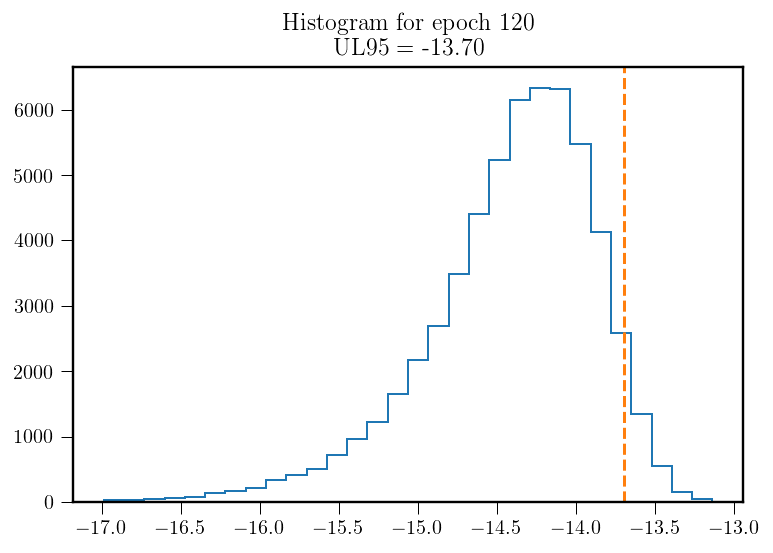

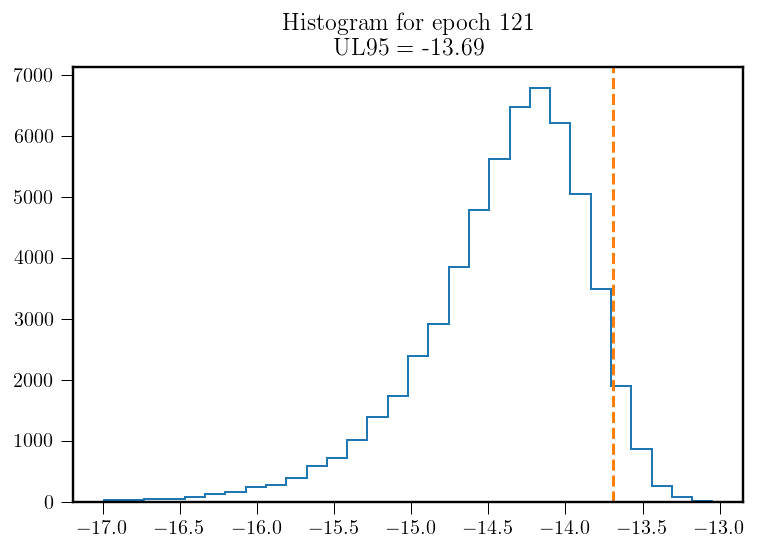

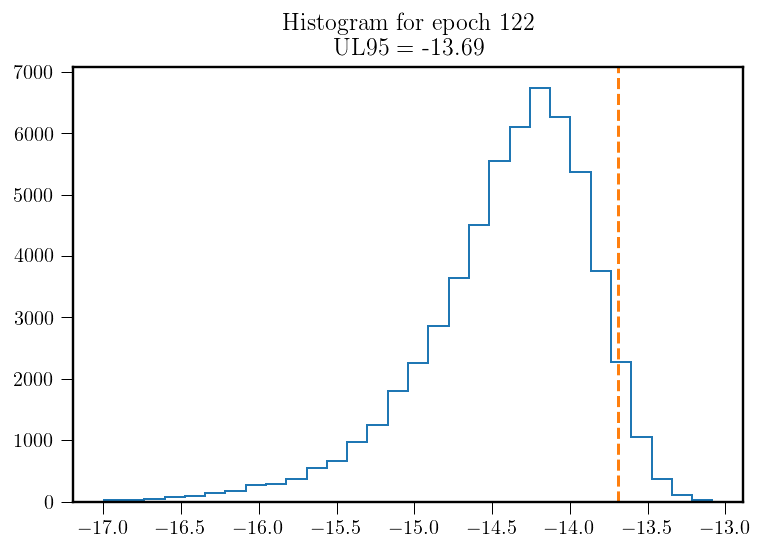

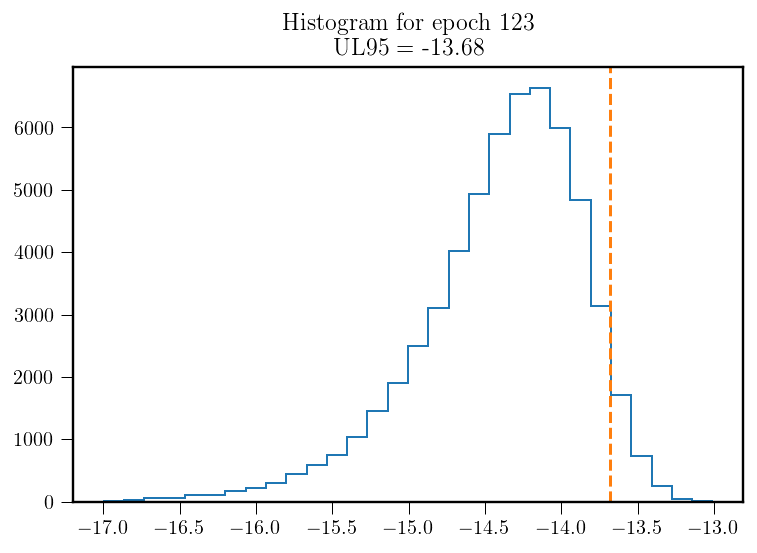

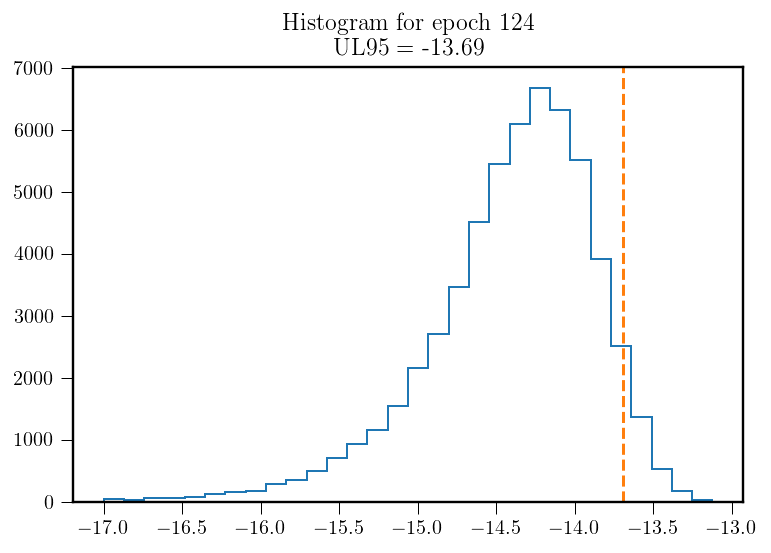

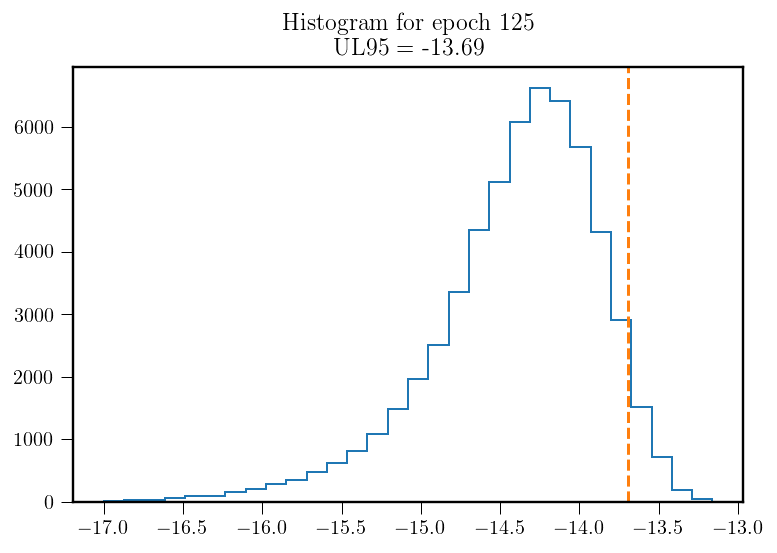

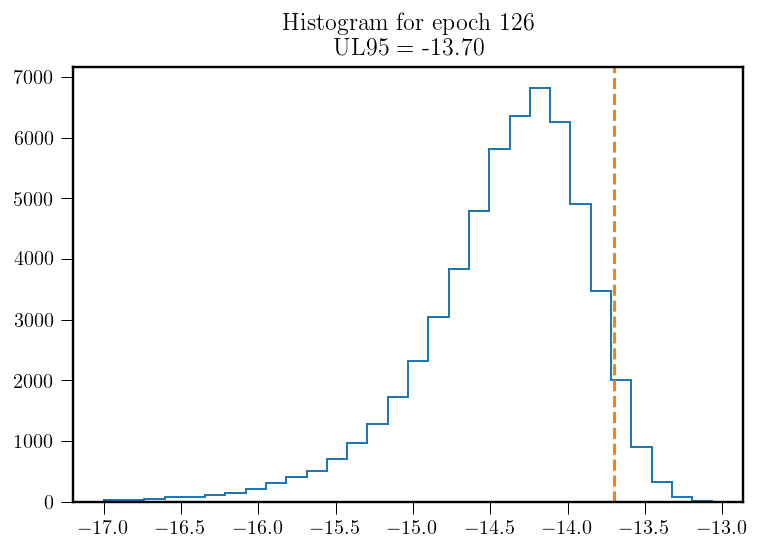

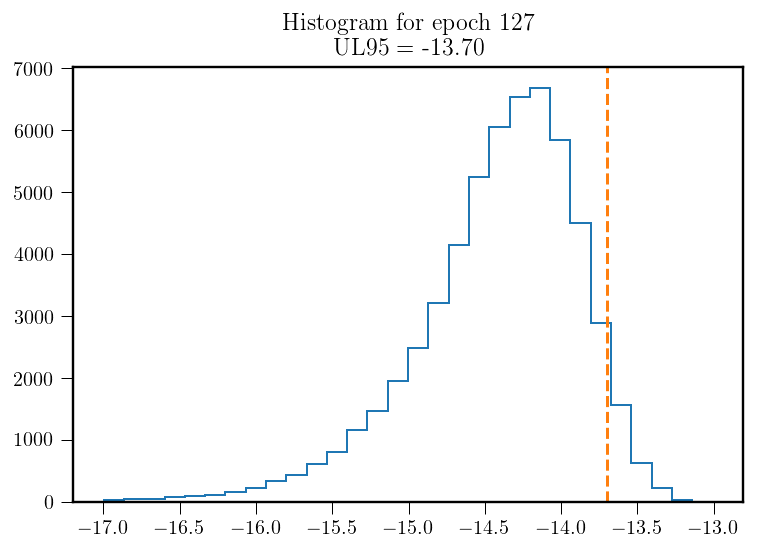

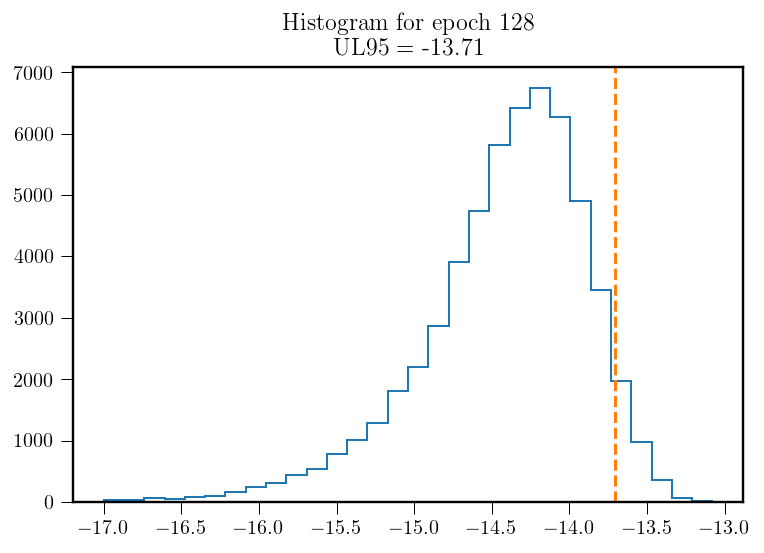

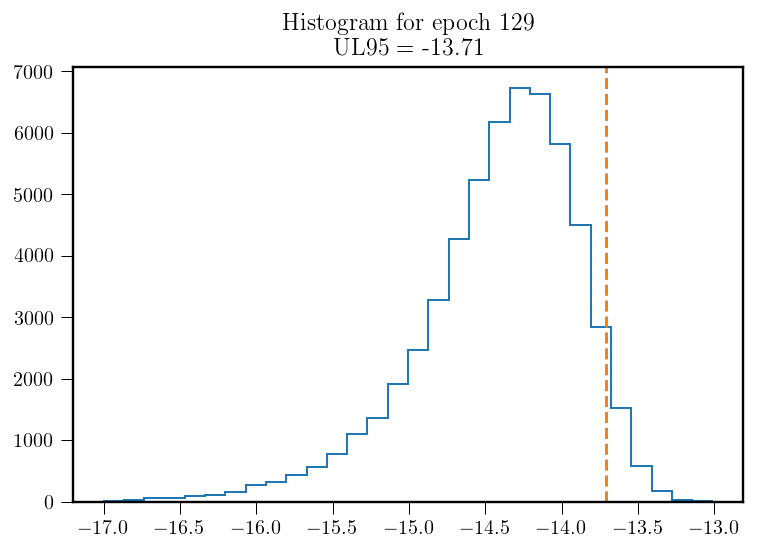

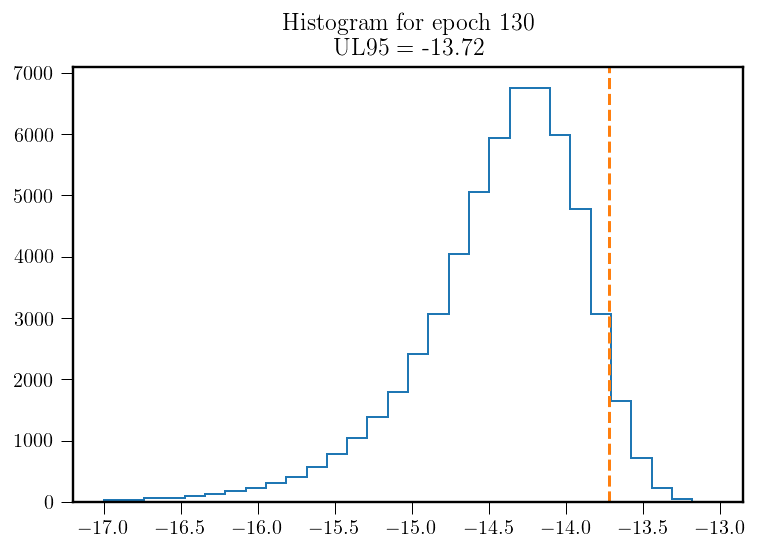

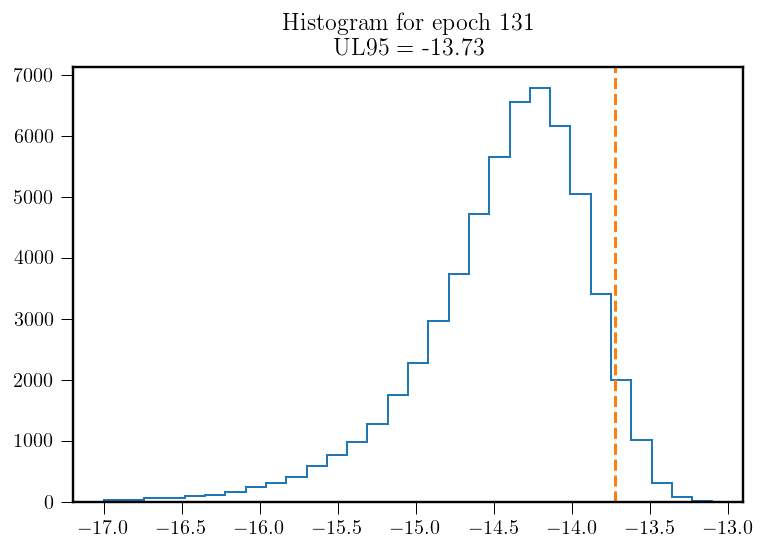

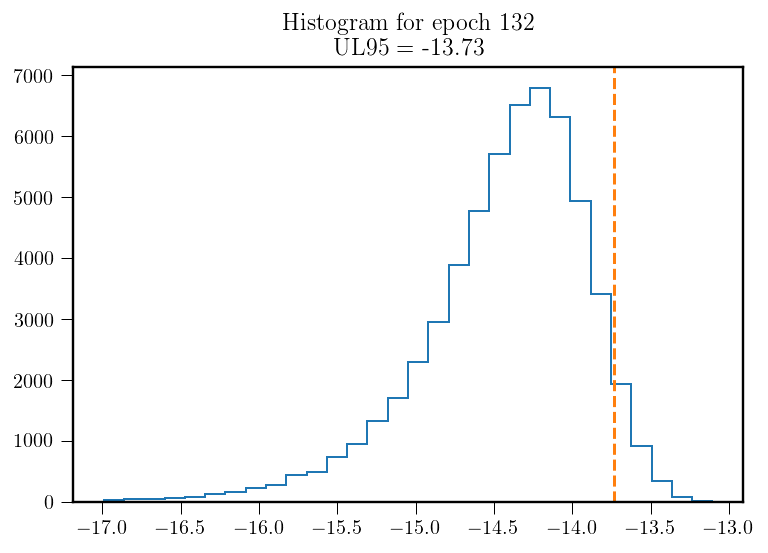

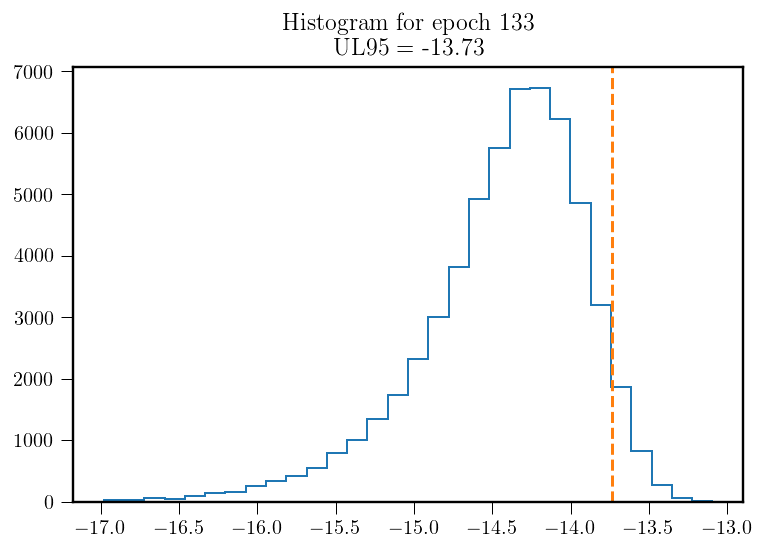

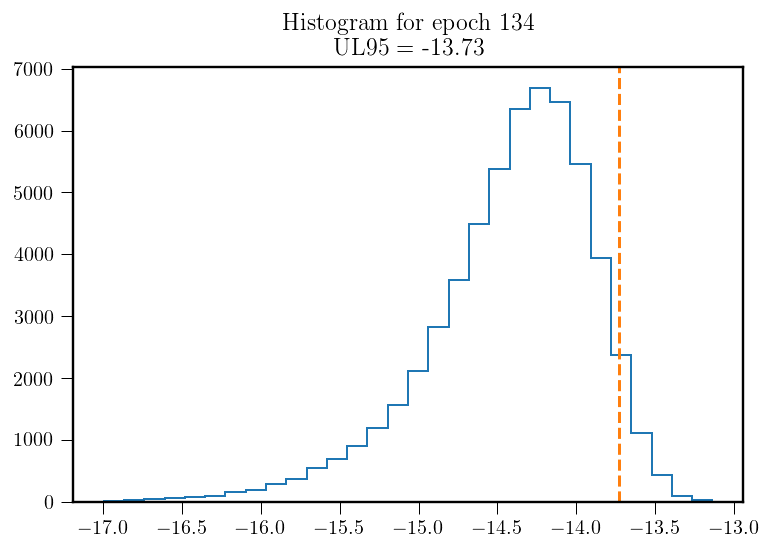

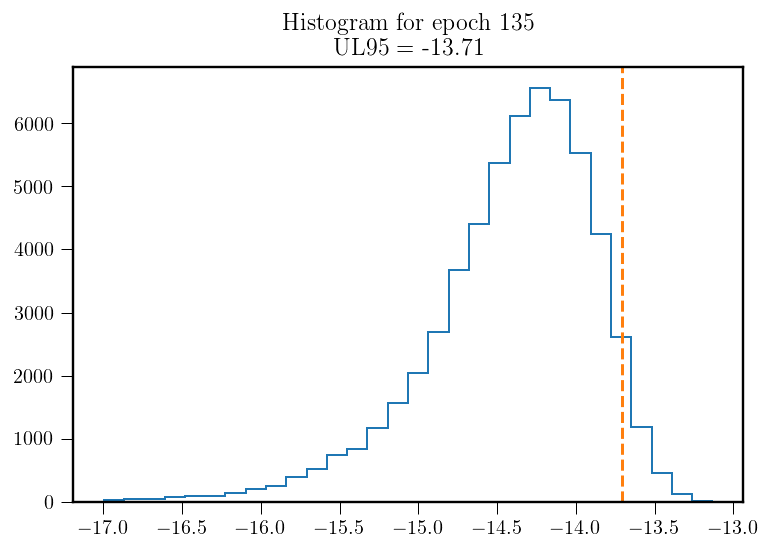

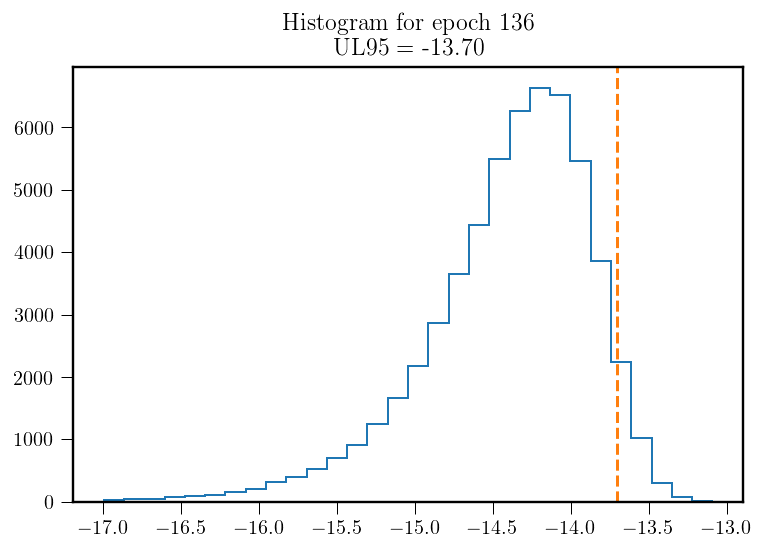

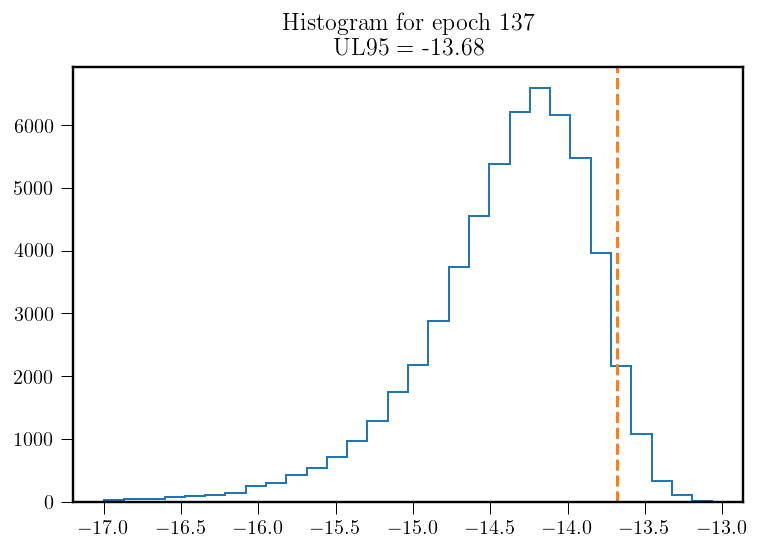

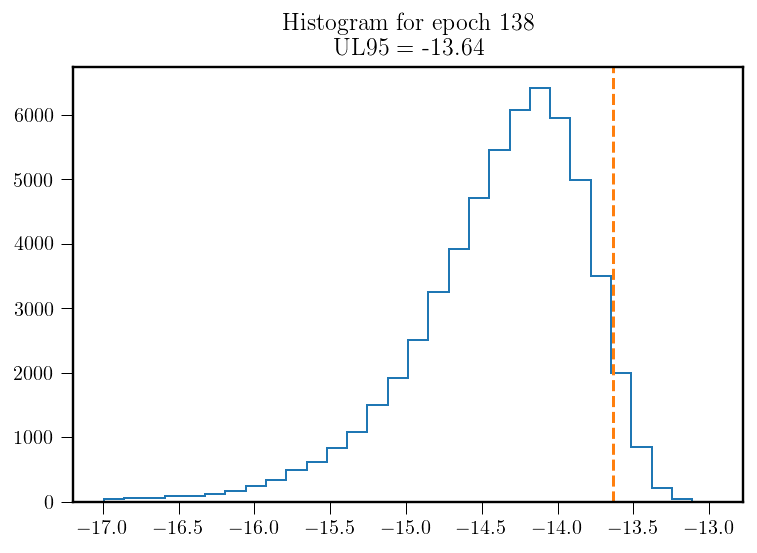

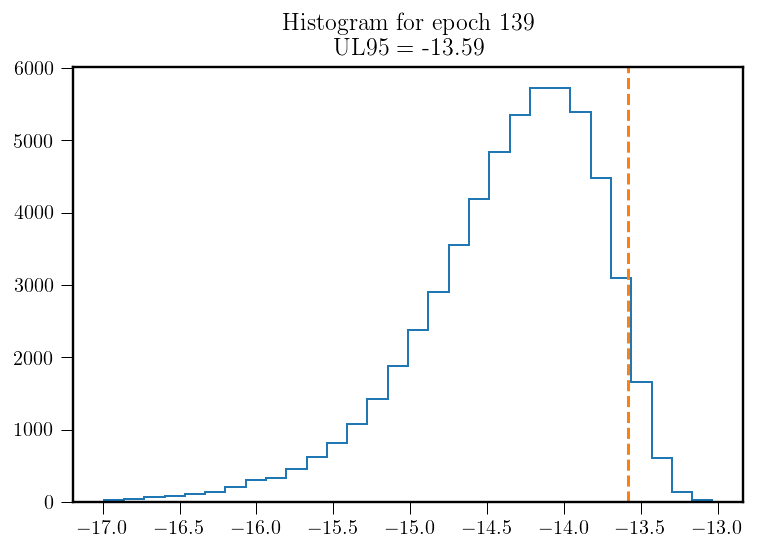

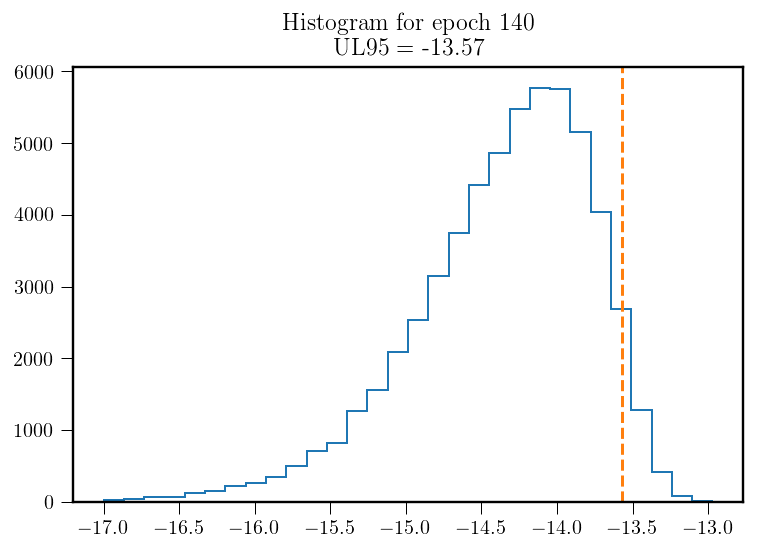

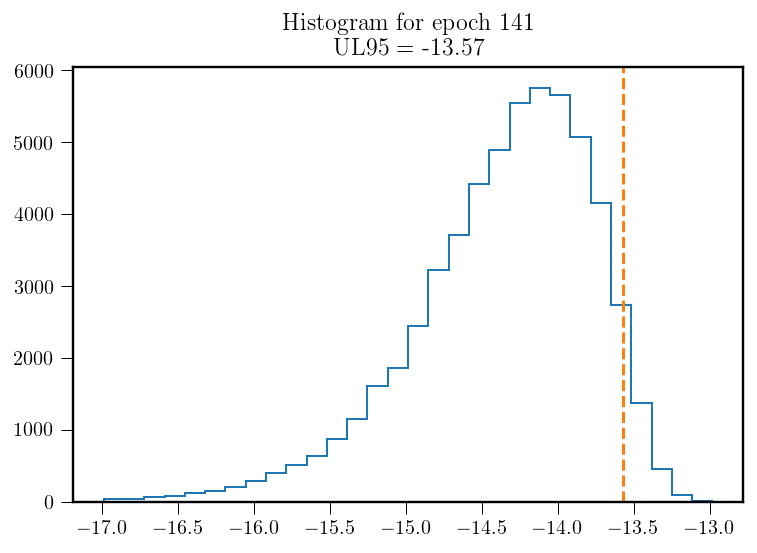

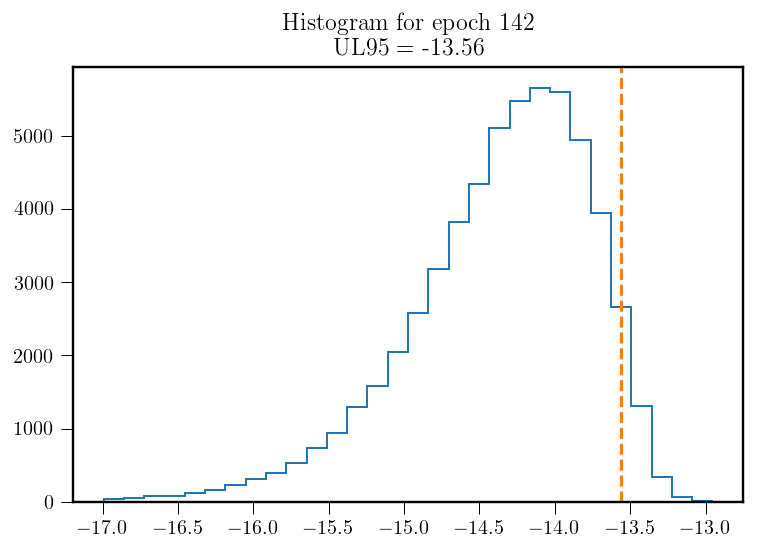

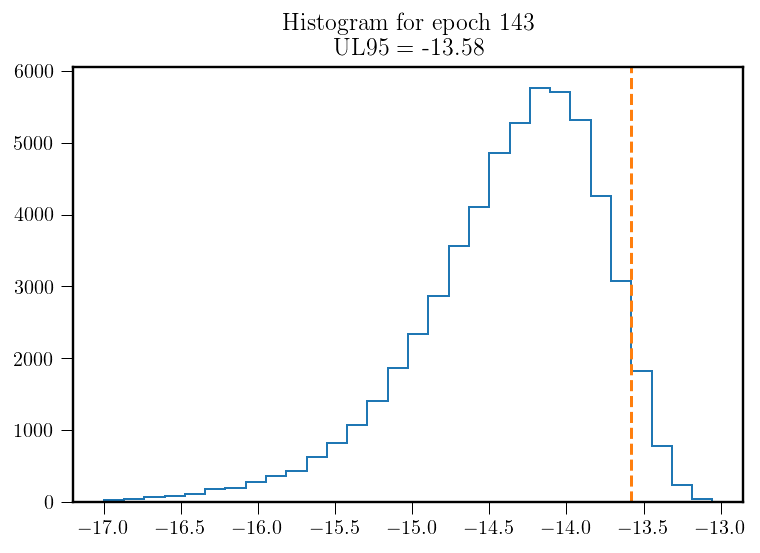

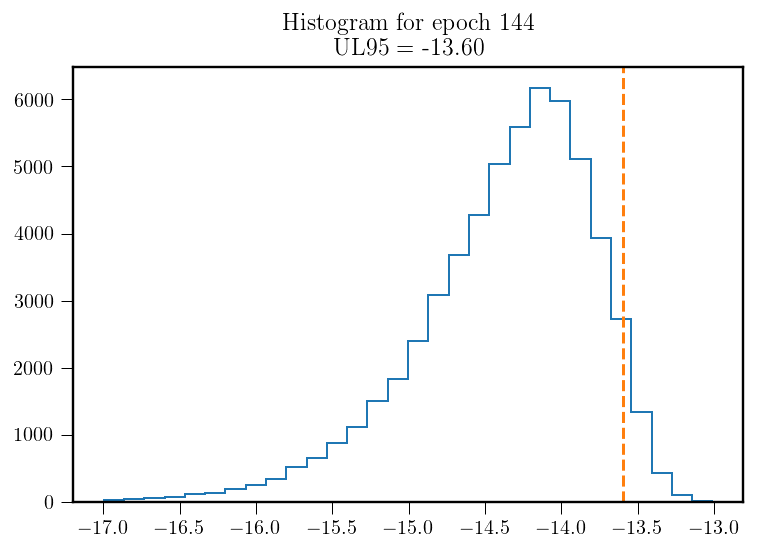

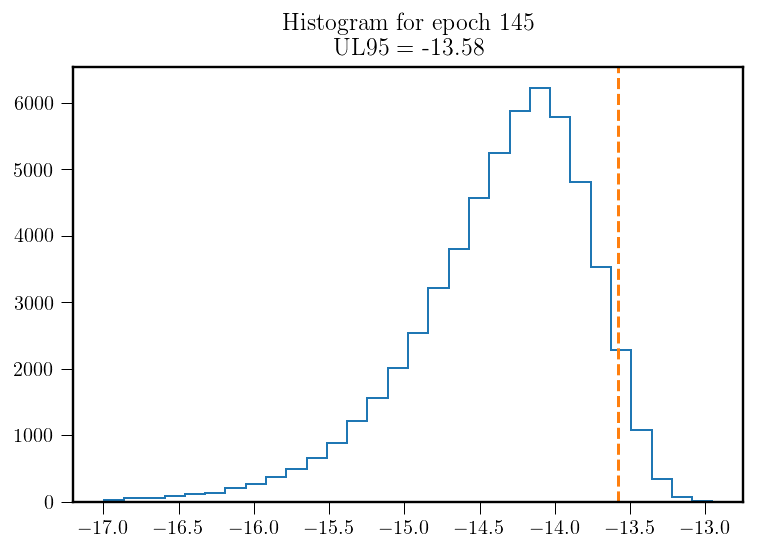

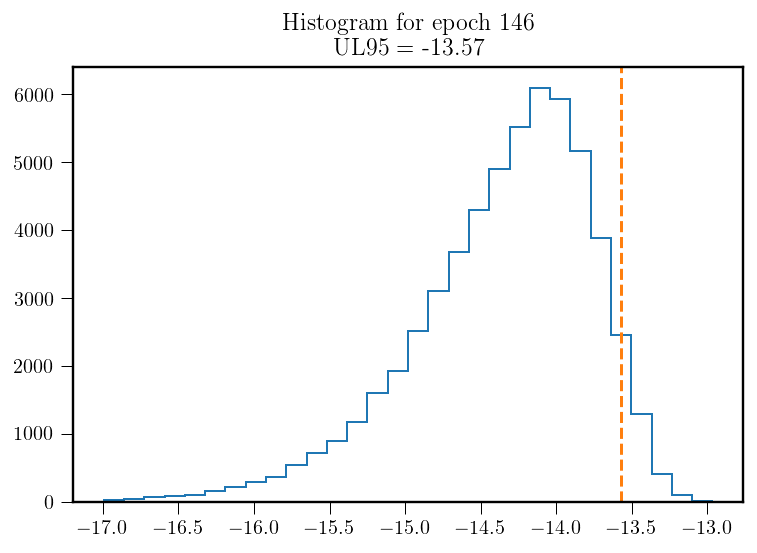

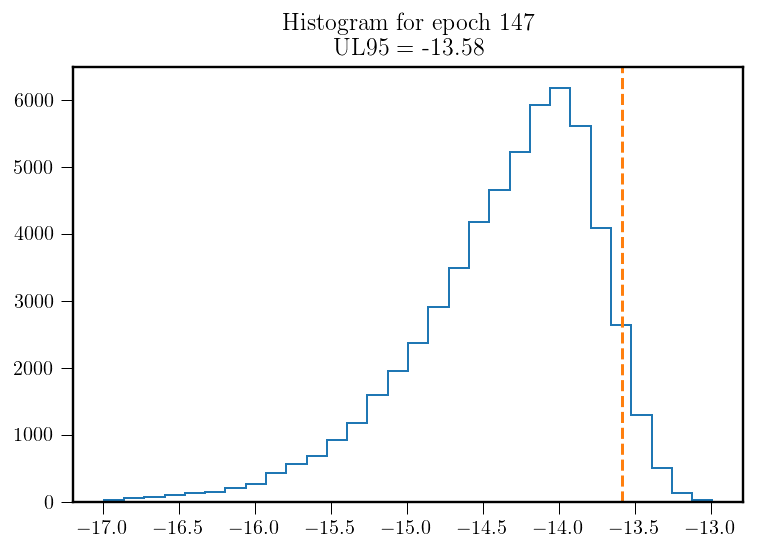

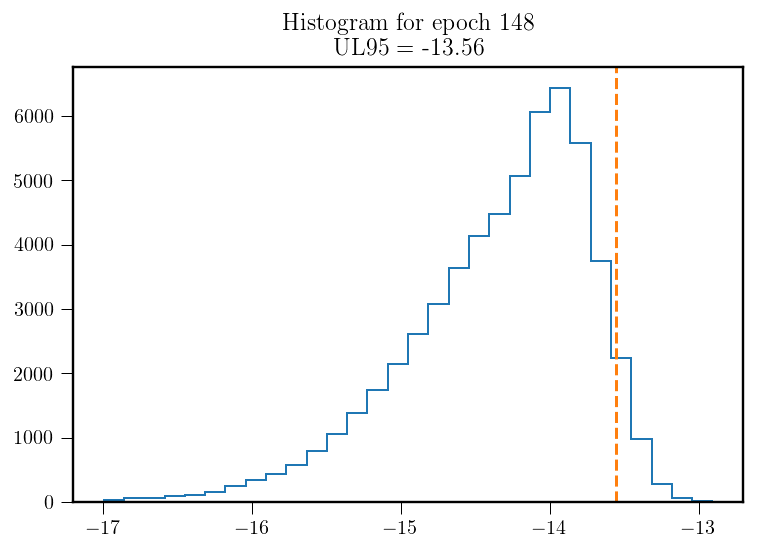

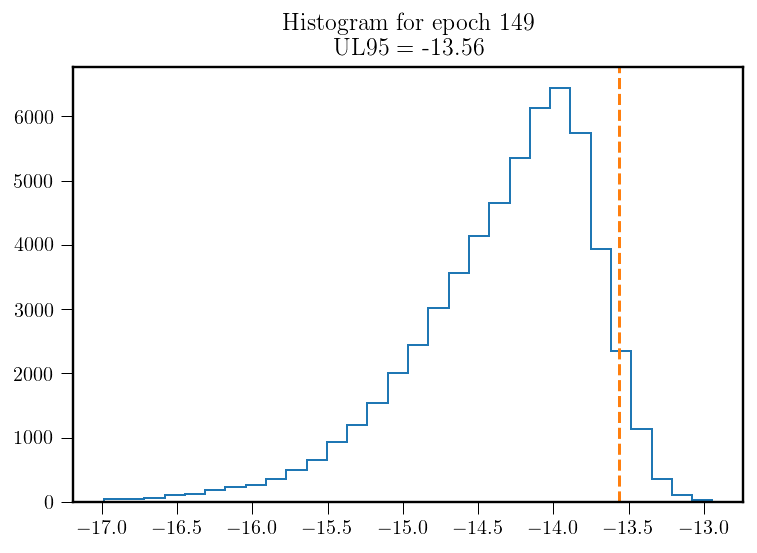

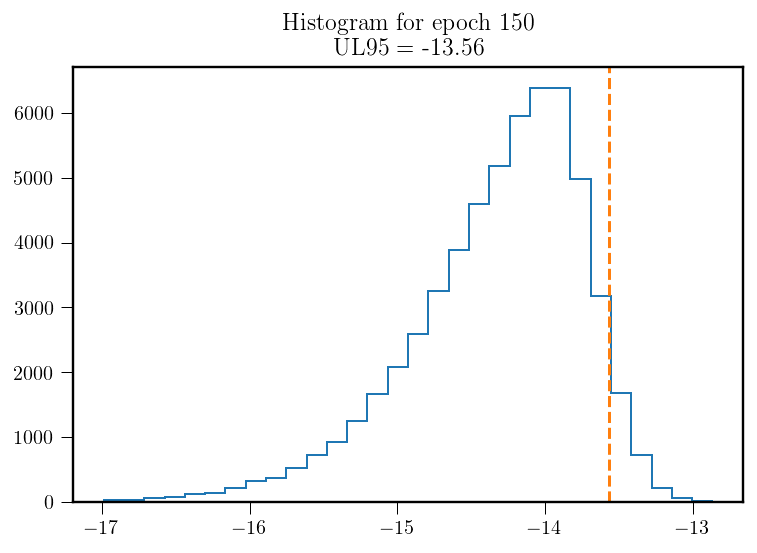

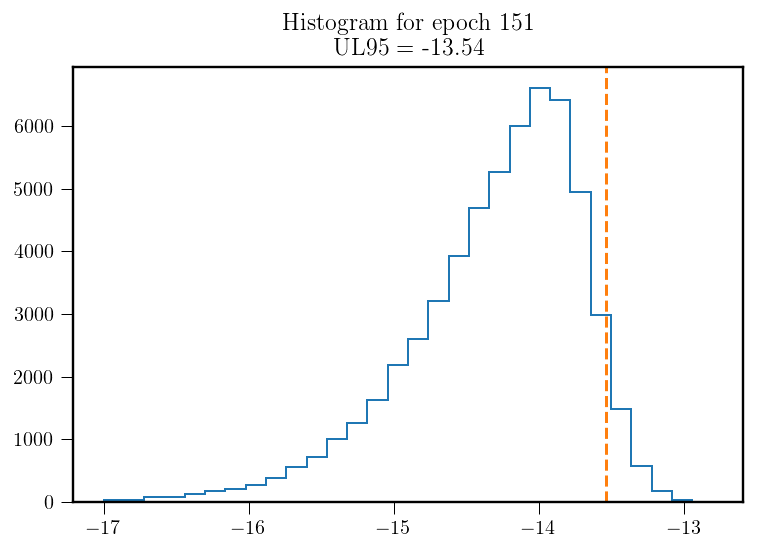

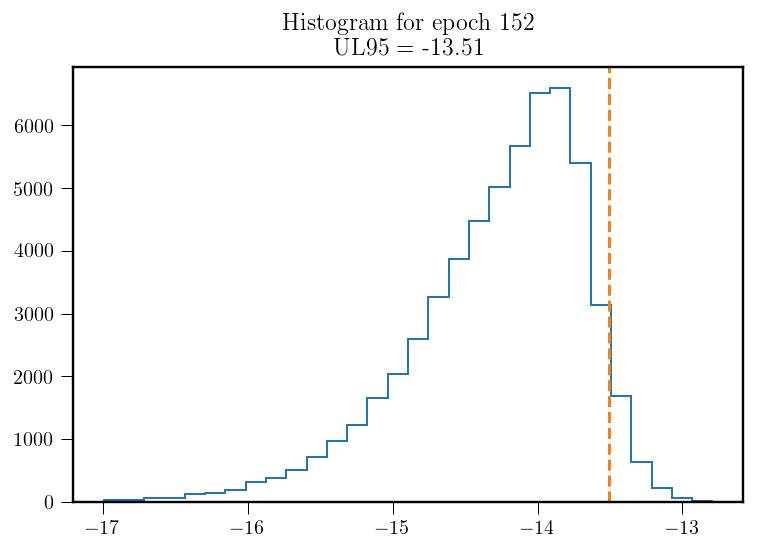

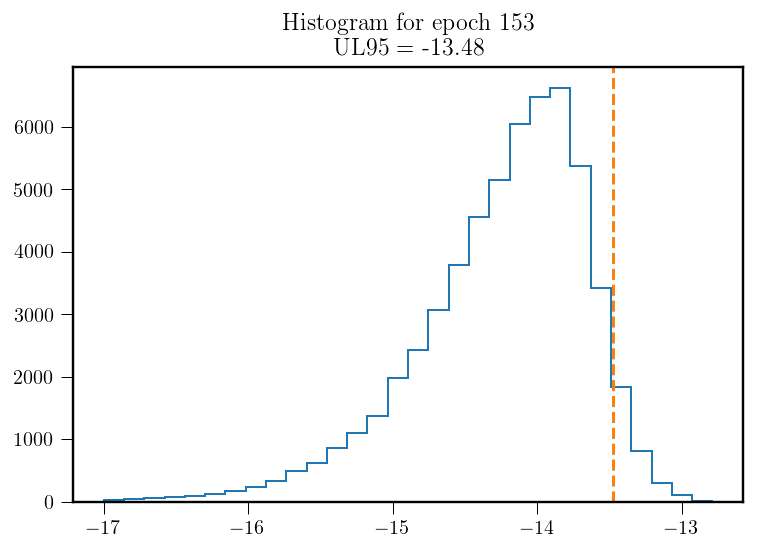

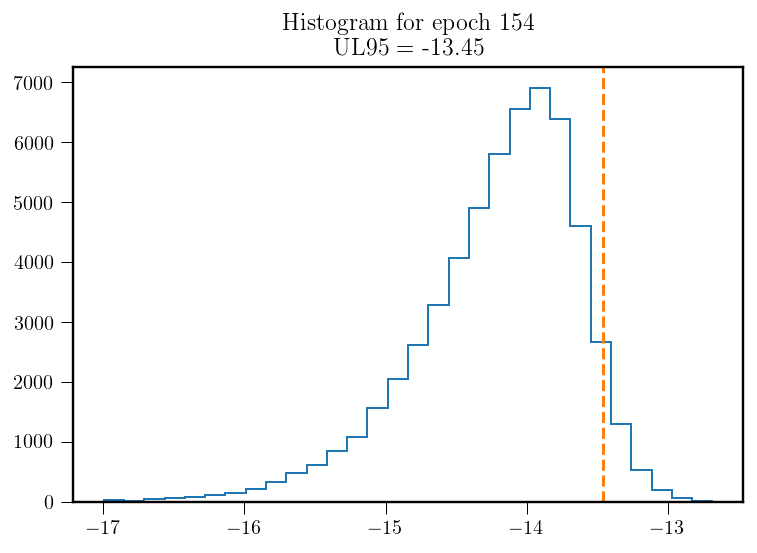

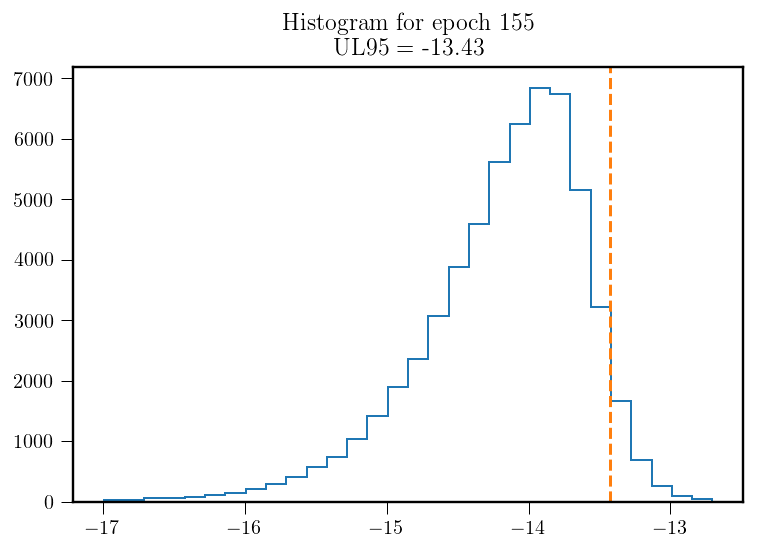

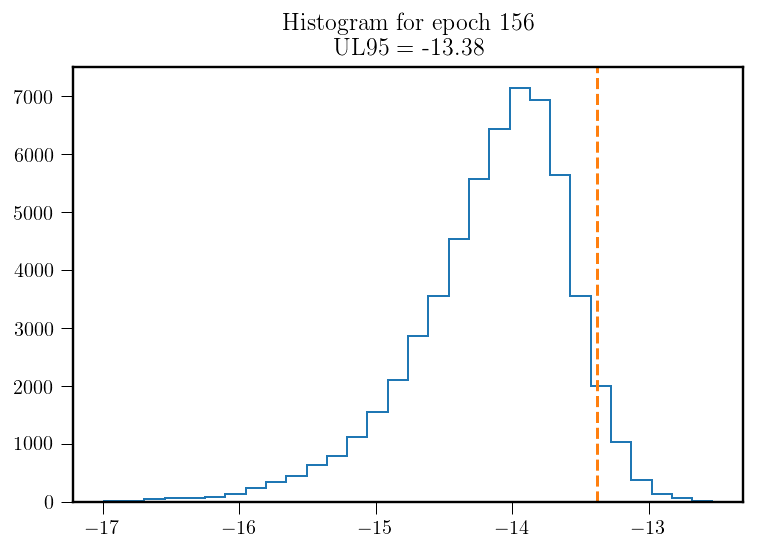

In [35]:
histdir = '/home/nima/nanograv/12p5yr_bwm/ULvT_samples_crnmarg_detpriors_mapgamma/'
ULvT = np.zeros(len(nano12_Ts))
for epoch_idx, epoch in enumerate(nano12_Ts):
    hist = sorted(np.loadtxt(histdir + "{}.txt".format(epoch_idx)))
    plt.hist(hist,histtype='step', bins=30)

    ul95_idx = int(0.95*len(hist))
    
    ULvT[epoch_idx] = hist[ul95_idx]
    plt.axvline(x=hist[ul95_idx], color='tab:orange', linestyle='--',)
    plt.title("Histogram for epoch {}\nUL95 = {:.02f}".format(epoch_idx, hist[ul95_idx]))
    plt.show()
    

    

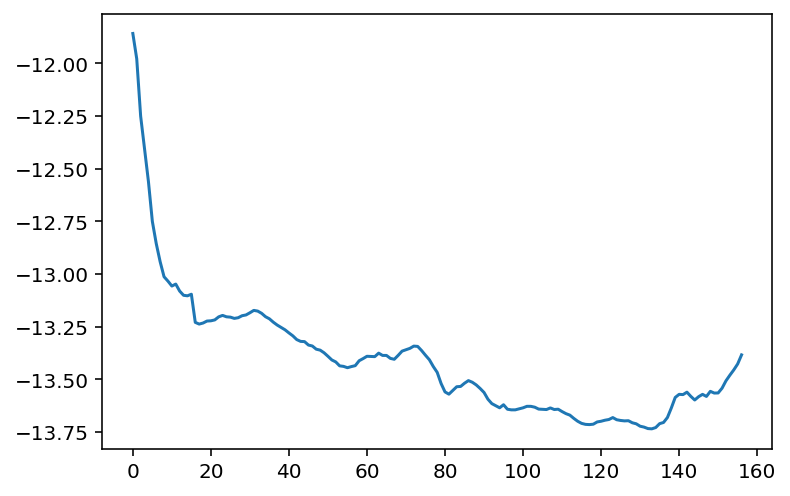

In [22]:
plt.plot(ULvT)

In [23]:
#Load pauls data and see what's up

In [56]:
# binned by source orientation reruns
with open('/home/nima/nanograv/11yr/postproc_nb/11yr_bwm_paper_data/ULs.json', 'r') as fin:
    ULmarg = json.load(fin)

key = 'DE430'
ULs_430 = [x[1] for x in ULmarg[key]]
low_430 = [x[1]-x[2] for x in ULmarg[key]]
high_430 = [x[1]+x[2] for x in ULmarg[key]]

key = 'DE436'
ULs_436 = [x[1] for x in ULmarg[key]]
low_436 = [x[1]-x[2] for x in ULmarg[key]]
high_436 = [x[1]+x[2] for x in ULmarg[key]]

key = 'DE436_BE'
ULs_BE = [x[1] for x in ULmarg[key]]
low_BE = [x[1]-x[2] for x in ULmarg[key]]
high_BE = [x[1]+x[2] for x in ULmarg[key]]

T11 = [x[0] for x in ULmarg[key]]
#T11 = Time(T11, format='mjd').decimalyear


# use BayesEphem for Rate ULs
key = 'DE436_BE'
UL_11 = np.array(ULmarg[key]).T

In [252]:
# Pulsar-term ULs

In [261]:
ng11_psr_UL_dict = {}
nano11yr_psrlist = np.loadtxt("/home/nima/nanograv/nano11_bwm/postproc_nb/11yr_bwm_paper_data/11yr_34.txt", dtype=str)
for psrname in nano11yr_psrlist:
    psr_ul_data = "/home/nima/nanograv/nano11_bwm/postproc_nb/11yr_bwm_paper_data/sngl_runs/ULvT_{}.dat".format(psrname)
    psr_uls = np.loadtxt(psr_ul_data)
    ng11_psr_UL_dict[psrname] = psr_uls
print(ng11_psr_UL_dict)

{'B1855+09': array([[5.35297500e+04, 5.36340000e+04, 5.37382500e+04, 5.38425000e+04,
        5.39467500e+04, 5.40510000e+04, 5.41552500e+04, 5.42595000e+04,
        5.43637500e+04, 5.44680000e+04, 5.45722500e+04, 5.46765000e+04,
        5.47807500e+04, 5.48850000e+04, 5.49892500e+04, 5.50935000e+04,
        5.51977500e+04, 5.53020000e+04, 5.54062500e+04, 5.55105000e+04,
        5.56147500e+04, 5.57190000e+04, 5.58232500e+04, 5.59275000e+04,
        5.60317500e+04, 5.61360000e+04, 5.62402500e+04, 5.63445000e+04,
        5.64487500e+04, 5.65530000e+04, 5.66572500e+04, 5.67615000e+04,
        5.68657500e+04, 5.69700000e+04, 5.70742500e+04, 5.71785000e+04],
       [3.91619842e-13, 1.27378272e-13, 1.05038190e-13, 1.00413995e-13,
        1.02508627e-13, 1.01328138e-13, 1.01552336e-13, 1.31062813e-13,
        1.48410302e-13, 1.41265779e-13, 1.31127812e-13, 1.29408073e-13,
        1.12708063e-13, 9.67275725e-14, 1.04949982e-13, 1.22904105e-13,
        1.49641968e-13, 1.57309783e-13, 1.52683842

In [57]:
nano11yr_factlike_histdir = '/home/nima/nanograv/11yr_factlike/ULvT_charts_ignore_epoch/epoch_samples/'
nano11_factlike_uls = np.zeros(len(nano11_Ts))
for t0_idx, t0 in enumerate(nano11_Ts):
    hist = sorted(np.loadtxt(nano11yr_factlike_histdir + '{}.txt'.format(t0_idx)))
    nano11_factlike_uls[t0_idx] = hist[int(0.95 * len(hist))]
    
nano12yr_factlike_histdir = '/home/nima/nanograv/12p5yr_bwm/ULvT_samples/'
nano12_factlike_uls = np.zeros(len(nano12_Ts))
for t0_idx, t0 in enumerate(nano12_Ts):
    hist = sorted(np.loadtxt(nano12yr_factlike_histdir + '{}.txt'.format(t0_idx)))
    nano12_factlike_uls[t0_idx] = hist[int(0.95*len(hist))]
    
nano12yr_othergamma_histdir = '/home/nima/nanograv/12p5yr_bwm/ULvT_samples_crnmarg_detpriors/'
nano12_factlike_othergamma_uls = np.zeros(len(nano12_Ts))
for t0_idx, t0 in enumerate(nano12_Ts):
    hist = sorted(np.loadtxt(nano12yr_othergamma_histdir + '{}.txt'.format(t0_idx)))
    nano12_factlike_othergamma_uls[t0_idx] = hist[int(0.95*len(hist))]


In [58]:
def figsize(scale):
    fig_width_pt = 513.17 #469.755                  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    #golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    golden_mean= 0.3333
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size
plt.rcParams.update(plt.rcParamsDefault)

params = {'backend': 'pdf',
        'axes.labelsize': 10,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'savefig.dpi':400,
        'path.simplify':True,
        'font.family': 'serif',
        #'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':True,
        'figure.figsize': figsize(0.98)}

plt.rcParams.update(params)

/home/nima/anaconda3/envs/nano15/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


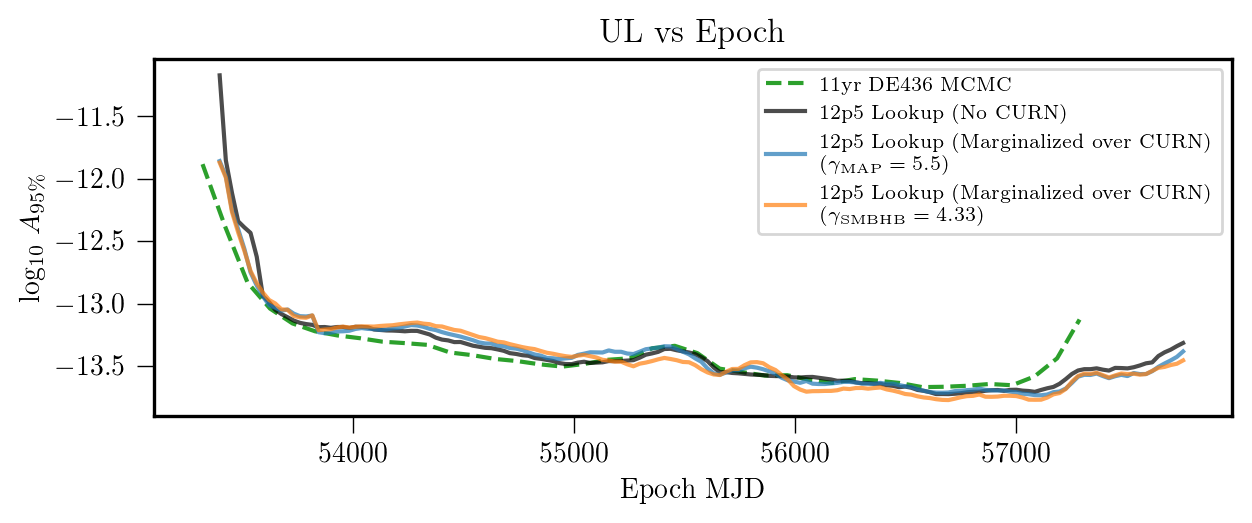

In [62]:
plt.plot(T11, np.log10(ULs_436), label='11yr DE436 MCMC',ls='--', color = 'tab:green')
#plt.plot(nano11_Ts, nano11_factlike_uls, label='11yr DE436 FactLike',ls = '--', color = 'tab:green')
#plt.plot(T11, np.log10(ULs_430), label='DE430 MCMC')
#plt.plot(T11, np.log10(ULs_BE), label='BayesEphem MCMC')
plt.plot(nano12_Ts, nano12_factlike_uls, label='12p5 Lookup (No CURN)', color = 'black', alpha=0.7)
plt.plot(nano12_Ts, ULvT, label='12p5 Lookup (Marginalized over CURN)\n$(\gamma_\mathrm{MAP}=5.5)$', color='tab:blue',alpha=0.7)
plt.plot(nano12_Ts, nano12_factlike_othergamma_uls, label='12p5 Lookup (Marginalized over CURN)\n$(\gamma_\mathrm{SMBHB}=4.33)$', color='tab:orange', alpha=0.7)
plt.legend()
plt.title("UL vs Epoch")
plt.ylabel("log$_{10}$ $A_{95\%}$")
plt.xlabel('Epoch MJD')
plt.legend(loc='upper right')
plt.savefig('/home/nima/nanograv/12p5yr_bwm/paper_plots/ULvT',format='pdf')
plt.show()


Save ULvT data

In [275]:
ULvT_factlike_NOCURN_uls = {}
ULvT_factlike_MAP_uls = {}
ULvT_factlike_SMBHB_uls = {}

for t0_idx, t0 in enumerate(nano12_Ts):
    ULvT_factlike_NOCURN_uls[t0] = nano12_factlike_uls[t0_idx]
    ULvT_factlike_MAP_uls[t0] = ULvT[t0_idx]
    ULvT_factlike_SMBHB_uls[t0] = nano12_factlike_othergamma_uls[t0_idx]

In [277]:
outdir = '/home/nima/nanograv/12p5yr_bwm/paper_data/'

with open(outdir+'ULvT_noCURN.json', 'w+') as fin:
    json.dump(ULvT_factlike_NOCURN_uls, fin, indent=4)

with open(outdir+'ULvT_MAP.json', 'w+') as fin:
    json.dump(ULvT_factlike_MAP_uls, fin, indent=4)
    
with open(outdir+'ULvT_SMBHB.json', 'w+') as fin:
    json.dump(ULvT_factlike_SMBHB_uls, fin, indent=4)

# Check ULvT in opposite parts of the sky

In [ ]:
def singlepix_epoch_sample_worker(epoch_idx, skypix, crnmarg):
    this_epoch_samples = [] #this should be a list of amplitudes
    if crnmarg:
        outf = '/home/nima/nanograv/12p5yr_bwm/scratch/ULvT_sglpx_hist/crnmarg/{}/{}.txt'.format(skypix, epoch_idx)
        chartdir = '/home/nima/nanograv/12p5yr_bwm/ULvT_charts_crnmarg/'
        os.makedirs('/home/nima/nanograv/12p5yr_bwm/scratch/ULvT_sglpx_hist/crnmarg/{}/'.format(skypix), exist_ok=True)
        amps = np.linspace(-17,-11, 45, endpoint=True)
    else:
        outf = '/home/nima/nanograv/12p5yr_bwm/scratch/ULvT_sglpx_hist/nonmarg/{}/{}.txt'.format(skypix, epoch_idx)
        chartdir = '/home/nima/nanograv/12p5yr_bwm/ULvT_charts/'
        os.makedirs('/home/nima/nanograv/12p5yr_bwm/scratch/ULvT_sglpx_hist/nonmarg/{}/'.format(skypix), exist_ok=True)
        amps = np.linspace(-17,-11, 60, endpoint=True)
        
    for pol_idx, pol in enumerate(bwm_pols):
        chart = np.loadtxt(chartdir + '{}_{}.txt'.format(skypix,pol_idx))
        epoch_max = np.amax(chart[:, epoch_idx])

        # we want to get the weights/centers for the amplitudes
        logweights = np.zeros(len(amps))
        for amp_idx in range(len(logweights)):
            like = np.exp(chart[amp_idx, epoch_idx] - epoch_max) 
            logweights[amp_idx] = np.log(like) + epoch_max
            #reweight so that we have uniform priors in the bwm_amplitude
        #plt.close("all")
        #plt.xscale('log')
        #plt.plot(amps, weights)
        #plt.show()
        # Now we need to build weights from logweights
        weights=np.zeros(len(amps))

        maxlogweight = np.amax(logweights)
        for logweight_idx, logweight in enumerate(logweights):
            weights[logweight_idx] = 10**amps[logweight_idx] * np.exp(logweight - maxlogweight)
        '''
        plt.close("all")
        plt.xscale('log')
        plt.plot(amps, weights)
        plt.show()
        '''

        #now we can resample and add the elements of the chain to this epochs samples.
        sampled = sample_hist(weights, amps, num_points=150, sample_bounds=[-17,-11])


        #now we just want to dump this into this_epoch_samples
        for el in sampled:
            this_epoch_samples.append(el)  
    
    #Now we've resampled this entire time bin for every source location
    #let's just plot some for now
    plt.close("all")
    plt.hist(this_epoch_samples,histtype='step',bins=30 )
    plt.title("Histogram for epoch {}".format(epoch_idx))
    plt.show()
    
    np.savetxt(outf, this_epoch_samples)

# We can turn the ULvT data into ULs on rates

In [37]:
nano11yr_factlike_histdir = '/home/nima/nanograv/11yr_factlike/ULvT_charts_ignore_epoch/epoch_samples/'
nano11_factlike_uls = np.zeros(len(nano11_Ts))
for t0_idx, t0 in enumerate(nano11_Ts):
    hist = sorted(np.loadtxt(nano11yr_factlike_histdir + '{}.txt'.format(t0_idx)))
    nano11_factlike_uls[t0_idx] = hist[int(0.95 * len(hist))]
    
nano12yr_mapgamma_histdir = '/home/nima/nanograv/12p5yr_bwm/ULvT_samples_crnmarg_detpriors_mapgamma/'
nano12_factlike_mapgamma_uls = np.zeros(len(nano12_Ts))
for t0_idx, t0 in enumerate(nano12_Ts):
    hist = sorted(np.loadtxt(nano12yr_mapgamma_histdir + '{}.txt'.format(t0_idx)))
    nano12_factlike_mapgamma_uls[t0_idx] = hist[int(0.95*len(hist))]


nano12yr_othergamma_histdir = '/home/nima/nanograv/12p5yr_bwm/ULvT_samples_crnmarg_detpriors/'
nano12_factlike_othergamma_uls = np.zeros(len(nano12_Ts))
for t0_idx, t0 in enumerate(nano12_Ts):
    hist = sorted(np.loadtxt(nano12yr_othergamma_histdir + '{}.txt'.format(t0_idx)))
    nano12_factlike_othergamma_uls[t0_idx] = hist[int(0.95*len(hist))]


In [40]:
ULvT_crnmarg_samples = '/home/nima/nanograv/12p5yr_bwm/ULvT_samples_crnmarg_detpriors_mapgamma/'
n12p5_crnmarg_mapgamma_UL95s = {}
for i in range(156):
    samples = sorted(np.loadtxt(ULvT_crnmarg_samples + '{}.txt'.format(i)))
    n12p5_crnmarg_mapgamma_UL95s[i] = samples[int(0.95*len(samples))]
    
ULvT_crnmarg_samples = '/home/nima/nanograv/12p5yr_bwm/ULvT_samples_crnmarg_detpriors/'
n12p5_crnmarg_smbhb_gamma_UL95s = {}
for i in range(156):
    samples = sorted(np.loadtxt(ULvT_crnmarg_samples + '{}.txt'.format(i)))
    n12p5_crnmarg_smbhb_gamma_UL95s[i] = samples[int(0.95*len(samples))]    


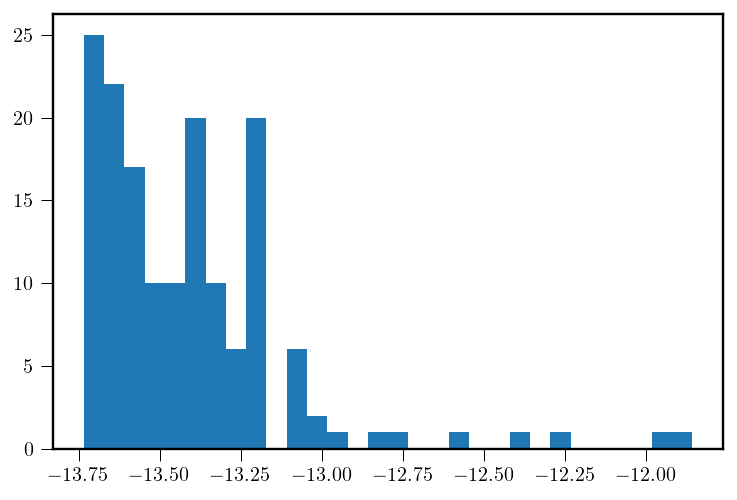

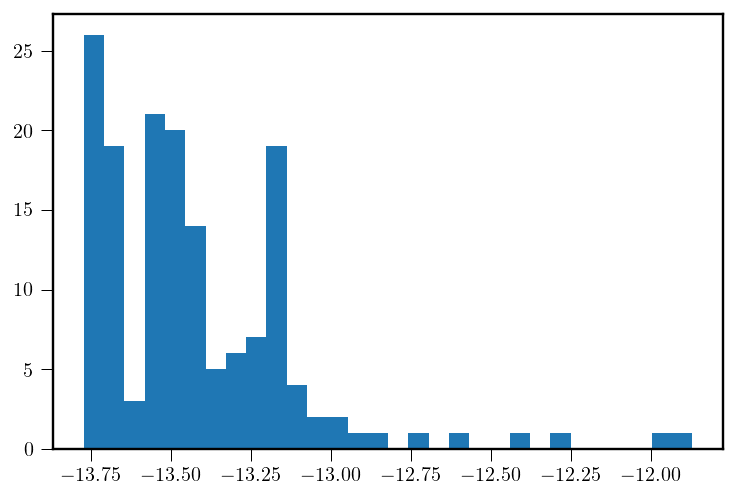

In [42]:
UL95_list = [n12p5_crnmarg_UL95s[i] for i in range(156)]
pdf, centers, patches = plt.hist(UL95_list, bins=30)
plt.show()

smbhb_UL95_list = [n12p5_crnmarg_smbhb_gamma_UL95s[i] for i in range(156)]
astro_pdf, astro_centers, astro_patches = plt.hist(smbhb_UL95_list, bins=30)
plt.show()

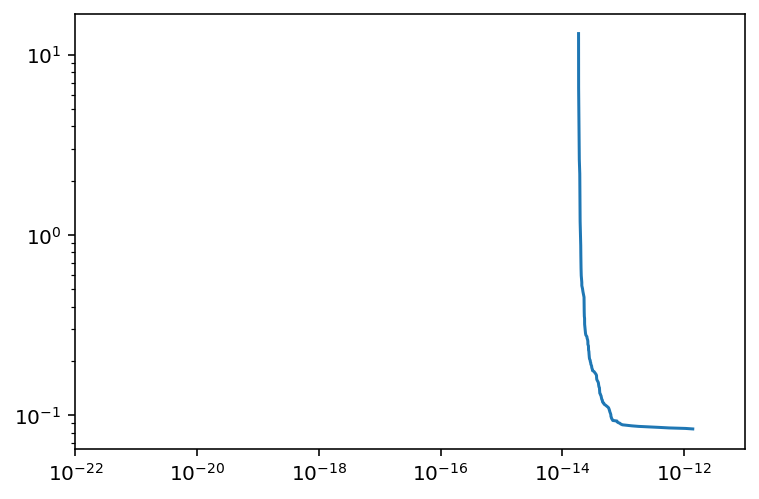

In [10]:
dT_12 = np.mean(np.diff(nano12_Ts))/365.25
hsort_12 = np.sort(UL95_list)
Ns_12 = np.arange(len(hsort_12)) + 1

fig, ax1 = plt.subplots(1,1)
ax1.plot(10**hsort_12, 1/(Ns_12 * dT_12))
ax1.set_xlim([1e-22, 1e-11])
ax1.set_xscale("log")
ax1.set_yscale("log")

plt.show()

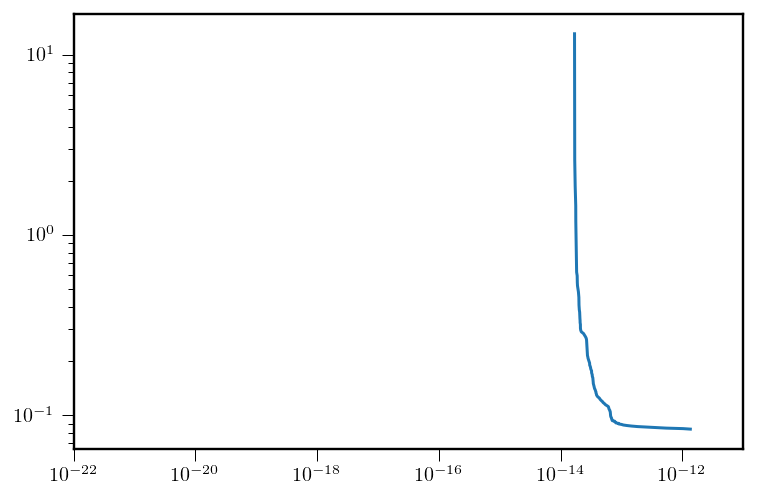

In [43]:
astro_dT_12 = np.mean(np.diff(nano12_Ts))/365.25
astro_hsort_12 = np.sort(smbhb_UL95_list)
astro_Ns_12 = np.arange(len(astro_hsort_12)) + 1

fig, ax1 = plt.subplots(1,1)
ax1.plot(10**astro_hsort_12, 1/(astro_Ns_12 * astro_dT_12))
ax1.set_xlim([1e-22, 1e-11])
ax1.set_xscale("log")
ax1.set_yscale("log")

plt.show()

# Let's put Paul's data on top of this, as well as published ULs

In [44]:
# binned by source orientation reruns
with open('/home/nima/nanograv/11yr/postproc_nb/11yr_bwm_paper_data/ULs.json', 'r') as fin:
    ULmarg = json.load(fin)

key = 'DE430'
ULs_430 = [x[1] for x in ULmarg[key]]
low_430 = [x[1]-x[2] for x in ULmarg[key]]
high_430 = [x[1]+x[2] for x in ULmarg[key]]

key = 'DE436'
ULs_436 = [x[1] for x in ULmarg[key]]
low_436 = [x[1]-x[2] for x in ULmarg[key]]
high_436 = [x[1]+x[2] for x in ULmarg[key]]

key = 'DE436_BE'
ULs_BE = [x[1] for x in ULmarg[key]]
low_BE = [x[1]-x[2] for x in ULmarg[key]]
high_BE = [x[1]+x[2] for x in ULmarg[key]]

T11 = [x[0] for x in ULmarg[key]]
T11 = Time(T11, format='mjd').decimalyear


# use BayesEphem for Rate ULs
key = 'DE436_BE'
UL_11 = np.array(ULmarg[key]).T

In [268]:
# 9yr 
# dT_9 = np.mean(np.diff(T9))
# hsort_9 = np.sort(UL_9yr[0])
# Ns_9 = np.arange(len(hsort_9))+1

# 11yr
dT_11 = np.mean(np.diff(UL_11[0]))/365.25
hsort_11 = np.sort(UL_11[1])
Ns_11 = np.arange(len(hsort_11))+1

# 11yr PSR-term
# sngl_ULs = UL_11yr[0]  # uncomment for joint earth-term + psr-term
rescale = np.pi

sngl_ULs = []  # psr term only
for _,uls,_ in ng11_psr_UL_dict.values():
    sngl_ULs = np.hstack([sngl_ULs, uls])

    
J1713_opt = np.loadtxt("/home/nima/nanograv/nano11_bwm/postproc_nb/11yr_bwm_paper_data/sngl_runs/ULvT_J1713+0747.dat")
    
dT_psr = np.mean(np.diff(J1713_opt[0]))/365.25
hsort_psr = np.sort(sngl_ULs) * rescale
Ns_psr = np.arange(len(hsort_psr)) + 1

## Now let's do the pulsar-term ULs

In [279]:
sngl_runs = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_crn_marg_det_RN_mapgamma/'

psrlist = [p.name for p in allpsrs]

UL_dict = {}
for psr in psrlist:
    try:
        parfile = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_crn_marg_det_RN_mapgamma/{}/pars.txt'.format(psr)
        pardict = {}
        with open(parfile, 'r') as f:
            parlines=f.readlines()
            for parline in parlines:
                key, np_pars = parline.split(';')
                #print(np_pars)

                start,stop,num = np_pars.split(',')
                #print(start, stop, num)
                pardict[key] = np.linspace(float(start), float(stop), int(num), endpoint=True)
            
#         print(pardict)
        ULfile = os.path.join(sngl_runs, psr, "resampled_epochs", "sign_marged_epoch_UL95s.txt".format(psr))
        UL_dict[psr] = [pardict['ramp_t0']/365.25, np.loadtxt(ULfile)]
    except Exception as e:
        print("did not work for PSR{}".format(psr))
        print(str(e))

In [281]:
psrterm_ULvT_dict_MAP = UL_dict
print(psrterm_ULvT_dict_MAP)

{'B1855+09': [array([146.33397232, 146.41690747, 146.49984261, 146.58277775,
       146.6657129 , 146.74864804, 146.83158318, 146.91451833,
       146.99745347, 147.08038861, 147.16332376, 147.2462589 ,
       147.32919404, 147.41212919, 147.49506433, 147.57799947,
       147.66093462, 147.74386976, 147.8268049 , 147.90974005,
       147.99267519, 148.07561033, 148.15854547, 148.24148062,
       148.32441576, 148.4073509 , 148.49028605, 148.57322119,
       148.65615633, 148.73909148, 148.82202662, 148.90496176,
       148.98789691, 149.07083205, 149.15376719, 149.23670234,
       149.31963748, 149.40257262, 149.48550777, 149.56844291,
       149.65137805, 149.7343132 , 149.81724834, 149.90018348,
       149.98311863, 150.06605377, 150.14898891, 150.23192406,
       150.3148592 , 150.39779434, 150.48072949, 150.56366463,
       150.64659977, 150.72953492, 150.81247006, 150.8954052 ,
       150.97834035, 151.06127549, 151.14421063, 151.22714577,
       151.31008092, 151.39301606, 151.47

In [186]:
mapgamma_dTs_psr = {}
for psr in allpsrs:
    mapgamma_dTs_psr[psr.name] = []
    parfile = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_crn_marg_det_RN_mapgamma/{}/pars.txt'.format(psr.name)
    pardict = {}
    with open(parfile, 'r') as f:
        parlines=f.readlines()
        for parline in parlines:
            key, np_pars = parline.split(';')
            #print(np_pars)

            start,stop,num = np_pars.split(',')
            #print(start, stop, num)
            pardict[key] = np.linspace(float(start), float(stop), int(num), endpoint=True)
    mapgamma_dTs_psr[psr.name].append(np.mean(np.diff(pardict['ramp_t0']))/365.25)

In [187]:
print(mapgamma_dTs_psr)
# mapgamma_mean_dT = np.mean(mapgamma_dTs_psr)

{'B1855+09': [0.08293514324248003], 'B1937+21': [0.08286028667879487], 'B1953+29': [0.08399190736535775], 'J0023+0923': [0.08382148244117803], 'J0030+0451': [0.0828724364336957], 'J0340+4130': [0.08459278430552397], 'J0613-0200': [0.0832058847305253], 'J0636+5128': [0.08466183106446608], 'J0645+5158': [0.0842834551586982], 'J0740+6620': [0.08559017239087952], 'J0931-1902': [0.0845178254136163], 'J1012+5307': [0.083216667027617], 'J1024-0719': [0.08332187293550193], 'J1125+7819': [0.0852289033034477], 'J1453+1902': [0.0876818847489617], 'J1455-3330': [0.0831860825448867], 'J1600-3053': [0.08306311330985755], 'J1614-2230': [0.0832299176197131], 'J1640+2224': [0.08312812105960773], 'J1643-1224': [0.08324872723156261], 'J1713+0747': [0.08274146173038212], 'J1738+0333': [0.08374460130481977], 'J1741+1351': [0.08412924154957896], 'J1744-1134': [0.08275163996262937], 'J1747-4036': [0.08458884885427857], 'J1832-0836': [0.08434307636406646], 'J1853+1303': [0.08380493692230552], 'J1903+0327': [0

In [201]:
combined_mapgamma_h = []
combined_mapgamma_dT = []
for psr in allpsrs:
    this_psr_ULs = UL_dict[psr.name][1]
    this_psr_dTs = mapgamma_dTs_psr[psr.name][0]
#     print(this_psr_ULs)
    for el in this_psr_ULs:
        combined_mapgamma_h.append(el)
        combined_mapgamma_dT.append(this_psr_dTs)
    

In [202]:
print(combined_mapgamma_h)
print(combined_mapgamma_dT)

[-12.43042480725361, -12.5650009959236, -12.693246933882769, -12.7944994079737, -12.843646172182627, -12.892080712691499, -12.91857422714519, -12.943043350426963, -12.99153094760797, -13.005217090158641, -12.998607120081687, -12.96867252355166, -12.984697920183395, -12.977880650256052, -12.961934643657088, -12.922026200995262, -12.87892072844475, -12.860130307656757, -12.861025085506707, -12.895606649304456, -12.91857039863621, -12.951340955921244, -12.977487887810188, -13.004293442681092, -12.992594678136005, -12.946233449628233, -12.893652044793818, -12.84851107903721, -12.795679316033926, -12.754471331541987, -12.732624949502492, -12.719197186109907, -12.750160733546966, -12.778128602824072, -12.808829779455738, -12.829912666391108, -12.841706172393053, -12.857339995267425, -12.827019930250756, -12.797721837362676, -12.782160096067368, -12.777301591260255, -12.790386502885948, -12.824177236175604, -12.8976953807624, -12.944159091476928, -12.960796160951924, -12.97811697180786, -12.9

In [203]:
isort = np.argsort(combined_mapgamma_h)

sorted_combined_mapgamma_hs = []
sorted_combined_mapgamma_dTs = []

for idx in isort:
    sorted_combined_mapgamma_hs.append(combined_mapgamma_h[idx])
    sorted_combined_mapgamma_dTs.append(combined_mapgamma_dT[idx])

In [207]:
# now rather than multiplying by Ns, I need a matrix that's the cumulative sum 
sorted_combined_mapgamma_dT_cumsum = np.zeros(len(combined_mapgamma_dT))
total = 0
for dT_idx, dT in enumerate(sorted_combined_mapgamma_dTs):
    total += dT
    sorted_combined_mapgamma_dT_cumsum[dT_idx] = total

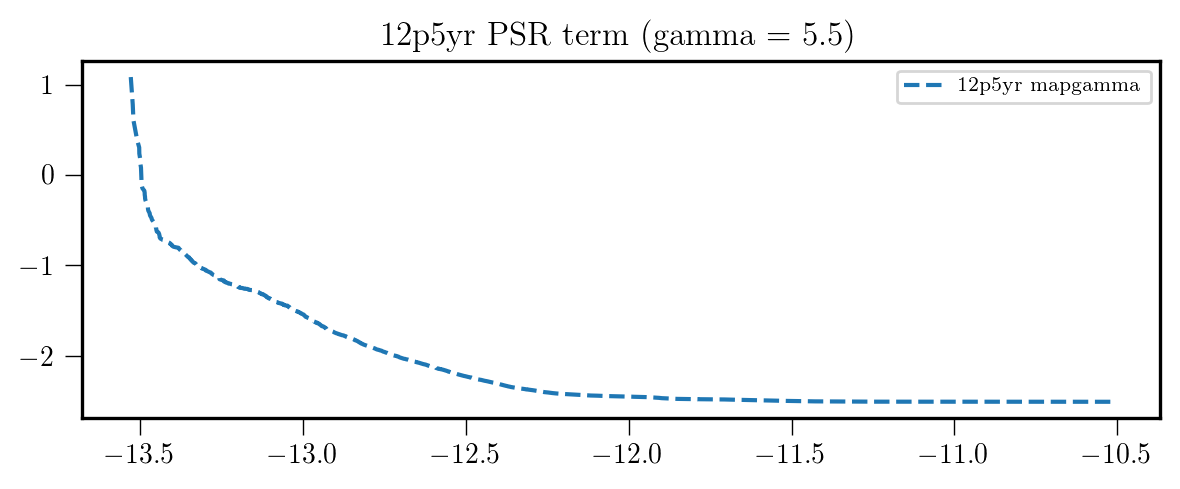

In [209]:
mapgamma_hsort_rescaled = 10**np.array(sorted_combined_mapgamma_hs) * np.pi
fig, ax = plt.subplots()
ax.plot(np.log10(mapgamma_hsort_rescaled), np.log10(1/(sorted_combined_mapgamma_dT_cumsum)), color = 'tab:blue', ls = '--', label='12p5yr mapgamma')
plt.title('12p5yr PSR term (gamma = 5.5)')
plt.legend()

In [240]:
print(min(mapgamma_hsort_rescaled))

2.9528236805363443e-14


Repeat for SMBHB gamma

In [224]:
sngl_runs = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_det_RN/'

psrlist = [p.name for p in allpsrs]

UL_dict = {}
for psr in psrlist:
    try:
        parfile = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_crn_marg_det_RN_mapgamma/{}/pars.txt'.format(psr)
        pardict = {}
        with open(parfile, 'r') as f:
            parlines=f.readlines()
            for parline in parlines:
                key, np_pars = parline.split(';')
                #print(np_pars)

                start,stop,num = np_pars.split(',')
                #print(start, stop, num)
                pardict[key] = np.linspace(float(start), float(stop), int(num), endpoint=True)
            
#         print(pardict)
        ULfile = os.path.join(sngl_runs, psr, "resampled_epochs", "sign_marged_epoch_UL95s.txt".format(psr))
        UL_dict[psr] = [pardict['ramp_t0']/365.25, np.loadtxt(ULfile)]
    except Exception as e:
        print("did not work for PSR{}".format(psr))
        print(str(e))

In [282]:
psrterm_ULvT_dict_SMBHB = UL_dict
print(psrterm_ULvT_dict_SMBHB)



{'B1855+09': [array([146.33397232, 146.41690747, 146.49984261, 146.58277775,
       146.6657129 , 146.74864804, 146.83158318, 146.91451833,
       146.99745347, 147.08038861, 147.16332376, 147.2462589 ,
       147.32919404, 147.41212919, 147.49506433, 147.57799947,
       147.66093462, 147.74386976, 147.8268049 , 147.90974005,
       147.99267519, 148.07561033, 148.15854547, 148.24148062,
       148.32441576, 148.4073509 , 148.49028605, 148.57322119,
       148.65615633, 148.73909148, 148.82202662, 148.90496176,
       148.98789691, 149.07083205, 149.15376719, 149.23670234,
       149.31963748, 149.40257262, 149.48550777, 149.56844291,
       149.65137805, 149.7343132 , 149.81724834, 149.90018348,
       149.98311863, 150.06605377, 150.14898891, 150.23192406,
       150.3148592 , 150.39779434, 150.48072949, 150.56366463,
       150.64659977, 150.72953492, 150.81247006, 150.8954052 ,
       150.97834035, 151.06127549, 151.14421063, 151.22714577,
       151.31008092, 151.39301606, 151.47

In [287]:
psrterm_ULvT_dict_SMBHB["B1855+09"][1]

array([-12.43042481, -12.565001  , -12.69324693, -12.79449941,
       -12.84364617, -12.89208071, -12.91857423, -12.94304335,
       -12.99153095, -13.00521709, -12.99860712, -12.96867252,
       -12.98469792, -12.97788065, -12.96193464, -12.9220262 ,
       -12.87892073, -12.86013031, -12.86102509, -12.89560665,
       -12.9185704 , -12.95134096, -12.97748789, -13.00429344,
       -12.99259468, -12.94623345, -12.89365204, -12.84851108,
       -12.79567932, -12.75447133, -12.73262495, -12.71919719,
       -12.75016073, -12.7781286 , -12.80882978, -12.82991267,
       -12.84170617, -12.85734   , -12.82701993, -12.79772184,
       -12.7821601 , -12.77730159, -12.7903865 , -12.82417724,
       -12.89769538, -12.94415909, -12.96079616, -12.97811697,
       -12.980592  , -12.98797634, -12.97714611, -12.96847439,
       -12.93598292, -12.90231439, -12.8800072 , -12.85999869,
       -12.84107902, -12.79315738, -12.73720336, -12.71200249,
       -12.70772281, -12.71342035, -12.70859864, -12.71

In [226]:
smbhb_dTs_psr = {}
for psr in allpsrs:
    smbhb_dTs_psr[psr.name] = []
    parfile = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_det_RN/{}/pars.txt'.format(psr.name)
    pardict = {}
    with open(parfile, 'r') as f:
        parlines=f.readlines()
        for parline in parlines:
            key, np_pars = parline.split(';')
            #print(np_pars)

            start,stop,num = np_pars.split(',')
            #print(start, stop, num)
            pardict[key] = np.linspace(float(start), float(stop), int(num), endpoint=True)
    smbhb_dTs_psr[psr.name].append(np.mean(np.diff(pardict['ramp_t0']))/365.25)

In [227]:
print(smbhb_dTs_psr)
# mapgamma_mean_dT = np.mean(mapgamma_dTs_psr)

{'B1855+09': [0.08293514324248003], 'B1937+21': [0.08286028667879487], 'B1953+29': [0.08399190736535775], 'J0023+0923': [0.08382148244117803], 'J0030+0451': [0.0828724364336957], 'J0340+4130': [0.08459278430552397], 'J0613-0200': [0.0832058847305253], 'J0636+5128': [0.08466183106446608], 'J0645+5158': [0.0842834551586982], 'J0740+6620': [0.08559017239087952], 'J0931-1902': [0.0845178254136163], 'J1012+5307': [0.083216667027617], 'J1024-0719': [0.08332187293550193], 'J1125+7819': [0.0852289033034477], 'J1453+1902': [0.0876818847489617], 'J1455-3330': [0.0831860825448867], 'J1600-3053': [0.08306311330985755], 'J1614-2230': [0.0832299176197131], 'J1640+2224': [0.08312812105960773], 'J1643-1224': [0.08324872723156261], 'J1713+0747': [0.08274146173038212], 'J1738+0333': [0.08374460130481977], 'J1741+1351': [0.08412924154957896], 'J1744-1134': [0.08275163996262937], 'J1747-4036': [0.08458884885427857], 'J1832-0836': [0.08434307636406646], 'J1853+1303': [0.08380493692230552], 'J1903+0327': [0

In [228]:
combined_smbhb_h = []
combined_smbhb_dT = []
for psr in allpsrs:
    this_psr_ULs = UL_dict[psr.name][1]
    this_psr_dTs = smbhb_dTs_psr[psr.name][0]
#     print(this_psr_ULs)
    for el in this_psr_ULs:
        combined_smbhb_h.append(el)
        combined_smbhb_dT.append(this_psr_dTs)
    

In [229]:
print(combined_smbhb_h)
print(combined_smbhb_dT)

[-12.436279632507933, -12.58878072318743, -12.719924349931988, -12.844610111457449, -12.895636050792517, -12.946767772542927, -12.978472865690259, -13.014778496475826, -13.05109085450609, -13.070923750138153, -13.085437284315695, -13.092959315600712, -13.095332992819165, -13.082037129097552, -13.083245621354596, -13.05448431414607, -13.019992254756726, -12.985705693386638, -13.003178952605166, -13.02938399195669, -13.045822234640887, -13.075045240838453, -13.079753285323413, -13.084239819269367, -13.07250042870606, -13.034866626121905, -13.001816586268195, -12.969127013886956, -12.919494608191105, -12.875494868114352, -12.850493945468246, -12.850956478903882, -12.862521042275597, -12.872406928711111, -12.89978537413257, -12.91611412779401, -12.942380422645844, -12.962210029173795, -12.945667661569377, -12.927138626561591, -12.91674933572141, -12.934929783544348, -12.953511682393518, -12.97721408375959, -13.01648133206519, -13.035737760228479, -13.037602889667841, -13.040307853374033, -

In [230]:
isort = np.argsort(combined_smbhb_h)

sorted_combined_smbhb_hs = []
sorted_combined_smbhb_dTs = []

for idx in isort:
    sorted_combined_smbhb_hs.append(combined_smbhb_h[idx])
    sorted_combined_smbhb_dTs.append(combined_smbhb_dT[idx])

In [231]:
# now rather than multiplying by Ns, I need a matrix that's the cumulative sum 
sorted_combined_smbhb_dT_cumsum = np.zeros(len(combined_smbhb_dT))
total = 0
for dT_idx, dT in enumerate(sorted_combined_smbhb_dTs):
    total += dT
    sorted_combined_smbhb_dT_cumsum[dT_idx] = total

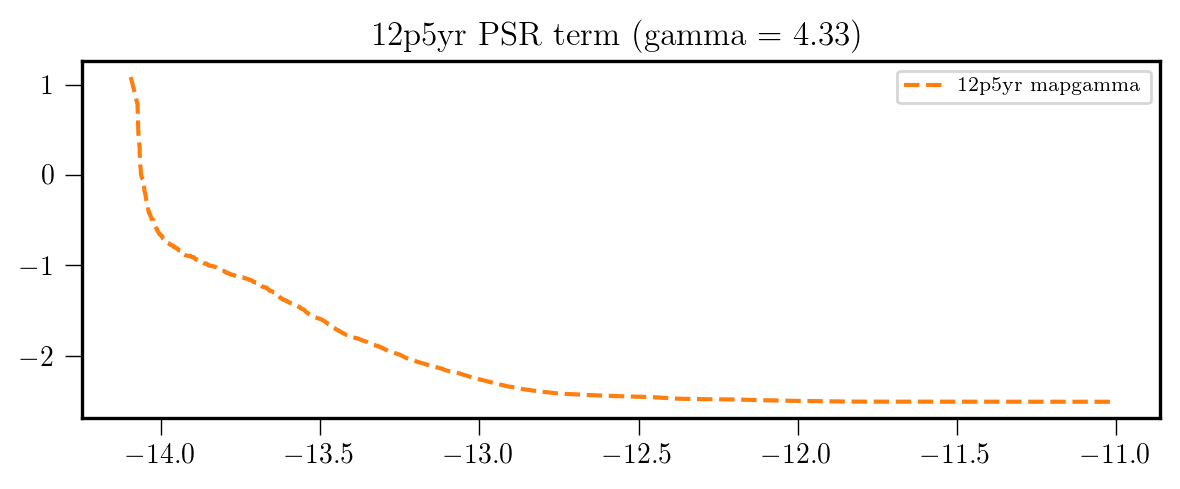

In [241]:
smbhb_hsort_rescaled = 10**np.array(sorted_combined_smbhb_hs) * np.pi
fig, ax = plt.subplots()
ax.plot(np.log10(smbhb_hsort_rescaled/np.pi), np.log10(1/(sorted_combined_smbhb_dT_cumsum)), color = 'tab:orange', ls = '--', label='12p5yr mapgamma')
plt.title('12p5yr PSR term (gamma = 4.33)')
plt.legend()

In [114]:
# The goal is to somehow set up parallel arrays here and argsort the h_psr and apply the same to the dT one
# hs_combined = []
# NsxdTs_combined = []
# start = 0
# for key in h_psr.keys():
#     # Key is just PSR name
#     hs_psr = h_psr[key]
#     dT_psr = dTs_psr[key]
    
#     Ns_psr = np.arange(start, start+len(hs_psr)) + 1
#     start += len(hs_psr)
#     #print(Ns_psr)
    
#     for h_idx, h_val in enumerate(hs_psr):
#         hs_combined.append(h_val)
    
#     for Ns_idx, Ns_val in enumerate(Ns_psr):
#         NsxdTs_combined.append(Ns_val * dT_psr)

In [13]:
dat = np.load("/home/nima/nanograv/11yr/postproc_nb/11yr_bwm_paper_data/rate_vs_strain_Sesana_finegrain_10.npy").T

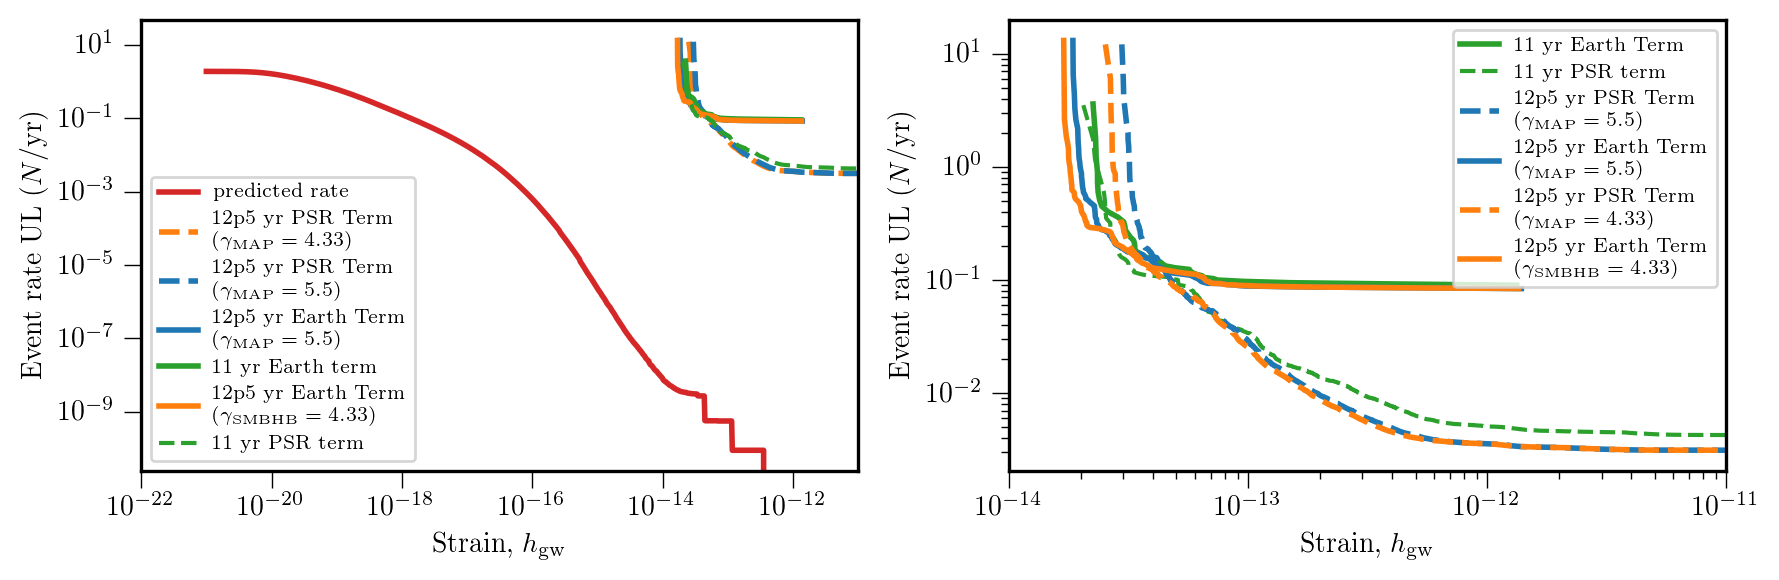

In [274]:
wid=2
fig = plt.figure(figsize=(9,3))
ax1, ax2 = fig.subplots(1, 2)

# compare with 
ax1.plot(*dat, color='C3', lw=wid, label='predicted rate')
ax1.plot(smbhb_hsort_rescaled, 1/(sorted_combined_smbhb_dT_cumsum), color='tab:orange', ls='--', lw=wid, label='12p5 yr PSR Term\n$(\gamma_\mathrm{MAP}=4.33)$')
ax1.plot(mapgamma_hsort_rescaled, 1/(sorted_combined_mapgamma_dT_cumsum), color='tab:blue', ls='--', lw=wid, label='12p5 yr PSR Term\n$(\gamma_\mathrm{MAP}=5.5)$')
ax1.plot(10**hsort_12, 1/(Ns_12 * dT_12), color='tab:blue', lw=wid, label='12p5 yr Earth Term\n$(\gamma_\mathrm{MAP}=5.5)$')
ax1.plot(hsort_11, 1/(Ns_11*dT_11), color='tab:green', lw=wid, label='11 yr Earth term')
ax1.plot(10**astro_hsort_12, 1/(astro_Ns_12 * astro_dT_12), color='tab:orange', lw=wid, label='12p5 yr Earth Term\n$(\gamma_\mathrm{SMBHB}=4.33)$')
ax1.plot(hsort_psr, 1/(Ns_psr * dT_psr), color = 'tab:green', ls = '--', label='11 yr PSR term')


# zoom
ax2.plot(hsort_11, 1/(Ns_11*dT_11), color='tab:green', lw=wid, label='11 yr Earth Term')
ax2.plot(hsort_psr, 1/(Ns_psr * dT_psr), color = 'tab:green', ls='--', label='11 yr PSR term')
ax2.plot(mapgamma_hsort_rescaled, 1/(sorted_combined_mapgamma_dT_cumsum), color='tab:blue', ls='--', lw=wid, label='12p5 yr PSR Term\n$(\gamma_\mathrm{MAP}=5.5)$')
ax2.plot(10**hsort_12, 1/(Ns_12 * dT_12), color='tab:blue', lw=wid, label='12p5 yr Earth Term\n$(\gamma_\mathrm{MAP}=5.5)$')
ax2.plot(smbhb_hsort_rescaled, 1/(sorted_combined_smbhb_dT_cumsum), color='tab:orange', ls='--', lw=wid, label='12p5 yr PSR Term\n$(\gamma_\mathrm{MAP}=4.33)$')
ax2.plot(10**astro_hsort_12, 1/(astro_Ns_12 * astro_dT_12), color='tab:orange', lw=wid, label='12p5 yr Earth Term\n$(\gamma_\mathrm{SMBHB}=4.33)$')

# ax2.plot(*ng5_p, color='C1', ls='--', lw=wid,label='5 yr pulsar term')
# ax2.plot(*ng5_e, color='C1', lw=wid, label='5 yr Earth term')

for ax in fig.axes:
    ax.set_xlabel('Strain, $h_\mathrm{gw}$')#, fontsize=16)
    ax.set_ylabel('Event rate UL ($N$/yr)')#, fontsize=16)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

ax1.set_xlim([1e-22, 1e-11])
ax2.set_xlim([1e-14, 1e-11])
    
plt.tight_layout()
plt.savefig('/home/nima/nanograv/12p5yr_bwm/paper_plots/UL_rate.pdf')
plt.show()

In [247]:
ul_list = []

for psr in allpsrs:
    ul_list.append(np.pi*10**min(UL_dict[psr.name][1]))
    print("PSR {}: {}".format(psr.name, np.pi*10**min(UL_dict[psr.name][1])))

PSR B1855+09: 1.7526838446378196e-13
PSR B1937+21: 2.4389688691865795e-13
PSR B1953+29: 9.393601406979415e-13
PSR J0023+0923: 1.8974964372435636e-13
PSR J0030+0451: 1.0604484198949234e-13
PSR J0340+4130: 2.7218242630933163e-13
PSR J0613-0200: 1.3500884436983047e-13
PSR J0636+5128: 6.653769821920087e-13
PSR J0645+5158: 1.1218128107246759e-13
PSR J0740+6620: 2.9080724847375057e-13
PSR J0931-1902: 4.3983234281798777e-13
PSR J1012+5307: 3.048309363595947e-13
PSR J1024-0719: 2.2502132514015783e-13
PSR J1125+7819: 2.211424623642396e-12
PSR J1453+1902: 7.446954524323481e-13
PSR J1455-3330: 1.6053467612820334e-13
PSR J1600-3053: 7.799489607912971e-14
PSR J1614-2230: 6.549120708183538e-14
PSR J1640+2224: 6.852302238715021e-14
PSR J1643-1224: 1.0488898795823515e-12
PSR J1713+0747: 2.5195399542363176e-14
PSR J1738+0333: 1.3465275128864734e-13
PSR J1741+1351: 9.053537506315965e-14
PSR J1744-1134: 1.7035836166546893e-13
PSR J1747-4036: 2.7924873464275657e-12
PSR J1832-0836: 2.8490919524215515e-13
P

It looks like the Earth term is just more constraining now than any individual PSR term

Save psr-term ULvT

In [290]:
MAP_outdir = '/home/nima/nanograv/12p5yr_bwm/paper_data/ULvT_psrterm_data/MAP/'
SMBHB_outdir = '/home/nima/nanograv/12p5yr_bwm/paper_data/ULvT_psrterm_data/SMBHB/'

os.makedirs(MAP_outdir, exist_ok=True)
os.makedirs(SMBHB_outdir, exist_ok=True)
for psr in allpsrs:
    MAP_outfile = MAP_outdir + '{}.json'.format(psr.name)
    SMBHB_outfile = SMBHB_outdir + '{}.json'.format(psr.name) 
    
    with open(MAP_outfile, 'w+') as f:
        years = psrterm_ULvT_dict_MAP[psr.name][0]
        ULs = psrterm_ULvT_dict_MAP[psr.name][1]
        
        this_psr_MAP_dict = {}
        for yr_idx, yr in enumerate(years):
            this_psr_MAP_dict[yr] = ULs[yr_idx]
        
        json.dump(this_psr_MAP_dict, f, indent=4)
        
    with open(SMBHB_outfile, 'w+') as f:
        years = psrterm_ULvT_dict_SMBHB[psr.name][0]
        ULs = psrterm_ULvT_dict_SMBHB[psr.name][1]
        
        this_psr_SMBHB_dict = {}
        for yr_idx, yr in enumerate(years):
            this_psr_SMBHB_dict[yr] = ULs[yr_idx]
        
        json.dump(this_psr_SMBHB_dict, f, indent=4)